## Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics
from rdkit import Chem
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load data 📊

In [2]:
df_train = pd.read_csv("data/train_smiles.csv")
df_test = pd.read_csv("data/test_smiles.csv")
df_valid = pd.read_csv("data/valid_smiles.csv")
df_train_all = pd.concat([df_train, df_valid])

In [9]:
df_test

,pIC50,smiles
0,5.387216,COc1ccc(C(=O)Oc2cc(O)cc3oc(-c4ccc(OC)cc4)cc(=O...
1,4.560667,CCCCCCC(N1CCOCC1)C(O)(c1cccnc1)c1cccnc1
2,4.522879,CC(C)N1CCN(C(=O)c2ccc(NC(=O)Nc3ccc(-c4nc(C5CCO...
3,5.000000,COCCOCC#Cc1cc(-c2n[nH]c3c2Cc2ccc(Cn4cncn4)cc2-...
4,5.275724,Cc1nc2ccccc2c(=O)n1-c1ccc(OCCCN2CCCC(C)C2)cc1
...,...,...
2122,4.225483,CN(C)c1ccc(C=Cc2c(F)cccc2Cl)cn1
2123,5.090920,CC1CCCN1CCc1ccc(-c2ccc(S(=O)(=O)NCc3ccncc3)cc2...
2124,4.730487,COc1cc(F)ccc1-c1cncc(CNC(=O)C2CCC2)c1
2125,5.920819,CC(C)C1OC2(CCN(CCc3ccccc3)CC2)CN(c2ccccc2)C1=O


### Metrics

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## Featurizer 🧪

In [4]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

## Graph Dataset

In [5]:
class GraphDataset(InMemoryDataset):  
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        data = []
        X, y = self.dataset
        for i, graph in enumerate(X):
            N, E = graph
            data.append(Data(x=torch.FloatTensor(N), edge_index=torch.LongTensor(E)), y=y[i])
        
        torch.save(data, self.raw_paths[0])


    def process(self):
        data_list = torch.load(self.raw_paths[0])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
featurizer = GraphFeaturizer(y_column='pIC50')

X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)
X_valid, y_valid = featurizer(df_valid)
X_train_all, y_train_all = featurizer(df_train_all)

In [11]:
train_dataset = GraphDataset(X_train_all, y_train_all.reshape(-1, 1), root='cardio-train')
test_dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='cardio-test')
valid_dataset = GraphDataset(X_valid, y_valid.reshape(-1, 1), root='cardio-valid')
train_dataset_small = GraphDataset(X_train, y_train.reshape(-1, 1), root='cardio-train_small')

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


## Model

![Graph](images/graph_net.png)

In [8]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

## Grid search 🔎

In [21]:
lrs = [0.005, 0.01, 0.02]
batch_sizes = [32, 64, 128]

In [16]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:

        model = GraphNeuralNetwork()

        train_loader = GraphDataLoader(train_dataset_small, batch_size=batch_size, shuffle=False)
        valid_loader = GraphDataLoader(valid_dataset, batch_size=1063, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []

        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0

            for data in tqdm(train_loader, leave=False):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                optimizer.zero_grad()
                output = model(x, edge_index, batch)
                loss = criterion(output, torch.Tensor(y))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0    

            with torch.no_grad():
                for data in tqdm(valid_loader):
                    x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                    output = model(x, edge_index, batch)
                    test_loss += criterion(output, torch.Tensor(y)).item()
                    test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

  1%|          | 2/233 [00:00<00:16, 14.27it/s]

Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 1.4978311600347445, Accuracy: -0.8833406570653617


  1%|          | 2/233 [00:00<00:15, 14.77it/s]

Test Avg. loss: 0.8604594469070435, Accuracy: 0.12014149688846221
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9074599489633618, Accuracy: -0.08635692786281318


  1%|          | 2/233 [00:00<00:14, 15.83it/s]

Test Avg. loss: 0.8643748164176941, Accuracy: 0.11613772357478458
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8687734628184159, Accuracy: -0.034793457754734955


  1%|          | 2/233 [00:00<00:15, 15.40it/s]

Test Avg. loss: 0.8496343493461609, Accuracy: 0.13121061420923552
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8554309825273031, Accuracy: -0.017712704989200464


  1%|          | 2/233 [00:00<00:14, 16.37it/s]

Test Avg. loss: 0.7994547486305237, Accuracy: 0.18252155292507788
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8480097054795646, Accuracy: -0.01636043332681369


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.8000144958496094, Accuracy: 0.18194918094445023
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8100577670872979, Accuracy: 0.029067203132457125


  1%|          | 2/233 [00:00<00:13, 17.28it/s]

Test Avg. loss: 0.8561533689498901, Accuracy: 0.12454464017639488
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7886335263948072, Accuracy: 0.054335110222237686


  1%|          | 2/233 [00:00<00:13, 17.35it/s]

Test Avg. loss: 0.8113069534301758, Accuracy: 0.1704021564169047
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7749508869366585, Accuracy: 0.0790521768523853


  1%|          | 2/233 [00:00<00:12, 17.94it/s]

Test Avg. loss: 0.7814835906028748, Accuracy: 0.2008978952212691
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.754947723493044, Accuracy: 0.1044052141227476


  1%|          | 2/233 [00:00<00:13, 17.28it/s]

Test Avg. loss: 0.7614924311637878, Accuracy: 0.22133970333452202
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7442684611025798, Accuracy: 0.1146468211087185


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.7619072198867798, Accuracy: 0.2209156922022405
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7334286372293218, Accuracy: 0.12938132371103964


  1%|          | 2/233 [00:00<00:13, 16.87it/s]

Test Avg. loss: 0.7472460269927979, Accuracy: 0.23590732784356339
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7272128814535591, Accuracy: 0.1371262333607104


  1%|          | 2/233 [00:00<00:12, 18.76it/s]

Test Avg. loss: 0.743498682975769, Accuracy: 0.23973915976164406
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7150328105611351, Accuracy: 0.15154077824348236


  1%|          | 2/233 [00:00<00:13, 17.22it/s]

Test Avg. loss: 0.7394851446151733, Accuracy: 0.2438431925717639
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7067818642941668, Accuracy: 0.15925885666320255


  1%|          | 2/233 [00:00<00:12, 18.48it/s]

Test Avg. loss: 0.7404699325561523, Accuracy: 0.24283618497309656
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.698586611277044, Accuracy: 0.1699195176959509


  1%|          | 2/233 [00:00<00:13, 17.43it/s]

Test Avg. loss: 0.7441214919090271, Accuracy: 0.23910226528002465
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6840660479319454, Accuracy: 0.18694762872288495


  1%|          | 2/233 [00:00<00:12, 18.87it/s]

Test Avg. loss: 0.728310227394104, Accuracy: 0.2552700250673068
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6720406414357378, Accuracy: 0.20136154936007641


  1%|          | 2/233 [00:00<00:14, 16.10it/s]

Test Avg. loss: 0.7353386878967285, Accuracy: 0.2480830728977924
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6638120016314952, Accuracy: 0.20883347928635948


  1%|          | 2/233 [00:00<00:13, 16.76it/s]

Test Avg. loss: 0.7053987383842468, Accuracy: 0.27869800605977024
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6547434892137675, Accuracy: 0.21645730378082906


  1%|          | 2/233 [00:00<00:14, 16.23it/s]

Test Avg. loss: 0.7101104259490967, Accuracy: 0.2738801374696681
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6455228406088547, Accuracy: 0.22874604245288893


  1%|          | 2/233 [00:00<00:14, 15.64it/s]

Test Avg. loss: 0.6889549493789673, Accuracy: 0.29551256612644283
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6406373427021657, Accuracy: 0.23201926313137358


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.679835855960846, Accuracy: 0.3048372279406435
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6219305453638151, Accuracy: 0.25162353394108133


  1%|          | 2/233 [00:00<00:12, 19.22it/s]

Test Avg. loss: 0.682449996471405, Accuracy: 0.3021642304521953
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6121206815022767, Accuracy: 0.26275165478931434


  1%|          | 2/233 [00:00<00:13, 17.22it/s]

Test Avg. loss: 0.6718039512634277, Accuracy: 0.3130502327651077
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5970602873952604, Accuracy: 0.27944859082362083


  1%|          | 2/233 [00:00<00:13, 17.57it/s]

Test Avg. loss: 0.6485902667045593, Accuracy: 0.3367872447092789
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5908497841828882, Accuracy: 0.28743901889649026


  1%|          | 2/233 [00:00<00:11, 19.73it/s]

Test Avg. loss: 0.6333156228065491, Accuracy: 0.35240629843722093
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5817021982736342, Accuracy: 0.2976634961338689


  1%|          | 2/233 [00:00<00:14, 16.26it/s]

Test Avg. loss: 0.6298750042915344, Accuracy: 0.3559244780468379
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5664798897479225, Accuracy: 0.31636583760804005


  1%|          | 2/233 [00:00<00:13, 16.60it/s]

Test Avg. loss: 0.6694136261940002, Accuracy: 0.31549453001743677
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5609671804142612, Accuracy: 0.32076862673737727


  1%|          | 2/233 [00:00<00:14, 15.97it/s]

Test Avg. loss: 0.6195803284645081, Accuracy: 0.3664512386477756
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5480358633872265, Accuracy: 0.3376019044867906


  1%|          | 2/233 [00:00<00:12, 18.90it/s]

Test Avg. loss: 0.620788037776947, Accuracy: 0.3652163050633972
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5440887175660276, Accuracy: 0.33582507383828575


  1%|          | 2/233 [00:00<00:14, 16.32it/s]

Test Avg. loss: 0.606315553188324, Accuracy: 0.3800150162850895
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5377025587620141, Accuracy: 0.3463439229785392


  1%|          | 2/233 [00:00<00:13, 16.97it/s]

Test Avg. loss: 0.6229008436203003, Accuracy: 0.36305584902537
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5275790979166399, Accuracy: 0.35732884856934144


  1%|          | 2/233 [00:00<00:14, 16.29it/s]

Test Avg. loss: 0.5951585173606873, Accuracy: 0.39142368384050064
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.519573164536206, Accuracy: 0.3660022786542855


  1%|          | 2/233 [00:00<00:12, 19.13it/s]

Test Avg. loss: 0.6136037111282349, Accuracy: 0.3725626042548049
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5151710441823681, Accuracy: 0.36707909556946794


  1%|          | 2/233 [00:00<00:14, 16.39it/s]

Test Avg. loss: 0.625809907913208, Accuracy: 0.3600811193976584
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5049080999624064, Accuracy: 0.3813238919412641


  1%|          | 2/233 [00:00<00:13, 17.67it/s]

Test Avg. loss: 0.5919645428657532, Accuracy: 0.3946896067808804
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4942464944886547, Accuracy: 0.39325157670270966


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.5743098855018616, Accuracy: 0.4127423603097855
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4965135144957145, Accuracy: 0.39092568960410995


  1%|          | 2/233 [00:00<00:14, 16.27it/s]

Test Avg. loss: 0.6020331978797913, Accuracy: 0.3843939370237246
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48919293335578984, Accuracy: 0.39775637427496935


  1%|          | 2/233 [00:00<00:11, 19.65it/s]

Test Avg. loss: 0.5903205871582031, Accuracy: 0.39637058244510526
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.47561786915355486, Accuracy: 0.41320827149737394


  1%|          | 2/233 [00:00<00:14, 15.61it/s]

Test Avg. loss: 0.6132152676582336, Accuracy: 0.3729598292775096
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4742610832524402, Accuracy: 0.41626038568995377


  1%|          | 2/233 [00:00<00:16, 14.25it/s]

Test Avg. loss: 0.6099744439125061, Accuracy: 0.37627365932818835
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46728044057608675, Accuracy: 0.42529193552108163


  1%|          | 2/233 [00:00<00:12, 18.15it/s]

Test Avg. loss: 0.6292244791984558, Accuracy: 0.35658964001088966
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4602932338422972, Accuracy: 0.4309121296858944


  1%|          | 2/233 [00:00<00:13, 17.12it/s]

Test Avg. loss: 0.6053159832954407, Accuracy: 0.3810372099971454
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4495155023402922, Accuracy: 0.4435498302895288


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

Test Avg. loss: 0.601627767086029, Accuracy: 0.3848085092230913
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45741469064495593, Accuracy: 0.4320762133961606


  1%|          | 2/233 [00:00<00:14, 16.48it/s]

Test Avg. loss: 0.6420985460281372, Accuracy: 0.3434253172516436
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4423070290953305, Accuracy: 0.4540659546558439


  1%|          | 2/233 [00:00<00:13, 17.37it/s]

Test Avg. loss: 0.6227941513061523, Accuracy: 0.36316497894445576
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.441438330025632, Accuracy: 0.45266204429401635


  1%|          | 2/233 [00:00<00:13, 17.66it/s]

Test Avg. loss: 0.6324057579040527, Accuracy: 0.35333663165332474
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4393274388855619, Accuracy: 0.4533846014745376


  1%|          | 2/233 [00:00<00:15, 15.16it/s]

Test Avg. loss: 0.6101371645927429, Accuracy: 0.37610729809140553
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43149710193979895, Accuracy: 0.46532459905404683


  1%|          | 2/233 [00:00<00:14, 15.47it/s]

Test Avg. loss: 0.607487142086029, Accuracy: 0.37881700831193
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43471613008321097, Accuracy: 0.46036910326104225


  1%|          | 2/233 [00:00<00:13, 17.41it/s]

Test Avg. loss: 0.6241540312767029, Accuracy: 0.3617744229217632
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.427175071745983, Accuracy: 0.46992867794719817


  1%|          | 2/233 [00:00<00:12, 19.16it/s]

Test Avg. loss: 0.5930314660072327, Accuracy: 0.39359859298097066
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4119486236393196, Accuracy: 0.488626256646788


  1%|          | 2/233 [00:00<00:13, 17.56it/s]

Test Avg. loss: 0.5854958295822144, Accuracy: 0.4013041868820493
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41626798051365455, Accuracy: 0.48126066357351144


  1%|          | 2/233 [00:00<00:13, 16.96it/s]

Test Avg. loss: 0.5986769795417786, Accuracy: 0.38782593336661797
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4239241297600607, Accuracy: 0.46929449571517096


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.6795265674591064, Accuracy: 0.3051535473772419
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4157472806682914, Accuracy: 0.4811999241274481


  1%|          | 2/233 [00:00<00:13, 16.66it/s]

Test Avg. loss: 0.5969988703727722, Accuracy: 0.38954179776761544
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41593715183980473, Accuracy: 0.4789784936772936


  1%|          | 2/233 [00:00<00:14, 15.45it/s]

Test Avg. loss: 0.600607693195343, Accuracy: 0.3858516287228282
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40793687252271843, Accuracy: 0.49060918632573053


  1%|          | 2/233 [00:00<00:13, 16.60it/s]

Test Avg. loss: 0.6064147353172302, Accuracy: 0.37991371720881095
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4033067400363382, Accuracy: 0.49576452244643576


  1%|          | 2/233 [00:00<00:13, 17.25it/s]

Test Avg. loss: 0.589992344379425, Accuracy: 0.3967063278843129
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39759398382876565, Accuracy: 0.5032583514295589


  1%|          | 2/233 [00:00<00:14, 15.52it/s]

Test Avg. loss: 0.5966242551803589, Accuracy: 0.38992489298553334
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4001990088257667, Accuracy: 0.5014209917574737


  1%|          | 2/233 [00:00<00:14, 16.13it/s]

Test Avg. loss: 0.5678985118865967, Accuracy: 0.41929819279533065
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39851988135745087, Accuracy: 0.5021188805638152


  1%|          | 2/233 [00:00<00:13, 17.61it/s]

Test Avg. loss: 0.5870598554611206, Accuracy: 0.39970492448625616
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39474710208151986, Accuracy: 0.503529918201032


  1%|          | 2/233 [00:00<00:11, 19.46it/s]

Test Avg. loss: 0.5652670860290527, Accuracy: 0.4219889659070578
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38970820554592067, Accuracy: 0.5141237754506651


  1%|          | 2/233 [00:00<00:12, 19.08it/s]

Test Avg. loss: 0.594271719455719, Accuracy: 0.39233047090653683
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39526240016002, Accuracy: 0.507469086731331


  1%|          | 2/233 [00:00<00:12, 17.80it/s]

Test Avg. loss: 0.586621105670929, Accuracy: 0.4001534659237409
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3875239128846467, Accuracy: 0.5150161116323297


  1%|          | 2/233 [00:00<00:13, 17.41it/s]

Test Avg. loss: 0.6389480233192444, Accuracy: 0.3466469022248554
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3818801231522417, Accuracy: 0.5237212529182103


  1%|          | 2/233 [00:00<00:14, 16.15it/s]

Test Avg. loss: 0.5766732096672058, Accuracy: 0.4103257511550773
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.379336492825987, Accuracy: 0.5244174790790653


  1%|          | 2/233 [00:00<00:14, 16.14it/s]

Test Avg. loss: 0.5978001952171326, Accuracy: 0.3887223977352624
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3835184564214408, Accuracy: 0.518314496916394


  1%|          | 2/233 [00:00<00:15, 15.03it/s]

Test Avg. loss: 0.5898991227149963, Accuracy: 0.3968015896745303
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38194364216578364, Accuracy: 0.518018554515939


  1%|          | 2/233 [00:00<00:15, 15.04it/s]

Test Avg. loss: 0.5705215930938721, Accuracy: 0.416616018491791
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37470134657851617, Accuracy: 0.5287078564777721


  1%|          | 2/233 [00:00<00:13, 17.20it/s]

Test Avg. loss: 0.5851531028747559, Accuracy: 0.40165459274681226
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3746611651816593, Accuracy: 0.5306752728765357


  1%|          | 2/233 [00:00<00:12, 18.45it/s]

Test Avg. loss: 0.5859163999557495, Accuracy: 0.40087415695796447
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3677956643854088, Accuracy: 0.5382194992030921


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.6092789173126221, Accuracy: 0.3769848507295893
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3621502803886397, Accuracy: 0.5464111994700136


  1%|          | 2/233 [00:00<00:12, 18.78it/s]

Test Avg. loss: 0.5880326628684998, Accuracy: 0.3987101917638739
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3647517740982285, Accuracy: 0.5434799926579512


  1%|          | 2/233 [00:00<00:14, 15.42it/s]

Test Avg. loss: 0.5824781060218811, Accuracy: 0.4043899390144704
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35940163214830884, Accuracy: 0.5444496075485272


  1%|          | 2/233 [00:00<00:12, 18.12it/s]

Test Avg. loss: 0.5662453770637512, Accuracy: 0.42098859867321636
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3649814969864014, Accuracy: 0.5417637629951495


  1%|          | 2/233 [00:00<00:12, 18.82it/s]

Test Avg. loss: 0.5344002842903137, Accuracy: 0.4535517048441918
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3592565930388516, Accuracy: 0.5504266617031772


  1%|          | 2/233 [00:00<00:15, 14.81it/s]

Test Avg. loss: 0.6107558012008667, Accuracy: 0.3754746532501455
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35550547017048356, Accuracy: 0.5532523990371225


  1%|          | 2/233 [00:00<00:13, 17.56it/s]

Test Avg. loss: 0.5613160729408264, Accuracy: 0.42602903645409584
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35523732639689304, Accuracy: 0.5491639959075321


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.5548499822616577, Accuracy: 0.43264090054713744
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3566847266749251, Accuracy: 0.5490273429804843


  1%|          | 2/233 [00:00<00:12, 18.72it/s]

Test Avg. loss: 0.6465075016021729, Accuracy: 0.33891692762065695
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3583393464656347, Accuracy: 0.5514204745750448


  1%|          | 2/233 [00:00<00:13, 16.53it/s]

Test Avg. loss: 0.5801637172698975, Accuracy: 0.4067564707911002
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3439724329587216, Accuracy: 0.5647973722288004


  1%|          | 2/233 [00:00<00:13, 16.89it/s]

Test Avg. loss: 0.5824893712997437, Accuracy: 0.40437838973054885
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35211456717339706, Accuracy: 0.5557836945805611


  1%|          | 2/233 [00:00<00:13, 17.16it/s]

Test Avg. loss: 0.6149535775184631, Accuracy: 0.37118225533426275
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3517152477743288, Accuracy: 0.5539986656223049


  1%|          | 2/233 [00:00<00:14, 16.29it/s]

Test Avg. loss: 0.5633142590522766, Accuracy: 0.42398590356914023
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34410599839789674, Accuracy: 0.5661495681109813


  1%|          | 2/233 [00:00<00:13, 17.01it/s]

Test Avg. loss: 0.6054196953773499, Accuracy: 0.38093105684346984
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34692114540435726, Accuracy: 0.5619648711848302


  1%|          | 2/233 [00:00<00:13, 16.67it/s]

Test Avg. loss: 0.5658102035522461, Accuracy: 0.42143358762019634
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3485569982057989, Accuracy: 0.5571514284628052


  1%|          | 2/233 [00:00<00:11, 19.30it/s]

Test Avg. loss: 0.5741889476776123, Accuracy: 0.4128660295456362
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.346135756456545, Accuracy: 0.5610852101896205


  1%|          | 2/233 [00:00<00:13, 16.53it/s]

Test Avg. loss: 0.5767841935157776, Accuracy: 0.41021221873566316
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34725882304840333, Accuracy: 0.5616477015033264


  1%|          | 2/233 [00:00<00:13, 17.26it/s]

Test Avg. loss: 0.542693018913269, Accuracy: 0.44507197997889403
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33582729331413563, Accuracy: 0.576626131489408


  1%|          | 2/233 [00:00<00:13, 17.34it/s]

Test Avg. loss: 0.5733685493469238, Accuracy: 0.41370484871646174
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33072531830855195, Accuracy: 0.5800155452416478


  1%|          | 2/233 [00:00<00:11, 19.29it/s]

Test Avg. loss: 0.5846140384674072, Accuracy: 0.40220586478079157
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33217887516441263, Accuracy: 0.581871883889695


  1%|          | 2/233 [00:00<00:13, 17.31it/s]

Test Avg. loss: 0.5971844792366028, Accuracy: 0.38935195423392377
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3297792454390055, Accuracy: 0.5818156056465704


  1%|          | 2/233 [00:00<00:12, 18.44it/s]

Test Avg. loss: 0.5473754405975342, Accuracy: 0.4402839555408634
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33472087669142325, Accuracy: 0.5793016145999191


  1%|          | 2/233 [00:00<00:13, 17.71it/s]

Test Avg. loss: 0.5809553265571594, Accuracy: 0.405947024686094
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3312361981927581, Accuracy: 0.5809023193672732


  1%|          | 2/233 [00:00<00:13, 17.13it/s]

Test Avg. loss: 0.5211476683616638, Accuracy: 0.46710305654822204
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33138436788908915, Accuracy: 0.5836873697630796


  1%|          | 2/233 [00:00<00:12, 18.59it/s]

Test Avg. loss: 0.5685417652130127, Accuracy: 0.4186404275506568
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3187976819762856, Accuracy: 0.59591293180053


  1%|          | 2/233 [00:00<00:12, 17.88it/s]

Test Avg. loss: 0.581908643245697, Accuracy: 0.40497222379601916
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32293100175427775, Accuracy: 0.5915614636487662


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.5542460680007935, Accuracy: 0.4332584298378276
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.335221041169801, Accuracy: 0.5790040119562957


  1%|          | 2/233 [00:00<00:13, 16.59it/s]

Test Avg. loss: 0.5112945437431335, Accuracy: 0.47717828780239224
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32429184844565495, Accuracy: 0.5907754259449166


  1%|          | 2/233 [00:00<00:14, 16.13it/s]

Test Avg. loss: 0.5750370025634766, Accuracy: 0.41199874945893167
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3251457378715916, Accuracy: 0.5869427305702255


  1%|          | 2/233 [00:00<00:13, 16.82it/s]

Test Avg. loss: 0.526964545249939, Accuracy: 0.46115500081060123
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32163961279673636, Accuracy: 0.5929928756174115


  1%|          | 2/233 [00:00<00:15, 14.51it/s]

Test Avg. loss: 0.5775116086006165, Accuracy: 0.4094684190501897
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3259765062273316, Accuracy: 0.5828501973514794


  1%|          | 2/233 [00:00<00:13, 16.86it/s]

Test Avg. loss: 0.5446513295173645, Accuracy: 0.44306954879895766
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3184892721953822, Accuracy: 0.5946631006653046


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.55609530210495, Accuracy: 0.4313674745881022
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31694842545643387, Accuracy: 0.5981030127151787


  1%|          | 2/233 [00:00<00:12, 18.14it/s]

Test Avg. loss: 0.5195642113685608, Accuracy: 0.46872221637271794
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3160105744784482, Accuracy: 0.6016244265294615


  1%|          | 2/233 [00:00<00:13, 17.72it/s]

Test Avg. loss: 0.5054808855056763, Accuracy: 0.4831230328521643
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3056559755183085, Accuracy: 0.6091373350372659


  1%|          | 2/233 [00:00<00:14, 16.17it/s]

Test Avg. loss: 0.5296434760093689, Accuracy: 0.45841575361530584
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30983193346615, Accuracy: 0.6009803474330158


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.5242547988891602, Accuracy: 0.46392589589379274
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31829248477461003, Accuracy: 0.5929305988850758


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.5016469359397888, Accuracy: 0.4870434569270131
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3108301528533641, Accuracy: 0.6012864027028325


  1%|          | 2/233 [00:00<00:13, 17.11it/s]

Test Avg. loss: 0.5082734227180481, Accuracy: 0.4802675227099108
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31321133276679486, Accuracy: 0.6009865200033679


  1%|          | 2/233 [00:00<00:13, 17.31it/s]

Test Avg. loss: 0.49491146206855774, Accuracy: 0.4939307943439162
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3133630702040226, Accuracy: 0.5989009467099864


  1%|          | 2/233 [00:00<00:12, 18.58it/s]

Test Avg. loss: 0.5349407196044922, Accuracy: 0.4529990543654686
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3119951168738721, Accuracy: 0.6007246857738493


  1%|          | 2/233 [00:00<00:13, 17.24it/s]

Test Avg. loss: 0.5201115012168884, Accuracy: 0.4681625674891653
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30140008834938126, Accuracy: 0.6143317686694502


  1%|          | 2/233 [00:00<00:13, 17.46it/s]

Test Avg. loss: 0.5049378275871277, Accuracy: 0.48367839547235447
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2999592507218087, Accuracy: 0.6150295198356611


  1%|          | 2/233 [00:00<00:12, 18.41it/s]

Test Avg. loss: 0.5031101703643799, Accuracy: 0.48554719393234824
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2992147042260149, Accuracy: 0.616953130420271


  1%|          | 2/233 [00:00<00:14, 16.49it/s]

Test Avg. loss: 0.504736065864563, Accuracy: 0.48388467945934377
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3128161846376284, Accuracy: 0.600460319645276


  1%|          | 2/233 [00:00<00:12, 18.15it/s]

Test Avg. loss: 0.4955419600009918, Accuracy: 0.4932860529089953
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2940110577022569, Accuracy: 0.6227600837444665


  1%|          | 2/233 [00:00<00:12, 19.18it/s]

Test Avg. loss: 0.5181108117103577, Accuracy: 0.4702084113847137
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29774847226976836, Accuracy: 0.6173091935120701


  1%|          | 2/233 [00:00<00:13, 16.98it/s]

Test Avg. loss: 0.5082908272743225, Accuracy: 0.4802497643066047
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3009133773172362, Accuracy: 0.6132378572152724


  1%|          | 2/233 [00:00<00:13, 17.70it/s]

Test Avg. loss: 0.46406835317611694, Accuracy: 0.5254692170513338
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29520404837673825, Accuracy: 0.6227830080597891


  1%|          | 2/233 [00:00<00:12, 18.05it/s]

Test Avg. loss: 0.48137763142585754, Accuracy: 0.5077697580482226
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2936502927874291, Accuracy: 0.6244351841998325


  1%|          | 2/233 [00:00<00:12, 18.10it/s]

Test Avg. loss: 0.48465049266815186, Accuracy: 0.5044230657998978
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2921403541265639, Accuracy: 0.6237951895478291


  1%|          | 2/233 [00:00<00:14, 15.92it/s]

Test Avg. loss: 0.48017439246177673, Accuracy: 0.509000032074394
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2895260447788136, Accuracy: 0.6321655007885165


  1%|          | 2/233 [00:00<00:14, 16.31it/s]

Test Avg. loss: 0.4932418167591095, Accuracy: 0.49563808811388166
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28731352915835484, Accuracy: 0.6300432122619902


  1%|          | 2/233 [00:00<00:15, 14.88it/s]

Test Avg. loss: 0.4666799008846283, Accuracy: 0.5227987880477356
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28636080858021845, Accuracy: 0.6285318185859616


  1%|          | 2/233 [00:00<00:14, 15.95it/s]

Test Avg. loss: 0.45928171277046204, Accuracy: 0.5303637734101587
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28863094545613033, Accuracy: 0.6278157424143307


  1%|          | 2/233 [00:00<00:14, 16.23it/s]

Test Avg. loss: 0.49285629391670227, Accuracy: 0.49603225266692164
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28405477717326943, Accuracy: 0.6326372574341291


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.5177362561225891, Accuracy: 0.470591401998548
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2915050012295338, Accuracy: 0.6275200964739492


  1%|          | 2/233 [00:00<00:13, 16.76it/s]

Test Avg. loss: 0.487020343542099, Accuracy: 0.5019997522358273
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29184924098043485, Accuracy: 0.6280626790794013


  1%|          | 2/233 [00:00<00:13, 16.53it/s]

Test Avg. loss: 0.4428553581237793, Accuracy: 0.5471604634644698
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2800119694466243, Accuracy: 0.6408602854850047


  1%|          | 2/233 [00:00<00:12, 18.31it/s]

Test Avg. loss: 0.49063318967819214, Accuracy: 0.4983054904306945
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.292672426883499, Accuracy: 0.6252152381741785


  1%|          | 2/233 [00:00<00:12, 17.95it/s]

Test Avg. loss: 0.4891703128814697, Accuracy: 0.4998013371389395
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2854107948971409, Accuracy: 0.6305051042137185


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.4819628894329071, Accuracy: 0.5071712831508849
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2858357661015998, Accuracy: 0.6292012496625699


  1%|          | 2/233 [00:00<00:12, 19.00it/s]

Test Avg. loss: 0.4756593704223633, Accuracy: 0.513616849533923
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28131077937430066, Accuracy: 0.6373699251521692


  1%|          | 2/233 [00:00<00:13, 17.42it/s]

Test Avg. loss: 0.46901583671569824, Accuracy: 0.5204101690892754
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28630485657458654, Accuracy: 0.6351556733192649


  1%|          | 2/233 [00:00<00:12, 17.85it/s]

Test Avg. loss: 0.4818970263004303, Accuracy: 0.5072386212704403
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2802626061784863, Accuracy: 0.6383659783552733


  1%|          | 2/233 [00:00<00:12, 18.02it/s]

Test Avg. loss: 0.4872235059738159, Accuracy: 0.5017920328772334
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2767792327785185, Accuracy: 0.6422976272137128


  1%|          | 2/233 [00:00<00:13, 17.10it/s]

Test Avg. loss: 0.4559529423713684, Accuracy: 0.5337676324524875
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.277079375292866, Accuracy: 0.6394892984392735


  1%|          | 2/233 [00:00<00:15, 14.81it/s]

Test Avg. loss: 0.44878721237182617, Accuracy: 0.5410948537074871
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27440318062325914, Accuracy: 0.6482358860868216


  1%|          | 2/233 [00:00<00:12, 18.48it/s]

Test Avg. loss: 0.46440115571022034, Accuracy: 0.525128877338485
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27276651737132296, Accuracy: 0.6510555778407487


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

Test Avg. loss: 0.469682514667511, Accuracy: 0.5197284795751658
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2726273098920548, Accuracy: 0.649565620152496


  1%|          | 2/233 [00:00<00:12, 18.50it/s]

Test Avg. loss: 0.4709610342979431, Accuracy: 0.5184211461468693
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2747218746995721, Accuracy: 0.6452232528806036


  1%|          | 2/233 [00:00<00:12, 18.79it/s]

Test Avg. loss: 0.4728899300098419, Accuracy: 0.5164488000423724
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2769445338538276, Accuracy: 0.6440549872755027


  1%|          | 2/233 [00:00<00:11, 19.28it/s]

Test Avg. loss: 0.45989981293678284, Accuracy: 0.529731795966122
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2756026655179748, Accuracy: 0.6452724708312572


  1%|          | 2/233 [00:00<00:13, 16.81it/s]

Test Avg. loss: 0.474849671125412, Accuracy: 0.5144448051517719
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2708302832212571, Accuracy: 0.6534239390711738


  1%|          | 2/233 [00:00<00:12, 18.49it/s]

Test Avg. loss: 0.47951433062553406, Accuracy: 0.5096750553802516
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26464536466312, Accuracy: 0.6577819114735406


  1%|          | 2/233 [00:00<00:14, 16.33it/s]

Test Avg. loss: 0.46797820925712585, Accuracy: 0.5214712332813793
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2670779268181375, Accuracy: 0.6552324927884621


  1%|          | 2/233 [00:00<00:14, 15.94it/s]

Test Avg. loss: 0.45462778210639954, Accuracy: 0.5351226362245434
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.265217638290747, Accuracy: 0.6578809270503615


  1%|          | 2/233 [00:00<00:12, 17.85it/s]

Test Avg. loss: 0.4892894923686981, Accuracy: 0.49967940132085487
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27279475315318086, Accuracy: 0.6476309865056685


  1%|          | 2/233 [00:00<00:14, 16.07it/s]

Test Avg. loss: 0.4923454523086548, Accuracy: 0.496554633390067
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26470574240955674, Accuracy: 0.6587624306507983


  1%|          | 2/233 [00:00<00:12, 17.91it/s]

Test Avg. loss: 0.44280001521110535, Accuracy: 0.5472170352499698
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2658829278444528, Accuracy: 0.6586318202627834


  1%|          | 2/233 [00:00<00:12, 17.78it/s]

Test Avg. loss: 0.4562962055206299, Accuracy: 0.5334165820419252
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27044472638757444, Accuracy: 0.6536192907846227


  1%|          | 2/233 [00:00<00:15, 15.29it/s]

Test Avg. loss: 0.4670118987560272, Accuracy: 0.5224593043426766
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2718826008904645, Accuracy: 0.65172694363491


  1%|          | 2/233 [00:00<00:12, 17.77it/s]

Test Avg. loss: 0.4828387200832367, Accuracy: 0.5062756471829686
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27539327232239075, Accuracy: 0.6499353696307952


  1%|          | 2/233 [00:00<00:16, 14.04it/s]

Test Avg. loss: 0.45716020464897156, Accuracy: 0.5325330965338353
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26424280713939874, Accuracy: 0.6618942900397092


  1%|          | 2/233 [00:00<00:15, 15.27it/s]

Test Avg. loss: 0.4834945499897003, Accuracy: 0.5056050167244639
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26443221458421756, Accuracy: 0.6619881451811356


  1%|          | 2/233 [00:00<00:13, 17.33it/s]

Test Avg. loss: 0.45356428623199463, Accuracy: 0.5362100855673464
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2642453693716823, Accuracy: 0.663278035008512


  1%|          | 2/233 [00:00<00:12, 17.88it/s]

Test Avg. loss: 0.465650737285614, Accuracy: 0.5238511177501771
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2617695256428145, Accuracy: 0.6641369425767818


  1%|          | 2/233 [00:00<00:13, 17.15it/s]

Test Avg. loss: 0.45013731718063354, Accuracy: 0.539714352324288
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2647859436887528, Accuracy: 0.6583519093549309


  1%|          | 2/233 [00:00<00:15, 15.29it/s]

Test Avg. loss: 0.4910993278026581, Accuracy: 0.49782884078561984
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2615841962237215, Accuracy: 0.6651503892607109


  1%|          | 2/233 [00:00<00:12, 18.54it/s]

Test Avg. loss: 0.4448491334915161, Accuracy: 0.5451217154424625
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2650613573423783, Accuracy: 0.6585560157772944


  1%|          | 2/233 [00:00<00:11, 19.54it/s]

Test Avg. loss: 0.4418357312679291, Accuracy: 0.5482030999339484
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2575823685130336, Accuracy: 0.6719503385152742


  1%|          | 2/233 [00:00<00:14, 16.32it/s]

Test Avg. loss: 0.4752178490161896, Accuracy: 0.5140683802183303
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2592134890126568, Accuracy: 0.6683454829471391


  1%|          | 2/233 [00:00<00:13, 16.68it/s]

Test Avg. loss: 0.4979647696018219, Accuracy: 0.49080862201657605
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2694065970860326, Accuracy: 0.6531621718142857


  1%|          | 2/233 [00:00<00:13, 17.25it/s]

Test Avg. loss: 0.4859881103038788, Accuracy: 0.5030552879307406
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2617628237016723, Accuracy: 0.6650957111910949


  1%|          | 2/233 [00:00<00:14, 15.82it/s]

Test Avg. loss: 0.447950154542923, Accuracy: 0.5419507923573943
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2636933853058344, Accuracy: 0.6610657137825723


  1%|          | 2/233 [00:00<00:12, 17.83it/s]

Test Avg. loss: 0.4564048647880554, Accuracy: 0.5333054906770341
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25405675191991833, Accuracy: 0.6732387331073721


  1%|          | 2/233 [00:00<00:12, 18.98it/s]

Test Avg. loss: 0.46035975217819214, Accuracy: 0.5292614407336149
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2639603590504806, Accuracy: 0.6624883598109044


  1%|          | 2/233 [00:00<00:13, 17.19it/s]

Test Avg. loss: 0.43820396065711975, Accuracy: 0.5519167518115091
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2577147220976875, Accuracy: 0.666565379338214


  1%|          | 2/233 [00:00<00:14, 16.46it/s]

Test Avg. loss: 0.4473513960838318, Accuracy: 0.5425630274646365
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25468119854195437, Accuracy: 0.6759300108551853


  1%|          | 2/233 [00:00<00:13, 17.67it/s]

Test Avg. loss: 0.44361138343811035, Accuracy: 0.5463874036933462
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25776147481070055, Accuracy: 0.6714392235029137


  1%|          | 2/233 [00:00<00:12, 17.84it/s]

Test Avg. loss: 0.4583098590373993, Accuracy: 0.5313575804093056
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2572749726826029, Accuracy: 0.666898868741112


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.48478439450263977, Accuracy: 0.5042861391715683
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2531753649591376, Accuracy: 0.6728936668434817


  1%|          | 2/233 [00:00<00:12, 17.81it/s]

Test Avg. loss: 0.44731011986732483, Accuracy: 0.5426052360668359
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25418592762409875, Accuracy: 0.6740080593359716


  1%|          | 2/233 [00:00<00:13, 16.64it/s]

Test Avg. loss: 0.4517650008201599, Accuracy: 0.5380499498021614
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2503582483133533, Accuracy: 0.6774416184885965


  1%|          | 2/233 [00:00<00:12, 18.59it/s]

Test Avg. loss: 0.4737456738948822, Accuracy: 0.5155737765094897
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25140751943056167, Accuracy: 0.6781510588075073


  1%|          | 2/233 [00:00<00:13, 17.56it/s]

Test Avg. loss: 0.43780964612960815, Accuracy: 0.552319961697163
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2530925610610344, Accuracy: 0.6743014809660516


  1%|          | 2/233 [00:00<00:12, 17.85it/s]

Test Avg. loss: 0.4293281137943268, Accuracy: 0.5609926958771128
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25561483054074097, Accuracy: 0.6723812295594542


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.4451673626899719, Accuracy: 0.5447963399012697
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2513468504719468, Accuracy: 0.6732464767883839


  1%|          | 2/233 [00:00<00:13, 17.20it/s]

Test Avg. loss: 0.42826414108276367, Accuracy: 0.5620806822233038
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25968626358989993, Accuracy: 0.6625312721928451


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.4538246989250183, Accuracy: 0.5359438532192942
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24761291276743483, Accuracy: 0.6808680213600589


  1%|          | 2/233 [00:00<00:13, 17.14it/s]

Test Avg. loss: 0.4399035573005676, Accuracy: 0.5501788150049779
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2541905525480217, Accuracy: 0.6714007503939096


  1%|          | 2/233 [00:00<00:13, 16.77it/s]

Test Avg. loss: 0.43183454871177673, Accuracy: 0.5584297242002829
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25190779803392715, Accuracy: 0.6743545329146937


  1%|          | 2/233 [00:00<00:12, 17.81it/s]

Test Avg. loss: 0.49136871099472046, Accuracy: 0.49755337710661784
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2479212469553231, Accuracy: 0.6783769979824061


  1%|          | 2/233 [00:00<00:13, 17.25it/s]

Test Avg. loss: 0.4359518885612488, Accuracy: 0.5542195598826984
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24468596145318813, Accuracy: 0.6827533933603652


  1%|          | 2/233 [00:00<00:13, 17.21it/s]

Test Avg. loss: 0.4470588266849518, Accuracy: 0.542862230344241
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24803456967864426, Accuracy: 0.6801811000210003


  1%|          | 2/233 [00:00<00:13, 16.52it/s]

Test Avg. loss: 0.4555213153362274, Accuracy: 0.5342089570348333
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23728234647041738, Accuracy: 0.6946687130265601


  1%|          | 2/233 [00:00<00:13, 17.61it/s]

Test Avg. loss: 0.43650782108306885, Accuracy: 0.5536511140649046
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2410676238874509, Accuracy: 0.6898715682843425


  1%|          | 2/233 [00:00<00:13, 17.67it/s]

Test Avg. loss: 0.4745960831642151, Accuracy: 0.5147041228813223
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24529900152412096, Accuracy: 0.6832950402021504


  1%|          | 2/233 [00:00<00:14, 16.00it/s]

Test Avg. loss: 0.47691312432289124, Accuracy: 0.5123348500281658
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24474274255175446, Accuracy: 0.6851943612647841


  1%|          | 2/233 [00:00<00:13, 17.03it/s]

Test Avg. loss: 0.46260130405426025, Accuracy: 0.5269693832887121
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.241359559763143, Accuracy: 0.6903085342191508


  1%|          | 2/233 [00:00<00:14, 16.48it/s]

Test Avg. loss: 0.454995334148407, Accuracy: 0.5347467960798582
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24488062047011863, Accuracy: 0.6821812859647407


  1%|          | 2/233 [00:00<00:12, 18.74it/s]

Test Avg. loss: 0.4498339295387268, Accuracy: 0.5400245510754313
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24361964804420144, Accuracy: 0.6821199981419179


  1%|          | 2/233 [00:00<00:12, 18.98it/s]

Test Avg. loss: 0.4374755322933197, Accuracy: 0.5526615418510741
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24484159420104498, Accuracy: 0.6836455504430621


  1%|          | 2/233 [00:00<00:13, 17.53it/s]

Test Avg. loss: 0.4503309726715088, Accuracy: 0.5395163348277785
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23579546198440723, Accuracy: 0.6970139501658498


  1%|          | 2/233 [00:00<00:13, 16.53it/s]

Test Avg. loss: 0.45869776606559753, Accuracy: 0.5309609274119687
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24054809109719527, Accuracy: 0.6871631528285378


  1%|          | 2/233 [00:00<00:13, 16.85it/s]

Test Avg. loss: 0.4669289290904999, Accuracy: 0.5225441636020467
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24342174409157216, Accuracy: 0.6858691370050355


  1%|          | 2/233 [00:00<00:12, 18.13it/s]

Test Avg. loss: 0.42719876766204834, Accuracy: 0.5631700500501461
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24106427326862392, Accuracy: 0.6882028619131006


  1%|          | 2/233 [00:00<00:14, 15.97it/s]

Test Avg. loss: 0.43411293625831604, Accuracy: 0.5560999828309761
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23951450808877087, Accuracy: 0.69030847862165


  1%|          | 2/233 [00:00<00:12, 18.20it/s]

Test Avg. loss: 0.4536120295524597, Accuracy: 0.5361613052928269
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24168333001914455, Accuracy: 0.6894587295782372


  1%|          | 2/233 [00:00<00:12, 18.08it/s]

Test Avg. loss: 0.458337664604187, Accuracy: 0.5313290516586798
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2431143815489286, Accuracy: 0.6879860250128946


  1%|          | 2/233 [00:00<00:13, 16.89it/s]

Test Avg. loss: 0.4425594210624695, Accuracy: 0.5474630182287596
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24323585814928292, Accuracy: 0.6860152348873341


  1%|          | 2/233 [00:00<00:14, 15.67it/s]

Test Avg. loss: 0.47586730122566223, Accuracy: 0.513404289033937
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23471576378325024, Accuracy: 0.6971341833699317


  1%|          | 2/233 [00:00<00:14, 16.33it/s]

Test Avg. loss: 0.43069973587989807, Accuracy: 0.5595901258866707
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22447385261626715, Accuracy: 0.7089572374717573


  1%|          | 2/233 [00:00<00:13, 16.79it/s]

Test Avg. loss: 0.4254899322986603, Accuracy: 0.5649174051500929
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23274647118323863, Accuracy: 0.7009832164654896


  1%|          | 2/233 [00:00<00:13, 17.46it/s]

Test Avg. loss: 0.4647408127784729, Accuracy: 0.5247816001401842
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24102044805820408, Accuracy: 0.6881365276584257


  1%|          | 2/233 [00:00<00:13, 17.09it/s]

Test Avg. loss: 0.4581725597381592, Accuracy: 0.5314979143575105
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24136462986725082, Accuracy: 0.6918995545188074


  1%|          | 2/233 [00:00<00:12, 18.16it/s]

Test Avg. loss: 0.4366454482078552, Accuracy: 0.5535103481544168
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22750931732004803, Accuracy: 0.7037598746919885


  1%|          | 2/233 [00:00<00:15, 15.19it/s]

Test Avg. loss: 0.45641016960144043, Accuracy: 0.5333000956875305
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23051423557070702, Accuracy: 0.700320225841651


  1%|          | 2/233 [00:00<00:13, 16.93it/s]

Test Avg. loss: 0.4553461968898773, Accuracy: 0.5343880238558139
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23627504325859536, Accuracy: 0.6983946829361628


  1%|          | 2/233 [00:00<00:13, 16.98it/s]

Test Avg. loss: 0.45329540967941284, Accuracy: 0.5364850381996275
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22442830194091593, Accuracy: 0.7095557082695403


  1%|          | 2/233 [00:00<00:11, 19.52it/s]

Test Avg. loss: 0.44608446955680847, Accuracy: 0.5438585531980469
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23226061383414165, Accuracy: 0.7011825220006723


  1%|▏         | 3/233 [00:00<00:11, 20.56it/s]

Test Avg. loss: 0.44598934054374695, Accuracy: 0.5439558455773086
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2285003526208227, Accuracy: 0.703464525163171


  1%|          | 2/233 [00:00<00:14, 16.12it/s]

Test Avg. loss: 0.45799264311790466, Accuracy: 0.5316818938914016
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23422613464967376, Accuracy: 0.6991241623914786


  1%|          | 2/233 [00:00<00:13, 17.00it/s]

Test Avg. loss: 0.4628428518772125, Accuracy: 0.5267223819916667
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23623708795452322, Accuracy: 0.6982758494793814


  1%|          | 2/233 [00:00<00:12, 18.07it/s]

Test Avg. loss: 0.4622415602207184, Accuracy: 0.527337173865218
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22866707982679293, Accuracy: 0.7011797957892251


  1%|          | 2/233 [00:00<00:13, 16.59it/s]

Test Avg. loss: 0.45337963104248047, Accuracy: 0.5363989105231526
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2339649055904585, Accuracy: 0.6997714963402303


  1%|▏         | 3/233 [00:00<00:11, 19.72it/s]

Test Avg. loss: 0.4730328917503357, Accuracy: 0.5163025464454296
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2281434474265115, Accuracy: 0.7091492158589032


  1%|          | 2/233 [00:00<00:13, 16.61it/s]

Test Avg. loss: 0.48167258501052856, Accuracy: 0.5074680969219081
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23254586976868913, Accuracy: 0.7026853115230047


  1%|          | 2/233 [00:00<00:11, 19.47it/s]

Test Avg. loss: 0.448225200176239, Accuracy: 0.5416695563958228
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22959933605828511, Accuracy: 0.7006675012526389


  1%|          | 2/233 [00:00<00:12, 18.05it/s]

Test Avg. loss: 0.4576815962791443, Accuracy: 0.531999969827021
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22765170363909185, Accuracy: 0.7049507778853946


  1%|          | 2/233 [00:00<00:12, 18.19it/s]

Test Avg. loss: 0.45860055088996887, Accuracy: 0.5310603326250685
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22933166205499306, Accuracy: 0.7043561394169223


  1%|          | 2/233 [00:00<00:13, 16.72it/s]

Test Avg. loss: 0.442714124917984, Accuracy: 0.5473049154067815
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23563018409223516, Accuracy: 0.6993052223977662


  1%|          | 2/233 [00:00<00:13, 17.42it/s]

Test Avg. loss: 0.4877893626689911, Accuracy: 0.5012134499919529
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2242511469279236, Accuracy: 0.7094481042732397


  1%|          | 2/233 [00:00<00:15, 15.26it/s]

Test Avg. loss: 0.46435272693634033, Accuracy: 0.5251784379943014
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23455940647442453, Accuracy: 0.7016533956692336


  1%|          | 2/233 [00:00<00:13, 16.54it/s]

Test Avg. loss: 0.4583165645599365, Accuracy: 0.5313506815283563
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22690375194017467, Accuracy: 0.7054497178650174


  1%|          | 2/233 [00:00<00:14, 16.27it/s]

Test Avg. loss: 0.4300600290298462, Accuracy: 0.5602442720689631
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22606478135856947, Accuracy: 0.7074926034741876


  1%|          | 2/233 [00:00<00:15, 15.38it/s]

Test Avg. loss: 0.43718352913856506, Accuracy: 0.5529601601387273
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23170944373622984, Accuracy: 0.7010027172432669


  1%|          | 2/233 [00:00<00:11, 19.31it/s]

Test Avg. loss: 0.43213820457458496, Accuracy: 0.5581192385854159
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22523717297632806, Accuracy: 0.7047567549249312


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

Test Avg. loss: 0.45922327041625977, Accuracy: 0.5304235221438642
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22245463335590812, Accuracy: 0.7112893193697363


  1%|          | 2/233 [00:00<00:12, 19.11it/s]

Test Avg. loss: 0.4285646975040436, Accuracy: 0.5617733559944493
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22351639087875513, Accuracy: 0.7125501875486675


  1%|          | 2/233 [00:00<00:13, 17.43it/s]

Test Avg. loss: 0.4329383671283722, Accuracy: 0.5573010322492198
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22529118341821458, Accuracy: 0.706283780617085


  1%|          | 2/233 [00:00<00:12, 18.14it/s]

Test Avg. loss: 0.43822720646858215, Accuracy: 0.5518929612269371
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22861180879783222, Accuracy: 0.7061839896641836


  1%|          | 2/233 [00:00<00:11, 19.37it/s]

Test Avg. loss: 0.44903993606567383, Accuracy: 0.5408364593159327
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2305096967601469, Accuracy: 0.6991359787599871


  1%|          | 2/233 [00:00<00:13, 16.82it/s]

Test Avg. loss: 0.4260718524456024, Accuracy: 0.5643223995253956
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.225325275932003, Accuracy: 0.7059468559911422


  1%|          | 2/233 [00:00<00:16, 14.07it/s]

Test Avg. loss: 0.44932276010513306, Accuracy: 0.5405472754776988
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22078163950612106, Accuracy: 0.7155121910637552


  1%|          | 2/233 [00:00<00:13, 17.26it/s]

Test Avg. loss: 0.42571860551834106, Accuracy: 0.5646835956018696
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22346020848070602, Accuracy: 0.7117897141559044


  1%|          | 2/233 [00:00<00:12, 18.13it/s]

Test Avg. loss: 0.44691288471221924, Accuracy: 0.5430115105915845
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2194803191165044, Accuracy: 0.715808723528407


  1%|          | 2/233 [00:00<00:13, 17.75it/s]

Test Avg. loss: 0.41074275970458984, Accuracy: 0.5799969928098748
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22289708538116815, Accuracy: 0.7075734884417717


  1%|          | 2/233 [00:00<00:13, 17.34it/s]

Test Avg. loss: 0.4455067813396454, Accuracy: 0.544449278872154
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22056064342224546, Accuracy: 0.713422766761016


  1%|          | 2/233 [00:00<00:13, 17.75it/s]

Test Avg. loss: 0.4339838922023773, Accuracy: 0.5562319307449112
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22624178524948496, Accuracy: 0.7082433077347917


  1%|          | 2/233 [00:00<00:13, 17.66it/s]

Test Avg. loss: 0.4451165497303009, Accuracy: 0.5448483258567739
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23127778670690602, Accuracy: 0.7025136150889673


  1%|          | 2/233 [00:00<00:12, 18.61it/s]

Test Avg. loss: 0.43127506971359253, Accuracy: 0.5590018346071919
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2236166087342946, Accuracy: 0.709941719047214


  1%|          | 2/233 [00:00<00:16, 14.28it/s]

Test Avg. loss: 0.4337068796157837, Accuracy: 0.5565151963623642
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22111229755208217, Accuracy: 0.7157854708569095


  1%|          | 2/233 [00:00<00:13, 16.85it/s]

Test Avg. loss: 0.4459550082683563, Accuracy: 0.5439909543223098
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22328508622912377, Accuracy: 0.7104728601903005


  1%|          | 2/233 [00:00<00:13, 16.80it/s]

Test Avg. loss: 0.4561117887496948, Accuracy: 0.5336052058080328
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22753957166564312, Accuracy: 0.705508916560652


  1%|          | 2/233 [00:00<00:12, 18.13it/s]

Test Avg. loss: 0.4462987184524536, Accuracy: 0.5436395469823382
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20962357856812908, Accuracy: 0.727087219200333


  1%|          | 2/233 [00:00<00:13, 17.73it/s]

Test Avg. loss: 0.44206613302230835, Accuracy: 0.5479675146180774
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2173161925548136, Accuracy: 0.716186580984845


  1%|          | 2/233 [00:00<00:13, 17.11it/s]

Test Avg. loss: 0.46468132734298706, Accuracy: 0.5248424482483438
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21784625365498753, Accuracy: 0.7164680773683981


  1%|          | 2/233 [00:00<00:13, 17.36it/s]

Test Avg. loss: 0.4422991871833801, Accuracy: 0.547729200180209
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21638158708810806, Accuracy: 0.718755853593838


  1%|          | 2/233 [00:00<00:14, 16.10it/s]

Test Avg. loss: 0.4402581751346588, Accuracy: 0.549816231511848
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2196071554023309, Accuracy: 0.714731247213821


  1%|          | 2/233 [00:00<00:14, 16.11it/s]

Test Avg. loss: 0.4575979709625244, Accuracy: 0.5320855056141067
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21573370755869944, Accuracy: 0.7176295865643658


  1%|          | 2/233 [00:00<00:12, 18.42it/s]

Test Avg. loss: 0.446482390165329, Accuracy: 0.5434516971061707
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21457886312140928, Accuracy: 0.7221870325169919


  1%|          | 2/233 [00:00<00:12, 18.25it/s]

Test Avg. loss: 0.4891563653945923, Accuracy: 0.49981561562782606
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22252219093587777, Accuracy: 0.714229872848008


  1%|          | 2/233 [00:00<00:13, 17.03it/s]

Test Avg. loss: 0.4332086443901062, Accuracy: 0.5570246852321121
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2168277259996009, Accuracy: 0.7198508020685412


  1%|          | 2/233 [00:00<00:12, 18.38it/s]

Test Avg. loss: 0.4339294135570526, Accuracy: 0.5562876666474644
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2193718440031289, Accuracy: 0.7114106859672262


  1%|          | 2/233 [00:00<00:14, 15.95it/s]

Test Avg. loss: 0.43899744749069214, Accuracy: 0.55110536974601
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21916719727505943, Accuracy: 0.7129744865883558


  1%|          | 2/233 [00:00<00:14, 16.39it/s]

Test Avg. loss: 0.449404776096344, Accuracy: 0.5404634123085628
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21451759319192862, Accuracy: 0.7216700713689732


  1%|          | 2/233 [00:00<00:13, 16.89it/s]

Test Avg. loss: 0.44656530022621155, Accuracy: 0.5433668908903891
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21861324430535278, Accuracy: 0.7176584279580348


  1%|          | 2/233 [00:00<00:16, 14.05it/s]

Test Avg. loss: 0.45025092363357544, Accuracy: 0.5395981707327542
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21820211899766595, Accuracy: 0.7159660572512258


  1%|          | 2/233 [00:00<00:14, 15.98it/s]

Test Avg. loss: 0.44272854924201965, Accuracy: 0.5472901106648396
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21147388779426338, Accuracy: 0.7230684062666285


  1%|          | 2/233 [00:00<00:12, 18.99it/s]

Test Avg. loss: 0.47135916352272034, Accuracy: 0.5180140085196502
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21877322841611543, Accuracy: 0.7159339191612324


  1%|          | 2/233 [00:00<00:16, 14.05it/s]

Test Avg. loss: 0.4595073163509369, Accuracy: 0.5301331029878041
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21592654345373227, Accuracy: 0.7195636482045772


  1%|          | 2/233 [00:00<00:13, 17.44it/s]

Test Avg. loss: 0.4396045207977295, Accuracy: 0.550484657956462
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21974302016102704, Accuracy: 0.7146244460960791


  1%|          | 2/233 [00:00<00:13, 16.88it/s]

Test Avg. loss: 0.4485224485397339, Accuracy: 0.5413655996106603
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2076872659791181, Accuracy: 0.7305961540244682


  1%|          | 2/233 [00:00<00:13, 16.68it/s]

Test Avg. loss: 0.4521544873714447, Accuracy: 0.5376517098911012
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21115437700001466, Accuracy: 0.7278950860257088


  1%|          | 2/233 [00:00<00:13, 16.80it/s]

Test Avg. loss: 0.4261220097541809, Accuracy: 0.5642710792875689
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2139138492711624, Accuracy: 0.7228210814314372


  1%|          | 2/233 [00:00<00:14, 15.92it/s]

Test Avg. loss: 0.43914708495140076, Accuracy: 0.5509523326784167
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21177566953227245, Accuracy: 0.7283968982747662


  1%|          | 2/233 [00:00<00:13, 17.68it/s]

Test Avg. loss: 0.46151596307754517, Accuracy: 0.5280791310926898
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21046723729167374, Accuracy: 0.7258976408381875


  1%|          | 2/233 [00:00<00:14, 15.61it/s]

Test Avg. loss: 0.4359123110771179, Accuracy: 0.5542600437028986
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2120846142680604, Accuracy: 0.7248491073053195


  1%|          | 2/233 [00:00<00:12, 17.90it/s]

Test Avg. loss: 0.44667261838912964, Accuracy: 0.5432571356912093
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.215952351401548, Accuracy: 0.7220045039222496


  1%|          | 2/233 [00:00<00:14, 16.13it/s]

Test Avg. loss: 0.4286569058895111, Accuracy: 0.561679068017998
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2111236937503958, Accuracy: 0.7221907856722115


  1%|          | 2/233 [00:00<00:14, 16.12it/s]

Test Avg. loss: 0.42531317472457886, Accuracy: 0.5650981128998105
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2119337869688165, Accuracy: 0.7236815694421795


  1%|          | 2/233 [00:00<00:12, 17.86it/s]

Test Avg. loss: 0.43099361658096313, Accuracy: 0.5592896426912614
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20829779203869242, Accuracy: 0.7305607392658626


  1%|          | 2/233 [00:00<00:13, 16.62it/s]

Test Avg. loss: 0.4672985374927521, Accuracy: 0.5221661828953208
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20861741759746372, Accuracy: 0.7305307176098045


  1%|          | 2/233 [00:00<00:13, 17.59it/s]

Test Avg. loss: 0.41923385858535767, Accuracy: 0.5713145166514202
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2054406935309136, Accuracy: 0.7338417828980746


  1%|          | 2/233 [00:00<00:15, 15.21it/s]

Test Avg. loss: 0.44921359419822693, Accuracy: 0.5406588945936257
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21457082186645704, Accuracy: 0.7186944788981419


  1%|          | 2/233 [00:00<00:13, 16.94it/s]

Test Avg. loss: 0.4473087191581726, Accuracy: 0.542606702533428
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2129054671960839, Accuracy: 0.7234124919337455


  1%|          | 2/233 [00:00<00:14, 15.53it/s]

Test Avg. loss: 0.43432116508483887, Accuracy: 0.5558870449832478
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20964279508641862, Accuracy: 0.7265972561424545


  1%|          | 2/233 [00:00<00:12, 17.91it/s]

Test Avg. loss: 0.4473488926887512, Accuracy: 0.5425656359327026
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21446939570581453, Accuracy: 0.7194632254678572


  1%|          | 2/233 [00:00<00:12, 18.20it/s]

Test Avg. loss: 0.4388386607170105, Accuracy: 0.5512677230117198
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21338644188872735, Accuracy: 0.7235856552084694


  1%|          | 2/233 [00:00<00:13, 17.50it/s]

Test Avg. loss: 0.44633322954177856, Accuracy: 0.5436042041999585
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20853112401368792, Accuracy: 0.7308212423537905


  1%|          | 2/233 [00:00<00:13, 17.03it/s]

Test Avg. loss: 0.4285975992679596, Accuracy: 0.5617396827007834
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21579791458379557, Accuracy: 0.7168770021716613


  1%|          | 2/233 [00:00<00:14, 15.51it/s]

Test Avg. loss: 0.4245810806751251, Accuracy: 0.5658467439530477
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21847505429399883, Accuracy: 0.7167293820292899


  1%|          | 2/233 [00:00<00:12, 17.78it/s]

Test Avg. loss: 0.42856693267822266, Accuracy: 0.5617710364279792
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2061529965679533, Accuracy: 0.7321727203702587


  1%|          | 2/233 [00:00<00:15, 15.21it/s]

Test Avg. loss: 0.4321950078010559, Accuracy: 0.5580611750392843
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22166000866199256, Accuracy: 0.7101242010178139


  1%|          | 2/233 [00:00<00:12, 18.46it/s]

Test Avg. loss: 0.43951714038848877, Accuracy: 0.5505739193301068
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20936137923866893, Accuracy: 0.7263681812636982


  1%|          | 2/233 [00:00<00:11, 19.30it/s]

Test Avg. loss: 0.42182642221450806, Accuracy: 0.568663509713237
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2133998499279882, Accuracy: 0.7258984384979089


  1%|          | 2/233 [00:00<00:14, 15.77it/s]

Test Avg. loss: 0.4114391803741455, Accuracy: 0.5792849114316502
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20376019307727977, Accuracy: 0.734509108190547


  1%|          | 2/233 [00:00<00:12, 18.79it/s]

Test Avg. loss: 0.4305066168308258, Accuracy: 0.5597876043215485
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20159899753562371, Accuracy: 0.7390233427154967


  1%|          | 2/233 [00:00<00:13, 16.62it/s]

Test Avg. loss: 0.4257984757423401, Accuracy: 0.5646019267547107
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21016205917612166, Accuracy: 0.726031061668532


  1%|          | 2/233 [00:00<00:15, 15.20it/s]

Test Avg. loss: 0.44985201954841614, Accuracy: 0.5400060961054407
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2091831187257951, Accuracy: 0.7292739173632845


  1%|          | 2/233 [00:00<00:12, 18.24it/s]

Test Avg. loss: 0.44951367378234863, Accuracy: 0.540352043256124
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2048723214813568, Accuracy: 0.7308728963401014


  1%|          | 2/233 [00:00<00:13, 16.56it/s]

Test Avg. loss: 0.4376350939273834, Accuracy: 0.5524984175803316
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20888250417080048, Accuracy: 0.7262341994652972


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.4335173964500427, Accuracy: 0.5567090004299833
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20644888707112857, Accuracy: 0.7304282209197446


  1%|          | 2/233 [00:00<00:12, 18.38it/s]

Test Avg. loss: 0.4470684826374054, Accuracy: 0.5428523705955159
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2064076746002543, Accuracy: 0.7320713031451673


  1%|          | 2/233 [00:00<00:12, 18.88it/s]

Test Avg. loss: 0.43904823064804077, Accuracy: 0.5510533961629385
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21786403918215133, Accuracy: 0.7177104667603702


  1%|          | 2/233 [00:00<00:14, 15.97it/s]

Test Avg. loss: 0.4383324682712555, Accuracy: 0.551785351424182
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21008842719854715, Accuracy: 0.7265918224833414


  1%|          | 2/233 [00:00<00:15, 14.44it/s]

Test Avg. loss: 0.45704320073127747, Accuracy: 0.5326527654215393
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20968277566934349, Accuracy: 0.7297259283975097


  1%|          | 2/233 [00:00<00:13, 17.69it/s]

Test Avg. loss: 0.44035932421684265, Accuracy: 0.5497127927832286
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20012206919970943, Accuracy: 0.7368906781428766


  1%|          | 1/117 [00:00<00:13,  8.81it/s]

Test Avg. loss: 0.42620885372161865, Accuracy: 0.5641822374441939
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 2.16880813979695, Accuracy: -1.7336538614970685


  1%|          | 1/117 [00:00<00:16,  6.91it/s]

Test Avg. loss: 1.080429196357727, Accuracy: -0.10478752085327314
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8480581185247145, Accuracy: 0.03690720612392973


  1%|          | 1/117 [00:00<00:14,  8.07it/s]

Test Avg. loss: 0.9266518354415894, Accuracy: 0.05245685926937671
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.823096020354165, Accuracy: 0.06625078956292264


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.8695063591003418, Accuracy: 0.11089054625704142
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.828387180964152, Accuracy: 0.056727748600037986


  1%|          | 1/117 [00:00<00:13,  8.46it/s]

Test Avg. loss: 0.8375194668769836, Accuracy: 0.14359865952412532
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8234622037818289, Accuracy: 0.06294205309795937


  1%|          | 1/117 [00:00<00:13,  8.81it/s]

Test Avg. loss: 0.8656976819038391, Accuracy: 0.11478517100465702
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8261539441907507, Accuracy: 0.05638541923006203


  1%|          | 1/117 [00:00<00:17,  6.54it/s]

Test Avg. loss: 0.8557077050209045, Accuracy: 0.12500035980525004
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8199862422596695, Accuracy: 0.06157262761455251


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Test Avg. loss: 0.8434044718742371, Accuracy: 0.1375810073135203
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8040346709581522, Accuracy: 0.07992622032596211


  1%|          | 1/117 [00:00<00:13,  8.35it/s]

Test Avg. loss: 0.8325995802879333, Accuracy: 0.14862949865498842
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7847457301412892, Accuracy: 0.1028705737730457


  0%|          | 0/117 [00:00<?, ?it/s]

Test Avg. loss: 0.8353983759880066, Accuracy: 0.1457676847698317
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7793463476193256, Accuracy: 0.10738246278468791


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 0.795102596282959, Accuracy: 0.18697183161951425
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.765930184441754, Accuracy: 0.1249343080242433


  1%|          | 1/117 [00:00<00:16,  6.87it/s]

Test Avg. loss: 0.793379545211792, Accuracy: 0.1887337093997422
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7575611090048765, Accuracy: 0.13533730647778436


  1%|          | 1/117 [00:00<00:14,  8.15it/s]

Test Avg. loss: 0.7720305919647217, Accuracy: 0.21056400622287752
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7481039018712492, Accuracy: 0.145891118549109


  1%|          | 1/117 [00:00<00:14,  8.21it/s]

Test Avg. loss: 0.7649473547935486, Accuracy: 0.21780690483114606
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.735748954053618, Accuracy: 0.1608885709467079


  1%|          | 1/117 [00:00<00:13,  8.46it/s]

Test Avg. loss: 0.7515485286712646, Accuracy: 0.2315078261193566
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7253675934595939, Accuracy: 0.1727681126987026


  1%|          | 1/117 [00:00<00:13,  8.53it/s]

Test Avg. loss: 0.7485817670822144, Accuracy: 0.23454144254082865
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7193212076130077, Accuracy: 0.18034119197293969


  1%|          | 1/117 [00:00<00:16,  7.07it/s]

Test Avg. loss: 0.7431929111480713, Accuracy: 0.24005176608811885
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7208046811258692, Accuracy: 0.17751802728662577


  1%|          | 1/117 [00:00<00:14,  8.19it/s]

Test Avg. loss: 0.760811448097229, Accuracy: 0.2220360671151138
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7114797662466, Accuracy: 0.18659327446851576


  1%|          | 1/117 [00:00<00:15,  7.66it/s]

Test Avg. loss: 0.7574451565742493, Accuracy: 0.2254781839099521
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7135497889457605, Accuracy: 0.18409632728407932


  1%|          | 1/117 [00:00<00:13,  8.77it/s]

Test Avg. loss: 0.7598380446434021, Accuracy: 0.22303142138817933
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7015312838758159, Accuracy: 0.19590846718672064


  1%|          | 1/117 [00:00<00:15,  7.71it/s]

Test Avg. loss: 0.7476131916046143, Accuracy: 0.2355318768417709
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6976556798331758, Accuracy: 0.19992878570345898


  1%|          | 1/117 [00:00<00:16,  6.96it/s]

Test Avg. loss: 0.7507100701332092, Accuracy: 0.2323651432815318
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.683289930351779, Accuracy: 0.21590322095979653


  1%|          | 1/117 [00:00<00:13,  8.64it/s]

Test Avg. loss: 0.7336830496788025, Accuracy: 0.24977610104545656
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.687273095560889, Accuracy: 0.21134973365817583


  1%|          | 1/117 [00:00<00:12,  8.96it/s]

Test Avg. loss: 0.7489283084869385, Accuracy: 0.2341870949337993
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6743307500822932, Accuracy: 0.22753533651576965


  1%|          | 1/117 [00:00<00:12,  9.57it/s]

Test Avg. loss: 0.7442327737808228, Accuracy: 0.23898842988809632
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6599437940833915, Accuracy: 0.24366568489084112


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.7325636744499207, Accuracy: 0.25092062083500466
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6571374960944184, Accuracy: 0.24511749802284677


  1%|          | 1/117 [00:00<00:13,  8.32it/s]

Test Avg. loss: 0.718924343585968, Accuracy: 0.264867525835801
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6450439971736354, Accuracy: 0.2596771076523471


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Test Avg. loss: 0.699316680431366, Accuracy: 0.2849172054421075
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6348091589334683, Accuracy: 0.27141942039762557


  1%|          | 1/117 [00:00<00:13,  8.72it/s]

Test Avg. loss: 0.6820192337036133, Accuracy: 0.3026046743107923
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6354176186852984, Accuracy: 0.2694185046052367


  1%|          | 1/117 [00:00<00:12,  9.26it/s]

Test Avg. loss: 0.7019465565681458, Accuracy: 0.28222802431112015
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6158637224863737, Accuracy: 0.29280099621222455


  1%|          | 1/117 [00:00<00:15,  7.28it/s]

Test Avg. loss: 0.6951066851615906, Accuracy: 0.2892220314349383
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6155308251961683, Accuracy: 0.29171357578285245


  1%|          | 1/117 [00:00<00:13,  8.73it/s]

Test Avg. loss: 0.6687558889389038, Accuracy: 0.31616702967880794
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6079522450255532, Accuracy: 0.3012583307328078


  1%|          | 1/117 [00:00<00:12,  9.48it/s]

Test Avg. loss: 0.6826679706573486, Accuracy: 0.3019412354940708
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6018407888646818, Accuracy: 0.30763622287254117


  1%|          | 1/117 [00:00<00:14,  7.93it/s]

Test Avg. loss: 0.6623413562774658, Accuracy: 0.32272622075358104
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5944717281903976, Accuracy: 0.31562696407358465


  1%|          | 1/117 [00:00<00:16,  7.01it/s]

Test Avg. loss: 0.6641575694084167, Accuracy: 0.32086900284295417
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5913011851983193, Accuracy: 0.3205672086706367


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Test Avg. loss: 0.6838060617446899, Accuracy: 0.30077751621120286
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5819030386260432, Accuracy: 0.33130203943629133


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.6949735879898071, Accuracy: 0.28935824957386536
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5790856737866361, Accuracy: 0.3338420609946194


  1%|          | 1/117 [00:00<00:15,  7.70it/s]

Test Avg. loss: 0.6961398720741272, Accuracy: 0.288165620853691
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5680684882860917, Accuracy: 0.3460715169325784


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.6941720247268677, Accuracy: 0.2901778480816648
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5653030250826453, Accuracy: 0.349312729149943


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 0.6799084544181824, Accuracy: 0.30476310086079716
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5604304256092789, Accuracy: 0.3542179975427633


  0%|          | 0/117 [00:00<?, ?it/s]

Test Avg. loss: 0.7133747339248657, Accuracy: 0.27054225244478314
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5593805585661505, Accuracy: 0.3558121670653094


  1%|          | 1/117 [00:00<00:12,  9.47it/s]

Test Avg. loss: 0.7323734164237976, Accuracy: 0.25111519156266626
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.554502264302001, Accuracy: 0.3616357745162165


  1%|          | 1/117 [00:00<00:13,  8.80it/s]

Test Avg. loss: 0.7683184742927551, Accuracy: 0.21435976617933583
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5516594948931637, Accuracy: 0.3649627067538509


  1%|          | 1/117 [00:00<00:11,  9.71it/s]

Test Avg. loss: 0.8056216239929199, Accuracy: 0.17621559096703854
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5513360148821121, Accuracy: 0.36598353140181483


  1%|          | 1/117 [00:00<00:14,  8.29it/s]

Test Avg. loss: 0.8235472440719604, Accuracy: 0.15788582325681644
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5455127999059155, Accuracy: 0.3709993336801775


  1%|          | 1/117 [00:00<00:14,  7.82it/s]

Test Avg. loss: 0.8280616402626038, Accuracy: 0.1532696177501205
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5402115678940064, Accuracy: 0.3769548899862063


  1%|          | 1/117 [00:00<00:15,  7.34it/s]

Test Avg. loss: 0.791638970375061, Accuracy: 0.1905135686128141
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5287133671789088, Accuracy: 0.3895872330558079


  1%|          | 1/117 [00:00<00:12,  9.19it/s]

Test Avg. loss: 0.8185300230979919, Accuracy: 0.1630161968075159
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5290233943706903, Accuracy: 0.388290535411108


  1%|          | 1/117 [00:00<00:12,  9.49it/s]

Test Avg. loss: 0.8113788366317749, Accuracy: 0.1703286643537134
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5335245604953195, Accuracy: 0.38296024955542196


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Test Avg. loss: 0.792839527130127, Accuracy: 0.189285966442988
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5224411597109249, Accuracy: 0.39656848600366656


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.7589784860610962, Accuracy: 0.22391028502126709
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5194949112896227, Accuracy: 0.3989273761866953


  1%|          | 1/117 [00:00<00:15,  7.44it/s]

Test Avg. loss: 0.7356800436973572, Accuracy: 0.24773399386225137
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5184920030271906, Accuracy: 0.3987413123618783


  1%|          | 1/117 [00:00<00:15,  7.32it/s]

Test Avg. loss: 0.698733925819397, Accuracy: 0.2855131277367928
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5202814377525933, Accuracy: 0.3970552058884788


  1%|          | 1/117 [00:00<00:14,  7.86it/s]

Test Avg. loss: 0.6471487283706665, Accuracy: 0.33826132665516373
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.517962061569222, Accuracy: 0.3990536874253436


  1%|          | 1/117 [00:00<00:15,  7.45it/s]

Test Avg. loss: 0.6094226241111755, Accuracy: 0.3768379598413141
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5061827636936791, Accuracy: 0.41222801095835254


  1%|          | 1/117 [00:00<00:14,  8.04it/s]

Test Avg. loss: 0.5875153541564941, Accuracy: 0.3992391493163213
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4999300278404839, Accuracy: 0.4205249692968318


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.6232681274414062, Accuracy: 0.3626803399432529
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4886195947471847, Accuracy: 0.43341426631516156


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.5975696444511414, Accuracy: 0.38895806965866675
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4983088255692751, Accuracy: 0.4204746624715491


  1%|          | 1/117 [00:00<00:13,  8.84it/s]

Test Avg. loss: 0.5850952863693237, Accuracy: 0.4017137486383391
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4840717004914569, Accuracy: 0.43855416818617543


  1%|          | 1/117 [00:00<00:14,  7.83it/s]

Test Avg. loss: 0.5797510743141174, Accuracy: 0.40717839984876525
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48453712412434763, Accuracy: 0.4371334388192878


  1%|          | 1/117 [00:00<00:12,  9.30it/s]

Test Avg. loss: 0.5892018675804138, Accuracy: 0.3975145978715089
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4802978861535716, Accuracy: 0.4433821538091129


  1%|          | 1/117 [00:00<00:14,  8.25it/s]

Test Avg. loss: 0.561570405960083, Accuracy: 0.42576900906448856
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46218410745645183, Accuracy: 0.4640050188113271


  1%|          | 1/117 [00:00<00:12,  9.21it/s]

Test Avg. loss: 0.5717476606369019, Accuracy: 0.41536229785393863
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4642262476631719, Accuracy: 0.4614995062511665


  1%|          | 1/117 [00:00<00:16,  6.87it/s]

Test Avg. loss: 0.5728371739387512, Accuracy: 0.41424821993887007
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45675630116055155, Accuracy: 0.4691876175944935


  1%|          | 1/117 [00:00<00:14,  7.89it/s]

Test Avg. loss: 0.5588391423225403, Accuracy: 0.4285618093501605
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45663995505907595, Accuracy: 0.4690242261370972


  1%|          | 1/117 [00:00<00:12,  9.04it/s]

Test Avg. loss: 0.5675808787345886, Accuracy: 0.4196230066793343
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44470465641755325, Accuracy: 0.4839779725822615


  1%|          | 1/117 [00:00<00:11,  9.78it/s]

Test Avg. loss: 0.586566686630249, Accuracy: 0.40020915677713775
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4484851095411513, Accuracy: 0.4763465369182927


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Test Avg. loss: 0.5593917369842529, Accuracy: 0.4279967744998826
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43587186257553917, Accuracy: 0.49212953012983846


  1%|          | 1/117 [00:00<00:13,  8.61it/s]

Test Avg. loss: 0.561241865158081, Accuracy: 0.426104891215786
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43856546002575475, Accuracy: 0.48966610706651953


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.5438640713691711, Accuracy: 0.44387449253335576
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4394067236755648, Accuracy: 0.48811729474076704


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.5493664145469666, Accuracy: 0.4382481203354528
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4293054710341315, Accuracy: 0.5004695634248927


  1%|          | 1/117 [00:00<00:12,  9.32it/s]

Test Avg. loss: 0.5629202127456665, Accuracy: 0.4243887711220392
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4268378291884039, Accuracy: 0.5024383217737951


  1%|          | 1/117 [00:00<00:13,  8.89it/s]

Test Avg. loss: 0.5448906421661377, Accuracy: 0.44282480674110136
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4256112148873826, Accuracy: 0.5036169765338526


  1%|          | 1/117 [00:00<00:14,  7.90it/s]

Test Avg. loss: 0.5564452409744263, Accuracy: 0.43100973348339555
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42700469124520946, Accuracy: 0.5007700976830576


  1%|          | 1/117 [00:00<00:13,  8.54it/s]

Test Avg. loss: 0.5593688488006592, Accuracy: 0.42802022526988026
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42019713587231106, Accuracy: 0.5091021575632093


  1%|          | 1/117 [00:00<00:15,  7.44it/s]

Test Avg. loss: 0.5719260573387146, Accuracy: 0.4151799051371621
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41010019208630943, Accuracy: 0.5209272418378673


  1%|          | 1/117 [00:00<00:14,  8.25it/s]

Test Avg. loss: 0.5751405954360962, Accuracy: 0.41189288095149623
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4199718883913806, Accuracy: 0.509655378960575


  1%|          | 1/117 [00:00<00:13,  8.64it/s]

Test Avg. loss: 0.5586029887199402, Accuracy: 0.42880325651672746
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40383506139628905, Accuracy: 0.5270457651342177


  1%|          | 1/117 [00:00<00:12,  9.59it/s]

Test Avg. loss: 0.538261890411377, Accuracy: 0.44960306224662183
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40220792515155596, Accuracy: 0.5292239443877257


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.5555540919303894, Accuracy: 0.4319209403895111
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40331110320030117, Accuracy: 0.5292460020040817


  1%|          | 1/117 [00:00<00:12,  9.00it/s]

Test Avg. loss: 0.5562047362327576, Accuracy: 0.43125563695712366
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39678067058070093, Accuracy: 0.5364867865755956


  1%|          | 1/117 [00:00<00:14,  7.80it/s]

Test Avg. loss: 0.5768941640853882, Accuracy: 0.4100997170452326
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39869475721294045, Accuracy: 0.5331480965848141


  1%|          | 1/117 [00:00<00:14,  7.91it/s]

Test Avg. loss: 0.5400738716125488, Accuracy: 0.44775022949877064
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3858702450226515, Accuracy: 0.5474315312628574


  1%|          | 1/117 [00:00<00:12,  9.42it/s]

Test Avg. loss: 0.5584777593612671, Accuracy: 0.42893132176469373
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39802009605953836, Accuracy: 0.5348962189419845


  1%|          | 1/117 [00:00<00:12,  8.98it/s]

Test Avg. loss: 0.544138491153717, Accuracy: 0.4435939778365038
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.385077839733189, Accuracy: 0.5497199788751641


  1%|          | 1/117 [00:00<00:12,  8.95it/s]

Test Avg. loss: 0.5405382513999939, Accuracy: 0.44727526853043464
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38995241443825585, Accuracy: 0.5423894776926704


  1%|          | 1/117 [00:00<00:12,  9.32it/s]

Test Avg. loss: 0.5407096147537231, Accuracy: 0.44710010853856363
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3819941436378365, Accuracy: 0.5534392363172405


  1%|          | 1/117 [00:00<00:11,  9.69it/s]

Test Avg. loss: 0.5428680777549744, Accuracy: 0.4448929547195647
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3790249596548896, Accuracy: 0.5562420466284205


  1%|          | 1/117 [00:00<00:16,  6.95it/s]

Test Avg. loss: 0.5497795343399048, Accuracy: 0.43782569094849266
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3853055806750925, Accuracy: 0.5480471803833107


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 0.5273729562759399, Accuracy: 0.46073739862238505
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3756915925659685, Accuracy: 0.5589970063975935


  1%|          | 1/117 [00:00<00:14,  7.91it/s]

Test Avg. loss: 0.5370741486549377, Accuracy: 0.45081750732373527
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3760975468107778, Accuracy: 0.5565237111223408


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.5470420122146606, Accuracy: 0.4406249347608798
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3811084858627401, Accuracy: 0.5529249587833128


  1%|          | 1/117 [00:00<00:14,  8.26it/s]

Test Avg. loss: 0.5343018174171448, Accuracy: 0.45365236018899235
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3720662717381094, Accuracy: 0.5636166359367412


  1%|          | 1/117 [00:00<00:17,  6.80it/s]

Test Avg. loss: 0.5564936995506287, Accuracy: 0.43096012194194533
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3761224453775292, Accuracy: 0.5578267527762869


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Test Avg. loss: 0.5372858643531799, Accuracy: 0.45060101846746736
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36514530732081485, Accuracy: 0.570968934092674


  1%|          | 1/117 [00:00<00:17,  6.77it/s]

Test Avg. loss: 0.5339089035987854, Accuracy: 0.4540541037085357
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3667756479520064, Accuracy: 0.5697111507540467


  1%|          | 1/117 [00:00<00:13,  8.40it/s]

Test Avg. loss: 0.5914231538772583, Accuracy: 0.3952432384750648
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3671813446741838, Accuracy: 0.5686218860642218


  1%|          | 1/117 [00:00<00:13,  8.33it/s]

Test Avg. loss: 0.5615710020065308, Accuracy: 0.42576836069674284
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37042815563006276, Accuracy: 0.5670627291192781


  1%|          | 1/117 [00:00<00:14,  8.20it/s]

Test Avg. loss: 0.532315731048584, Accuracy: 0.4556831993375795
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.355229834588165, Accuracy: 0.5835542408354325


  1%|          | 1/117 [00:00<00:13,  8.44it/s]

Test Avg. loss: 0.5629485249519348, Accuracy: 0.424359800009687
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3553184000854818, Accuracy: 0.5823273289505286


  1%|          | 1/117 [00:00<00:16,  7.24it/s]

Test Avg. loss: 0.5173974633216858, Accuracy: 0.4709378643041915
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.357767616581713, Accuracy: 0.5816757798493574


  1%|          | 1/117 [00:00<00:13,  8.32it/s]

Test Avg. loss: 0.5399888753890991, Accuracy: 0.44783704760855947
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35591391633209, Accuracy: 0.5815603355811385


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.5537964701652527, Accuracy: 0.4337181357175267
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34861848165846276, Accuracy: 0.5906174378611861


  1%|          | 1/117 [00:00<00:13,  8.43it/s]

Test Avg. loss: 0.5607351660728455, Accuracy: 0.42662308349990763
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35725366508858836, Accuracy: 0.5792376173970705


  1%|          | 1/117 [00:00<00:15,  7.44it/s]

Test Avg. loss: 0.5785238742828369, Accuracy: 0.40843332256629106
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3474389101959701, Accuracy: 0.5922802431192041


  1%|          | 1/117 [00:00<00:12,  9.28it/s]

Test Avg. loss: 0.583742082118988, Accuracy: 0.40309743859996416
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34729457882225007, Accuracy: 0.5948477969559622


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Test Avg. loss: 0.5820615887641907, Accuracy: 0.40481587019851617
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35038495254822266, Accuracy: 0.5894908151561303


  1%|          | 1/117 [00:00<00:14,  8.10it/s]

Test Avg. loss: 0.5546468496322632, Accuracy: 0.4328486110311158
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3482222381310585, Accuracy: 0.590688750880863


  1%|          | 1/117 [00:00<00:16,  6.87it/s]

Test Avg. loss: 0.5740445256233215, Accuracy: 0.41301361467208864
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3434069487783644, Accuracy: 0.5985861889762801


  1%|          | 1/117 [00:00<00:13,  8.72it/s]

Test Avg. loss: 0.5676865577697754, Accuracy: 0.41951497745667476
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34152586949177277, Accuracy: 0.5992633261347099


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.5385170578956604, Accuracy: 0.4493420763745998
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3375367925972001, Accuracy: 0.6031953000173502


  1%|          | 1/117 [00:00<00:15,  7.31it/s]

Test Avg. loss: 0.5543744564056396, Accuracy: 0.4331271676830113
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34310601205907315, Accuracy: 0.5990895698167937


  1%|          | 1/117 [00:00<00:13,  8.38it/s]

Test Avg. loss: 0.5342221260070801, Accuracy: 0.4537338004876892
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3324803078276479, Accuracy: 0.6098815443810417


  1%|          | 1/117 [00:00<00:12,  9.12it/s]

Test Avg. loss: 0.5362814664840698, Accuracy: 0.45162804896360065
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32768781444965267, Accuracy: 0.6153379928246031


  1%|          | 1/117 [00:00<00:14,  8.21it/s]

Test Avg. loss: 0.5100716948509216, Accuracy: 0.4784287262012554
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3353947711806012, Accuracy: 0.6037679586651786


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.5195576548576355, Accuracy: 0.46872892817133116
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3273735660263616, Accuracy: 0.6172802362599804


  1%|          | 1/117 [00:00<00:16,  7.19it/s]

Test Avg. loss: 0.5389975309371948, Accuracy: 0.44885077630841497
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3253284184596477, Accuracy: 0.6172638677348167


  1%|          | 1/117 [00:00<00:16,  7.07it/s]

Test Avg. loss: 0.5220180749893188, Accuracy: 0.46621298939414557
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33113843673824245, Accuracy: 0.6101940419590249


  1%|          | 1/117 [00:00<00:16,  7.01it/s]

Test Avg. loss: 0.5527454018592834, Accuracy: 0.4347929435627106
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3202650846324415, Accuracy: 0.6232799275981301


  1%|          | 1/117 [00:00<00:13,  8.50it/s]

Test Avg. loss: 0.5443477034568787, Accuracy: 0.4433799314043261
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.322050233809357, Accuracy: 0.6231590133436128


  1%|          | 1/117 [00:00<00:14,  8.08it/s]

Test Avg. loss: 0.5159137845039368, Accuracy: 0.4724549135002699
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3280067682011515, Accuracy: 0.6117973576403092


  1%|          | 1/117 [00:00<00:13,  8.79it/s]

Test Avg. loss: 0.5502588748931885, Accuracy: 0.4373355847398408
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31990423862241274, Accuracy: 0.6235335653612845


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.5475198030471802, Accuracy: 0.4401363547232199
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32017319770450264, Accuracy: 0.6233415187562125


  1%|          | 1/117 [00:00<00:13,  8.82it/s]

Test Avg. loss: 0.5095570683479309, Accuracy: 0.478954923518352
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30980792947304553, Accuracy: 0.635800066213726


  1%|          | 1/117 [00:00<00:12,  9.38it/s]

Test Avg. loss: 0.5100752711296082, Accuracy: 0.4784250480928357
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30833140512307483, Accuracy: 0.63914341737229


  1%|          | 1/117 [00:00<00:12,  9.15it/s]

Test Avg. loss: 0.5104458928108215, Accuracy: 0.4780461115871063
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3036758303642273, Accuracy: 0.6408835336807069


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.46091482043266296, Accuracy: 0.528693842624673
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3049318003348815, Accuracy: 0.6407368568844264


  1%|          | 1/117 [00:00<00:13,  8.37it/s]

Test Avg. loss: 0.48232993483543396, Accuracy: 0.5067959017544006
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31025690846463555, Accuracy: 0.6355408459597399


  1%|          | 1/117 [00:00<00:14,  7.80it/s]

Test Avg. loss: 0.499267578125, Accuracy: 0.4894764252078516
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31410719989201963, Accuracy: 0.6307700914527825


  1%|          | 1/117 [00:00<00:14,  8.25it/s]

Test Avg. loss: 0.5465232729911804, Accuracy: 0.44115537333417454
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3101222467982871, Accuracy: 0.6353629160768772


  1%|          | 1/117 [00:00<00:13,  8.62it/s]

Test Avg. loss: 0.5192627906799316, Accuracy: 0.4690304599929841
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.305024601582788, Accuracy: 0.6397116516691391


  1%|          | 1/117 [00:00<00:14,  7.84it/s]

Test Avg. loss: 0.4754912555217743, Accuracy: 0.5137887508504131
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3025184378155276, Accuracy: 0.6441136954750918


  1%|          | 1/117 [00:00<00:16,  6.99it/s]

Test Avg. loss: 0.49484750628471375, Accuracy: 0.49399617578002586
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.302872728333514, Accuracy: 0.642340037276953


  1%|          | 1/117 [00:00<00:14,  8.06it/s]

Test Avg. loss: 0.5104424953460693, Accuracy: 0.47804960116408446
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2957603888124482, Accuracy: 0.6505746483547917


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 0.515592634677887, Accuracy: 0.4727833595250934
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2966366112232208, Accuracy: 0.6507404152912676


  1%|          | 1/117 [00:00<00:14,  8.28it/s]

Test Avg. loss: 0.493848592042923, Accuracy: 0.4950175767800068
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2957750501540991, Accuracy: 0.6512460787832849


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 0.48322492837905884, Accuracy: 0.5058807660500182
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2912946216061584, Accuracy: 0.65808378817966


  1%|          | 1/117 [00:00<00:13,  8.48it/s]

Test Avg. loss: 0.5274621844291687, Accuracy: 0.46064619122157235
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2918083322608573, Accuracy: 0.6567381603764918


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.47825387120246887, Accuracy: 0.5109639163430023
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28392565581533646, Accuracy: 0.66449078250703


  1%|          | 1/117 [00:00<00:11,  9.98it/s]

Test Avg. loss: 0.48947927355766296, Accuracy: 0.49948536901202356
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29613623863611466, Accuracy: 0.6482979474681293


  1%|          | 1/117 [00:00<00:12,  9.08it/s]

Test Avg. loss: 0.5182236433029175, Accuracy: 0.47009309974696534
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29282513833962953, Accuracy: 0.6543508326846094


  1%|          | 1/117 [00:00<00:15,  7.53it/s]

Test Avg. loss: 0.46931228041648865, Accuracy: 0.5201070576379601
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2826163896128663, Accuracy: 0.6640815164889611


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.48799020051956177, Accuracy: 0.5010080798424517
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28221072918838924, Accuracy: 0.6654678110216767


  1%|          | 1/117 [00:00<00:16,  7.15it/s]

Test Avg. loss: 0.4850110709667206, Accuracy: 0.5040543714033828
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.281276437589246, Accuracy: 0.6697427321351186


  1%|          | 1/117 [00:00<00:13,  8.51it/s]

Test Avg. loss: 0.49608248472213745, Accuracy: 0.49273332282696003
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2837404361647418, Accuracy: 0.6635209160259171


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Test Avg. loss: 0.48897209763526917, Accuracy: 0.5000040513117416
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28480720570963675, Accuracy: 0.6628022298651203


  1%|          | 1/117 [00:00<00:15,  7.39it/s]

Test Avg. loss: 0.45270952582359314, Accuracy: 0.5370841111298676
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2820118754847437, Accuracy: 0.6649862391594944


  1%|          | 1/117 [00:00<00:15,  7.37it/s]

Test Avg. loss: 0.46242818236351013, Accuracy: 0.527146387510256
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27335308759640425, Accuracy: 0.6771662299576111


  1%|          | 1/117 [00:00<00:15,  7.62it/s]

Test Avg. loss: 0.4812033474445343, Accuracy: 0.5079479110684122
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2769038239095965, Accuracy: 0.6721373912945234


  1%|          | 1/117 [00:00<00:13,  8.84it/s]

Test Avg. loss: 0.4830200970172882, Accuracy: 0.5060902121626483
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2788984743703125, Accuracy: 0.6713391846824095


  1%|          | 1/117 [00:00<00:11,  9.80it/s]

Test Avg. loss: 0.4919007420539856, Accuracy: 0.4970093057171415
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2786179426898304, Accuracy: 0.6698250257990929


  1%|          | 1/117 [00:00<00:13,  8.69it/s]

Test Avg. loss: 0.4943823516368866, Accuracy: 0.49447186606115967
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27819221702396363, Accuracy: 0.6693569835362527


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.4665336012840271, Accuracy: 0.5229483847233926
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27594204590870786, Accuracy: 0.6729254378866654


  1%|          | 1/117 [00:00<00:13,  8.82it/s]

Test Avg. loss: 0.4784358739852905, Accuracy: 0.510777809494729
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.273253423281205, Accuracy: 0.6771655698447463


  1%|          | 1/117 [00:00<00:14,  8.23it/s]

Test Avg. loss: 0.4735286235809326, Accuracy: 0.5157956784245838
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2723094375215025, Accuracy: 0.6765085986789411


  1%|          | 1/117 [00:00<00:13,  8.39it/s]

Test Avg. loss: 0.46918120980262756, Accuracy: 0.5202411166227057
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2681736772895878, Accuracy: 0.6827281744478021


  1%|          | 1/117 [00:00<00:18,  6.33it/s]

Test Avg. loss: 0.4573019742965698, Accuracy: 0.5323881581231358
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26267375561416656, Accuracy: 0.6885153442391192


  1%|          | 1/117 [00:00<00:13,  8.68it/s]

Test Avg. loss: 0.47358331084251404, Accuracy: 0.5157397689116033
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2637563664943744, Accuracy: 0.6876087717658877


  1%|          | 1/117 [00:00<00:13,  8.78it/s]

Test Avg. loss: 0.46825850009918213, Accuracy: 0.5211846376383299
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2743029763810655, Accuracy: 0.6760339904224351


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Test Avg. loss: 0.4626285135746002, Accuracy: 0.5269415106846651
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26461362596760446, Accuracy: 0.686242005185819


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.46011099219322205, Accuracy: 0.5295158086555423
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26987948988237953, Accuracy: 0.6811615829358079


  1%|          | 1/117 [00:00<00:15,  7.72it/s]

Test Avg. loss: 0.45614349842071533, Accuracy: 0.5335727528640635
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27484518735327274, Accuracy: 0.6744522649813064


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.46560850739479065, Accuracy: 0.5238943652570933
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25821736244819105, Accuracy: 0.6932621644288746


  1%|          | 1/117 [00:00<00:12,  9.27it/s]

Test Avg. loss: 0.49872922897338867, Accuracy: 0.4900269358243794
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25611433813459855, Accuracy: 0.6950010880230647


  1%|          | 1/117 [00:00<00:14,  8.14it/s]

Test Avg. loss: 0.46730321645736694, Accuracy: 0.5221614260026068
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26146393262932444, Accuracy: 0.6892428693844614


  1%|          | 1/117 [00:00<00:13,  8.49it/s]

Test Avg. loss: 0.4452870786190033, Accuracy: 0.5446739077468633
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2583706470636221, Accuracy: 0.6929079778323913


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Test Avg. loss: 0.47338125109672546, Accuracy: 0.5159464000416717
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27365720590465087, Accuracy: 0.6770871875957608


  1%|          | 1/117 [00:00<00:15,  7.70it/s]

Test Avg. loss: 0.49533572793006897, Accuracy: 0.49349695651670866
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2618628289455023, Accuracy: 0.6891770606943349


  1%|          | 1/117 [00:00<00:13,  8.75it/s]

Test Avg. loss: 0.47591179609298706, Accuracy: 0.5133587924682796
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25567790407400864, Accuracy: 0.6966509047568342


  1%|          | 1/117 [00:00<00:12,  9.58it/s]

Test Avg. loss: 0.4462875723838806, Accuracy: 0.543650851646333
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2585933036529101, Accuracy: 0.6911259685828756


  1%|          | 1/117 [00:00<00:12,  9.21it/s]

Test Avg. loss: 0.42257097363471985, Accuracy: 0.5679021794199715
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24924000664653942, Accuracy: 0.7032386271391623


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.4421766996383667, Accuracy: 0.5478544120278681
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25860654645495945, Accuracy: 0.6934187923896356


  1%|          | 1/117 [00:00<00:17,  6.56it/s]

Test Avg. loss: 0.4435841143131256, Accuracy: 0.5464153030076283
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25285892163076973, Accuracy: 0.6999264615960393


  1%|          | 1/117 [00:00<00:12,  9.44it/s]

Test Avg. loss: 0.4586828052997589, Accuracy: 0.5309761707095586
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25633905955359465, Accuracy: 0.6964131220379923


  1%|          | 1/117 [00:00<00:13,  8.71it/s]

Test Avg. loss: 0.4410552978515625, Accuracy: 0.5490010838863211
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2511368588122547, Accuracy: 0.7002435871038067


  1%|          | 1/117 [00:00<00:13,  8.38it/s]

Test Avg. loss: 0.43430498242378235, Accuracy: 0.5559036348529776
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2460053373987858, Accuracy: 0.7066419837823922


  1%|          | 1/117 [00:00<00:13,  8.72it/s]

Test Avg. loss: 0.4289080798625946, Accuracy: 0.5614221894390616
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24677697683756167, Accuracy: 0.7054628075228903


  1%|          | 1/117 [00:00<00:14,  8.04it/s]

Test Avg. loss: 0.44279801845550537, Accuracy: 0.5472190668836006
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25409359319342506, Accuracy: 0.6965421645586363


  1%|          | 1/117 [00:00<00:13,  8.88it/s]

Test Avg. loss: 0.4552267789840698, Accuracy: 0.5345101622796582
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24490514932534632, Accuracy: 0.7077756255071826


  1%|          | 1/117 [00:00<00:12,  9.40it/s]

Test Avg. loss: 0.4326963722705841, Accuracy: 0.5575485254880721
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24227776104568416, Accuracy: 0.7099513546038386


  1%|          | 1/117 [00:00<00:12,  9.53it/s]

Test Avg. loss: 0.4405677020549774, Accuracy: 0.5494997180963734
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24491369711537647, Accuracy: 0.7087669688407066


  1%|          | 1/117 [00:00<00:13,  8.59it/s]

Test Avg. loss: 0.44005119800567627, Accuracy: 0.5500278976579765
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24321321404387808, Accuracy: 0.7106889973867697


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.43013736605644226, Accuracy: 0.5601652087075513
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24902236678152004, Accuracy: 0.7054309969212992


  1%|          | 1/117 [00:00<00:14,  7.94it/s]

Test Avg. loss: 0.4302078187465668, Accuracy: 0.5600931392561979
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23884934053207055, Accuracy: 0.714428327051739


  1%|          | 1/117 [00:00<00:16,  6.84it/s]

Test Avg. loss: 0.4298859238624573, Accuracy: 0.5604223251761665
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23737782182601783, Accuracy: 0.7168738931723095


  1%|          | 1/117 [00:00<00:14,  8.16it/s]

Test Avg. loss: 0.4377525746822357, Accuracy: 0.5523782465369089
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24107286525078309, Accuracy: 0.7136332929482107


  1%|          | 1/117 [00:00<00:14,  8.04it/s]

Test Avg. loss: 0.4288857877254486, Accuracy: 0.5614450211355104
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23350983367771164, Accuracy: 0.7203046390598578


  1%|          | 1/117 [00:00<00:13,  8.50it/s]

Test Avg. loss: 0.43395036458969116, Accuracy: 0.5562662234018778
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23646225219863093, Accuracy: 0.7188659459520546


  1%|          | 1/117 [00:00<00:15,  7.40it/s]

Test Avg. loss: 0.4355364441871643, Accuracy: 0.554644378204293
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2478329255285426, Accuracy: 0.7054063538258152


  1%|          | 1/117 [00:00<00:14,  7.77it/s]

Test Avg. loss: 0.4579198956489563, Accuracy: 0.5317562892670021
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24268855963252547, Accuracy: 0.7108486740242428


  1%|          | 1/117 [00:00<00:16,  7.07it/s]

Test Avg. loss: 0.4378017783164978, Accuracy: 0.5523279458487032
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23885087789888057, Accuracy: 0.716082932077574


  1%|          | 1/117 [00:00<00:13,  8.67it/s]

Test Avg. loss: 0.4279111623764038, Accuracy: 0.5624415913199594
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23110020676484475, Accuracy: 0.7242480379419932


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Test Avg. loss: 0.42811936140060425, Accuracy: 0.5622286912279879
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23668544841373068, Accuracy: 0.7181733744133107


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Test Avg. loss: 0.4166387915611267, Accuracy: 0.5739681299635911
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22920758952187675, Accuracy: 0.7271824910334481


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.44321945309638977, Accuracy: 0.5467882064390435
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23645323807867163, Accuracy: 0.7181927763750166


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Test Avg. loss: 0.4232626259326935, Accuracy: 0.5671949066444022
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23475949205139762, Accuracy: 0.7204161620941733


  1%|          | 1/117 [00:00<00:13,  8.60it/s]

Test Avg. loss: 0.4182930588722229, Accuracy: 0.572276541630326
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23649113134950653, Accuracy: 0.7178215888231144


  1%|          | 1/117 [00:00<00:15,  7.39it/s]

Test Avg. loss: 0.4184655249118805, Accuracy: 0.5721001264484341
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2437312776206905, Accuracy: 0.7082586107854879


  1%|          | 1/117 [00:00<00:17,  6.82it/s]

Test Avg. loss: 0.4340626299381256, Accuracy: 0.5561514806969232
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24562917535121626, Accuracy: 0.7077849539644357


  1%|          | 1/117 [00:00<00:16,  7.04it/s]

Test Avg. loss: 0.41243305802345276, Accuracy: 0.5782686622506321
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2311541863486298, Accuracy: 0.7262741995741605


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.42003482580184937, Accuracy: 0.5704954997693534
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22877092073615798, Accuracy: 0.72748604509561


  1%|          | 1/117 [00:00<00:13,  8.73it/s]

Test Avg. loss: 0.4336705803871155, Accuracy: 0.5565522856336031
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22583565803674552, Accuracy: 0.7321631860962836


  0%|          | 0/117 [00:00<?, ?it/s]

Test Avg. loss: 0.4237493574619293, Accuracy: 0.5666972218228483
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2316746288894588, Accuracy: 0.7253039557517923


  1%|          | 1/117 [00:00<00:12,  9.12it/s]

Test Avg. loss: 0.42421719431877136, Accuracy: 0.5662188346921165
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22302597767522192, Accuracy: 0.7346604296934202


  1%|          | 1/117 [00:00<00:14,  7.83it/s]

Test Avg. loss: 0.42026495933532715, Accuracy: 0.5702601731683292
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2273862524292408, Accuracy: 0.728545596198732


  1%|          | 1/117 [00:00<00:15,  7.66it/s]

Test Avg. loss: 0.41509780287742615, Accuracy: 0.5755438352414934
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2220168228332813, Accuracy: 0.7356364322459009


  1%|          | 1/117 [00:00<00:12,  9.34it/s]

Test Avg. loss: 0.4137236773967743, Accuracy: 0.5769489462859613
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21964503398053667, Accuracy: 0.7382777491071856


  1%|          | 1/117 [00:00<00:14,  7.85it/s]

Test Avg. loss: 0.4324156939983368, Accuracy: 0.5578354669790303
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2210860726160881, Accuracy: 0.7373845141618653


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.4268600642681122, Accuracy: 0.5635163394079266
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22135150337066406, Accuracy: 0.7366237795651251


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Test Avg. loss: 0.4337996244430542, Accuracy: 0.5564203897604092
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2213728943696389, Accuracy: 0.7363351869475079


  1%|          | 1/117 [00:00<00:11,  9.67it/s]

Test Avg. loss: 0.4462814927101135, Accuracy: 0.5436570651794536
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2215330086202703, Accuracy: 0.735515042980636


  1%|          | 1/117 [00:00<00:14,  7.80it/s]

Test Avg. loss: 0.43344298005104065, Accuracy: 0.5567850804701638
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22217229110562903, Accuracy: 0.7353866296294337


  1%|          | 1/117 [00:00<00:14,  8.13it/s]

Test Avg. loss: 0.4274844825267792, Accuracy: 0.5628779066567068
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22207859617013198, Accuracy: 0.7361446144558629


  1%|          | 1/117 [00:00<00:15,  7.71it/s]

Test Avg. loss: 0.43035590648651123, Accuracy: 0.5599417111744558
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22710055514023855, Accuracy: 0.7300280338188739


  1%|          | 1/117 [00:00<00:15,  7.69it/s]

Test Avg. loss: 0.41755178570747375, Accuracy: 0.5730344942923191
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21856092247698042, Accuracy: 0.740924848898664


  1%|          | 1/117 [00:00<00:12,  8.92it/s]

Test Avg. loss: 0.42005497217178345, Accuracy: 0.5704748809398765
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2259008577491483, Accuracy: 0.7315283969316088


  1%|          | 1/117 [00:00<00:14,  7.76it/s]

Test Avg. loss: 0.42118921875953674, Accuracy: 0.5693150541651706
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21776089963749942, Accuracy: 0.739012539927659


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.4179764688014984, Accuracy: 0.5726002821109715
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22218926951416537, Accuracy: 0.7337328554204159


  1%|          | 1/117 [00:00<00:15,  7.49it/s]

Test Avg. loss: 0.40814489126205444, Accuracy: 0.5826534868398099
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22673537970608115, Accuracy: 0.730583479040221


  1%|          | 1/117 [00:00<00:16,  7.09it/s]

Test Avg. loss: 0.44432318210601807, Accuracy: 0.5456595611213446
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22315756435322964, Accuracy: 0.7364070174602533


  1%|          | 1/117 [00:00<00:15,  7.63it/s]

Test Avg. loss: 0.4145964980125427, Accuracy: 0.5760564558022845
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21599216491748124, Accuracy: 0.7440383636612685


  1%|          | 1/117 [00:00<00:14,  8.27it/s]

Test Avg. loss: 0.4261532425880432, Accuracy: 0.5642391899500097
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2150075548989141, Accuracy: 0.7450856160755986


  1%|          | 1/117 [00:00<00:15,  7.48it/s]

Test Avg. loss: 0.45414334535598755, Accuracy: 0.5356180531783516
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21619650887118447, Accuracy: 0.744222633563363


  1%|          | 1/117 [00:00<00:13,  8.37it/s]

Test Avg. loss: 0.4284307360649109, Accuracy: 0.5619102907725626
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21549578635101643, Accuracy: 0.7453569556576866


  1%|          | 1/117 [00:00<00:14,  8.07it/s]

Test Avg. loss: 0.4485606253147125, Accuracy: 0.5413265761668331
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21682090235826296, Accuracy: 0.740283749364762


  1%|          | 1/117 [00:00<00:14,  8.23it/s]

Test Avg. loss: 0.4152540862560272, Accuracy: 0.5753840576986655
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21185294137551233, Accuracy: 0.7469720266714547


  1%|          | 1/117 [00:00<00:17,  6.68it/s]

Test Avg. loss: 0.4223212003707886, Accuracy: 0.5681574999347763
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21969917938750014, Accuracy: 0.739848195401041


  1%|          | 1/117 [00:00<00:13,  8.78it/s]

Test Avg. loss: 0.4281996190547943, Accuracy: 0.5621466192915419
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21697272551365387, Accuracy: 0.7428821587224105


  1%|          | 1/117 [00:00<00:13,  8.77it/s]

Test Avg. loss: 0.43138131499290466, Accuracy: 0.558893196111225
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2112877435154385, Accuracy: 0.7478180951926108


  1%|          | 1/117 [00:00<00:13,  8.41it/s]

Test Avg. loss: 0.4303424656391144, Accuracy: 0.5599555262550515
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21458791164506194, Accuracy: 0.7451255731691889


  1%|          | 1/117 [00:00<00:13,  8.31it/s]

Test Avg. loss: 0.42774781584739685, Accuracy: 0.5626086182306447
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22167600946039215, Accuracy: 0.7369347652982694


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.4497937858104706, Accuracy: 0.5400656296190446
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20979644581038728, Accuracy: 0.7503934723721499


  1%|          | 1/117 [00:00<00:13,  8.60it/s]

Test Avg. loss: 0.4359340965747833, Accuracy: 0.5542377732295012
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2245352725442658, Accuracy: 0.7332578674314117


  1%|          | 1/117 [00:00<00:12,  9.40it/s]

Test Avg. loss: 0.41931742429733276, Accuracy: 0.5712290439726082
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2149480077573377, Accuracy: 0.7449442392940047


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.4298093914985657, Accuracy: 0.5605005753667649
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2197421081045754, Accuracy: 0.738466081765064


  1%|          | 1/117 [00:00<00:15,  7.48it/s]

Test Avg. loss: 0.41640183329582214, Accuracy: 0.5742103762734942
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2084002114004559, Accuracy: 0.7521989802005683


  1%|          | 1/117 [00:00<00:17,  6.47it/s]

Test Avg. loss: 0.4256298542022705, Accuracy: 0.5647743264431522
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.212634285673117, Accuracy: 0.7486495969756017


  1%|          | 1/117 [00:00<00:14,  7.92it/s]

Test Avg. loss: 0.4150763750076294, Accuracy: 0.5755657578083362
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20403050338355905, Accuracy: 0.7576788020835947


  1%|          | 1/117 [00:00<00:14,  8.08it/s]

Test Avg. loss: 0.4496651589870453, Accuracy: 0.540197123025868
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2105425701946275, Accuracy: 0.7505841327432335


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.41335341334342957, Accuracy: 0.5773275395595862
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21349395123811868, Accuracy: 0.7464762659515309


  1%|          | 1/117 [00:00<00:13,  8.86it/s]

Test Avg. loss: 0.4209084212779999, Accuracy: 0.5696022236550196
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20254382898664883, Accuracy: 0.7603650762855418


  1%|          | 1/117 [00:00<00:12,  9.14it/s]

Test Avg. loss: 0.4304233193397522, Accuracy: 0.559872814667653
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2064572500749531, Accuracy: 0.7539097875279014


  1%|          | 1/117 [00:00<00:17,  6.71it/s]

Test Avg. loss: 0.41622546315193176, Accuracy: 0.5743907311413725
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20030042070608872, Accuracy: 0.7614759569568365


  1%|          | 1/117 [00:00<00:12,  9.11it/s]

Test Avg. loss: 0.42407283186912537, Accuracy: 0.5663664064499656
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2113744241432247, Accuracy: 0.7493403314386433


  1%|          | 1/117 [00:00<00:12,  9.46it/s]

Test Avg. loss: 0.42384934425354004, Accuracy: 0.5665949916118187
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2067464640379971, Accuracy: 0.7535992496324372


  1%|          | 1/117 [00:00<00:16,  6.93it/s]

Test Avg. loss: 0.433413565158844, Accuracy: 0.5568151341017473
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20016628433751243, Accuracy: 0.7617389428280589


  1%|          | 1/117 [00:00<00:14,  8.08it/s]

Test Avg. loss: 0.46121591329574585, Accuracy: 0.5283859485581106
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19807620588530842, Accuracy: 0.7635530095813367


  1%|          | 1/117 [00:00<00:15,  7.59it/s]

Test Avg. loss: 0.43656012415885925, Accuracy: 0.5535976335092831
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20054656916703933, Accuracy: 0.7592516150560661


  1%|          | 1/117 [00:00<00:15,  7.32it/s]

Test Avg. loss: 0.425410658121109, Accuracy: 0.5649984761379916
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20036324623048815, Accuracy: 0.7624715014593322


  1%|          | 1/117 [00:00<00:14,  7.80it/s]

Test Avg. loss: 0.4601469933986664, Accuracy: 0.5294789897981771
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19568716110582027, Accuracy: 0.7668089818060615


  1%|          | 1/117 [00:00<00:16,  7.03it/s]

Test Avg. loss: 0.4104899764060974, Accuracy: 0.5802555327630026
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21141882756581673, Accuracy: 0.7491876153929307


  1%|          | 1/117 [00:00<00:14,  8.19it/s]

Test Avg. loss: 0.43867602944374084, Accuracy: 0.5514340368083921
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20914443282999545, Accuracy: 0.7527005163934511


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.42673957347869873, Accuracy: 0.5636395984854643
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2041705775464702, Accuracy: 0.7557720926384909


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.4454495310783386, Accuracy: 0.5445078607198017
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20602631409708252, Accuracy: 0.7556268909327898


  1%|          | 1/117 [00:00<00:16,  7.23it/s]

Test Avg. loss: 0.45469439029693604, Accuracy: 0.5350545207186497
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20484190752618334, Accuracy: 0.7575777358740879


  1%|          | 1/117 [00:00<00:13,  8.40it/s]

Test Avg. loss: 0.42845577001571655, Accuracy: 0.5618847039946611
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20876110319653127, Accuracy: 0.7525122332085683


  1%|          | 1/117 [00:00<00:17,  6.52it/s]

Test Avg. loss: 0.44711676239967346, Accuracy: 0.5428029924418811
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20590451512581262, Accuracy: 0.7554555133314251


  1%|          | 1/117 [00:00<00:14,  7.82it/s]

Test Avg. loss: 0.4460441470146179, Accuracy: 0.543899786834052
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19583734239523226, Accuracy: 0.7670151912341149


  1%|          | 1/117 [00:00<00:13,  8.50it/s]

Test Avg. loss: 0.4489855170249939, Accuracy: 0.5408920906788968
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19565725106841478, Accuracy: 0.7681839916442491


  1%|          | 1/117 [00:00<00:11,  9.73it/s]

Test Avg. loss: 0.42492496967315674, Accuracy: 0.5654950983084417
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20448017464234278, Accuracy: 0.7565843459961575


  1%|          | 1/117 [00:00<00:13,  8.69it/s]

Test Avg. loss: 0.415939599275589, Accuracy: 0.5746830594102547
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19650207007797355, Accuracy: 0.7671043698427373


  1%|          | 1/117 [00:00<00:14,  8.13it/s]

Test Avg. loss: 0.48438164591789246, Accuracy: 0.504697939657309
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2004226715518878, Accuracy: 0.7623435698345272


  1%|          | 1/117 [00:00<00:12,  9.59it/s]

Test Avg. loss: 0.4450286328792572, Accuracy: 0.5449381631418444
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1929214982650219, Accuracy: 0.7723248388909251


  1%|          | 1/117 [00:00<00:14,  8.26it/s]

Test Avg. loss: 0.43601229786872864, Accuracy: 0.5541577940370683
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20145987859393796, Accuracy: 0.7597695074761389


  1%|          | 1/117 [00:00<00:14,  8.05it/s]

Test Avg. loss: 0.4571538269519806, Accuracy: 0.5325396429605703
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2021492840642603, Accuracy: 0.759803680674676


  1%|          | 1/117 [00:00<00:14,  7.75it/s]

Test Avg. loss: 0.44908031821250916, Accuracy: 0.5407951689732546
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19634602919348285, Accuracy: 0.7655194763073601


  1%|          | 1/117 [00:00<00:13,  8.37it/s]

Test Avg. loss: 0.440845251083374, Accuracy: 0.5492158866032
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19842090680558458, Accuracy: 0.7630821459081023


  1%|          | 1/117 [00:00<00:13,  8.47it/s]

Test Avg. loss: 0.43966180086135864, Accuracy: 0.5504260297713583
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1989341424061702, Accuracy: 0.7637206218669237


  1%|          | 1/117 [00:00<00:13,  8.67it/s]

Test Avg. loss: 0.48461851477622986, Accuracy: 0.5044558008073536
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19589852064083785, Accuracy: 0.7670965046696957


  1%|          | 1/117 [00:00<00:13,  8.79it/s]

Test Avg. loss: 0.45443764328956604, Accuracy: 0.5353170699991681
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1934705472463726, Accuracy: 0.7686166893682967


  1%|          | 1/117 [00:00<00:12,  9.34it/s]

Test Avg. loss: 0.4556955397129059, Accuracy: 0.534030813247512
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19768257910369808, Accuracy: 0.7650071112123796


  1%|          | 1/117 [00:00<00:12,  9.07it/s]

Test Avg. loss: 0.47132542729377747, Accuracy: 0.5180485548836771
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19641853276735696, Accuracy: 0.7662410762448826


  1%|          | 1/117 [00:00<00:12,  9.19it/s]

Test Avg. loss: 0.4439038634300232, Accuracy: 0.5460883158067977
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19630051321453518, Accuracy: 0.7647793012844851


  1%|          | 1/117 [00:00<00:14,  7.76it/s]

Test Avg. loss: 0.43697404861450195, Accuracy: 0.5531743738436747
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19348471745466575, Accuracy: 0.7703825146364686


  1%|          | 1/117 [00:00<00:13,  8.83it/s]

Test Avg. loss: 0.4540329575538635, Accuracy: 0.5357308881051956
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19694971535195652, Accuracy: 0.7656314965010497


  1%|          | 1/117 [00:00<00:18,  6.28it/s]

Test Avg. loss: 0.44661232829093933, Accuracy: 0.5433187945108766
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19084612089089859, Accuracy: 0.7710682392156181


  1%|          | 1/117 [00:00<00:12,  9.54it/s]

Test Avg. loss: 0.44553810358047485, Accuracy: 0.5444172839873093
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19140917973385918, Accuracy: 0.7726500091489035


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Test Avg. loss: 0.44231024384498596, Accuracy: 0.5477178955163904
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19895799884684065, Accuracy: 0.7647548290728599


  1%|          | 1/117 [00:00<00:13,  8.66it/s]

Test Avg. loss: 0.44042932987213135, Accuracy: 0.5496411831730603
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19388894717662764, Accuracy: 0.7659731484632605


  1%|          | 1/117 [00:00<00:14,  8.15it/s]

Test Avg. loss: 0.43613874912261963, Accuracy: 0.5540285526714761
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19692337640330324, Accuracy: 0.7661540095444433


  1%|          | 1/117 [00:00<00:11,  9.70it/s]

Test Avg. loss: 0.46431511640548706, Accuracy: 0.525216936074058
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19209512463237485, Accuracy: 0.769488285063465


  1%|          | 1/117 [00:00<00:13,  8.45it/s]

Test Avg. loss: 0.4154221713542938, Accuracy: 0.5752121491040643
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19133570803026867, Accuracy: 0.7742591014224328


  1%|          | 1/117 [00:00<00:14,  8.25it/s]

Test Avg. loss: 0.43814805150032043, Accuracy: 0.5519738819421168
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19004890908542862, Accuracy: 0.7734242209136969


  1%|          | 1/117 [00:00<00:15,  7.28it/s]

Test Avg. loss: 0.4443795680999756, Accuracy: 0.5456018810484107
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19180135269705048, Accuracy: 0.7733136278927071


  1%|          | 1/117 [00:00<00:14,  8.27it/s]

Test Avg. loss: 0.45687800645828247, Accuracy: 0.5328216852560497
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1890135997763047, Accuracy: 0.774559455136962


  1%|          | 1/117 [00:00<00:12,  8.95it/s]

Test Avg. loss: 0.477694571018219, Accuracy: 0.5115357966201859
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18370237437068906, Accuracy: 0.7804706619487872


  1%|          | 1/117 [00:00<00:14,  7.97it/s]

Test Avg. loss: 0.44642388820648193, Accuracy: 0.5435114925821258
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19589155110029075, Accuracy: 0.7666402909702336


  1%|          | 1/117 [00:00<00:13,  8.89it/s]

Test Avg. loss: 0.459169864654541, Accuracy: 0.5304781509502231
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2024125899387221, Accuracy: 0.7601404147990745


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Test Avg. loss: 0.45442986488342285, Accuracy: 0.5353250116339772
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18905204630050904, Accuracy: 0.7745371538083204


  1%|          | 1/117 [00:00<00:16,  7.21it/s]

Test Avg. loss: 0.4511876106262207, Accuracy: 0.5386403345361589
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19703557380498984, Accuracy: 0.7659146390833546


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.44480159878730774, Accuracy: 0.5451703721371994
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18866483739808074, Accuracy: 0.7738904442833112


  1%|          | 1/117 [00:00<00:12,  9.22it/s]

Test Avg. loss: 0.4580020010471344, Accuracy: 0.5316723094313617
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1889724786210264, Accuracy: 0.7754375234418881


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.49604713916778564, Accuracy: 0.4927694850785963
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.187512763736085, Accuracy: 0.7757918597859819


  1%|          | 1/117 [00:00<00:14,  7.89it/s]

Test Avg. loss: 0.43859386444091797, Accuracy: 0.551518030998521
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1880455412543737, Accuracy: 0.776576456359855


  1%|          | 1/117 [00:00<00:15,  7.71it/s]

Test Avg. loss: 0.49424535036087036, Accuracy: 0.49461188895074437
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19303960219407693, Accuracy: 0.7693335660647325


  1%|          | 1/117 [00:00<00:13,  8.47it/s]

Test Avg. loss: 0.4382907748222351, Accuracy: 0.55182797707042
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19903336439886662, Accuracy: 0.7640730427884483


  1%|          | 1/117 [00:00<00:14,  8.14it/s]

Test Avg. loss: 0.40849700570106506, Accuracy: 0.5822934298171649
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.187546768058569, Accuracy: 0.775414517593529


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.43976029753685, Accuracy: 0.5503253037186804
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18563195782848912, Accuracy: 0.7796452944949055


  1%|          | 1/117 [00:00<00:13,  8.47it/s]

Test Avg. loss: 0.4463951587677002, Accuracy: 0.5435408414838738
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18826694194322977, Accuracy: 0.7741893418252956


  1%|          | 1/117 [00:00<00:15,  7.28it/s]

Test Avg. loss: 0.45759209990501404, Accuracy: 0.5320914914263284
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19199791544268274, Accuracy: 0.7699335545569835


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4995335340499878, Accuracy: 0.4892044582765782
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 3.460478708905689, Accuracy: -3.15679016876776


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9627664685249329, Accuracy: 0.015527923889160467
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8851965453665135, Accuracy: 0.005974307397215002


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8977882266044617, Accuracy: 0.08197114354221058
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8910202661813316, Accuracy: 0.0006262066565059834


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9592574834823608, Accuracy: 0.0191161064048071
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8614889635878095, Accuracy: 0.03117527658292777


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.172912836074829, Accuracy: -0.19935621693354677
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8326347541000884, Accuracy: 0.06254299985876607


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.2313488721847534, Accuracy: -0.25910964459544106
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8225503725520635, Accuracy: 0.0742932305027051


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.1234463453292847, Accuracy: -0.14877451325087376
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8076679479267638, Accuracy: 0.09294138085896504


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0847318172454834, Accuracy: -0.10918718557071494
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8097818104897515, Accuracy: 0.09030598558089369


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0937697887420654, Accuracy: -0.11842887893085052
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8050418359748388, Accuracy: 0.09647318680881817


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0732464790344238, Accuracy: -0.09744288430050174
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7938032776622449, Accuracy: 0.10640016717764918


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.017467975616455, Accuracy: -0.040406815951506525
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7810001949132499, Accuracy: 0.12064577238063592


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0775539875030518, Accuracy: -0.10184760014209449
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.801283821716147, Accuracy: 0.09767544401721666


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0177311897277832, Accuracy: -0.04067600871429211
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7840522229671478, Accuracy: 0.11744341337914588


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0512138605117798, Accuracy: -0.07491336766090129
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.789092602366108, Accuracy: 0.10946311510243258


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9683340787887573, Accuracy: 0.00983491560556049
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7659715525174545, Accuracy: 0.13696464423642804


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9304209351539612, Accuracy: 0.04860266297589644
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7624497090355825, Accuracy: 0.14082231726363104


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9821022748947144, Accuracy: -0.004243799165479789
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7632323503494263, Accuracy: 0.13740679209472276


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9780960083007812, Accuracy: -0.00014725744100818616
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7626844003038892, Accuracy: 0.13914176037629908


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8914456963539124, Accuracy: 0.08845671699029145
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7375472778991118, Accuracy: 0.16860749849132356


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8958813548088074, Accuracy: 0.08392102599953644
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7361674834105928, Accuracy: 0.1690727872456119


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9288742542266846, Accuracy: 0.050184276262730476
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7369028552103851, Accuracy: 0.16773273636962885


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8785181641578674, Accuracy: 0.10167564572275234
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7303775074118275, Accuracy: 0.17465139714837113


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9245253205299377, Accuracy: 0.054631260790903746
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7407539845523188, Accuracy: 0.16461488172514863


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8477964997291565, Accuracy: 0.1330899563900274
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7127139805737188, Accuracy: 0.19655695862686812


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8802282810211182, Accuracy: 0.09992700039185509
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7168497675556248, Accuracy: 0.19098832381760664


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9166175127029419, Accuracy: 0.06271735213840224
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7110327906527761, Accuracy: 0.1970264005281502


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9024372696876526, Accuracy: 0.07721725379191169
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7104586044610557, Accuracy: 0.19753125163109517


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9022398591041565, Accuracy: 0.07741911411034053
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6998740909463268, Accuracy: 0.21053414289407024


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8529931306838989, Accuracy: 0.1277762222241684
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6939451775308383, Accuracy: 0.21519773403449827


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8742381930351257, Accuracy: 0.1060520640513527
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6856713961746733, Accuracy: 0.22498426153914025


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9465851187705994, Accuracy: 0.03207414280577847
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6961712953397783, Accuracy: 0.21326476209964057


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.935049295425415, Accuracy: 0.04386999581529627
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6903070570048639, Accuracy: 0.22070689380990383


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0079622268676758, Accuracy: -0.030686698417490055
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6902838985798723, Accuracy: 0.22099188310420115


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8673497438430786, Accuracy: 0.11309583287307245
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6693268670874127, Accuracy: 0.24384015048419708


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9035928845405579, Accuracy: 0.07603565009271918
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.671003072443655, Accuracy: 0.24298254034958253


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8655791878700256, Accuracy: 0.1149063582305716
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6660816179493726, Accuracy: 0.2476392911916509


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8906337022781372, Accuracy: 0.08928694731922704
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6610132268929886, Accuracy: 0.25240319559211405


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.884477972984314, Accuracy: 0.0955816105423768
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6605654227531562, Accuracy: 0.25287167420216383


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.865395188331604, Accuracy: 0.11509445778864336
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6542421766256882, Accuracy: 0.26128776223010575


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8549311757087708, Accuracy: 0.12579441708603978
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6487822153810727, Accuracy: 0.26613890806925306


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8129234313964844, Accuracy: 0.16874921329739045
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6404284299430201, Accuracy: 0.27597629199908547


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8460680246353149, Accuracy: 0.13485730656750705
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6402040295681711, Accuracy: 0.2760530744590731


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8511497974395752, Accuracy: 0.12966109745550092
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.631977216166965, Accuracy: 0.2861665762566425


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8249752521514893, Accuracy: 0.15642565217737747
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6331236847376419, Accuracy: 0.2835763437432569


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8119350671768188, Accuracy: 0.16975987365394363
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6273991061469256, Accuracy: 0.290972896148333


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7970735430717468, Accuracy: 0.1849563465851104
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6184140777183791, Accuracy: 0.3006794391620899


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7847976088523865, Accuracy: 0.1975091188941125
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6112427610461995, Accuracy: 0.308665177313984


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8092122077941895, Accuracy: 0.17254411157349991
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6060516844361515, Accuracy: 0.3150091410610325


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.788236141204834, Accuracy: 0.19399308383030844
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6120741539082285, Accuracy: 0.3087139679988029


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7874820828437805, Accuracy: 0.19476418400030082
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5988416777828992, Accuracy: 0.32256030845406586


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7912812829017639, Accuracy: 0.19087922768901666
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5945418669005572, Accuracy: 0.3278763551503895


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8085489869117737, Accuracy: 0.17322232015635308
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5907308494640608, Accuracy: 0.33191020896694573


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.760113000869751, Accuracy: 0.22275021316117893
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5916433895038347, Accuracy: 0.33074593288742116


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7603560090065002, Accuracy: 0.22250172155297876
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5825668078357891, Accuracy: 0.34055582537866275


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7720317840576172, Accuracy: 0.2105626971627923
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5755491125381599, Accuracy: 0.3490007431570263


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.771679162979126, Accuracy: 0.21092330565405892
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5695781121819706, Accuracy: 0.3554735900581674


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.813421368598938, Accuracy: 0.16823999568429182
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5650134248248602, Accuracy: 0.35948715585718594


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7887680530548096, Accuracy: 0.1934491423961523
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5611907450829522, Accuracy: 0.3648967574523481


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8172991871833801, Accuracy: 0.16427471013627415
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5610595825365035, Accuracy: 0.3641846893827661


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7289093732833862, Accuracy: 0.25465732949665
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5512800388417002, Accuracy: 0.37552986032864766


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6896944642066956, Accuracy: 0.29475641146077436
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5492709824594401, Accuracy: 0.37770753031019727


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7401304244995117, Accuracy: 0.24318335634253674
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5440837705539445, Accuracy: 0.3828911623168243


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7696180939674377, Accuracy: 0.2130308737940666
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5424739546694998, Accuracy: 0.3846523673012558


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7370635867118835, Accuracy: 0.2463192741618292
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5344233240111399, Accuracy: 0.39460867900679664


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7022168636322021, Accuracy: 0.28195160963564414
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.536219941862559, Accuracy: 0.3924449532949514


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6803393363952637, Accuracy: 0.30432239581995213
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5277005166320478, Accuracy: 0.4012292509337066


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6878398060798645, Accuracy: 0.2966528525959673
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5252178836677034, Accuracy: 0.403751328513322


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7306917309761047, Accuracy: 0.25283486904655317
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5245861406043425, Accuracy: 0.4042498818346067


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7350045442581177, Accuracy: 0.24842475802416164
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5208125968100661, Accuracy: 0.4084831705488944


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6939698457717896, Accuracy: 0.2903845351690847
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5153683131023988, Accuracy: 0.415095428930668


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7048829793930054, Accuracy: 0.2792254399816416
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5126010194673376, Accuracy: 0.41817581755585015


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6935936212539673, Accuracy: 0.29076926271896486
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5075814405740318, Accuracy: 0.4230508546016733


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7021183371543884, Accuracy: 0.2820523865035123
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5039761788764242, Accuracy: 0.4278388594127984


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6880863308906555, Accuracy: 0.2964007943973993
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5006299741187338, Accuracy: 0.4312589942145969


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7568992972373962, Accuracy: 0.22603644008810808
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.513001295469575, Accuracy: 0.41746400838347153


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7390902638435364, Accuracy: 0.24424693846101886
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5105108502557723, Accuracy: 0.4197133851589811


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7757972478866577, Accuracy: 0.20671231966775527
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5050826032282942, Accuracy: 0.4267663390418622


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7528116106987, Accuracy: 0.23021623080577347
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49811047871234054, Accuracy: 0.4347861363385463


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7789204716682434, Accuracy: 0.2035187727905029
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5039788312831167, Accuracy: 0.42862454121860566


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.862819254398346, Accuracy: 0.11772844497708801
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49988948440147657, Accuracy: 0.43210094621776296


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8079873919487, Accuracy: 0.17379652215608588
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4958731229022398, Accuracy: 0.43740759293123643


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8370551466941833, Accuracy: 0.14407348536493825
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48818005545664644, Accuracy: 0.4452596196568928


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8175585865974426, Accuracy: 0.1640095974041642
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4951770558195599, Accuracy: 0.43724107932332307


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8497262597084045, Accuracy: 0.13111658370284351
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4868396278155052, Accuracy: 0.44512938814670705


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.691566526889801, Accuracy: 0.29284215239549394
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4725202756412959, Accuracy: 0.46330019179898185


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7745369076728821, Accuracy: 0.20800113823585775
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47405114163786677, Accuracy: 0.46178705212765


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8066893815994263, Accuracy: 0.17512372442391522
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4648672546875679, Accuracy: 0.4710202144991925


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6930175423622131, Accuracy: 0.29135833556124624
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4611568481235181, Accuracy: 0.4762412582203162


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7557324767112732, Accuracy: 0.22722952739766755
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4685764146053185, Accuracy: 0.46791952904859846


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7291668653488159, Accuracy: 0.2543940470484135
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4566480194107961, Accuracy: 0.48096194279630544


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7253832221031189, Accuracy: 0.25826302101623344
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4646918096784818, Accuracy: 0.47229151807903597


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.803741991519928, Accuracy: 0.17813763066466504
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4646319358025567, Accuracy: 0.4713597482564738


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6961124539375305, Accuracy: 0.28819372610387506
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.449213967990067, Accuracy: 0.48948108497692044


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7507465481758118, Accuracy: 0.23232791465790859
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45768038751715323, Accuracy: 0.4796239536306505


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7055931687355042, Accuracy: 0.2784992521392923
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4367361806206784, Accuracy: 0.5031262520329544


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6676309704780579, Accuracy: 0.3173173058649835
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43609525945227023, Accuracy: 0.5037715007462519


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7031636834144592, Accuracy: 0.2809834790957755
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4350843959945743, Accuracy: 0.5036972757587588


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6594884395599365, Accuracy: 0.3256434389567273
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4333175653118198, Accuracy: 0.5054777817336539


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6866580247879028, Accuracy: 0.2978613007020141
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42021880260968614, Accuracy: 0.5208463025218417


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5969306826591492, Accuracy: 0.3896115276050771
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4165868738950309, Accuracy: 0.5266547364584382


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6593270301818848, Accuracy: 0.325808367905301
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4149480421664351, Accuracy: 0.5257860428589803


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6412522196769714, Accuracy: 0.344290746020788
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4094787871433517, Accuracy: 0.5329251718439338


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6117844581604004, Accuracy: 0.3744228285593524
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.405252703670728, Accuracy: 0.5382533421923743


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6204239726066589, Accuracy: 0.3655885909613391
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42557407940848396, Accuracy: 0.5151793242923731


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6677781939506531, Accuracy: 0.3171668324432121
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4091718237278825, Accuracy: 0.5343708714197893


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6036139726638794, Accuracy: 0.3827775865355212
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4023015597614191, Accuracy: 0.5419908520701697


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6132538914680481, Accuracy: 0.37292035123736855
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3991663511526787, Accuracy: 0.5446861210571035


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6010549068450928, Accuracy: 0.38539430996000046
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39606526999150293, Accuracy: 0.5486428426084993


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6594461798667908, Accuracy: 0.3256866251328422
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4020030953116336, Accuracy: 0.5405392773990343


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6320559978485107, Accuracy: 0.3536942598271936
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3898470704838381, Accuracy: 0.5552981291506692


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6504737734794617, Accuracy: 0.33486138139918864
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40221786246461383, Accuracy: 0.5411073862254564


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6530459523200989, Accuracy: 0.3322311309804985
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.397915705785913, Accuracy: 0.5458522132508388


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.634464681148529, Accuracy: 0.3512313067650352
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40157566131171535, Accuracy: 0.5424134380375402


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6435280442237854, Accuracy: 0.34196359861617087
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40074485995001713, Accuracy: 0.542600051735952


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6466754078865051, Accuracy: 0.33874530677790393
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.399198022686829, Accuracy: 0.5443019219570032


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.569544792175293, Accuracy: 0.41761485003868115
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3875385757725118, Accuracy: 0.5577022747140502


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5567581653594971, Accuracy: 0.4306897037994354
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38426809139170887, Accuracy: 0.5617561333470372


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5790337920188904, Accuracy: 0.40791184398064473
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38129604519423793, Accuracy: 0.5645102052749817


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5711459517478943, Accuracy: 0.41597755131529
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3759942150722116, Accuracy: 0.5706941015996081


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5772785544395447, Accuracy: 0.4097067258267564
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36450875992492093, Accuracy: 0.5843011726061098


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5471034646034241, Accuracy: 0.44056206987887836
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3699299132419845, Accuracy: 0.577289437172799


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5411607027053833, Accuracy: 0.446638837420413
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3642335332046121, Accuracy: 0.5846126197522511


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5625242590904236, Accuracy: 0.4247936061019265
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36779547747919117, Accuracy: 0.5804352118244638


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5721684098243713, Accuracy: 0.4149320725172253
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36794334271196594, Accuracy: 0.5798506547806366


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5614168643951416, Accuracy: 0.4259260311713402
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3711517170324164, Accuracy: 0.5756315652142302


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5472759008407593, Accuracy: 0.4403858320610514
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3705100114062681, Accuracy: 0.5768586145990995


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5292298197746277, Accuracy: 0.4588387164422293
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36721599480863343, Accuracy: 0.5812265755065974


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.552996814250946, Accuracy: 0.4345358403620997
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3612269683409545, Accuracy: 0.586810804496808


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5301826596260071, Accuracy: 0.45786433284517136
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35261505564390605, Accuracy: 0.597028193647871


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5271152853965759, Accuracy: 0.46100090918754355
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3491480353020005, Accuracy: 0.6009224892556289


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5306879878044128, Accuracy: 0.45734764411535067
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3398287851931685, Accuracy: 0.610905061260515


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.513181746006012, Accuracy: 0.47524854307376974
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34682295787132394, Accuracy: 0.6049290299517581


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5655175447463989, Accuracy: 0.4217329088570845
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3474840322288416, Accuracy: 0.6037006308918786


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5539343953132629, Accuracy: 0.433577152095569
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34843293438523504, Accuracy: 0.6017879277467196


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5301137566566467, Accuracy: 0.4579347759324466
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3388521115658647, Accuracy: 0.6125583790374686


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5150846838951111, Accuracy: 0.4733027072879147
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3394343186233003, Accuracy: 0.6119172265502224


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5356175899505615, Accuracy: 0.4523069225860613
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34520569317421673, Accuracy: 0.6064663491449779


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5313519835472107, Accuracy: 0.45666869155004874
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33923532220266633, Accuracy: 0.611857116281825


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5526968240737915, Accuracy: 0.43484268279125904
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3410312987990298, Accuracy: 0.6102395251983338


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5316413044929504, Accuracy: 0.4563728621527924
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32996358381489577, Accuracy: 0.6228480643275762


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5315769910812378, Accuracy: 0.4564386245225992
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32423897188598827, Accuracy: 0.6279134592088421


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5463458895683289, Accuracy: 0.44133673023142006
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3327621357925868, Accuracy: 0.6194147738555731


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5270644426345825, Accuracy: 0.46105280555149486
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3258561797566333, Accuracy: 0.626574972562889


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5312855243682861, Accuracy: 0.4567366552054102
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3414758077617419, Accuracy: 0.6068072961165085


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5070046782493591, Accuracy: 0.4815649153713327
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3166530180280491, Accuracy: 0.636365318411151


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5273702144622803, Accuracy: 0.4607402066455195
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32376209381273235, Accuracy: 0.6291433938298412


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5283638834953308, Accuracy: 0.4597241602679787
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32182164262917085, Accuracy: 0.6328504040738131


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5190137028694153, Accuracy: 0.4692851151000176
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3223204665769965, Accuracy: 0.6299013767222418


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5137322545051575, Accuracy: 0.4746856367268806
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3269905546459101, Accuracy: 0.6268399547333051


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5104383230209351, Accuracy: 0.47805385343215934
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.318076897223117, Accuracy: 0.6356191083622956


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5093997716903687, Accuracy: 0.4791157666041653
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3151510602841943, Accuracy: 0.6392845545632428


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5249913334846497, Accuracy: 0.46317277960716774
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3228792934599569, Accuracy: 0.6302551286101011


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.538177490234375, Accuracy: 0.4496892740158207
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3257551564503524, Accuracy: 0.6271939755257734


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5471115708351135, Accuracy: 0.44055386634119986
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32937000641378306, Accuracy: 0.6225391544619728


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5894679427146912, Accuracy: 0.39724250871223654
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3342009992417643, Accuracy: 0.6167412888527708


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5766593813896179, Accuracy: 0.41033986744873896
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32127179407467277, Accuracy: 0.6302227248388533


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5620066523551941, Accuracy: 0.42532291027415325
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32220238573470356, Accuracy: 0.6289125927422871


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5889618992805481, Accuracy: 0.3977599733594076
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3157737386428704, Accuracy: 0.6353917648758051


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5569047331809998, Accuracy: 0.4305398535089163
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3230437709618423, Accuracy: 0.627483417900696


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5791568160057068, Accuracy: 0.4077861230873647
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3105871702654887, Accuracy: 0.6431931475143954


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5187863111495972, Accuracy: 0.4695176795153494
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3028922368914394, Accuracy: 0.6521312903832177


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5658776760101318, Accuracy: 0.42136456540882017
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.311299256096452, Accuracy: 0.6417321493552797


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5388160347938538, Accuracy: 0.44903636551780524
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30409678564233295, Accuracy: 0.6502671432929827


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5483887195587158, Accuracy: 0.4392477890353057
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3033064846265114, Accuracy: 0.6509805336023073


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5137307047843933, Accuracy: 0.47468721923098756
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29386410319198997, Accuracy: 0.660622800906097


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5095698237419128, Accuracy: 0.4789419193470821
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2919515126337439, Accuracy: 0.6646415991110375


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47447144985198975, Accuracy: 0.5148315900768294
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2905102043838824, Accuracy: 0.6664021889555375


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.53859543800354, Accuracy: 0.4492618960342176
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2903128417871766, Accuracy: 0.6650797571365499


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.51969975233078, Accuracy: 0.46858357406927187
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29814587331424325, Accuracy: 0.656255762764429


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5259518027305603, Accuracy: 0.46219061709906295
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.290207895939633, Accuracy: 0.6655530628025753


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4944755434989929, Accuracy: 0.4943765073828791
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27830140040082446, Accuracy: 0.6799704524881073


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4887790083885193, Accuracy: 0.5002014866717566
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2846359334002107, Accuracy: 0.67124937907601


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5487779378890991, Accuracy: 0.4388498228675122
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2834851158372426, Accuracy: 0.6719581976134275


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5661802887916565, Accuracy: 0.421055124270886
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29252600493067404, Accuracy: 0.6615050800630651


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49161550402641296, Accuracy: 0.4973010038130218
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27770094826059827, Accuracy: 0.6804467243026825


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5089336633682251, Accuracy: 0.479592438125909
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28439327796637004, Accuracy: 0.6725311365491989


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47569072246551514, Accuracy: 0.5135848751218266
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2870567774368545, Accuracy: 0.6698299456593242


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5297117233276367, Accuracy: 0.4583458984628388
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2868779316797095, Accuracy: 0.6693153709945434


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5146629214286804, Accuracy: 0.4737339611132598
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2890259176492691, Accuracy: 0.6657033117979576


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5172659158706665, Accuracy: 0.47107228988429917
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2808577701196832, Accuracy: 0.6773697446513095


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48756811022758484, Accuracy: 0.5014396361244545
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2777996795662379, Accuracy: 0.6791790592618421


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.530012845993042, Accuracy: 0.4580380305361176
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28442772035881625, Accuracy: 0.672366905304745


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5355031490325928, Accuracy: 0.45242393222688837
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2815963572869867, Accuracy: 0.6736774032910413


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5152035355567932, Accuracy: 0.47318122572508403
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2782303476232593, Accuracy: 0.6785920383034862


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48258569836616516, Accuracy: 0.5065344121842397
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28093159628116476, Accuracy: 0.6761509496322387


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5061230659484863, Accuracy: 0.48246634759533646
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2747801825151605, Accuracy: 0.6825878951927822


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4978503882884979, Accuracy: 0.49092561239720034
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2699609629936137, Accuracy: 0.6884859176657239


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4698944687843323, Accuracy: 0.519511755528055
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27678761492341253, Accuracy: 0.681127805866499


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49941009283065796, Accuracy: 0.48933076235439177
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2661439766318111, Accuracy: 0.6918888349208057


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49182185530662537, Accuracy: 0.4970900035006617
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26372896766258497, Accuracy: 0.696396098299988


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48026397824287415, Accuracy: 0.5089085091228245
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26589341550055196, Accuracy: 0.6938851815594401


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5266079902648926, Accuracy: 0.4615196237810375
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2688931502022986, Accuracy: 0.6895853890493214


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4834548830986023, Accuracy: 0.5056455999648957
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.262704536318779, Accuracy: 0.6973604900284882


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4684118926525116, Accuracy: 0.5210277508975887
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2577849040597172, Accuracy: 0.7034097924272457


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48954686522483826, Accuracy: 0.4994163344424474
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26571363437983947, Accuracy: 0.6931177198291073


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4654780924320221, Accuracy: 0.524027664941741
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.272386330164085, Accuracy: 0.6865652054064872


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4842762351036072, Accuracy: 0.5048057729129454
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25964718198372144, Accuracy: 0.7008989910444985


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5297693014144897, Accuracy: 0.45828703036852303
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28279691202155616, Accuracy: 0.6739840490977183


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4670381247997284, Accuracy: 0.5224324923019857
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25409156121944976, Accuracy: 0.7071739696883983


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4702751934528351, Accuracy: 0.5191224751148678
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26510234480187045, Accuracy: 0.6937189991988068


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46609288454055786, Accuracy: 0.5233990344078016
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2567912266921189, Accuracy: 0.7032923117297679


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49134156107902527, Accuracy: 0.49758116555314913
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26504642263812533, Accuracy: 0.6942993602707019


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5197665691375732, Accuracy: 0.4685153129214329
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26417146698903227, Accuracy: 0.6968618899250242


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4969882071018219, Accuracy: 0.4918071967529587
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2649768856117281, Accuracy: 0.6957374370443933


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47560736536979675, Accuracy: 0.5136700487766965
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25950259172310264, Accuracy: 0.7002698264854327


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.520900547504425, Accuracy: 0.46735571014344746
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25765697961136447, Accuracy: 0.7017414561540781


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46646225452423096, Accuracy: 0.5230213683633472
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2539007848097106, Accuracy: 0.7069577361403818


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4951421618461609, Accuracy: 0.49369491001536703
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24841473036903447, Accuracy: 0.7143232985085151


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48003649711608887, Accuracy: 0.5091410849517078
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2538706104634172, Accuracy: 0.7075434683949482


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5602055191993713, Accuracy: 0.4271646134998931
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2578736013275082, Accuracy: 0.7025816687772618


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4757665991783142, Accuracy: 0.513507249863321
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2499489572088597, Accuracy: 0.7111697588483142


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4778359830379486, Accuracy: 0.5113911935605135
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25092300318055233, Accuracy: 0.7110563905769852


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4955718219280243, Accuracy: 0.4932555063372843
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25418342915126835, Accuracy: 0.7057878560464983


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48890089988708496, Accuracy: 0.5000768224798628
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24300802713733607, Accuracy: 0.7197926064858949


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47362932562828064, Accuracy: 0.5156926985092825
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25139783600629384, Accuracy: 0.7111089586625805


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4595007002353668, Accuracy: 0.5301398704205724
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2438419446096582, Accuracy: 0.7181629554261674


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5554478168487549, Accuracy: 0.43202961496514636
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24619106417995387, Accuracy: 0.7160420679662798


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5155443549156189, Accuracy: 0.47283269045002174
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24152233742051205, Accuracy: 0.7201823483123122


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4881017506122589, Accuracy: 0.5008939762299374
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2387915518829378, Accuracy: 0.7242778083848314


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4831008315086365, Accuracy: 0.5060076733923144
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24380439444113586, Accuracy: 0.7187010402750194


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48664936423301697, Accuracy: 0.5023791144906316
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24245957297793888, Accuracy: 0.720262569723547


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47392746806144714, Accuracy: 0.5153878428085382
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23707463150307284, Accuracy: 0.7250209409671687


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5258299708366394, Accuracy: 0.462315165468977
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2492658589350975, Accuracy: 0.7118286639966369


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49675819277763367, Accuracy: 0.4920424400143403
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2513299950603711, Accuracy: 0.7105569795003319


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4802740216255188, Accuracy: 0.5088981846173892
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24006117855088185, Accuracy: 0.723505976109732


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5293692350387573, Accuracy: 0.4586961206769795
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2387180479906373, Accuracy: 0.7243416097683829


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4890781044960022, Accuracy: 0.49989565060650076
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24255931364782787, Accuracy: 0.7195668612607488


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.476784348487854, Accuracy: 0.5124664937268433
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24471241766113347, Accuracy: 0.7172904106723581


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5165873169898987, Accuracy: 0.471766250937368
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2412285286996324, Accuracy: 0.72076689548051


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4877229332923889, Accuracy: 0.5012813311342796
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24379351280503353, Accuracy: 0.7177818433017837


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47353595495224, Accuracy: 0.5157881971890573
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2345896583618754, Accuracy: 0.7293199848089974


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4679971933364868, Accuracy: 0.5214518173399041
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2322356968612994, Accuracy: 0.7307946542260173


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4635729193687439, Accuracy: 0.5259758431809519
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23350336768869626, Accuracy: 0.7299691808693533


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.462962806224823, Accuracy: 0.526599733547139
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2345992543939817, Accuracy: 0.72933059927452


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48736533522605896, Accuracy: 0.5016470428085161
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23723303463499426, Accuracy: 0.7265330411036456


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4525182843208313, Accuracy: 0.5372796946797116
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22990926708710396, Accuracy: 0.735251090233778


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4560965597629547, Accuracy: 0.5336207173318173
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2309413479041245, Accuracy: 0.7330889418564713


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5050975680351257, Accuracy: 0.48351497121862785
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23166118360171883, Accuracy: 0.7332419268659821


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48296666145324707, Accuracy: 0.506144873048419
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23497419273954326, Accuracy: 0.7288994635443197


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4865598678588867, Accuracy: 0.5024707229267737
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2278783510802156, Accuracy: 0.7374510057007153


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5298100113868713, Accuracy: 0.45824544004388235
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23008005523075492, Accuracy: 0.7341165346178465


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5233495235443115, Accuracy: 0.46485154389866146
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23291568268658752, Accuracy: 0.730016587512172


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5463122129440308, Accuracy: 0.4413712557412648
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22922957436007968, Accuracy: 0.735024351693092


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5367507338523865, Accuracy: 0.4511482681378507
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2337853229146893, Accuracy: 0.7296448759228867


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.606101930141449, Accuracy: 0.38023345950651044
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23214738083592915, Accuracy: 0.7313492969481402


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5628769993782043, Accuracy: 0.42443292411184885
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23635613640486183, Accuracy: 0.7269748257988956


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5748200416564941, Accuracy: 0.4122206909774305
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24797275738190797, Accuracy: 0.713522430004622


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5216785669326782, Accuracy: 0.46656021663997627
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24421987998283515, Accuracy: 0.7179763442527668


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.448698490858078, Accuracy: 0.5411856266038015
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23297894102031902, Accuracy: 0.7313510693690102


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49545663595199585, Accuracy: 0.4933733179419696
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2384236124107393, Accuracy: 0.725027187690229


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4864698350429535, Accuracy: 0.5025627170439131
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23993308539107694, Accuracy: 0.7238847790380354


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5462073087692261, Accuracy: 0.44147849686240337
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23708960211883157, Accuracy: 0.7280392898929321


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4409503638744354, Accuracy: 0.5491084125724752
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23474721080165797, Accuracy: 0.7291404595923274


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46403026580810547, Accuracy: 0.5255081615910449
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23381216950335745, Accuracy: 0.7316946108065617


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.45143261551856995, Accuracy: 0.5383898398294769
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.227203513732401, Accuracy: 0.7376090011771104


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47276756167411804, Accuracy: 0.5165739160941476
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2190176093224752, Accuracy: 0.7464061497144865


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4615474045276642, Accuracy: 0.5280470422535348
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23007610086667335, Accuracy: 0.7346507372840909


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.44660478830337524, Accuracy: 0.5433265074835816
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21998378722849538, Accuracy: 0.7463372991390788


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4579201340675354, Accuracy: 0.5317560759048632
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21943946271124531, Accuracy: 0.7462736316707566


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47673270106315613, Accuracy: 0.5125194137498827
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21817072878702212, Accuracy: 0.7477355509967742


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4642132520675659, Accuracy: 0.5253210723670074
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21967870325355207, Accuracy: 0.7468479963247299


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4492669105529785, Accuracy: 0.5406043685149609
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20937041029081507, Accuracy: 0.7575046441544975


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.45885035395622253, Accuracy: 0.5308048214346595
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21236441417013185, Accuracy: 0.7544821782498146


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4600009620189667, Accuracy: 0.5296283415724887
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21269557132559308, Accuracy: 0.7545728696492023


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47496411204338074, Accuracy: 0.5143278000377718
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21300499507431256, Accuracy: 0.754410057910622


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.44880208373069763, Accuracy: 0.5410796456101925
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2114638295971741, Accuracy: 0.7565669908020319


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4465233385562897, Accuracy: 0.5434098020497744
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22250342419592, Accuracy: 0.7419631877988312


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4533286988735199, Accuracy: 0.5364510294061358
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2107859771635573, Accuracy: 0.7560461744497287


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.446817547082901, Accuracy: 0.5431089962714247
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21709342250379465, Accuracy: 0.7494110559128702


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4546229839324951, Accuracy: 0.5351275480386528
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20836287560099262, Accuracy: 0.7595993568692275


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46894925832748413, Accuracy: 0.5204782328582788
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20912711625382052, Accuracy: 0.7595146703515526


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.454552561044693, Accuracy: 0.535199579634074
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20500002473087633, Accuracy: 0.7628374469969987


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4545243978500366, Accuracy: 0.535228382134574
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20996145664130228, Accuracy: 0.7558327440280025


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4583951532840729, Accuracy: 0.5312703298173429
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21524868791891358, Accuracy: 0.7522410475487117


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48471102118492126, Accuracy: 0.5043612025150668
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21077038713936078, Accuracy: 0.7575189319621622


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49552199244499207, Accuracy: 0.4933064805857045
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20756249780119476, Accuracy: 0.7601417229567115


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46358203887939453, Accuracy: 0.5259664919694749
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20882511934486486, Accuracy: 0.7577275560353763


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4434696435928345, Accuracy: 0.5465323603312191
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20863025471315547, Accuracy: 0.759852061455791


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.43800947070121765, Accuracy: 0.5521156004280328
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20364993280273372, Accuracy: 0.7656597393302477


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.43147629499435425, Accuracy: 0.5587960446306068
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21154153435412099, Accuracy: 0.7557245341238978


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4367157816886902, Accuracy: 0.5534384503853313
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20478019339300818, Accuracy: 0.763631568606881


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.44869789481163025, Accuracy: 0.5411862146188751
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20272559293750989, Accuracy: 0.7647683354946795


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.43403154611587524, Accuracy: 0.5561831561362267
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20616410117028122, Accuracy: 0.7623276101932464


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4338482916355133, Accuracy: 0.5563706368664278
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20547774345692943, Accuracy: 0.7620587977867717


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47167593240737915, Accuracy: 0.517690151315844
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20439859530178167, Accuracy: 0.7645506682378549


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46450912952423096, Accuracy: 0.5250184964452225
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2037808516268003, Accuracy: 0.7634016048245447


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4629611670970917, Accuracy: 0.5266013649155283
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20347810940722288, Accuracy: 0.7642727130725703


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.45805323123931885, Accuracy: 0.5316199313773602
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19814001181620663, Accuracy: 0.7708922595282249


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46347448229789734, Accuracy: 0.5260764837568335
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1946549676990105, Accuracy: 0.7744577698287102


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.42124703526496887, Accuracy: 0.5692559331335139
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20164057928121695, Accuracy: 0.7662571295186731


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.450978547334671, Accuracy: 0.5388541467748696
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2000262919118849, Accuracy: 0.7683034216034856


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.44378700852394104, Accuracy: 0.5462078388853358
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20220405797837143, Accuracy: 0.7656983147472809


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.466945618391037, Accuracy: 0.5225271339422861
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1965452865144964, Accuracy: 0.7724085474656379


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4191493093967438, Accuracy: 0.5714009890882066
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1999346319649179, Accuracy: 0.7691454917954232


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.42368122935295105, Accuracy: 0.5667668918601916
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19593378472126136, Accuracy: 0.7734586780059713


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.43656060099601746, Accuracy: 0.5535971719614499
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1951104919031515, Accuracy: 0.7748398578389303


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4416843354701996, Accuracy: 0.5483579260388627
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19364362399456864, Accuracy: 0.7772999625090127


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4407115876674652, Accuracy: 0.549352579574141
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19556569257530115, Accuracy: 0.7740517866779365


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4509105682373047, Accuracy: 0.5389236259010359
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1939279850004083, Accuracy: 0.7755105099292903


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4386116564273834, Accuracy: 0.5514998309896124
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.191620150549432, Accuracy: 0.7780049410745777


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.4676674008369446, Accuracy: 0.5217890182645925
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 2.709371676644542, Accuracy: -2.60077749331349


  1%|          | 2/233 [00:00<00:13, 17.03it/s]

Test Avg. loss: 0.9235997796058655, Accuracy: 0.05557767247715795
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8947641493936465, Accuracy: -0.06209318788604513


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

Test Avg. loss: 0.9235489964485168, Accuracy: 0.05562958258306616
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8563555493119449, Accuracy: -0.018690445104186895


  1%|          | 2/233 [00:00<00:14, 16.03it/s]

Test Avg. loss: 0.8852319121360779, Accuracy: 0.09481058560755051
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8343995135485358, Accuracy: 0.007723102221260644


  1%|          | 2/233 [00:00<00:13, 16.98it/s]

Test Avg. loss: 0.8994880318641663, Accuracy: 0.08023296658511936
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8269043067238362, Accuracy: 0.020087695353876955


  1%|          | 2/233 [00:00<00:12, 18.67it/s]

Test Avg. loss: 0.8289533853530884, Accuracy: 0.15235791293706136
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7998547108899882, Accuracy: 0.049852640763786274


  1%|          | 2/233 [00:00<00:13, 17.58it/s]

Test Avg. loss: 0.823939859867096, Accuracy: 0.1574844143192573
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7910529608506501, Accuracy: 0.059786344363746205


  1%|          | 2/233 [00:00<00:13, 17.56it/s]

Test Avg. loss: 0.7886939644813538, Accuracy: 0.19352501653151244
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7797351922088427, Accuracy: 0.07679849109652223


  1%|          | 2/233 [00:00<00:13, 16.51it/s]

Test Avg. loss: 0.7825201153755188, Accuracy: 0.199837997673037
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7631486960618793, Accuracy: 0.09777585535061173


  1%|          | 2/233 [00:00<00:13, 17.04it/s]

Test Avg. loss: 0.767993152141571, Accuracy: 0.2146924315084071
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7515161398782239, Accuracy: 0.1096372052488473


  1%|          | 2/233 [00:00<00:12, 18.29it/s]

Test Avg. loss: 0.7829495072364807, Accuracy: 0.19939890807970628
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7387395936659988, Accuracy: 0.12892579522987843


  1%|          | 2/233 [00:00<00:12, 18.02it/s]

Test Avg. loss: 0.7611967325210571, Accuracy: 0.2216421228977885
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7297783388472422, Accuracy: 0.13837915337138548


  1%|          | 2/233 [00:00<00:14, 16.26it/s]

Test Avg. loss: 0.7681796550750732, Accuracy: 0.21450176293890133
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7228543104787752, Accuracy: 0.14546337364833092


  1%|          | 2/233 [00:00<00:13, 17.09it/s]

Test Avg. loss: 0.765832781791687, Accuracy: 0.21690156355147716
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7151265379696956, Accuracy: 0.14984248903289213


  1%|          | 2/233 [00:00<00:15, 15.36it/s]

Test Avg. loss: 0.7668280005455017, Accuracy: 0.21588381255210898
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7064727214784581, Accuracy: 0.15982796005664604


  1%|          | 2/233 [00:00<00:13, 17.54it/s]

Test Avg. loss: 0.7469303011894226, Accuracy: 0.23623013493529488
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6998614065125265, Accuracy: 0.16982420012406468


  1%|          | 2/233 [00:00<00:14, 16.02it/s]

Test Avg. loss: 0.7287447452545166, Accuracy: 0.2548257067528853
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6897010587059889, Accuracy: 0.18410259165862802


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.7580272555351257, Accuracy: 0.22488303231604734
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6895613145930573, Accuracy: 0.1802618714180566


  1%|          | 2/233 [00:00<00:12, 18.20it/s]

Test Avg. loss: 0.7280118465423584, Accuracy: 0.2555751466570261
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6836320910714727, Accuracy: 0.18932628121048112


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.7554686069488525, Accuracy: 0.2274993661309398
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.67417707860214, Accuracy: 0.19381405766832768


  1%|          | 2/233 [00:00<00:15, 14.69it/s]

Test Avg. loss: 0.7188900709152222, Accuracy: 0.2649026383232107
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.653850445995515, Accuracy: 0.21942689785621486


  1%|          | 2/233 [00:00<00:13, 17.16it/s]

Test Avg. loss: 0.698052704334259, Accuracy: 0.2862096583850421
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6588839139677424, Accuracy: 0.2097100059420201


  1%|          | 2/233 [00:00<00:14, 15.85it/s]

Test Avg. loss: 0.686679482460022, Accuracy: 0.29783931413486076
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6478421912556555, Accuracy: 0.22156782864472974


  1%|          | 2/233 [00:00<00:14, 16.12it/s]

Test Avg. loss: 0.6943658590316772, Accuracy: 0.28997967244560285
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6306965791744223, Accuracy: 0.24255875010664638


  1%|          | 2/233 [00:00<00:14, 15.44it/s]

Test Avg. loss: 0.6882277131080627, Accuracy: 0.29625627311886094
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6337885800988889, Accuracy: 0.23815175097232055


  1%|          | 2/233 [00:00<00:11, 19.64it/s]

Test Avg. loss: 0.6738136410713196, Accuracy: 0.3109952295012698
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6300827903041513, Accuracy: 0.23811060385053798


  1%|          | 2/233 [00:00<00:14, 16.40it/s]

Test Avg. loss: 0.6623908877372742, Accuracy: 0.3226754828809886
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6146557632945638, Accuracy: 0.2576782384985809


  1%|          | 2/233 [00:00<00:16, 14.42it/s]

Test Avg. loss: 0.677097499370575, Accuracy: 0.30763738499875193
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.606317852635752, Accuracy: 0.2667394454886248


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.6644003987312317, Accuracy: 0.32062064430464354
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5997669392389289, Accuracy: 0.2756349222056221


  1%|          | 2/233 [00:00<00:14, 16.25it/s]

Test Avg. loss: 0.6695369482040405, Accuracy: 0.3153683956307748
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5990218283536608, Accuracy: 0.27403717362543545


  1%|          | 2/233 [00:00<00:13, 16.77it/s]

Test Avg. loss: 0.7424667477607727, Accuracy: 0.24079437393499337
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5885624124192884, Accuracy: 0.28777781343622827


  1%|          | 2/233 [00:00<00:13, 17.45it/s]

Test Avg. loss: 0.7015111446380615, Accuracy: 0.28267329243172346
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5854321438739228, Accuracy: 0.2972836755820367


  1%|          | 2/233 [00:00<00:14, 15.88it/s]

Test Avg. loss: 0.7209438681602478, Accuracy: 0.2628024248397762
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5784299621766217, Accuracy: 0.3012949627565065


  1%|          | 2/233 [00:00<00:13, 17.71it/s]

Test Avg. loss: 0.6489431262016296, Accuracy: 0.3364264223390012
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5709889772240184, Accuracy: 0.30776716311883806


  1%|          | 2/233 [00:00<00:13, 16.91it/s]

Test Avg. loss: 0.6567253470420837, Accuracy: 0.32846875721278723
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5717593512693699, Accuracy: 0.3071973813250002


  1%|          | 2/233 [00:00<00:14, 16.37it/s]

Test Avg. loss: 0.6864597201347351, Accuracy: 0.29806407679183256
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5475412363530229, Accuracy: 0.33651162841356713


  1%|          | 2/233 [00:00<00:12, 18.01it/s]

Test Avg. loss: 0.6509889960289001, Accuracy: 0.33433445053202293
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.559082178406961, Accuracy: 0.32561187680078757


  1%|          | 2/233 [00:00<00:13, 17.23it/s]

Test Avg. loss: 0.6592837572097778, Accuracy: 0.3258526728360781
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5537447005254517, Accuracy: 0.32819040053974413


  1%|          | 2/233 [00:00<00:15, 15.26it/s]

Test Avg. loss: 0.6511514186859131, Accuracy: 0.3341683903998065
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5438434556446362, Accuracy: 0.33738061958816273


  1%|          | 2/233 [00:00<00:12, 18.55it/s]

Test Avg. loss: 0.7217699289321899, Accuracy: 0.2619578360684367
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5435698249820987, Accuracy: 0.33705271371744944


  1%|          | 2/233 [00:00<00:13, 16.82it/s]

Test Avg. loss: 0.64027339220047, Accuracy: 0.3452915963851618
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5339644979125951, Accuracy: 0.35311017827406194


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.6225287914276123, Accuracy: 0.36343635123944185
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5483703828164948, Accuracy: 0.33441629135123235


  1%|          | 2/233 [00:00<00:14, 16.16it/s]

Test Avg. loss: 0.6595585942268372, Accuracy: 0.32557173319709576
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5426200909036424, Accuracy: 0.33604577897565274


  1%|          | 2/233 [00:00<00:12, 19.02it/s]

Test Avg. loss: 0.633520781993866, Accuracy: 0.3521964675562209
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5398449859394024, Accuracy: 0.34010788339300574


  1%|          | 2/233 [00:00<00:12, 18.82it/s]

Test Avg. loss: 0.6781668066978455, Accuracy: 0.30654389830543716
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5359724447323018, Accuracy: 0.34421747402086345


  1%|          | 2/233 [00:00<00:13, 17.15it/s]

Test Avg. loss: 0.6599803566932678, Accuracy: 0.32514041056565
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5218737040338598, Accuracy: 0.36456597947931485


  1%|          | 2/233 [00:00<00:15, 14.83it/s]

Test Avg. loss: 0.6295088529586792, Accuracy: 0.35629890145770293
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5268339487871898, Accuracy: 0.35538719207438924


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.7524519562721252, Accuracy: 0.23058393502179708
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5205169465920444, Accuracy: 0.36403165717852587


  1%|          | 2/233 [00:00<00:12, 18.54it/s]

Test Avg. loss: 0.6275466680526733, Accuracy: 0.3583053103305849
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5077307275436467, Accuracy: 0.38178578183363165


  1%|          | 2/233 [00:00<00:13, 17.52it/s]

Test Avg. loss: 0.666410505771637, Accuracy: 0.3185652830734562
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5144172758503534, Accuracy: 0.3740990003709438


  1%|          | 2/233 [00:00<00:14, 16.37it/s]

Test Avg. loss: 0.605615496635437, Accuracy: 0.38073086590727534
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5143960855037869, Accuracy: 0.37247500043825793


  1%|          | 2/233 [00:00<00:13, 17.34it/s]

Test Avg. loss: 0.6523139476776123, Accuracy: 0.3329796721417212
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5104397014742758, Accuracy: 0.37642224846261063


  1%|          | 2/233 [00:00<00:13, 16.76it/s]

Test Avg. loss: 0.6099174618721008, Accuracy: 0.3763318723691791
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.511112552535892, Accuracy: 0.37479477023452734


  1%|          | 2/233 [00:00<00:13, 16.78it/s]

Test Avg. loss: 0.6835903525352478, Accuracy: 0.3009981045886301
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5033107149882378, Accuracy: 0.3856150639784757


  1%|          | 2/233 [00:00<00:13, 16.81it/s]

Test Avg. loss: 0.6459036469459534, Accuracy: 0.33953447387163294
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49724511789405806, Accuracy: 0.39206293505451933


  1%|          | 2/233 [00:00<00:14, 15.75it/s]

Test Avg. loss: 0.62223219871521, Accuracy: 0.36373962702559415
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5066941166896165, Accuracy: 0.3790858808886135


  1%|          | 2/233 [00:00<00:13, 16.95it/s]

Test Avg. loss: 0.6390020251274109, Accuracy: 0.3465916536349638
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49914299648718774, Accuracy: 0.3835424834370873


  1%|          | 2/233 [00:00<00:13, 16.81it/s]

Test Avg. loss: 0.6692081689834595, Accuracy: 0.3157045453505485
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4872641658706215, Accuracy: 0.4036685534803453


  1%|          | 2/233 [00:00<00:13, 17.09it/s]

Test Avg. loss: 0.6015448570251465, Accuracy: 0.38489330394673416
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.490063585181093, Accuracy: 0.395970169858267


  1%|          | 2/233 [00:00<00:13, 17.35it/s]

Test Avg. loss: 0.644295334815979, Accuracy: 0.3411790293621003
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4885477470993484, Accuracy: 0.4003810724631101


  1%|          | 2/233 [00:00<00:12, 18.11it/s]

Test Avg. loss: 0.6849671602249146, Accuracy: 0.299590255096128
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.515147993109257, Accuracy: 0.367870503263688


  1%|          | 2/233 [00:00<00:12, 18.09it/s]

Test Avg. loss: 0.6432508230209351, Accuracy: 0.3422470757197963
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4983380198350792, Accuracy: 0.38980503248333914


  1%|          | 2/233 [00:00<00:12, 18.52it/s]

Test Avg. loss: 0.6637699007987976, Accuracy: 0.32126537447631476
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48872033375527213, Accuracy: 0.39937418630322175


  1%|          | 2/233 [00:00<00:13, 16.94it/s]

Test Avg. loss: 0.635064423084259, Accuracy: 0.35061809615725037
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4926445357533484, Accuracy: 0.39748285774191267


  1%|          | 2/233 [00:00<00:13, 17.73it/s]

Test Avg. loss: 0.619450569152832, Accuracy: 0.3665838548267335
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49142090675656885, Accuracy: 0.3983512890478631


  1%|          | 2/233 [00:00<00:14, 16.46it/s]

Test Avg. loss: 0.6741461157798767, Accuracy: 0.31065521017130593
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.481294790434735, Accuracy: 0.40832886792735545


  1%|          | 2/233 [00:00<00:12, 19.03it/s]

Test Avg. loss: 0.6726899147033691, Accuracy: 0.3121443106112781
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4773755479651971, Accuracy: 0.4118713561167954


  1%|          | 2/233 [00:00<00:13, 17.42it/s]

Test Avg. loss: 0.6684805750846863, Accuracy: 0.31644849689746457
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4885025754762821, Accuracy: 0.39596166749907324


  1%|          | 2/233 [00:00<00:15, 14.67it/s]

Test Avg. loss: 0.6171560287475586, Accuracy: 0.36893015403858676
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48290069637892075, Accuracy: 0.40367303018290634


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.717637836933136, Accuracy: 0.2661830603264399
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4874466801533883, Accuracy: 0.40105927693486887


  1%|          | 2/233 [00:00<00:13, 17.20it/s]

Test Avg. loss: 0.6511969566345215, Accuracy: 0.3341217785777505
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48491611027922243, Accuracy: 0.4032496484763587


  1%|          | 2/233 [00:00<00:12, 18.24it/s]

Test Avg. loss: 0.6127356290817261, Accuracy: 0.3734502671407042
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4580463212894779, Accuracy: 0.43349071340704753


  1%|          | 2/233 [00:00<00:12, 17.79it/s]

Test Avg. loss: 0.608460545539856, Accuracy: 0.3778216638109263
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46979003338854713, Accuracy: 0.4212411394808621


  1%|          | 2/233 [00:00<00:13, 16.99it/s]

Test Avg. loss: 0.6592175960540771, Accuracy: 0.3259203323104152
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4675353152173783, Accuracy: 0.42675446076578


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.6807687878608704, Accuracy: 0.3038832982713713
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4574161164238729, Accuracy: 0.4378321840615761


  1%|          | 2/233 [00:00<00:11, 19.54it/s]

Test Avg. loss: 0.6398733258247375, Accuracy: 0.34570070832824096
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46325558577484327, Accuracy: 0.4287493964550723


  1%|          | 2/233 [00:00<00:12, 17.95it/s]

Test Avg. loss: 0.6365383863449097, Accuracy: 0.3491108580917829
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4646907870222059, Accuracy: 0.428295969361278


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.6301401853561401, Accuracy: 0.3556533094250649
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46785280485777386, Accuracy: 0.42092393725171506


  1%|          | 2/233 [00:00<00:14, 15.40it/s]

Test Avg. loss: 0.5989171266555786, Accuracy: 0.38758025237030636
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45186152779237393, Accuracy: 0.4391860004520825


  1%|          | 2/233 [00:00<00:14, 15.72it/s]

Test Avg. loss: 0.612830638885498, Accuracy: 0.37335313642754053
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4511151353432897, Accuracy: 0.44279266254568483


  1%|          | 2/233 [00:00<00:14, 15.51it/s]

Test Avg. loss: 0.5756998062133789, Accuracy: 0.4113210893458561
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46615429069095415, Accuracy: 0.42688417601824064


  1%|          | 2/233 [00:00<00:12, 18.11it/s]

Test Avg. loss: 0.6185398101806641, Accuracy: 0.367515186619898
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46896264359930556, Accuracy: 0.41743465459847223


  1%|▏         | 3/233 [00:00<00:11, 19.63it/s]

Test Avg. loss: 0.599540114402771, Accuracy: 0.3869432273968785
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.47210590259967444, Accuracy: 0.418181405029033


  1%|          | 2/233 [00:00<00:14, 16.21it/s]

Test Avg. loss: 0.6056290864944458, Accuracy: 0.3807170137695053
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4523894381369644, Accuracy: 0.43820805609636926


  1%|          | 2/233 [00:00<00:15, 15.21it/s]

Test Avg. loss: 0.6136516332626343, Accuracy: 0.3725136114271862
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.452761763219158, Accuracy: 0.44128944243310203


  1%|          | 2/233 [00:00<00:12, 17.95it/s]

Test Avg. loss: 0.5905548334121704, Accuracy: 0.3961311343662455
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45817373008687096, Accuracy: 0.43303516983560186


  1%|          | 2/233 [00:00<00:13, 17.47it/s]

Test Avg. loss: 0.5547083616256714, Accuracy: 0.4327857831165116
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44819180475539916, Accuracy: 0.4443683170827919


  1%|          | 2/233 [00:00<00:13, 16.63it/s]

Test Avg. loss: 0.5523063540458679, Accuracy: 0.4352419582689887
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45626266569282875, Accuracy: 0.43718813837002823


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.6091832518577576, Accuracy: 0.3770828095074845
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45731256723148117, Accuracy: 0.43284822385011007


  1%|          | 2/233 [00:00<00:13, 16.60it/s]

Test Avg. loss: 0.5900090932846069, Accuracy: 0.3966891658301427
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4416498794448222, Accuracy: 0.4498169552282413


  1%|          | 2/233 [00:00<00:14, 15.65it/s]

Test Avg. loss: 0.5535314679145813, Accuracy: 0.43398918003758
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45903214460534597, Accuracy: 0.4374914680534537


  1%|          | 2/233 [00:00<00:14, 16.19it/s]

Test Avg. loss: 0.5937502384185791, Accuracy: 0.3928636643963569
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4575782814762623, Accuracy: 0.43345152897497696


  1%|          | 2/233 [00:00<00:13, 17.45it/s]

Test Avg. loss: 0.5756564736366272, Accuracy: 0.41136528730650246
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44853300719557915, Accuracy: 0.4409412513169453


  1%|          | 2/233 [00:00<00:13, 17.36it/s]

Test Avg. loss: 0.558706521987915, Accuracy: 0.42869746834551925
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4462036718114763, Accuracy: 0.4431371394330362


  1%|          | 2/233 [00:00<00:13, 16.85it/s]

Test Avg. loss: 0.5922579765319824, Accuracy: 0.3943895243666953
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43923634201160316, Accuracy: 0.44976215992321766


  1%|          | 2/233 [00:00<00:12, 17.79it/s]

Test Avg. loss: 0.5569320917129517, Accuracy: 0.4305118874291154
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44146515608089676, Accuracy: 0.4531279210562073


  1%|          | 2/233 [00:00<00:12, 19.22it/s]

Test Avg. loss: 0.5520352125167847, Accuracy: 0.4355191349761792
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42664203962287167, Accuracy: 0.4686587059656297


  1%|          | 2/233 [00:00<00:12, 17.81it/s]

Test Avg. loss: 0.5789286494255066, Accuracy: 0.40801941412050524
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44169190321357465, Accuracy: 0.45016259233325684


  1%|          | 2/233 [00:00<00:14, 15.74it/s]

Test Avg. loss: 0.5721315145492554, Accuracy: 0.41496974600862824
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44406509034879216, Accuracy: 0.44836604438399835


  1%|          | 2/233 [00:00<00:11, 19.69it/s]

Test Avg. loss: 0.5977686047554016, Accuracy: 0.38875471119005345
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43241688743425544, Accuracy: 0.45833331200849


  1%|          | 2/233 [00:00<00:15, 15.26it/s]

Test Avg. loss: 0.5763483643531799, Accuracy: 0.4106578481494564
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4351485338973385, Accuracy: 0.45738417402794573


  1%|          | 2/233 [00:00<00:12, 19.11it/s]

Test Avg. loss: 0.5892423391342163, Accuracy: 0.39747313329474454
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44206705107453553, Accuracy: 0.4459695476651941


  1%|          | 2/233 [00:00<00:14, 16.23it/s]

Test Avg. loss: 0.5493364930152893, Accuracy: 0.43827870578288664
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4366224172800907, Accuracy: 0.4589794307160151


  1%|          | 2/233 [00:00<00:14, 16.18it/s]

Test Avg. loss: 0.5686538815498352, Accuracy: 0.4185258823768264
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4509457867160887, Accuracy: 0.4434077246243101


  1%|          | 2/233 [00:00<00:12, 17.82it/s]

Test Avg. loss: 0.5711114406585693, Accuracy: 0.4160128853437337
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4279549325228761, Accuracy: 0.466560886258929


  1%|          | 2/233 [00:00<00:12, 17.95it/s]

Test Avg. loss: 0.5534918308258057, Accuracy: 0.43402970166595345
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4289024978748207, Accuracy: 0.4687921149248849


  1%|          | 2/233 [00:00<00:16, 14.32it/s]

Test Avg. loss: 0.5384488105773926, Accuracy: 0.4494118778334435
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43919259962094187, Accuracy: 0.45478590885711784


  1%|          | 2/233 [00:00<00:13, 17.48it/s]

Test Avg. loss: 0.5508208870887756, Accuracy: 0.4367608974864281
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42386377829850486, Accuracy: 0.4705271350146724


  1%|          | 2/233 [00:00<00:14, 15.63it/s]

Test Avg. loss: 0.5433590412139893, Accuracy: 0.4443909798120389
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4239551279166226, Accuracy: 0.4713363474339327


  1%|          | 2/233 [00:00<00:13, 17.59it/s]

Test Avg. loss: 0.5392746925354004, Accuracy: 0.44856734362591866
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4273733942421721, Accuracy: 0.47226569262056917


  1%|          | 2/233 [00:00<00:13, 17.62it/s]

Test Avg. loss: 0.5693621039390564, Accuracy: 0.41780164609776926
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41428180365091744, Accuracy: 0.48947125199954356


  1%|          | 2/233 [00:00<00:14, 16.35it/s]

Test Avg. loss: 0.5803378224372864, Accuracy: 0.40657847737446884
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43339114402752577, Accuracy: 0.46517154650256415


  1%|          | 2/233 [00:00<00:12, 18.01it/s]

Test Avg. loss: 0.5525234937667847, Accuracy: 0.43501990437402316
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43438646210109727, Accuracy: 0.4580922596542723


  1%|          | 2/233 [00:00<00:11, 19.97it/s]

Test Avg. loss: 0.5506529808044434, Accuracy: 0.4369325554036462
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.426662828597388, Accuracy: 0.46538895166497246


  1%|          | 2/233 [00:00<00:12, 19.23it/s]

Test Avg. loss: 0.5473042726516724, Accuracy: 0.44035673882071524
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4281788481791132, Accuracy: 0.46311395770246844


  1%|          | 2/233 [00:00<00:14, 16.16it/s]

Test Avg. loss: 0.5968278050422668, Accuracy: 0.3897166891872422
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42175024344941575, Accuracy: 0.47110618023503575


  1%|          | 2/233 [00:00<00:13, 16.87it/s]

Test Avg. loss: 0.5560669302940369, Accuracy: 0.43139658126223523
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41492352151819567, Accuracy: 0.4783843534124759


  1%|          | 2/233 [00:00<00:13, 17.59it/s]

Test Avg. loss: 0.5594736337661743, Accuracy: 0.4279130329683891
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4168918195456394, Accuracy: 0.4827789519241788


  1%|          | 2/233 [00:00<00:12, 18.34it/s]

Test Avg. loss: 0.5544621348381042, Accuracy: 0.43303753680301327
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.431862530470406, Accuracy: 0.4628535982179113


  1%|          | 2/233 [00:00<00:13, 16.57it/s]

Test Avg. loss: 0.541278064250946, Accuracy: 0.44651881473754185
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41838657274010865, Accuracy: 0.48081699732137734


  1%|          | 2/233 [00:00<00:12, 17.82it/s]

Test Avg. loss: 0.5443495512008667, Accuracy: 0.44337813163374107
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4138927686751656, Accuracy: 0.4855999083458249


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.542156994342804, Accuracy: 0.44562012270494855
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4205057867862636, Accuracy: 0.47550229001314176


  1%|          | 2/233 [00:00<00:13, 17.30it/s]

Test Avg. loss: 0.5585311055183411, Accuracy: 0.4288768098667689
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43413862892998134, Accuracy: 0.45993076494515506


  1%|          | 2/233 [00:00<00:12, 17.79it/s]

Test Avg. loss: 0.5741418600082397, Accuracy: 0.4129141259609429
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4189231562000488, Accuracy: 0.47620461425177507


  1%|          | 2/233 [00:00<00:12, 18.34it/s]

Test Avg. loss: 0.5563589930534363, Accuracy: 0.43109791190072755
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4133199239109719, Accuracy: 0.4794801754970512


  1%|          | 2/233 [00:00<00:14, 16.44it/s]

Test Avg. loss: 0.5508987307548523, Accuracy: 0.4366813022139241
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41286698463392874, Accuracy: 0.48684180752735734


  1%|          | 2/233 [00:00<00:13, 17.74it/s]

Test Avg. loss: 0.5157216787338257, Accuracy: 0.4726513055385162
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40121034216215684, Accuracy: 0.5015283328338642


  1%|          | 2/233 [00:00<00:13, 17.41it/s]

Test Avg. loss: 0.5702327489852905, Accuracy: 0.4169113572577797
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4232221307161028, Accuracy: 0.4747666546033459


  1%|          | 2/233 [00:00<00:13, 16.93it/s]

Test Avg. loss: 0.5433735251426697, Accuracy: 0.44437605320403706
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41991721918654545, Accuracy: 0.4751687334820674


  1%|          | 2/233 [00:00<00:12, 18.95it/s]

Test Avg. loss: 0.5668350458145142, Accuracy: 0.4203856218993164
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4116301551908894, Accuracy: 0.4815590059031673


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.5375068187713623, Accuracy: 0.45037507632478335
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4101628950225437, Accuracy: 0.48876182840825355


  1%|          | 2/233 [00:00<00:12, 18.72it/s]

Test Avg. loss: 0.5650433301925659, Accuracy: 0.4222177861082531
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41062099707228944, Accuracy: 0.48758583496545727


  1%|          | 2/233 [00:00<00:12, 17.93it/s]

Test Avg. loss: 0.5465136170387268, Accuracy: 0.4411652010695477
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4167644142017344, Accuracy: 0.48236998743641724


  1%|          | 2/233 [00:00<00:15, 15.04it/s]

Test Avg. loss: 0.5340274572372437, Accuracy: 0.4539328567366404
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4074535405047462, Accuracy: 0.49290178689686315


  1%|          | 2/233 [00:00<00:12, 17.90it/s]

Test Avg. loss: 0.550662636756897, Accuracy: 0.4369226967240948
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4143874001221595, Accuracy: 0.482289877273094


  1%|          | 2/233 [00:00<00:13, 17.35it/s]

Test Avg. loss: 0.5775408744812012, Accuracy: 0.4094385043442238
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42240341212360644, Accuracy: 0.46956041595270176


  1%|          | 2/233 [00:00<00:12, 18.57it/s]

Test Avg. loss: 0.5470744967460632, Accuracy: 0.4405917436011846
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40075196127523166, Accuracy: 0.49971047662071133


  1%|          | 2/233 [00:00<00:13, 17.68it/s]

Test Avg. loss: 0.5335608720779419, Accuracy: 0.454410013163145
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4137882965700821, Accuracy: 0.48775269425787726


  1%|          | 2/233 [00:00<00:12, 17.79it/s]

Test Avg. loss: 0.524483323097229, Accuracy: 0.463692208665233
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41573613958808997, Accuracy: 0.4826462961941846


  1%|          | 2/233 [00:00<00:11, 19.97it/s]

Test Avg. loss: 0.5191553831100464, Accuracy: 0.46914028524858875
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40256990172576496, Accuracy: 0.4954904749909694


  1%|          | 2/233 [00:00<00:12, 18.42it/s]

Test Avg. loss: 0.5194298028945923, Accuracy: 0.46885966726407835
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41884218642384197, Accuracy: 0.47534260215652235


  1%|          | 2/233 [00:00<00:13, 17.44it/s]

Test Avg. loss: 0.533322811126709, Accuracy: 0.4546534169248442
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40770809748909503, Accuracy: 0.4893930519932111


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.5345844030380249, Accuracy: 0.45336339070817067
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41712195256748935, Accuracy: 0.4771410111778329


  1%|          | 2/233 [00:00<00:13, 16.97it/s]

Test Avg. loss: 0.5657203793525696, Accuracy: 0.4215254340152349
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4233963502323167, Accuracy: 0.47792735321376184


  1%|          | 2/233 [00:00<00:13, 16.98it/s]

Test Avg. loss: 0.5115973949432373, Accuracy: 0.47686862953271447
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4038043760178938, Accuracy: 0.49494098635042005


  1%|          | 2/233 [00:00<00:13, 16.93it/s]

Test Avg. loss: 0.5392242670059204, Accuracy: 0.4486189158488123
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39615610321831807, Accuracy: 0.5060063379982378


  1%|          | 2/233 [00:00<00:12, 19.12it/s]

Test Avg. loss: 0.5317763090133667, Accuracy: 0.45623479990566496
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4047364708947521, Accuracy: 0.49385354591607755


  1%|          | 2/233 [00:00<00:14, 16.24it/s]

Test Avg. loss: 0.537882924079895, Accuracy: 0.44999051473831253
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40623822760300576, Accuracy: 0.4887574591661527


  1%|          | 2/233 [00:00<00:14, 15.71it/s]

Test Avg. loss: 0.5663477182388306, Accuracy: 0.4208839600173039
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4036481232730104, Accuracy: 0.4950446745748352


  1%|          | 2/233 [00:00<00:12, 17.88it/s]

Test Avg. loss: 0.532965362071991, Accuracy: 0.45501894580441815
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39747574855073836, Accuracy: 0.49701259599320097


  1%|          | 2/233 [00:00<00:13, 17.37it/s]

Test Avg. loss: 0.5271394848823547, Accuracy: 0.4609762118824432
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40261332946529715, Accuracy: 0.4969610045983073


  1%|          | 2/233 [00:00<00:11, 19.28it/s]

Test Avg. loss: 0.5382043123245239, Accuracy: 0.4496618536306858
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4088218157767226, Accuracy: 0.4891910705299882


  1%|          | 2/233 [00:00<00:14, 15.66it/s]

Test Avg. loss: 0.5169033408164978, Accuracy: 0.471443074312518
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40069098306955697, Accuracy: 0.4961363579767079


  1%|          | 2/233 [00:00<00:14, 15.89it/s]

Test Avg. loss: 0.5513509511947632, Accuracy: 0.43621885193590393
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3865513613551471, Accuracy: 0.5171912505103136


  1%|          | 2/233 [00:00<00:14, 16.33it/s]

Test Avg. loss: 0.5071943998336792, Accuracy: 0.4813708944180055
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39391012732818914, Accuracy: 0.5101540343076839


  1%|          | 2/233 [00:00<00:13, 16.82it/s]

Test Avg. loss: 0.5354936122894287, Accuracy: 0.4524337016239768
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39499920785682907, Accuracy: 0.5066995442129443


  1%|          | 2/233 [00:00<00:15, 15.39it/s]

Test Avg. loss: 0.5216701030731201, Accuracy: 0.46656884658346753
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4012621086682373, Accuracy: 0.4942763647236478


  1%|          | 2/233 [00:00<00:12, 18.77it/s]

Test Avg. loss: 0.502457857131958, Accuracy: 0.4862142210318201
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4233178298104986, Accuracy: 0.46857572098571526


  1%|          | 2/233 [00:00<00:13, 16.52it/s]

Test Avg. loss: 0.5594378709793091, Accuracy: 0.42794959218399964
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41957944644367234, Accuracy: 0.47750926822699796


  1%|          | 2/233 [00:00<00:13, 17.56it/s]

Test Avg. loss: 0.5614047050476074, Accuracy: 0.42593834372877615
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41705515178104324, Accuracy: 0.4745448788881993


  1%|          | 2/233 [00:00<00:13, 16.66it/s]

Test Avg. loss: 0.5197520852088928, Accuracy: 0.4685300935043496
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4149615532466782, Accuracy: 0.48197951557859875


  1%|          | 2/233 [00:00<00:13, 16.70it/s]

Test Avg. loss: 0.5252007842063904, Accuracy: 0.46295858683876034
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39423442216262283, Accuracy: 0.5087232755407279


  1%|          | 2/233 [00:00<00:14, 16.35it/s]

Test Avg. loss: 0.5044555068016052, Accuracy: 0.4841715498718291
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3997329549919894, Accuracy: 0.49872946449376776


  1%|          | 2/233 [00:00<00:13, 17.16it/s]

Test Avg. loss: 0.5281363725662231, Accuracy: 0.45995684383476265
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39596707089264505, Accuracy: 0.5083604710849982


  1%|          | 2/233 [00:00<00:11, 19.64it/s]

Test Avg. loss: 0.5254600048065186, Accuracy: 0.4626934950995477
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3843958118187, Accuracy: 0.5198752341010153


  1%|          | 2/233 [00:00<00:14, 16.27it/s]

Test Avg. loss: 0.50443434715271, Accuracy: 0.484193192354867
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4028966247140082, Accuracy: 0.5006701995514207


  1%|          | 2/233 [00:00<00:13, 17.06it/s]

Test Avg. loss: 0.5221720933914185, Accuracy: 0.466055577530584
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4011481593926577, Accuracy: 0.4992913906543445


  1%|          | 2/233 [00:00<00:12, 17.85it/s]

Test Avg. loss: 0.5033901929855347, Accuracy: 0.48526086097208154
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3958387491273266, Accuracy: 0.5020064136475519


  1%|          | 2/233 [00:00<00:12, 18.01it/s]

Test Avg. loss: 0.5108240842819214, Accuracy: 0.47765944700445984
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3918074350564265, Accuracy: 0.5078766540098674


  1%|          | 2/233 [00:00<00:12, 18.34it/s]

Test Avg. loss: 0.52387934923172, Accuracy: 0.4643098219827896
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3943410845785182, Accuracy: 0.5066012757571666


  1%|          | 2/233 [00:00<00:11, 19.73it/s]

Test Avg. loss: 0.5196500420570374, Accuracy: 0.46863444562676915
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3806078490909077, Accuracy: 0.5236206595462247


  1%|▏         | 3/233 [00:00<00:12, 19.08it/s]

Test Avg. loss: 0.510999858379364, Accuracy: 0.4774796432409162
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3999953885190988, Accuracy: 0.5044984112585977


  1%|          | 2/233 [00:00<00:16, 14.19it/s]

Test Avg. loss: 0.49265575408935547, Accuracy: 0.49623735846529327
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39182387586571116, Accuracy: 0.5061962731941082


  1%|          | 2/233 [00:00<00:15, 15.33it/s]

Test Avg. loss: 0.5203214883804321, Accuracy: 0.46794790308142775
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37824168635028627, Accuracy: 0.5255557280735826


  1%|          | 2/233 [00:00<00:14, 16.15it/s]

Test Avg. loss: 0.5350895524024963, Accuracy: 0.45284689048065785
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39837441993117845, Accuracy: 0.5012482034160574


  1%|          | 2/233 [00:00<00:14, 16.12it/s]

Test Avg. loss: 0.5281673073768616, Accuracy: 0.459925163040952
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41155765515796106, Accuracy: 0.48889002588861646


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.5135542750358582, Accuracy: 0.4748676766282456
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40321613342976875, Accuracy: 0.49953415997958844


  1%|          | 2/233 [00:00<00:11, 19.59it/s]

Test Avg. loss: 0.508330225944519, Accuracy: 0.48020944791935083
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3892375337591499, Accuracy: 0.5127780757015417


  1%|          | 2/233 [00:00<00:12, 17.96it/s]

Test Avg. loss: 0.5202217698097229, Accuracy: 0.46804982911066795
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38379550120861233, Accuracy: 0.5211412561890767


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.5058671236038208, Accuracy: 0.48272806171364435
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3818543217596578, Accuracy: 0.5193072415293699


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.50787353515625, Accuracy: 0.48067638146457115
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3808499924486799, Accuracy: 0.52659235978775


  1%|          | 2/233 [00:00<00:13, 16.69it/s]

Test Avg. loss: 0.5181557536125183, Accuracy: 0.4701624714866417
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3810196052037595, Accuracy: 0.5250843730968727


  1%|          | 2/233 [00:00<00:14, 15.78it/s]

Test Avg. loss: 0.5107294917106628, Accuracy: 0.47775611542760965
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39073771238327026, Accuracy: 0.5136842491866844


  1%|          | 2/233 [00:00<00:14, 15.73it/s]

Test Avg. loss: 0.5203793048858643, Accuracy: 0.4678887128870167
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39661730295087133, Accuracy: 0.5049465431508867


  1%|          | 2/233 [00:00<00:13, 16.79it/s]

Test Avg. loss: 0.5355644822120667, Accuracy: 0.4523612550749212
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3830379286037494, Accuracy: 0.521709151218247


  1%|          | 2/233 [00:00<00:12, 17.89it/s]

Test Avg. loss: 0.5529176592826843, Accuracy: 0.43461682075070707
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3943329729747363, Accuracy: 0.5095168569598216


  1%|          | 2/233 [00:00<00:13, 16.83it/s]

Test Avg. loss: 0.5241771340370178, Accuracy: 0.4640052145771246
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3803980416366471, Accuracy: 0.5252174663179308


  1%|          | 2/233 [00:00<00:13, 16.74it/s]

Test Avg. loss: 0.545986533164978, Accuracy: 0.4417041774684095
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3863304653264934, Accuracy: 0.5194533588541315


  1%|          | 2/233 [00:00<00:13, 16.84it/s]

Test Avg. loss: 0.5249004364013672, Accuracy: 0.4632656333853846
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3781118356490851, Accuracy: 0.5280591137227377


  1%|          | 2/233 [00:00<00:13, 17.05it/s]

Test Avg. loss: 0.5078012943267822, Accuracy: 0.48075031484796393
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3753294743309717, Accuracy: 0.5312284745370451


  1%|          | 2/233 [00:00<00:14, 15.46it/s]

Test Avg. loss: 0.5227000117301941, Accuracy: 0.46551572024464105
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.374507822192278, Accuracy: 0.5287783085916179


  1%|          | 2/233 [00:00<00:14, 15.59it/s]

Test Avg. loss: 0.5135284662246704, Accuracy: 0.47489405607347857
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38300646867107424, Accuracy: 0.5125555504840598


  1%|          | 2/233 [00:00<00:12, 18.00it/s]

Test Avg. loss: 0.5192198157310486, Accuracy: 0.46907440902632547
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3819824589552286, Accuracy: 0.5256181279859822


  1%|          | 2/233 [00:00<00:16, 14.34it/s]

Test Avg. loss: 0.49684450030326843, Accuracy: 0.49195417134202024
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38579874636021805, Accuracy: 0.5196858120761969


  1%|          | 2/233 [00:00<00:12, 18.85it/s]

Test Avg. loss: 0.502592146396637, Accuracy: 0.48607694913913946
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3780194377694519, Accuracy: 0.5273702458288909


  1%|          | 2/233 [00:00<00:14, 15.63it/s]

Test Avg. loss: 0.540883481502533, Accuracy: 0.4469223333131309
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3896360570652802, Accuracy: 0.5120036138405138


  1%|          | 2/233 [00:00<00:13, 16.76it/s]

Test Avg. loss: 0.5115216970443726, Accuracy: 0.4769460736977086
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37240701251915087, Accuracy: 0.5296782912106979


  1%|          | 2/233 [00:00<00:13, 16.80it/s]

Test Avg. loss: 0.5379579663276672, Accuracy: 0.4499137610585888
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39960230266587415, Accuracy: 0.4955327013291961


  1%|          | 2/233 [00:00<00:12, 18.38it/s]

Test Avg. loss: 0.5553455352783203, Accuracy: 0.4321342095621722
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39358045867456387, Accuracy: 0.5107983118621509


  1%|          | 2/233 [00:00<00:14, 15.69it/s]

Test Avg. loss: 0.5176889896392822, Accuracy: 0.4706397032295061
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3842511780783854, Accuracy: 0.5184917766419984


  1%|          | 2/233 [00:00<00:13, 16.73it/s]

Test Avg. loss: 0.5084229707717896, Accuracy: 0.48011463233314855
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3942310332996139, Accuracy: 0.5155265462114837


  1%|          | 2/233 [00:00<00:13, 17.14it/s]

Test Avg. loss: 0.5388332605361938, Accuracy: 0.44901875814048076
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3924583941058539, Accuracy: 0.5107199680508049


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.5314037203788757, Accuracy: 0.4566157775488575
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3774799378388941, Accuracy: 0.5242164791998037


  1%|          | 2/233 [00:00<00:15, 14.98it/s]

Test Avg. loss: 0.5060760974884033, Accuracy: 0.48251447822065774
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36436331969218194, Accuracy: 0.5416965412563128


  1%|          | 2/233 [00:00<00:13, 16.52it/s]

Test Avg. loss: 0.5034999251365662, Accuracy: 0.485148664373103
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36517952727913344, Accuracy: 0.5421963784023659


  1%|          | 2/233 [00:00<00:15, 15.16it/s]

Test Avg. loss: 0.5001640319824219, Accuracy: 0.48855975864640533
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3701440665087475, Accuracy: 0.5397482614294555


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.49248290061950684, Accuracy: 0.496414090353144
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.380559407942029, Accuracy: 0.5210246112905471


  1%|          | 2/233 [00:00<00:15, 15.38it/s]

Test Avg. loss: 0.5149660110473633, Accuracy: 0.47342406806686443
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3819937773464575, Accuracy: 0.5203742861351669


  1%|          | 2/233 [00:00<00:13, 16.65it/s]

Test Avg. loss: 0.5055506229400635, Accuracy: 0.4830517212336142
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3689882721703963, Accuracy: 0.5366833525078231


  1%|          | 2/233 [00:00<00:12, 17.77it/s]

Test Avg. loss: 0.5053908824920654, Accuracy: 0.4832150167788206
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37405590354884644, Accuracy: 0.5310856522997539


  1%|          | 2/233 [00:00<00:14, 16.41it/s]

Test Avg. loss: 0.5028884410858154, Accuracy: 0.48577392094063443
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3707698744126144, Accuracy: 0.5404027900584379


  1%|          | 2/233 [00:00<00:13, 16.64it/s]

Test Avg. loss: 0.5058547258377075, Accuracy: 0.48274076367984975
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36619859985015935, Accuracy: 0.5434529353299783


  1%|          | 2/233 [00:00<00:14, 16.35it/s]

Test Avg. loss: 0.509009599685669, Accuracy: 0.47951475858738546
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37328612132901284, Accuracy: 0.5314392418143014


  1%|          | 2/233 [00:00<00:13, 17.58it/s]

Test Avg. loss: 0.5045730471611023, Accuracy: 0.4840513740091903
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3787475268600325, Accuracy: 0.5279796655787626


  1%|          | 2/233 [00:00<00:12, 18.24it/s]

Test Avg. loss: 0.5204482078552246, Accuracy: 0.4678183221528025
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3695588554435533, Accuracy: 0.5388551539508019


  1%|          | 2/233 [00:00<00:14, 16.29it/s]

Test Avg. loss: 0.5157498121261597, Accuracy: 0.4726225368699145
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3739593024545473, Accuracy: 0.5330055725731366


  1%|          | 2/233 [00:00<00:13, 16.52it/s]

Test Avg. loss: 0.5192978382110596, Accuracy: 0.4689946306792687
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36629080977051043, Accuracy: 0.5363617192411019


  1%|          | 2/233 [00:00<00:13, 17.26it/s]

Test Avg. loss: 0.50136399269104, Accuracy: 0.4873327826618272
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3676536977291107, Accuracy: 0.5389844431784435


  1%|          | 2/233 [00:00<00:15, 15.18it/s]

Test Avg. loss: 0.5018195509910583, Accuracy: 0.48686691566431617
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3718879837143063, Accuracy: 0.5376570012730963


  1%|          | 2/233 [00:00<00:12, 18.06it/s]

Test Avg. loss: 0.5065759420394897, Accuracy: 0.4820033054617262
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3702516887704702, Accuracy: 0.5350541375666192


  1%|          | 2/233 [00:00<00:12, 18.92it/s]

Test Avg. loss: 0.528006911277771, Accuracy: 0.460089133500204
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3631744686626058, Accuracy: 0.5455376945474816


  1%|          | 2/233 [00:00<00:14, 16.43it/s]

Test Avg. loss: 0.49383533000946045, Accuracy: 0.4950311677938395
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.381839209296161, Accuracy: 0.5235584613916094


  1%|          | 2/233 [00:00<00:13, 16.57it/s]

Test Avg. loss: 0.49801838397979736, Accuracy: 0.490753753818131
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38304427112632555, Accuracy: 0.5209569566835289


  1%|          | 2/233 [00:00<00:12, 19.13it/s]

Test Avg. loss: 0.49392417073249817, Accuracy: 0.49494033875536836
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3757522186752041, Accuracy: 0.5279473299775806


  1%|          | 2/233 [00:00<00:11, 19.55it/s]

Test Avg. loss: 0.5285772681236267, Accuracy: 0.45950598284387423
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3788206015149923, Accuracy: 0.5255872048969776


  1%|          | 2/233 [00:00<00:13, 17.08it/s]

Test Avg. loss: 0.4993724822998047, Accuracy: 0.48936916190173585
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3715670905016011, Accuracy: 0.5321414568651306


  1%|          | 2/233 [00:00<00:14, 16.07it/s]

Test Avg. loss: 0.5162423849105835, Accuracy: 0.4721189038229827
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3810437667011703, Accuracy: 0.5244824731367963


  1%|          | 2/233 [00:00<00:13, 17.31it/s]

Test Avg. loss: 0.48408353328704834, Accuracy: 0.5050027632427395
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3642992872281136, Accuracy: 0.5454838632806365


  1%|          | 2/233 [00:00<00:14, 15.60it/s]

Test Avg. loss: 0.4769149720668793, Accuracy: 0.512333017245969
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36551057166807643, Accuracy: 0.5404427304319418


  1%|          | 2/233 [00:00<00:15, 15.23it/s]

Test Avg. loss: 0.52213454246521, Accuracy: 0.466093939059791
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4024401284082765, Accuracy: 0.49158815019935426


  1%|          | 2/233 [00:00<00:12, 17.93it/s]

Test Avg. loss: 0.5444777607917786, Accuracy: 0.4432469502834191
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36365295588458557, Accuracy: 0.5407744182452975


  1%|          | 2/233 [00:00<00:12, 18.85it/s]

Test Avg. loss: 0.49975070357322693, Accuracy: 0.48898240788264413
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3601988371733432, Accuracy: 0.5510606849091678


  1%|          | 2/233 [00:00<00:13, 16.87it/s]

Test Avg. loss: 0.5082089304924011, Accuracy: 0.48033350700612487
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3705710007013681, Accuracy: 0.5363744900576418


  1%|          | 2/233 [00:00<00:12, 18.03it/s]

Test Avg. loss: 0.4963650405406952, Accuracy: 0.49244437183390766
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3666711998983514, Accuracy: 0.5444129629896853


  1%|          | 2/233 [00:00<00:13, 17.30it/s]

Test Avg. loss: 0.5172539353370667, Accuracy: 0.4710845909019812
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39522090592609455, Accuracy: 0.5053582593637169


  1%|          | 2/233 [00:00<00:15, 14.83it/s]

Test Avg. loss: 0.5121658444404602, Accuracy: 0.47628737883008787
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36105052768672485, Accuracy: 0.5471339901695761


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.48839515447616577, Accuracy: 0.5005939865133466
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36444137306172447, Accuracy: 0.5426621550549183


  1%|          | 2/233 [00:00<00:13, 16.93it/s]

Test Avg. loss: 0.523482620716095, Accuracy: 0.46471545613162424
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3722670166533392, Accuracy: 0.5357389942157749


  1%|          | 2/233 [00:00<00:13, 16.71it/s]

Test Avg. loss: 0.4961407780647278, Accuracy: 0.4926737216123286
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3700963088307258, Accuracy: 0.5373561961755088


  1%|          | 2/233 [00:00<00:16, 13.94it/s]

Test Avg. loss: 0.5065058469772339, Accuracy: 0.48207498361663426
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37340304373799477, Accuracy: 0.536702178897403


  1%|          | 2/233 [00:00<00:12, 18.48it/s]

Test Avg. loss: 0.5074191689491272, Accuracy: 0.4811410747161533
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3870536003885351, Accuracy: 0.517093487277933


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.5314550995826721, Accuracy: 0.4565633101196942
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3849607611738561, Accuracy: 0.519047923131705


  1%|          | 2/233 [00:00<00:14, 15.73it/s]

Test Avg. loss: 0.5306518077850342, Accuracy: 0.45738467589428733
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36697384376126807, Accuracy: 0.5426607473104301


  1%|          | 2/233 [00:00<00:13, 16.81it/s]

Test Avg. loss: 0.4825810492038727, Accuracy: 0.5065391532352859
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3723976818021275, Accuracy: 0.5346841634408797


  1%|          | 2/233 [00:00<00:14, 16.02it/s]

Test Avg. loss: 0.49857673048973083, Accuracy: 0.4901828260786595
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35557092329719037, Accuracy: 0.5544875857722188


  1%|          | 2/233 [00:00<00:11, 19.83it/s]

Test Avg. loss: 0.47615793347358704, Accuracy: 0.5131070803588231
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3583468241625078, Accuracy: 0.5522083662653612


  1%|          | 2/233 [00:00<00:13, 17.34it/s]

Test Avg. loss: 0.489962100982666, Accuracy: 0.49899170744036747
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35916020852301767, Accuracy: 0.5484752124999156


  1%|          | 2/233 [00:00<00:13, 17.58it/s]

Test Avg. loss: 0.49472570419311523, Accuracy: 0.49412067510785684
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3628956083320241, Accuracy: 0.5426333489435442


  1%|          | 2/233 [00:00<00:13, 16.60it/s]

Test Avg. loss: 0.48993217945098877, Accuracy: 0.49902225931836297
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3562895460254133, Accuracy: 0.5511448908134589


  1%|          | 2/233 [00:00<00:13, 16.67it/s]

Test Avg. loss: 0.4884946644306183, Accuracy: 0.5004922293785439
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35475253598372825, Accuracy: 0.5520153659717022


  1%|          | 2/233 [00:00<00:12, 18.27it/s]

Test Avg. loss: 0.49772000312805176, Accuracy: 0.4910588973503348
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.347982261793552, Accuracy: 0.5627688262987133


  1%|          | 2/233 [00:00<00:13, 16.63it/s]

Test Avg. loss: 0.49723073840141296, Accuracy: 0.4915591672383237
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3564576340975168, Accuracy: 0.5552097141497674


  1%|          | 2/233 [00:00<00:12, 17.79it/s]

Test Avg. loss: 0.5351551175117493, Accuracy: 0.4527797911173743
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3522207945777111, Accuracy: 0.5533423094503511


  1%|          | 2/233 [00:00<00:11, 19.46it/s]

Test Avg. loss: 0.5161933302879333, Accuracy: 0.4721691418438948
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3636900616945627, Accuracy: 0.543371235467232


  1%|          | 2/233 [00:00<00:12, 17.90it/s]

Test Avg. loss: 0.49225497245788574, Accuracy: 0.49664711899304714
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3660271598801592, Accuracy: 0.5398501451520533


  1%|          | 2/233 [00:00<00:14, 15.55it/s]

Test Avg. loss: 0.5089033246040344, Accuracy: 0.479623463415651
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35534589158874724, Accuracy: 0.5528717349129487


  1%|          | 2/233 [00:00<00:15, 14.81it/s]

Test Avg. loss: 0.5027179718017578, Accuracy: 0.4859482529559459
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3592095596979616, Accuracy: 0.5508310836105251


  1%|          | 2/233 [00:00<00:11, 19.58it/s]

Test Avg. loss: 0.47771546244621277, Accuracy: 0.5115144449206447
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36094425260509033, Accuracy: 0.5485789432498811


  1%|          | 2/233 [00:00<00:13, 16.88it/s]

Test Avg. loss: 0.48315876722335815, Accuracy: 0.5059483898975053
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3605739187465205, Accuracy: 0.5468233102808737


  1%|          | 2/233 [00:00<00:16, 14.20it/s]

Test Avg. loss: 0.5031589865684509, Accuracy: 0.4854972494083398
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3662864711663242, Accuracy: 0.5384353872762357


  1%|          | 2/233 [00:00<00:14, 16.36it/s]

Test Avg. loss: 0.5115917921066284, Accuracy: 0.4768743695424881
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.357157534092281, Accuracy: 0.5506086693019678


  1%|          | 2/233 [00:00<00:13, 16.73it/s]

Test Avg. loss: 0.501314103603363, Accuracy: 0.48738375460292327
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36031222938212204, Accuracy: 0.5485043954085987


  1%|          | 2/233 [00:00<00:13, 17.55it/s]

Test Avg. loss: 0.4706512689590454, Accuracy: 0.5187378892593515
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3473001919015283, Accuracy: 0.5578933381961226


  1%|          | 2/233 [00:00<00:14, 15.60it/s]

Test Avg. loss: 0.49264276027679443, Accuracy: 0.496250591799572
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35000297187351875, Accuracy: 0.5601848881858799


  1%|          | 2/233 [00:00<00:14, 16.14it/s]

Test Avg. loss: 0.5061360001564026, Accuracy: 0.48245310934205354
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3604755851204303, Accuracy: 0.5464278692836373


  1%|          | 2/233 [00:00<00:13, 16.83it/s]

Test Avg. loss: 0.49971434473991394, Accuracy: 0.4890195577468688
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3540760944457525, Accuracy: 0.5552358134483152


  1%|          | 2/233 [00:00<00:13, 16.78it/s]

Test Avg. loss: 0.47994595766067505, Accuracy: 0.5092336607684222
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34729917632024176, Accuracy: 0.5644554031129846


  1%|          | 2/233 [00:00<00:11, 19.43it/s]

Test Avg. loss: 0.48448655009269714, Accuracy: 0.5045906850745898
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3503702110550946, Accuracy: 0.5586933189525372


  1%|          | 2/233 [00:00<00:12, 18.10it/s]

Test Avg. loss: 0.4903840720653534, Accuracy: 0.4985602403425021
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3603439777769756, Accuracy: 0.5398062078639443


  1%|          | 2/233 [00:00<00:12, 18.62it/s]

Test Avg. loss: 0.5624405145645142, Accuracy: 0.42487923830426133
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3559877609618232, Accuracy: 0.5512491376995851


  1%|          | 2/233 [00:00<00:14, 16.41it/s]

Test Avg. loss: 0.5564419031143188, Accuracy: 0.431013101914684
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36699016923044886, Accuracy: 0.5405637810121676


  1%|          | 2/233 [00:00<00:12, 18.20it/s]

Test Avg. loss: 0.5175673365592957, Accuracy: 0.47076411407952135
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34676321666256044, Accuracy: 0.563580597086053


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.48285412788391113, Accuracy: 0.5062599664287313
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3624111706223099, Accuracy: 0.5486514122469583


  1%|          | 2/233 [00:00<00:13, 17.17it/s]

Test Avg. loss: 0.502324104309082, Accuracy: 0.4863510131070161
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36734457787270197, Accuracy: 0.5409763555367749


  1%|          | 2/233 [00:00<00:13, 17.00it/s]

Test Avg. loss: 0.4907326400279999, Accuracy: 0.49820381086162935
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35242703473874937, Accuracy: 0.5590108741697787


  1%|          | 2/233 [00:00<00:12, 18.81it/s]

Test Avg. loss: 0.4660789668560028, Accuracy: 0.5234133165878427
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3511727335243266, Accuracy: 0.5628141831396661


  1%|          | 2/233 [00:00<00:13, 17.64it/s]

Test Avg. loss: 0.4856802225112915, Accuracy: 0.5033700821943359
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36237515106221635, Accuracy: 0.5470009752434734


  1%|          | 2/233 [00:00<00:13, 17.28it/s]

Test Avg. loss: 0.484576940536499, Accuracy: 0.5044982418501629
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.352631277984304, Accuracy: 0.5576664334891915


  1%|          | 2/233 [00:00<00:12, 18.46it/s]

Test Avg. loss: 0.492959588766098, Accuracy: 0.49592659590320975
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3490255522369827, Accuracy: 0.558622785129998


  1%|          | 2/233 [00:00<00:15, 15.22it/s]

Test Avg. loss: 0.48776471614837646, Accuracy: 0.5012386329764402
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.348688568744025, Accuracy: 0.5598590356127594


  1%|          | 2/233 [00:00<00:13, 17.01it/s]

Test Avg. loss: 0.5041970014572144, Accuracy: 0.4844358583775541
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34505299859292515, Accuracy: 0.565938606976031


  1%|          | 2/233 [00:00<00:14, 16.05it/s]

Test Avg. loss: 0.48030585050582886, Accuracy: 0.5088656574124523
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34318427501702004, Accuracy: 0.5694148075978737


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.4990549087524414, Accuracy: 0.48969395090901857
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35267519743017883, Accuracy: 0.555859445824659


  1%|          | 2/233 [00:00<00:13, 16.50it/s]

Test Avg. loss: 0.4814661741256714, Accuracy: 0.507679187995101
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35353096500998404, Accuracy: 0.5527351453062798


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.5051201581954956, Accuracy: 0.48349189363402956
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.359830862270916, Accuracy: 0.5537969289098618


  1%|▏         | 3/233 [00:00<00:11, 19.65it/s]

Test Avg. loss: 0.4865852892398834, Accuracy: 0.5024446281324062
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34684732083087316, Accuracy: 0.5685418872757644


  1%|          | 2/233 [00:00<00:15, 15.17it/s]

Test Avg. loss: 0.4933946430683136, Accuracy: 0.49548176874333694
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35445499810282255, Accuracy: 0.5513380659094176


  1%|          | 2/233 [00:00<00:13, 17.51it/s]

Test Avg. loss: 0.486378014087677, Accuracy: 0.5026566414430182
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36345285548161027, Accuracy: 0.5410005308968524


  1%|          | 2/233 [00:00<00:12, 18.24it/s]

Test Avg. loss: 0.49268049001693726, Accuracy: 0.4962120285903976
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3582887033024571, Accuracy: 0.5517618242390148


  1%|          | 2/233 [00:00<00:14, 16.10it/s]

Test Avg. loss: 0.49780237674713135, Accuracy: 0.49097465433071075
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34718778959671315, Accuracy: 0.5638750399212777


  1%|          | 2/233 [00:00<00:12, 18.26it/s]

Test Avg. loss: 0.4817790687084198, Accuracy: 0.5073591973108105
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3451650209501066, Accuracy: 0.5637031926058514


  1%|          | 2/233 [00:00<00:13, 17.06it/s]

Test Avg. loss: 0.5052982568740845, Accuracy: 0.48330982673626766
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3489368067087022, Accuracy: 0.5612319645780248


  1%|          | 2/233 [00:00<00:12, 18.36it/s]

Test Avg. loss: 0.4915940761566162, Accuracy: 0.497322969238465
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33655540155878394, Accuracy: 0.5733176544034514


  1%|          | 2/233 [00:00<00:12, 18.41it/s]

Test Avg. loss: 0.48373687267303467, Accuracy: 0.505357311340617
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34191843659453125, Accuracy: 0.5693328375395829


  1%|          | 2/233 [00:00<00:12, 18.35it/s]

Test Avg. loss: 0.46611878275871277, Accuracy: 0.5233725685886831
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33610565998779346, Accuracy: 0.5811298160860204


  1%|          | 2/233 [00:00<00:15, 15.34it/s]

Test Avg. loss: 0.47408735752105713, Accuracy: 0.5152243345664524
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3505994242020431, Accuracy: 0.5599836245553629


  1%|          | 2/233 [00:00<00:13, 17.13it/s]

Test Avg. loss: 0.470941960811615, Accuracy: 0.5184406553074039
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33935995486289133, Accuracy: 0.5721256391516943


  1%|          | 2/233 [00:00<00:13, 16.67it/s]

Test Avg. loss: 0.5023531913757324, Accuracy: 0.48632124225452866
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3443110641491771, Accuracy: 0.5636362191945082


  1%|          | 2/233 [00:00<00:16, 14.16it/s]

Test Avg. loss: 0.5279120206832886, Accuracy: 0.4601861978990949
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36269843258571216, Accuracy: 0.5462164919975843


  1%|          | 2/233 [00:00<00:14, 15.86it/s]

Test Avg. loss: 0.4966185986995697, Accuracy: 0.49218509379557607
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35307418005021346, Accuracy: 0.5520348122723837


  1%|          | 1/117 [00:00<00:13,  8.31it/s]

Test Avg. loss: 0.47072821855545044, Accuracy: 0.5186592258702767
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 5.661099441795268, Accuracy: -5.739865349995733


  1%|          | 1/117 [00:00<00:12,  9.02it/s]

Test Avg. loss: 1.0989713668823242, Accuracy: -0.1237476954453558
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9038408500516516, Accuracy: -0.027660136840130196


  1%|          | 1/117 [00:00<00:14,  7.91it/s]

Test Avg. loss: 1.1066621541976929, Accuracy: -0.13161182394248838
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8531150458714901, Accuracy: 0.0342565391801473


  1%|          | 1/117 [00:00<00:12,  9.52it/s]

Test Avg. loss: 1.0124528408050537, Accuracy: -0.035278664506489976
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8178841081949381, Accuracy: 0.07086593280755848


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Test Avg. loss: 0.8844872117042542, Accuracy: 0.09557209696585733
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8094962870972788, Accuracy: 0.08064099181822147


  1%|          | 1/117 [00:00<00:14,  7.89it/s]

Test Avg. loss: 0.8950712084770203, Accuracy: 0.08474945890838315
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7975323207867451, Accuracy: 0.09178008398695443


  1%|          | 1/117 [00:00<00:12,  9.62it/s]

Test Avg. loss: 0.8127570152282715, Accuracy: 0.1689194129011944
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7841156074124523, Accuracy: 0.10569828819779983


  1%|          | 1/117 [00:00<00:15,  7.47it/s]

Test Avg. loss: 0.8048186302185059, Accuracy: 0.17703668948565443
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7859619838050288, Accuracy: 0.10401580062832064


  1%|          | 1/117 [00:00<00:13,  8.58it/s]

Test Avg. loss: 0.801774799823761, Accuracy: 0.18014917587850932
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7662449127588516, Accuracy: 0.1253839273187282


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.7769991755485535, Accuracy: 0.20548333978734346
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7612389807517712, Accuracy: 0.12798536559706714


  1%|          | 1/117 [00:00<00:13,  8.83it/s]

Test Avg. loss: 0.7626549601554871, Accuracy: 0.22015098544604106
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7508133891810719, Accuracy: 0.14241356755377801


  1%|          | 1/117 [00:00<00:16,  7.16it/s]

Test Avg. loss: 0.7608510851860046, Accuracy: 0.22199553756631274
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7473909139123738, Accuracy: 0.14834310698318923


  1%|          | 1/117 [00:00<00:13,  8.39it/s]

Test Avg. loss: 0.7572274804115295, Accuracy: 0.22570084255759215
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7404259020446712, Accuracy: 0.15549226538303715


  1%|          | 1/117 [00:00<00:12,  9.50it/s]

Test Avg. loss: 0.7659813761711121, Accuracy: 0.21674959283449202
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7316270070707697, Accuracy: 0.1651441073041009


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Test Avg. loss: 0.7579802870750427, Accuracy: 0.22493105533084257
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7223779393566979, Accuracy: 0.17310626750877478


  1%|          | 1/117 [00:00<00:12,  9.17it/s]

Test Avg. loss: 0.7624133825302124, Accuracy: 0.22039804324927903
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.715077018381184, Accuracy: 0.18307709586426646


  1%|          | 1/117 [00:00<00:14,  7.74it/s]

Test Avg. loss: 0.7461704015731812, Accuracy: 0.23700719828349082
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7115484700243697, Accuracy: 0.185406030606369


  1%|          | 1/117 [00:00<00:17,  6.77it/s]

Test Avg. loss: 0.7873005270957947, Accuracy: 0.1949498574532066
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6996446060828674, Accuracy: 0.19785549065661243


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.7728960514068604, Accuracy: 0.20967907904924077
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.696543185884117, Accuracy: 0.2016149425057747


  1%|          | 1/117 [00:00<00:13,  8.34it/s]

Test Avg. loss: 0.744143009185791, Accuracy: 0.23908019560170024
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6863595366987407, Accuracy: 0.21326263375491883


  1%|          | 1/117 [00:00<00:12,  9.17it/s]

Test Avg. loss: 0.7489776015281677, Accuracy: 0.23413667290428497
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6839470201068454, Accuracy: 0.21494034003063928


  1%|          | 1/117 [00:00<00:13,  8.32it/s]

Test Avg. loss: 0.7631191611289978, Accuracy: 0.2196762894634645
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6768915462188232, Accuracy: 0.22358172812792076


  1%|          | 1/117 [00:00<00:14,  7.91it/s]

Test Avg. loss: 0.7343810796737671, Accuracy: 0.24906233266544087
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6674593496016967, Accuracy: 0.2335112815468302


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.729640007019043, Accuracy: 0.25391027818184164
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6752047087901678, Accuracy: 0.22537439889509525


  1%|          | 1/117 [00:00<00:11,  9.84it/s]

Test Avg. loss: 0.7436104416847229, Accuracy: 0.239624839682249
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6558641681813786, Accuracy: 0.24653345026856457


  1%|          | 1/117 [00:00<00:16,  7.23it/s]

Test Avg. loss: 0.7585681080818176, Accuracy: 0.2243299695133184
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6588367689878513, Accuracy: 0.2448729622325481


  1%|          | 1/117 [00:00<00:14,  7.97it/s]

Test Avg. loss: 0.7710077166557312, Accuracy: 0.21160999893817678
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6581240385516077, Accuracy: 0.24546868875838707


  1%|          | 1/117 [00:00<00:14,  8.14it/s]

Test Avg. loss: 0.836444616317749, Accuracy: 0.14469779819508022
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6528564090402718, Accuracy: 0.2507722066391153


  1%|          | 1/117 [00:00<00:12,  8.93it/s]

Test Avg. loss: 0.7825406193733215, Accuracy: 0.1998169724733183
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6559683036090981, Accuracy: 0.24598599254240772


  1%|          | 1/117 [00:00<00:13,  8.72it/s]

Test Avg. loss: 0.8139215707778931, Accuracy: 0.1677286328929921
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6450631547177959, Accuracy: 0.25975361849278644


  1%|          | 1/117 [00:00<00:17,  6.61it/s]

Test Avg. loss: 0.8390679359436035, Accuracy: 0.14201531549735613
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6348726481963427, Accuracy: 0.27152796654660893


  1%|          | 1/117 [00:00<00:13,  8.46it/s]

Test Avg. loss: 0.8277063965797424, Accuracy: 0.15363292124027506
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6327004399564531, Accuracy: 0.27418949103787993


  1%|          | 1/117 [00:00<00:14,  7.88it/s]

Test Avg. loss: 0.8267152309417725, Accuracy: 0.15464651463457801
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6314588107614436, Accuracy: 0.27527347941508606


  1%|          | 1/117 [00:00<00:14,  7.79it/s]

Test Avg. loss: 0.830666184425354, Accuracy: 0.15060645002438378
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6221945647500519, Accuracy: 0.28596657738306674


  1%|          | 1/117 [00:00<00:13,  8.54it/s]

Test Avg. loss: 0.8412666916847229, Accuracy: 0.13976705517880095
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6249582945791066, Accuracy: 0.28332736918516216


  1%|          | 1/117 [00:00<00:13,  8.38it/s]

Test Avg. loss: 0.8456760048866272, Accuracy: 0.13525816433193005
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6221928509891542, Accuracy: 0.28607903499013615


  1%|          | 1/117 [00:00<00:16,  7.16it/s]

Test Avg. loss: 0.8135342001914978, Accuracy: 0.1681246331742524
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6119206023012471, Accuracy: 0.2978453121634099


  1%|          | 1/117 [00:00<00:12,  9.13it/s]

Test Avg. loss: 0.8408941626548767, Accuracy: 0.14014786145804314
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6136714660713816, Accuracy: 0.2942654556616575


  1%|          | 1/117 [00:00<00:13,  8.56it/s]

Test Avg. loss: 0.8978691101074219, Accuracy: 0.0818883699055073
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6117825627836406, Accuracy: 0.29579041811056583


  1%|          | 1/117 [00:00<00:13,  8.82it/s]

Test Avg. loss: 0.77629554271698, Accuracy: 0.20620288948922672
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5997705997055413, Accuracy: 0.31051123077475534


  1%|          | 1/117 [00:00<00:17,  6.77it/s]

Test Avg. loss: 0.849334716796875, Accuracy: 0.1315169963894931
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6021283098265656, Accuracy: 0.30842446734441104


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Test Avg. loss: 0.8087153434753418, Accuracy: 0.1730521524968125
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5987500866763612, Accuracy: 0.31265474125219606


  1%|          | 1/117 [00:00<00:13,  8.44it/s]

Test Avg. loss: 0.7986884117126465, Accuracy: 0.18330507882328273
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5934459093289498, Accuracy: 0.3171980617769046


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Test Avg. loss: 0.777416467666626, Accuracy: 0.20505668876629313
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5867936458343115, Accuracy: 0.3226517301364611


  1%|          | 1/117 [00:00<00:14,  7.73it/s]

Test Avg. loss: 0.782814085483551, Accuracy: 0.19953739079103638
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5853103119083959, Accuracy: 0.3253532654300542


  1%|          | 1/117 [00:00<00:14,  7.79it/s]

Test Avg. loss: 0.7363009452819824, Accuracy: 0.2470991325138081
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5841300584312178, Accuracy: 0.32581688239117224


  1%|          | 1/117 [00:00<00:15,  7.54it/s]

Test Avg. loss: 0.7069764733314514, Accuracy: 0.2770847530834295
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5702825970629342, Accuracy: 0.3416290301221899


  1%|          | 1/117 [00:00<00:17,  6.81it/s]

Test Avg. loss: 0.7201916575431824, Accuracy: 0.2635716269035694
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5621515759545513, Accuracy: 0.34986356948688924


  1%|          | 1/117 [00:00<00:18,  6.28it/s]

Test Avg. loss: 0.7563369870185852, Accuracy: 0.22661141375318794
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5630407608472384, Accuracy: 0.3489940830429135


  1%|          | 1/117 [00:00<00:14,  7.73it/s]

Test Avg. loss: 0.7894607782363892, Accuracy: 0.19274083988713508
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5616232212792095, Accuracy: 0.34940832086646484


  1%|          | 1/117 [00:00<00:15,  7.30it/s]

Test Avg. loss: 0.7615708708763123, Accuracy: 0.2212595724560481
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5602623379638052, Accuracy: 0.3520007684904914


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.8342031240463257, Accuracy: 0.14698973966185025
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5721998568783458, Accuracy: 0.33761187008468596


  1%|          | 1/117 [00:00<00:12,  9.53it/s]

Test Avg. loss: 0.8586990833282471, Accuracy: 0.12194149469482984
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5609041051222727, Accuracy: 0.3504111103177694


  1%|          | 1/117 [00:00<00:13,  8.56it/s]

Test Avg. loss: 0.8248867392539978, Accuracy: 0.1565161400907482
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5716313468849558, Accuracy: 0.33710447238911084


  1%|          | 1/117 [00:00<00:12,  9.61it/s]

Test Avg. loss: 0.7540446519851685, Accuracy: 0.228955478504836
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5626705051996769, Accuracy: 0.3475187592351681


  1%|          | 1/117 [00:00<00:13,  8.48it/s]

Test Avg. loss: 0.7745605111122131, Accuracy: 0.2079769700071601
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5778616259240696, Accuracy: 0.33108864559778584


  1%|          | 1/117 [00:00<00:14,  7.90it/s]

Test Avg. loss: 0.699234664440155, Accuracy: 0.28500112516945497
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5687617669757615, Accuracy: 0.3413384652561639


  1%|          | 1/117 [00:00<00:11,  9.71it/s]

Test Avg. loss: 0.6710620522499084, Accuracy: 0.31380882203981986
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5463215794064041, Accuracy: 0.36918449978581735


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.7405257225036621, Accuracy: 0.2427790664953744
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5591987795554675, Accuracy: 0.353772929544045


  1%|          | 1/117 [00:00<00:14,  7.96it/s]

Test Avg. loss: 0.690067708492279, Accuracy: 0.29437473111863477
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5387904857977842, Accuracy: 0.3765437029590341


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.7504618763923645, Accuracy: 0.23261895768172336
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5478183136791246, Accuracy: 0.3663828251039275


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Test Avg. loss: 0.7024301886558533, Accuracy: 0.2817335222545182
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5235278945193331, Accuracy: 0.39300308261757316


  1%|          | 1/117 [00:00<00:14,  8.23it/s]

Test Avg. loss: 0.6669312119483948, Accuracy: 0.3180328256179147
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5296979836928539, Accuracy: 0.38533631139736274


  1%|          | 1/117 [00:00<00:15,  7.37it/s]

Test Avg. loss: 0.6439929604530334, Accuracy: 0.3414882346787258
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5124418774985859, Accuracy: 0.40613442155970647


  1%|          | 1/117 [00:00<00:14,  8.21it/s]

Test Avg. loss: 0.6615628004074097, Accuracy: 0.3235222572864235
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5214540117826217, Accuracy: 0.3959282768074397


  1%|          | 1/117 [00:00<00:13,  8.89it/s]

Test Avg. loss: 0.6726529002189636, Accuracy: 0.3121821498173639
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5166306118679862, Accuracy: 0.40051222563215805


  1%|          | 1/117 [00:00<00:11,  9.95it/s]

Test Avg. loss: 0.6530051827430725, Accuracy: 0.3322727778015254
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5218122703397375, Accuracy: 0.3953041628030746


  1%|          | 1/117 [00:00<00:14,  7.83it/s]

Test Avg. loss: 0.6726824045181274, Accuracy: 0.31215199616806955
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5103923056879615, Accuracy: 0.40766467531349465


  1%|          | 1/117 [00:00<00:15,  7.64it/s]

Test Avg. loss: 0.6682254672050476, Accuracy: 0.31670937511783015
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5083541831909082, Accuracy: 0.40952646115939395


  1%|          | 1/117 [00:00<00:13,  8.39it/s]

Test Avg. loss: 0.6188936233520508, Accuracy: 0.36715349350240456
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49956251222353715, Accuracy: 0.41975981190390005


  1%|          | 1/117 [00:00<00:14,  8.00it/s]

Test Avg. loss: 0.6274567246437073, Accuracy: 0.3583972544594569
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49656805255983627, Accuracy: 0.42705862971429914


  1%|          | 1/117 [00:00<00:13,  8.71it/s]

Test Avg. loss: 0.6220653057098389, Accuracy: 0.36391022030917286
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5007335018907857, Accuracy: 0.41966743374805826


  1%|          | 1/117 [00:00<00:13,  8.75it/s]

Test Avg. loss: 0.6679744720458984, Accuracy: 0.3169660507025953
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49050171112912333, Accuracy: 0.4316384695989499


  1%|          | 1/117 [00:00<00:16,  7.20it/s]

Test Avg. loss: 0.632362961769104, Accuracy: 0.3533803825795031
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49121321037284327, Accuracy: 0.4296053446233461


  1%|          | 1/117 [00:00<00:12,  9.20it/s]

Test Avg. loss: 0.6705636382102966, Accuracy: 0.31431848602902224
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4865140867793662, Accuracy: 0.43445702142663706


  1%|          | 1/117 [00:00<00:16,  6.84it/s]

Test Avg. loss: 0.6334524750709534, Accuracy: 0.35226625888465224
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4875696129523791, Accuracy: 0.4350301852412205


  1%|          | 1/117 [00:00<00:13,  8.32it/s]

Test Avg. loss: 0.6573955416679382, Accuracy: 0.32778342882124023
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5009911322695577, Accuracy: 0.4184083003875807


  1%|          | 1/117 [00:00<00:12,  9.00it/s]

Test Avg. loss: 0.6757475733757019, Accuracy: 0.30901770764616754
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48269063310745436, Accuracy: 0.43880015502474545


  1%|          | 1/117 [00:00<00:12,  9.22it/s]

Test Avg. loss: 0.6059371829032898, Accuracy: 0.38040193869097516
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.471108939148422, Accuracy: 0.4515873433001571


  1%|          | 1/117 [00:00<00:12,  9.25it/s]

Test Avg. loss: 0.5904314517974854, Accuracy: 0.39625725776242426
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4632823013851785, Accuracy: 0.4619529688226863


  1%|          | 1/117 [00:00<00:12,  9.11it/s]

Test Avg. loss: 0.5930521488189697, Accuracy: 0.39357753016796004
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4834405558231549, Accuracy: 0.4389562499507731


  1%|          | 1/117 [00:00<00:15,  7.59it/s]

Test Avg. loss: 0.5960251092910767, Accuracy: 0.39053748840519653
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4681057347955867, Accuracy: 0.45507961302345973


  1%|          | 1/117 [00:00<00:18,  6.43it/s]

Test Avg. loss: 0.6759100556373596, Accuracy: 0.3088515260341871
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4729642320392478, Accuracy: 0.4480245951250674


  1%|          | 1/117 [00:00<00:19,  6.04it/s]

Test Avg. loss: 0.6464251279830933, Accuracy: 0.339001337106118
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46089996512119585, Accuracy: 0.4635115870540116


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.6332019567489624, Accuracy: 0.35252248698941724
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4555120926636916, Accuracy: 0.47051936096609137


  1%|          | 1/117 [00:00<00:15,  7.63it/s]

Test Avg. loss: 0.6358128786087036, Accuracy: 0.3498527374606081
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4699325274962645, Accuracy: 0.455735491954369


  1%|          | 1/117 [00:00<00:13,  8.88it/s]

Test Avg. loss: 0.67921382188797, Accuracy: 0.3054733072392952
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46357438452223426, Accuracy: 0.4590808656127211


  1%|          | 1/117 [00:00<00:13,  8.56it/s]

Test Avg. loss: 0.6134663224220276, Accuracy: 0.3727031358209365
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44659771114333063, Accuracy: 0.48146231989748156


  1%|          | 1/117 [00:00<00:13,  8.55it/s]

Test Avg. loss: 0.6573053598403931, Accuracy: 0.3278757023604446
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45154236384436613, Accuracy: 0.4757144906806485


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.6193795800209045, Accuracy: 0.3666564847544044
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44896114534801906, Accuracy: 0.4766221829718253


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.5868754982948303, Accuracy: 0.39989341530768274
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44943649493730986, Accuracy: 0.4771454215865272


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Test Avg. loss: 0.5914674997329712, Accuracy: 0.3951978023847632
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44145220085086984, Accuracy: 0.4852836636786292


  1%|          | 1/117 [00:00<00:14,  7.80it/s]

Test Avg. loss: 0.567568302154541, Accuracy: 0.41963590501471204
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45755473135882974, Accuracy: 0.46874057218046217


  1%|          | 1/117 [00:00<00:13,  8.64it/s]

Test Avg. loss: 0.6513527035713196, Accuracy: 0.33396252596542597
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44856208473698705, Accuracy: 0.4759049196101833


  1%|          | 1/117 [00:00<00:15,  7.43it/s]

Test Avg. loss: 0.5795209407806396, Accuracy: 0.4074137813672679
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44339575624873495, Accuracy: 0.4825767455200386


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Test Avg. loss: 0.6314752697944641, Accuracy: 0.3542880281450602
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4396423326852994, Accuracy: 0.48740522461928476


  1%|          | 1/117 [00:00<00:13,  8.76it/s]

Test Avg. loss: 0.5782910585403442, Accuracy: 0.40867141329562784
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4458223237441136, Accuracy: 0.48211201780214696


  1%|          | 1/117 [00:00<00:12,  9.30it/s]

Test Avg. loss: 0.6961318254470825, Accuracy: 0.28817383275907116
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4380784121334043, Accuracy: 0.4875462721051306


  1%|          | 1/117 [00:00<00:14,  8.06it/s]

Test Avg. loss: 0.624125063419342, Accuracy: 0.36180403333197886
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44040680632122564, Accuracy: 0.4855796527550984


  1%|          | 1/117 [00:00<00:12,  9.06it/s]

Test Avg. loss: 0.6333218812942505, Accuracy: 0.3523998250182351
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4297381466270512, Accuracy: 0.4997721558703964


  1%|          | 1/117 [00:00<00:13,  8.58it/s]

Test Avg. loss: 0.5962676405906677, Accuracy: 0.3902894198223261
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4281752911897806, Accuracy: 0.5003171970486971


  1%|          | 1/117 [00:00<00:17,  6.72it/s]

Test Avg. loss: 0.6024336814880371, Accuracy: 0.38398440334162454
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42820267442964083, Accuracy: 0.5011752099453117


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.6472300291061401, Accuracy: 0.338178148539962
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42476307174079436, Accuracy: 0.5032534331359035


  1%|          | 1/117 [00:00<00:12,  8.98it/s]

Test Avg. loss: 0.6163478493690491, Accuracy: 0.369756577714198
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43004913551685137, Accuracy: 0.4965435668910286


  1%|          | 1/117 [00:00<00:17,  6.60it/s]

Test Avg. loss: 0.599274218082428, Accuracy: 0.38721516487159624
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41204358777429306, Accuracy: 0.5158171413502205


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Test Avg. loss: 0.6411889791488647, Accuracy: 0.34435547184031456
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42051443215618783, Accuracy: 0.5097289187094984


  1%|          | 1/117 [00:00<00:16,  6.98it/s]

Test Avg. loss: 0.6116334199905396, Accuracy: 0.37457725072261416
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40853034265530414, Accuracy: 0.5214983221468916


  1%|          | 1/117 [00:00<00:14,  7.88it/s]

Test Avg. loss: 0.6248640418052673, Accuracy: 0.36104843903588424
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4161613974561039, Accuracy: 0.5132644661935986


  1%|          | 1/117 [00:00<00:16,  7.23it/s]

Test Avg. loss: 0.6398354172706604, Accuracy: 0.3457395656056307
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42269144442855805, Accuracy: 0.5058489738836739


  1%|          | 1/117 [00:00<00:16,  7.20it/s]

Test Avg. loss: 0.6666868925094604, Accuracy: 0.318282644490274
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41010287671517104, Accuracy: 0.520648615292662


  1%|          | 1/117 [00:00<00:13,  8.78it/s]

Test Avg. loss: 0.6002489924430847, Accuracy: 0.386218348084865
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4187534941822036, Accuracy: 0.5104818716337824


  1%|          | 1/117 [00:00<00:13,  8.46it/s]

Test Avg. loss: 0.6071479916572571, Accuracy: 0.3791638504063174
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4157823738124635, Accuracy: 0.5147758484736078


  1%|          | 1/117 [00:00<00:12,  9.11it/s]

Test Avg. loss: 0.60934978723526, Accuracy: 0.37691242075022713
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4087782300945021, Accuracy: 0.5219145999460016


  1%|          | 1/117 [00:00<00:16,  7.16it/s]

Test Avg. loss: 0.6042886972427368, Accuracy: 0.3820875880782988
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40905552440219456, Accuracy: 0.521145000759302


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.6224129796028137, Accuracy: 0.36355479166844584
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4092751373337884, Accuracy: 0.5209940239776855


  1%|          | 1/117 [00:00<00:12,  9.21it/s]

Test Avg. loss: 0.62027907371521, Accuracy: 0.3657367553750478
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40043317813139695, Accuracy: 0.5309219227887307


  1%|          | 1/117 [00:00<00:12,  9.44it/s]

Test Avg. loss: 0.5888053774833679, Accuracy: 0.3979200408790109
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4025818136258003, Accuracy: 0.5314216291493749


  1%|          | 1/117 [00:00<00:13,  8.81it/s]

Test Avg. loss: 0.5949789881706238, Accuracy: 0.3916072381487049
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40953595516009206, Accuracy: 0.5216899319443218


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.5799089074134827, Accuracy: 0.4070170228371617
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40968847058267677, Accuracy: 0.5211899671460434


  1%|          | 1/117 [00:00<00:14,  8.05it/s]

Test Avg. loss: 0.5572704076766968, Accuracy: 0.43016596996808254
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38812333065220433, Accuracy: 0.5459159375869896


  1%|          | 1/117 [00:00<00:12,  9.14it/s]

Test Avg. loss: 0.5800700783729553, Accuracy: 0.4068522484363858
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3873289778955981, Accuracy: 0.5488646247605965


  1%|          | 1/117 [00:00<00:15,  7.41it/s]

Test Avg. loss: 0.5903218388557434, Accuracy: 0.39636940136845444
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3887755258215798, Accuracy: 0.5460653195836819


  1%|          | 1/117 [00:00<00:18,  6.37it/s]

Test Avg. loss: 0.579343318939209, Accuracy: 0.4075953718165257
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40380941254970354, Accuracy: 0.5285959515100286


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 0.5769859552383423, Accuracy: 0.41000591307261514
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3877285892127926, Accuracy: 0.5460653485499116


  1%|          | 1/117 [00:00<00:14,  8.22it/s]

Test Avg. loss: 0.5435519218444824, Accuracy: 0.44419368000298964
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39140784931488526, Accuracy: 0.5442103014154658


  1%|          | 1/117 [00:00<00:15,  7.64it/s]

Test Avg. loss: 0.5748445987701416, Accuracy: 0.4121955819149087
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38755280874733233, Accuracy: 0.5468228427116902


  1%|          | 1/117 [00:00<00:13,  8.48it/s]

Test Avg. loss: 0.590614914894104, Accuracy: 0.39606969462666086
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39242125283449125, Accuracy: 0.5403640614897149


  1%|          | 1/117 [00:00<00:13,  8.47it/s]

Test Avg. loss: 0.5767184495925903, Accuracy: 0.4102794197645615
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3915436624461769, Accuracy: 0.5415429495271186


  1%|          | 1/117 [00:00<00:12,  9.19it/s]

Test Avg. loss: 0.5960301756858826, Accuracy: 0.3905323300667317
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39559605883227456, Accuracy: 0.5397974963037165


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.5639880299568176, Accuracy: 0.42329690173566725
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3808613246322697, Accuracy: 0.5551415589888535


  1%|          | 1/117 [00:00<00:12,  9.33it/s]

Test Avg. loss: 0.5954695343971252, Accuracy: 0.3911055640405362
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37638493850190413, Accuracy: 0.5593126207614252


  1%|          | 1/117 [00:00<00:12,  9.38it/s]

Test Avg. loss: 0.593558669090271, Accuracy: 0.39305953249600667
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3880179412344582, Accuracy: 0.547254457665523


  1%|          | 1/117 [00:00<00:14,  7.97it/s]

Test Avg. loss: 0.575465977191925, Accuracy: 0.4115600551018187
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3872778211903368, Accuracy: 0.5474215004783944


  1%|          | 1/117 [00:00<00:13,  8.86it/s]

Test Avg. loss: 0.5508909225463867, Accuracy: 0.43668927202591445
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37593895859188503, Accuracy: 0.559559630933091


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.5340818762779236, Accuracy: 0.45387715637513526
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37492442971620804, Accuracy: 0.5622465846641687


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.5683081746101379, Accuracy: 0.41887936039274676
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38137059015596014, Accuracy: 0.5531298256154569


  1%|          | 1/117 [00:00<00:17,  6.55it/s]

Test Avg. loss: 0.5648394227027893, Accuracy: 0.42242629558591305
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4050695359961599, Accuracy: 0.525224632596428


  1%|          | 1/117 [00:00<00:12,  9.43it/s]

Test Avg. loss: 0.571038007736206, Accuracy: 0.4160878574562501
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3737026686087633, Accuracy: 0.5645977388525265


  1%|          | 1/117 [00:00<00:13,  8.82it/s]

Test Avg. loss: 0.5356206297874451, Accuracy: 0.4523038554430844
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3854909763376937, Accuracy: 0.5500485080805227


  1%|          | 1/117 [00:00<00:12,  9.28it/s]

Test Avg. loss: 0.5607147812843323, Accuracy: 0.42664391072397245
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.385867239573063, Accuracy: 0.5473624902636102


  1%|          | 1/117 [00:00<00:12,  9.04it/s]

Test Avg. loss: 0.5545938611030579, Accuracy: 0.43290284684470715
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37441905989096713, Accuracy: 0.5630423584303943


  1%|          | 1/117 [00:00<00:14,  8.23it/s]

Test Avg. loss: 0.5402897596359253, Accuracy: 0.4475294048461682
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37596007302785533, Accuracy: 0.5600424468717965


  1%|          | 1/117 [00:00<00:12,  9.49it/s]

Test Avg. loss: 0.5351051688194275, Accuracy: 0.4528309135008456
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3665497989481331, Accuracy: 0.5712498364698143


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.5652174949645996, Accuracy: 0.42203968980157625
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36889252066612244, Accuracy: 0.5658837357990656


  1%|          | 1/117 [00:00<00:14,  8.07it/s]

Test Avg. loss: 0.5593039393424988, Accuracy: 0.42808652539764647
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36247966393955755, Accuracy: 0.5755127383327628


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.5281017422676086, Accuracy: 0.4599922356531535
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36971999819462115, Accuracy: 0.5662014579448157


  1%|          | 1/117 [00:00<00:15,  7.28it/s]

Test Avg. loss: 0.5674437880516052, Accuracy: 0.4197631392212142
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37344833648102915, Accuracy: 0.5621792283402626


  1%|          | 1/117 [00:00<00:16,  7.19it/s]

Test Avg. loss: 0.5945545434951782, Accuracy: 0.39204124190265077
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3782802480153548, Accuracy: 0.5562876710361047


  1%|          | 1/117 [00:00<00:14,  8.27it/s]

Test Avg. loss: 0.5606585144996643, Accuracy: 0.42670145369073653
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3749437394559893, Accuracy: 0.5614895664962983


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 0.5393252968788147, Accuracy: 0.44851560211651076
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3724801716132042, Accuracy: 0.5650414570317911


  1%|          | 1/117 [00:00<00:12,  9.04it/s]

Test Avg. loss: 0.5330645442008972, Accuracy: 0.45491751637938904
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36735083557601667, Accuracy: 0.5701676684454399


  1%|          | 1/117 [00:00<00:13,  8.50it/s]

Test Avg. loss: 0.5354997515678406, Accuracy: 0.45242736991622023
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.364859750892362, Accuracy: 0.5737070523439578


  1%|          | 1/117 [00:00<00:15,  7.33it/s]

Test Avg. loss: 0.5360223054885864, Accuracy: 0.4518931055768609
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36571459510387516, Accuracy: 0.5712995662641482


  1%|          | 1/117 [00:00<00:13,  8.31it/s]

Test Avg. loss: 0.517390251159668, Accuracy: 0.4709451681260608
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37065168794913167, Accuracy: 0.5646827896829114


  1%|          | 1/117 [00:00<00:14,  8.07it/s]

Test Avg. loss: 0.5273846387863159, Accuracy: 0.46072546649950263
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35769080975626266, Accuracy: 0.5788443840032863


  1%|          | 1/117 [00:00<00:13,  8.35it/s]

Test Avg. loss: 0.5169538259506226, Accuracy: 0.471391486552204
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3531517411908533, Accuracy: 0.5866548086865133


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Test Avg. loss: 0.5174664855003357, Accuracy: 0.4708672306560684
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3551083847753003, Accuracy: 0.5833553708050137


  1%|          | 1/117 [00:00<00:12,  9.11it/s]

Test Avg. loss: 0.509191632270813, Accuracy: 0.4793286212310153
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35317786827556086, Accuracy: 0.5855423763795304


  1%|          | 1/117 [00:00<00:12,  8.94it/s]

Test Avg. loss: 0.5061021447181702, Accuracy: 0.4824878292994029
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35666846859658885, Accuracy: 0.5817381154013886


  1%|          | 1/117 [00:00<00:17,  6.67it/s]

Test Avg. loss: 0.5154883861541748, Accuracy: 0.4728898754333015
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3543108895293668, Accuracy: 0.5832936507050281


  1%|          | 1/117 [00:00<00:19,  5.91it/s]

Test Avg. loss: 0.5215267539024353, Accuracy: 0.4667154295710372
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35771003047115785, Accuracy: 0.5805858980432647


  1%|          | 1/117 [00:00<00:14,  8.18it/s]

Test Avg. loss: 0.5350887775421143, Accuracy: 0.45284761003824814
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3550322743562552, Accuracy: 0.5837299116029923


  1%|          | 1/117 [00:00<00:14,  7.74it/s]

Test Avg. loss: 0.4957721531391144, Accuracy: 0.49305067119484214
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3453316400703202, Accuracy: 0.596739870484538


  1%|          | 1/117 [00:00<00:13,  8.52it/s]

Test Avg. loss: 0.5262197852134705, Accuracy: 0.46191656990177743
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3523688183890449, Accuracy: 0.586274090266302


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.4985611140727997, Accuracy: 0.4901988823742338
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34183803722899186, Accuracy: 0.5988790261959162


  1%|          | 1/117 [00:00<00:17,  6.79it/s]

Test Avg. loss: 0.5439534783363342, Accuracy: 0.4437831564251571
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3469257738090988, Accuracy: 0.5909741657367776


  1%|          | 1/117 [00:00<00:14,  8.28it/s]

Test Avg. loss: 0.5067663192749023, Accuracy: 0.48180870232483586
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3476942824756997, Accuracy: 0.5930372709523477


  1%|          | 1/117 [00:00<00:13,  8.38it/s]

Test Avg. loss: 0.5249650478363037, Accuracy: 0.4631996408370832
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3446051073380006, Accuracy: 0.5967587783732308


  1%|          | 1/117 [00:00<00:14,  8.21it/s]

Test Avg. loss: 0.5212448239326477, Accuracy: 0.4670037368713784
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34831847708958846, Accuracy: 0.5901188131560119


  1%|          | 1/117 [00:00<00:14,  7.82it/s]

Test Avg. loss: 0.5119154453277588, Accuracy: 0.47654340809227125
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35153067939811283, Accuracy: 0.5869511925786534


  1%|          | 1/117 [00:00<00:13,  8.83it/s]

Test Avg. loss: 0.5080445408821106, Accuracy: 0.48050158744871774
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35387219081067633, Accuracy: 0.5853133364781758


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.49352774024009705, Accuracy: 0.49534566806314084
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33930098360929734, Accuracy: 0.6004568816544533


  1%|          | 1/117 [00:00<00:13,  8.87it/s]

Test Avg. loss: 0.505848228931427, Accuracy: 0.48274743170735146
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33100176685386234, Accuracy: 0.6110634878781559


  1%|          | 1/117 [00:00<00:14,  7.95it/s]

Test Avg. loss: 0.5253695249557495, Accuracy: 0.4627859813726849
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33539441992075014, Accuracy: 0.6065874455260667


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 0.49961742758750916, Accuracy: 0.48911872517432964
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33151811692449784, Accuracy: 0.6093575892190364


  1%|          | 1/117 [00:00<00:16,  7.01it/s]

Test Avg. loss: 0.5128406882286072, Accuracy: 0.4755972629363092
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33916900440668446, Accuracy: 0.603966805554097


  1%|          | 1/117 [00:00<00:14,  8.27it/s]

Test Avg. loss: 0.4853322207927704, Accuracy: 0.5037259330774467
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3377761626854921, Accuracy: 0.6039350408071363


  1%|          | 1/117 [00:00<00:13,  8.56it/s]

Test Avg. loss: 0.5121538639068604, Accuracy: 0.476299669146237
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3390400628758292, Accuracy: 0.6043298237793818


  0%|          | 0/117 [00:00<?, ?it/s]

Test Avg. loss: 0.48699474334716797, Accuracy: 0.5020259389779055
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33678379935077113, Accuracy: 0.6045749989253993


  1%|          | 1/117 [00:00<00:13,  8.43it/s]

Test Avg. loss: 0.5107322931289673, Accuracy: 0.47775327017847335
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3406552756444002, Accuracy: 0.5995844715299432


  1%|          | 1/117 [00:00<00:16,  7.13it/s]

Test Avg. loss: 0.487700879573822, Accuracy: 0.5013038580582263
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3400978240956608, Accuracy: 0.6012150486148689


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.4955488443374634, Accuracy: 0.4932790101288519
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3424197958830075, Accuracy: 0.5979370780443181


  1%|          | 1/117 [00:00<00:13,  8.61it/s]

Test Avg. loss: 0.5429983139038086, Accuracy: 0.44475978510354186
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35526757833794653, Accuracy: 0.583917554326332


  1%|          | 1/117 [00:00<00:16,  7.04it/s]

Test Avg. loss: 0.49348267912864685, Accuracy: 0.495391755435472
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33609056485514355, Accuracy: 0.6072422998066228


  1%|          | 1/117 [00:00<00:14,  7.93it/s]

Test Avg. loss: 0.4952796697616577, Accuracy: 0.4935542360350549
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3354381841217351, Accuracy: 0.6067194875078582


  1%|          | 1/117 [00:00<00:16,  6.94it/s]

Test Avg. loss: 0.497559517621994, Accuracy: 0.4912229756259787
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32946519368988836, Accuracy: 0.6135356492249526


  1%|          | 1/117 [00:00<00:11,  9.91it/s]

Test Avg. loss: 0.4860765337944031, Accuracy: 0.502964903600582
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33629729286727744, Accuracy: 0.6060540133550771


  1%|          | 1/117 [00:00<00:12,  9.34it/s]

Test Avg. loss: 0.49932965636253357, Accuracy: 0.48941297163722164
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32672998474703896, Accuracy: 0.6143909582165524


  1%|          | 1/117 [00:00<00:14,  8.15it/s]

Test Avg. loss: 0.5082170367240906, Accuracy: 0.4803252122042412
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3320313661526411, Accuracy: 0.6095886024756296


  1%|          | 1/117 [00:00<00:12,  9.30it/s]

Test Avg. loss: 0.5127758383750916, Accuracy: 0.4756636740506549
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3280726666124458, Accuracy: 0.612257243982517


  1%|          | 1/117 [00:00<00:13,  8.54it/s]

Test Avg. loss: 0.5052133202552795, Accuracy: 0.483396676189621
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34005416840569586, Accuracy: 0.600499238795545


  1%|          | 1/117 [00:00<00:15,  7.69it/s]

Test Avg. loss: 0.5008823871612549, Accuracy: 0.48782521526121814
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31956112295643896, Accuracy: 0.6244486619516425


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.49416887760162354, Accuracy: 0.4946900605331064
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3291610742990787, Accuracy: 0.6121041776759205


  1%|          | 1/117 [00:00<00:18,  6.32it/s]

Test Avg. loss: 0.5045080184936523, Accuracy: 0.4841178996978148
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32249004476600224, Accuracy: 0.6194103101449508


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Test Avg. loss: 0.4894521236419678, Accuracy: 0.49951316978318916
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32314853319245523, Accuracy: 0.6195905982816542


  1%|          | 1/117 [00:00<00:14,  7.76it/s]

Test Avg. loss: 0.49448397755622864, Accuracy: 0.4943678875647768
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32811092661741453, Accuracy: 0.6141900433992933


  1%|          | 1/117 [00:00<00:12,  9.17it/s]

Test Avg. loss: 0.5002684593200684, Accuracy: 0.48845299865048164
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3310070833843997, Accuracy: 0.6104501383197173


  1%|          | 1/117 [00:00<00:13,  8.77it/s]

Test Avg. loss: 0.4920693337917328, Accuracy: 0.49683693727334144
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3343681843362303, Accuracy: 0.6069067177284085


  1%|          | 1/117 [00:00<00:15,  7.45it/s]

Test Avg. loss: 0.4817349314689636, Accuracy: 0.5074043721011556
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32908736169338226, Accuracy: 0.6155781809929319


  1%|          | 1/117 [00:00<00:15,  7.30it/s]

Test Avg. loss: 0.49424901604652405, Accuracy: 0.49460813407224846
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3219960908859204, Accuracy: 0.6224140603307788


  1%|          | 1/117 [00:00<00:15,  7.54it/s]

Test Avg. loss: 0.46577227115631104, Accuracy: 0.5237268661539918
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3201182236274083, Accuracy: 0.6220179209580374


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Test Avg. loss: 0.49893444776535034, Accuracy: 0.48981707971073973
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.334904324167814, Accuracy: 0.6046478220390546


  1%|          | 1/117 [00:00<00:16,  6.94it/s]

Test Avg. loss: 0.4793136417865753, Accuracy: 0.5098802277356198
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31929702006089383, Accuracy: 0.6243086577989944


  1%|          | 1/117 [00:00<00:18,  6.39it/s]

Test Avg. loss: 0.47224465012550354, Accuracy: 0.5171086088628071
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3099975445841113, Accuracy: 0.6352553084305498


  1%|          | 1/117 [00:00<00:17,  6.73it/s]

Test Avg. loss: 0.47837671637535095, Accuracy: 0.5108382622993884
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31689661257287377, Accuracy: 0.6276895308576304


  1%|          | 1/117 [00:00<00:17,  6.67it/s]

Test Avg. loss: 0.4915299415588379, Accuracy: 0.49738854035438584
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.326303033492504, Accuracy: 0.6161521699759667


  1%|          | 1/117 [00:00<00:14,  7.96it/s]

Test Avg. loss: 0.4742136299610138, Accuracy: 0.515095245740865
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32427068347604865, Accuracy: 0.6199232722213247


  1%|          | 1/117 [00:00<00:14,  7.79it/s]

Test Avg. loss: 0.48413488268852234, Accuracy: 0.5049503392273671
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3149861673004607, Accuracy: 0.6287186789316844


  1%|          | 1/117 [00:00<00:19,  5.90it/s]

Test Avg. loss: 0.49861013889312744, Accuracy: 0.4901487132049861
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32759259220881337, Accuracy: 0.614181513076376


  1%|          | 1/117 [00:00<00:12,  9.50it/s]

Test Avg. loss: 0.46760544180870056, Accuracy: 0.5218523976130696
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31862318974274856, Accuracy: 0.6257129251546223


  1%|          | 1/117 [00:00<00:16,  6.98it/s]

Test Avg. loss: 0.48123928904533386, Accuracy: 0.5079111336690647
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3137430125831539, Accuracy: 0.6292943573379443


  1%|          | 1/117 [00:00<00:12,  9.50it/s]

Test Avg. loss: 0.4905577600002289, Accuracy: 0.49838257300427424
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31345269771722645, Accuracy: 0.6318584706628596


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Test Avg. loss: 0.46800315380096436, Accuracy: 0.5214457239409295
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.316840881593207, Accuracy: 0.6247418328833806


  1%|          | 1/117 [00:00<00:13,  8.35it/s]

Test Avg. loss: 0.4964342415332794, Accuracy: 0.49237363938834156
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3290219253454453, Accuracy: 0.6121909763433921


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Test Avg. loss: 0.481616348028183, Accuracy: 0.5075256029455115
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3234113751568346, Accuracy: 0.6189888458098445


  1%|          | 1/117 [00:00<00:13,  8.74it/s]

Test Avg. loss: 0.4846058189868927, Accuracy: 0.5044687544240839
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31599285752854794, Accuracy: 0.6303692969280685


  1%|          | 1/117 [00:00<00:15,  7.69it/s]

Test Avg. loss: 0.4702247083187103, Accuracy: 0.5191740515664245
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3110034551121231, Accuracy: 0.6334749272170438


  1%|          | 1/117 [00:00<00:13,  8.61it/s]

Test Avg. loss: 0.4877573251724243, Accuracy: 0.5012461946381894
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32658584237608135, Accuracy: 0.6169473418273301


  1%|          | 1/117 [00:00<00:15,  7.26it/s]

Test Avg. loss: 0.47614169120788574, Accuracy: 0.5131237099669111
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3133854752677119, Accuracy: 0.6306373308115991


  1%|          | 1/117 [00:00<00:12,  9.49it/s]

Test Avg. loss: 0.45839133858680725, Accuracy: 0.531274237160547
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3144525107410219, Accuracy: 0.6285139011504588


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 0.4662579298019409, Accuracy: 0.5232302899655181
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.319118578846638, Accuracy: 0.6246011311819852


  1%|          | 1/117 [00:00<00:16,  6.90it/s]

Test Avg. loss: 0.5038641691207886, Accuracy: 0.48477621836962226
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31491508468603474, Accuracy: 0.6302079324124626


  1%|          | 1/117 [00:00<00:13,  8.82it/s]

Test Avg. loss: 0.46904945373535156, Accuracy: 0.5203757800506237
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33097872405480117, Accuracy: 0.6122780342102624


  1%|          | 1/117 [00:00<00:13,  8.71it/s]

Test Avg. loss: 0.48214995861053467, Accuracy: 0.5069799782669951
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3184972173637814, Accuracy: 0.6257146806051042


  1%|          | 1/117 [00:00<00:13,  8.59it/s]

Test Avg. loss: 0.4897908866405487, Accuracy: 0.499166805687026
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3116098634707622, Accuracy: 0.6322939653404333


  1%|          | 1/117 [00:00<00:13,  8.63it/s]

Test Avg. loss: 0.48854607343673706, Accuracy: 0.5004396752694613
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3197142298404987, Accuracy: 0.623908610639719


  1%|          | 1/117 [00:00<00:14,  8.04it/s]

Test Avg. loss: 0.47057512402534485, Accuracy: 0.5188158078642149
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3108707891824918, Accuracy: 0.6321336475547146


  1%|          | 1/117 [00:00<00:16,  7.20it/s]

Test Avg. loss: 0.508560836315155, Accuracy: 0.4799737014360379
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31758313950819844, Accuracy: 0.6264233710761202


  1%|          | 1/117 [00:00<00:14,  8.21it/s]

Test Avg. loss: 0.4773707091808319, Accuracy: 0.5118669441645385
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32063310778039134, Accuracy: 0.6224594246675852


  1%|          | 1/117 [00:00<00:17,  6.59it/s]

Test Avg. loss: 0.4603181481361389, Accuracy: 0.5293039902290494
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3203119929784384, Accuracy: 0.6261045896649261


  1%|          | 1/117 [00:00<00:13,  8.91it/s]

Test Avg. loss: 0.47059157490730286, Accuracy: 0.5187989818856507
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30929246392005527, Accuracy: 0.6356665877176195


  1%|          | 1/117 [00:00<00:12,  9.02it/s]

Test Avg. loss: 0.47346439957618713, Accuracy: 0.5158613433429715
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30897011289484483, Accuracy: 0.6374932274978604


  1%|          | 1/117 [00:00<00:14,  8.05it/s]

Test Avg. loss: 0.4738866984844208, Accuracy: 0.5154295257117323
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31000537380703497, Accuracy: 0.6344230116914894


  1%|          | 1/117 [00:00<00:15,  7.37it/s]

Test Avg. loss: 0.4839155375957489, Accuracy: 0.5051745770517462
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3165682035888362, Accuracy: 0.6239172335867191


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.4586557149887085, Accuracy: 0.5310038423270069
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3038959718412823, Accuracy: 0.6428162868605779


  1%|          | 1/117 [00:00<00:13,  8.29it/s]

Test Avg. loss: 0.45582881569862366, Accuracy: 0.533894524004269
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3123380155899586, Accuracy: 0.6328249096782894


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Test Avg. loss: 0.4698534309864044, Accuracy: 0.5195537135730499
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2883471892430232, Accuracy: 0.659267969241966


  1%|          | 1/117 [00:00<00:12,  9.00it/s]

Test Avg. loss: 0.4557898938655853, Accuracy: 0.5339343104957571
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30305703137165463, Accuracy: 0.641688264548676


  1%|          | 1/117 [00:00<00:13,  8.41it/s]

Test Avg. loss: 0.46986427903175354, Accuracy: 0.5195426380830215
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30452394052448434, Accuracy: 0.6408322487423224


  1%|          | 1/117 [00:00<00:13,  8.84it/s]

Test Avg. loss: 0.484142929315567, Accuracy: 0.5049420491916647
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30059470580174374, Accuracy: 0.6471728931557161


  1%|          | 1/117 [00:00<00:15,  7.46it/s]

Test Avg. loss: 0.46407243609428406, Accuracy: 0.5254650991012957
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3048186987383753, Accuracy: 0.6411383307036882


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.46481409668922424, Accuracy: 0.52470666293647
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33007242473272175, Accuracy: 0.6094267453878518


  1%|          | 1/117 [00:00<00:14,  7.95it/s]

Test Avg. loss: 0.4790666103363037, Accuracy: 0.5101327932390909
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3080838006785792, Accuracy: 0.6362774803280308


  1%|          | 1/117 [00:00<00:13,  8.85it/s]

Test Avg. loss: 0.44675445556640625, Accuracy: 0.5431734338107761
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3076405656388682, Accuracy: 0.6354607577792242


  1%|          | 1/117 [00:00<00:13,  8.84it/s]

Test Avg. loss: 0.4510945975780487, Accuracy: 0.5387354938340916
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2957295520692809, Accuracy: 0.6517333816306959


  1%|          | 1/117 [00:00<00:13,  8.70it/s]

Test Avg. loss: 0.4688469171524048, Accuracy: 0.5205829080477744
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3124934447626782, Accuracy: 0.6317572938288561


  1%|          | 1/117 [00:00<00:17,  6.79it/s]

Test Avg. loss: 0.45289063453674316, Accuracy: 0.5368989222667981
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3051384222558421, Accuracy: 0.639496675422452


  1%|          | 1/117 [00:00<00:17,  6.55it/s]

Test Avg. loss: 0.44580078125, Accuracy: 0.5441486004806051
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3096908488844195, Accuracy: 0.6360261118592269


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.48824357986450195, Accuracy: 0.5007489795307578
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3081528805514686, Accuracy: 0.6372820396557585


  1%|          | 1/117 [00:00<00:11,  9.68it/s]

Test Avg. loss: 0.502785861492157, Accuracy: 0.4858788778419779
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3023376713196437, Accuracy: 0.6432559654320468


  1%|          | 1/117 [00:00<00:14,  8.22it/s]

Test Avg. loss: 0.4727889895439148, Accuracy: 0.5165519446939809
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30909470182198745, Accuracy: 0.6356635665850087


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.45475059747695923, Accuracy: 0.5349970368460223
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2999451076373076, Accuracy: 0.645973706265563


  1%|          | 1/117 [00:00<00:12,  8.99it/s]

Test Avg. loss: 0.47053825855255127, Accuracy: 0.518853469764191
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30170781681170833, Accuracy: 0.642275190167616


  1%|          | 1/117 [00:00<00:13,  8.72it/s]

Test Avg. loss: 0.5045579671859741, Accuracy: 0.484066798298879
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29128483765655094, Accuracy: 0.6535370003424933


  1%|          | 1/117 [00:00<00:11,  9.68it/s]

Test Avg. loss: 0.43824538588523865, Accuracy: 0.5518743306517427
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2958791122222558, Accuracy: 0.6506999894120563


  1%|          | 1/117 [00:00<00:13,  8.44it/s]

Test Avg. loss: 0.4818947911262512, Accuracy: 0.5072409324784795
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2955478129223881, Accuracy: 0.652138014550686


  1%|          | 1/117 [00:00<00:15,  7.45it/s]

Test Avg. loss: 0.447404146194458, Accuracy: 0.5425091299714699
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29218922224309707, Accuracy: 0.6528577578167314


  1%|          | 1/117 [00:00<00:15,  7.54it/s]

Test Avg. loss: 0.46855494379997253, Accuracy: 0.5208815072364916
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2912880650952331, Accuracy: 0.6554825905375037


  1%|          | 1/117 [00:00<00:13,  8.43it/s]

Test Avg. loss: 0.4420692026615143, Accuracy: 0.5479643418803253
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29003419262221736, Accuracy: 0.6570149342386932


  1%|          | 1/117 [00:00<00:13,  8.57it/s]

Test Avg. loss: 0.4384259283542633, Accuracy: 0.5516897727396606
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29673276408615273, Accuracy: 0.6512648951278689


  1%|          | 1/117 [00:00<00:13,  8.39it/s]

Test Avg. loss: 0.45627811551094055, Accuracy: 0.5334350767027183
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2966058441461661, Accuracy: 0.6492794906431589


  1%|          | 1/117 [00:00<00:12,  9.51it/s]

Test Avg. loss: 0.43950262665748596, Accuracy: 0.5505887693927378
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3074708314787628, Accuracy: 0.6388714074172178


  1%|          | 1/117 [00:00<00:14,  8.10it/s]

Test Avg. loss: 0.46779078245162964, Accuracy: 0.5216628911987644
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3039690528669928, Accuracy: 0.6403372523448825


  1%|          | 1/117 [00:00<00:12,  9.56it/s]

Test Avg. loss: 0.4603641927242279, Accuracy: 0.529256930344686
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29463062811101604, Accuracy: 0.6531610652454732


  1%|          | 1/117 [00:00<00:15,  7.66it/s]

Test Avg. loss: 0.46674394607543945, Accuracy: 0.5227332955257797
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29763201834299624, Accuracy: 0.6487915420506546


  1%|          | 1/117 [00:00<00:11,  9.78it/s]

Test Avg. loss: 0.48220202326774597, Accuracy: 0.5069267357201789
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29944245682822335, Accuracy: 0.6454592527573585


  1%|          | 1/117 [00:00<00:13,  8.36it/s]

Test Avg. loss: 0.47465232014656067, Accuracy: 0.5146465938816536
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2867078786222344, Accuracy: 0.6628907140706615


  1%|          | 1/117 [00:00<00:11,  9.90it/s]

Test Avg. loss: 0.5123984813690186, Accuracy: 0.47604952885423624
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2920639349354638, Accuracy: 0.6548737790065782


  1%|          | 1/117 [00:00<00:12,  9.35it/s]

Test Avg. loss: 0.48383423686027527, Accuracy: 0.5052576911580686
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29340090710892636, Accuracy: 0.6537500746942178


  1%|          | 1/117 [00:00<00:16,  7.00it/s]

Test Avg. loss: 0.4497084319591522, Accuracy: 0.5401528816089531
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29460542362469894, Accuracy: 0.6517618644295381


  1%|          | 1/117 [00:00<00:12,  9.37it/s]

Test Avg. loss: 0.4609188437461853, Accuracy: 0.5286897528029311
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2937851816925228, Accuracy: 0.6536446325712747


  1%|          | 1/117 [00:00<00:17,  6.79it/s]

Test Avg. loss: 0.46483105421066284, Accuracy: 0.5246893372328741
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2951004498789453, Accuracy: 0.6505514395640639


  1%|          | 1/117 [00:00<00:15,  7.68it/s]

Test Avg. loss: 0.46544748544692993, Accuracy: 0.5240590125412867
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2977984755212425, Accuracy: 0.6469729522454439


  1%|          | 1/117 [00:00<00:14,  8.24it/s]

Test Avg. loss: 0.4771472215652466, Accuracy: 0.5120955297803367
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29510295785899854, Accuracy: 0.65117684361344


  1%|          | 1/117 [00:00<00:15,  7.46it/s]

Test Avg. loss: 0.4670546352863312, Accuracy: 0.5224156442844492
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2827761243296485, Accuracy: 0.6643636484718493


  1%|          | 1/117 [00:00<00:13,  8.68it/s]

Test Avg. loss: 0.4709562659263611, Accuracy: 0.5184260278688877
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2785447546814242, Accuracy: 0.6701893832566035


  1%|          | 1/117 [00:00<00:15,  7.53it/s]

Test Avg. loss: 0.46523699164390564, Accuracy: 0.5242742132138916
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28432941194782907, Accuracy: 0.6619343165033169


  1%|          | 1/117 [00:00<00:14,  8.08it/s]

Test Avg. loss: 0.48629412055015564, Accuracy: 0.5027423894931604
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2839649478849183, Accuracy: 0.6624946924629403


  1%|          | 1/117 [00:00<00:12,  8.95it/s]

Test Avg. loss: 0.49517059326171875, Accuracy: 0.49366574253891526
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28695113956928253, Accuracy: 0.660590746479965


  1%|          | 1/117 [00:00<00:13,  8.70it/s]

Test Avg. loss: 0.4816242456436157, Accuracy: 0.507517504594179
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29012967340457135, Accuracy: 0.6581182337257873


  1%|          | 1/117 [00:00<00:13,  8.60it/s]

Test Avg. loss: 0.46381044387817383, Accuracy: 0.5257329483176599
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28591301540533703, Accuracy: 0.6632824212817534


  1%|          | 1/117 [00:00<00:12,  9.54it/s]

Test Avg. loss: 0.4760366678237915, Accuracy: 0.5132311072296847
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2872535986268622, Accuracy: 0.660174111766696


  1%|          | 1/117 [00:00<00:14,  8.28it/s]

Test Avg. loss: 0.4634506404399872, Accuracy: 0.5261008404998402
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28576784345329315, Accuracy: 0.6611222702551363


  1%|          | 1/117 [00:00<00:14,  8.25it/s]

Test Avg. loss: 0.4855041801929474, Accuracy: 0.5035501043188794
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29390016198158264, Accuracy: 0.6538774914257101


  1%|          | 1/117 [00:00<00:13,  8.65it/s]

Test Avg. loss: 0.4580271542072296, Accuracy: 0.5316466356831033
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30609227806075007, Accuracy: 0.6369656519514916


  1%|          | 1/117 [00:00<00:12,  8.93it/s]

Test Avg. loss: 0.474687397480011, Accuracy: 0.5146107595814029
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2817286177832856, Accuracy: 0.666834458899335


  1%|          | 1/117 [00:00<00:14,  7.85it/s]

Test Avg. loss: 0.4642370641231537, Accuracy: 0.5252966928192955
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27880629731549156, Accuracy: 0.6702689615387578


  1%|          | 1/117 [00:00<00:13,  8.89it/s]

Test Avg. loss: 0.4787042438983917, Accuracy: 0.5105033332726433
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2898034227964206, Accuracy: 0.6581589074304682


  1%|          | 1/117 [00:00<00:13,  8.53it/s]

Test Avg. loss: 0.44421249628067017, Accuracy: 0.5457727432528618
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2824503583276374, Accuracy: 0.6657574461298492


  1%|          | 1/117 [00:00<00:12,  9.39it/s]

Test Avg. loss: 0.48623183369636536, Accuracy: 0.5028061004156033
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2897359574707145, Accuracy: 0.6597998812239927


  1%|          | 1/117 [00:00<00:15,  7.72it/s]

Test Avg. loss: 0.46751734614372253, Accuracy: 0.5219424728760287
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28191148164944774, Accuracy: 0.6657517128274881


  2%|▏         | 2/117 [00:00<00:11, 10.27it/s]

Test Avg. loss: 0.4694955050945282, Accuracy: 0.5199196938634438
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28531209882507974, Accuracy: 0.6602949273523055


  1%|          | 1/117 [00:00<00:14,  8.27it/s]

Test Avg. loss: 0.4640943109989166, Accuracy: 0.5254426456790541
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2801475296927314, Accuracy: 0.6693657821607475


  1%|          | 1/117 [00:00<00:14,  7.87it/s]

Test Avg. loss: 0.474061518907547, Accuracy: 0.5152507774260795
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.276138318145377, Accuracy: 0.6720028496162204


  1%|          | 1/117 [00:00<00:14,  8.24it/s]

Test Avg. loss: 0.46293649077415466, Accuracy: 0.5266265812723976
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27300192848739463, Accuracy: 0.6771732313556005


  1%|          | 1/117 [00:00<00:16,  7.05it/s]

Test Avg. loss: 0.45180806517601013, Accuracy: 0.538005966850373
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2783714069260491, Accuracy: 0.6708746917058365


  1%|          | 1/117 [00:00<00:18,  6.32it/s]

Test Avg. loss: 0.4585918188095093, Accuracy: 0.531069274035441
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27479489771728843, Accuracy: 0.6758492933113225


  1%|          | 1/117 [00:00<00:14,  8.00it/s]

Test Avg. loss: 0.46099191904067993, Accuracy: 0.528615000196986
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28188689632548225, Accuracy: 0.6683494649477455


  1%|          | 1/117 [00:00<00:16,  7.08it/s]

Test Avg. loss: 0.4562806785106659, Accuracy: 0.5334324509202711
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29015880950495726, Accuracy: 0.6565958482742872


  1%|          | 1/117 [00:00<00:12,  9.13it/s]

Test Avg. loss: 0.4885861277580261, Accuracy: 0.5003986956803899
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2810654456798847, Accuracy: 0.6672276593514327


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4706513583660126, Accuracy: 0.5187378352858625
Model: lr 0.01, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 11.277468713663392, Accuracy: -12.15423137760722


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.1050430536270142, Accuracy: -0.1299562276669377
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9402803859468234, Accuracy: -0.057273757421020983


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9277007579803467, Accuracy: 0.05138416694671488
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8845228148719012, Accuracy: 0.005170749891857217


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8967760801315308, Accuracy: 0.0830061338163216
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8658089991343223, Accuracy: 0.027569675437649186


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8813009262084961, Accuracy: 0.09883016697377678
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8641133742817377, Accuracy: 0.02950712840291283


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8621688485145569, Accuracy: 0.11839354572548699
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8640320624335337, Accuracy: 0.029785558840746934


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8513803482055664, Accuracy: 0.12942522838354686
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8575602123292826, Accuracy: 0.03645385196974712


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8608149290084839, Accuracy: 0.119778035445402
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8548039132255619, Accuracy: 0.0407174151012953


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9032167196273804, Accuracy: 0.07642025283382625
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.823463630373195, Accuracy: 0.07646349045279754


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9765160083770752, Accuracy: 0.0014684572772850624
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8022680979664043, Accuracy: 0.09730159470594554


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0264370441436768, Accuracy: -0.049578016088609234
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7794212092787532, Accuracy: 0.12309123308623943


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0714318752288818, Accuracy: -0.09558743478983978
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7806154004598068, Accuracy: 0.121859871563318


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.1318624019622803, Accuracy: -0.15738023287516545
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7783985238964275, Accuracy: 0.12316501151932527


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0684140920639038, Accuracy: -0.09250149556792064
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.757842784210787, Accuracy: 0.1459651018286081


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0045982599258423, Accuracy: -0.027246942741060654
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7453927892749592, Accuracy: 0.16159645476643456


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0840530395507812, Accuracy: -0.10849294017313471
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7576965245149904, Accuracy: 0.1472412346077783


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9911524653434753, Accuracy: -0.01349793731163551
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7372659010402227, Accuracy: 0.17064760207475418


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9895896911621094, Accuracy: -0.011899967897240016
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7453054139169596, Accuracy: 0.16128660994027147


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.0193321704864502, Accuracy: -0.04231294886363557
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7508434754306987, Accuracy: 0.15594648075574952


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9936222434043884, Accuracy: -0.016023434435012973
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7400473240068404, Accuracy: 0.16851077909084514


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.043601155281067, Accuracy: -0.06712921876769662
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7364120230836383, Accuracy: 0.17136683089840732


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9573093056678772, Accuracy: 0.021108184585855505
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7292161735437684, Accuracy: 0.17761041757829324


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9256182909011841, Accuracy: 0.0535136228522185
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7284763516005823, Accuracy: 0.18066680590277245


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9299773573875427, Accuracy: 0.049056320658642294
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7242103244288493, Accuracy: 0.18628538991289756


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8519039154052734, Accuracy: 0.12888987134675212
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7113703059948097, Accuracy: 0.1984863176100488


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8976133465766907, Accuracy: 0.08215000298133879
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.708838715391644, Accuracy: 0.20188906215606936


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8731550574302673, Accuracy: 0.10715965969855534
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7130325896255041, Accuracy: 0.19787281254102854


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8624808192253113, Accuracy: 0.11807450403357389
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7070025064177432, Accuracy: 0.2035651234127705


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8283352851867676, Accuracy: 0.15298991469679768
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.703582087310694, Accuracy: 0.205703758405271


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8422595262527466, Accuracy: 0.13875171621623128
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7027169501377364, Accuracy: 0.207378533402048


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8835658431053162, Accuracy: 0.09651424239220507
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7021783645880424, Accuracy: 0.2066900186585666


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8636913895606995, Accuracy: 0.1168366800417554
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6954692915334539, Accuracy: 0.21461770036953484


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8532832264900208, Accuracy: 0.12747946245998887
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7026224257582325, Accuracy: 0.20477011059180397


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7906417846679688, Accuracy: 0.1915332170929478
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6833774088802984, Accuracy: 0.22803984944138125


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8406490683555603, Accuracy: 0.14039847172934972
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6891435935335645, Accuracy: 0.22225475227080857


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7873934507369995, Accuracy: 0.19485466159701526
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6783592635292118, Accuracy: 0.23331473987606352


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8369500041007996, Accuracy: 0.14418094169654938
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6693213561833915, Accuracy: 0.24381722002737286


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8311145305633545, Accuracy: 0.15014798206312974
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6776037241442728, Accuracy: 0.23323269939774072


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7937257885932922, Accuracy: 0.18837959719988484
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.669971087726496, Accuracy: 0.24325949468819993


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7965704202651978, Accuracy: 0.18547085857512702
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6613517802650646, Accuracy: 0.25358652046354696


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7952716946601868, Accuracy: 0.1867989115075821
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6597778362742925, Accuracy: 0.2549191541806395


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7758327126502991, Accuracy: 0.20667608783215274
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6563002901562189, Accuracy: 0.2582934703860114


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8180989027023315, Accuracy: 0.16345700177508482
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6445643063318931, Accuracy: 0.27215803171169767


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.762200653553009, Accuracy: 0.22061552925161143
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6465345408956883, Accuracy: 0.2689749021282038


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7980536818504333, Accuracy: 0.18395415323556563
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6386834514343133, Accuracy: 0.2766650933511408


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7512784004211426, Accuracy: 0.23178397849201116
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6336540776794239, Accuracy: 0.2836043942308388


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7587337493896484, Accuracy: 0.2241605611271381
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6277689373089095, Accuracy: 0.2896182324582431


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7567375302314758, Accuracy: 0.22620183395347138
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6238597934528932, Accuracy: 0.2948999270324758


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7458750009536743, Accuracy: 0.2373092357736759
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6235435660612785, Accuracy: 0.29566833461983244


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7532897591590881, Accuracy: 0.22972735660577015
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6240696947453386, Accuracy: 0.2927890800863718


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7288516163825989, Accuracy: 0.2547163893964961
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6194930263495041, Accuracy: 0.2978016181969784


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7485288381576538, Accuracy: 0.2345956457791445
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6152249791864621, Accuracy: 0.30169033940381057


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6776345372200012, Accuracy: 0.3070881746566152
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6401822895316754, Accuracy: 0.2782482137607393


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.724510133266449, Accuracy: 0.25915578032737285
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6088482313236948, Accuracy: 0.3105475531197436


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7059713006019592, Accuracy: 0.27811258936535144
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5894196589114302, Accuracy: 0.3320354204786059


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7429938316345215, Accuracy: 0.2402553727240493
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5965875735727407, Accuracy: 0.3237434000543116


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7086423635482788, Accuracy: 0.27538132396752446
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5918121428812965, Accuracy: 0.3281821464815179


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.795634925365448, Accuracy: 0.18642743634356396
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.597653767820132, Accuracy: 0.3227090820231834


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7971422672271729, Accuracy: 0.18488613575596158
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.594274182945995, Accuracy: 0.3258138931820563


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7307958602905273, Accuracy: 0.25272838083663973
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5803048110614388, Accuracy: 0.34258446962918493


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7667068243026733, Accuracy: 0.21600780469840353
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5788366370281931, Accuracy: 0.34263236133477765


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6957194805145264, Accuracy: 0.28859553804391236
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5623374212596376, Accuracy: 0.36251669957830335


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7099875807762146, Accuracy: 0.27400575710045616
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5678428320561425, Accuracy: 0.3558693986576252


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7200497388839722, Accuracy: 0.2637167079113062
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5662919732473665, Accuracy: 0.3568879405261255


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7367847561836243, Accuracy: 0.24660445252635887
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5590292371935763, Accuracy: 0.36552322817877514


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7460837960243225, Accuracy: 0.23709565334151972
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5602137370634888, Accuracy: 0.36457339991191584


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.70499587059021, Accuracy: 0.2791100009648011
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5573820598044638, Accuracy: 0.36742100615844303


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6666449308395386, Accuracy: 0.3183255889170544
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5482415203320778, Accuracy: 0.37782955615206876


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.705316424369812, Accuracy: 0.2787822408833014
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5502082685292777, Accuracy: 0.3748988561317037


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6760732531547546, Accuracy: 0.30868467124332855
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5431962750725827, Accuracy: 0.38274887501608723


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6914226412773132, Accuracy: 0.2929893034093092
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5455809973054013, Accuracy: 0.38017651693092486


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6973696947097778, Accuracy: 0.2869081213959068
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5393034108614517, Accuracy: 0.3873683888570226


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6645444631576538, Accuracy: 0.3204733361887542
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5344137539297847, Accuracy: 0.39284224831290077


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6686332821846008, Accuracy: 0.3162922997326777
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5242531855227583, Accuracy: 0.4046720557217707


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7279409170150757, Accuracy: 0.25564760339913684
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5404300209829362, Accuracy: 0.3858251832946372


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6850740909576416, Accuracy: 0.29948089126305666
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5283174843101178, Accuracy: 0.4001505844824488


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6592040657997131, Accuracy: 0.32593414799849374
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5167892358060611, Accuracy: 0.41315882777188306


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.65036940574646, Accuracy: 0.33496804694777227
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5222764823396328, Accuracy: 0.4065561125999317


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7023864984512329, Accuracy: 0.2817782285476377
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.522462094234208, Accuracy: 0.405873855854525


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7017592191696167, Accuracy: 0.28241965572442207
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5335767082238602, Accuracy: 0.3949121950655036


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6606147289276123, Accuracy: 0.32449171507183694
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5165236082117436, Accuracy: 0.4136086729545499


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6571772694587708, Accuracy: 0.3280066748018885
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5199112038491136, Accuracy: 0.4099193614793267


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6669491529464722, Accuracy: 0.31801443131193896
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.515476489976301, Accuracy: 0.4155660097386812


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6836525797843933, Accuracy: 0.30093448771783704
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5177164330320844, Accuracy: 0.41144248772356096


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7455173134803772, Accuracy: 0.23767496172369684
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5088465481491412, Accuracy: 0.421585574059141


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6852719783782959, Accuracy: 0.2992785331340041
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5227329306683298, Accuracy: 0.4054821040122559


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7104496359825134, Accuracy: 0.273533311770907
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5056368617688195, Accuracy: 0.42509088174305637


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7100136876106262, Accuracy: 0.2739790428298081
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5002573688151473, Accuracy: 0.43114687283611985


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7223455905914307, Accuracy: 0.26136908296767725
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5003750632374974, Accuracy: 0.43178269197870256


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6655423641204834, Accuracy: 0.31945295863296097
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49954560095981015, Accuracy: 0.4316080563247542


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6856077313423157, Accuracy: 0.29893526715887186
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49911976012132936, Accuracy: 0.4326787859558604


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.673923909664154, Accuracy: 0.3108824906135096
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5016662751213979, Accuracy: 0.42967291311840844


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7182040810585022, Accuracy: 0.2656039968360169
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5022981550733921, Accuracy: 0.4287620639311021


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7290056347846985, Accuracy: 0.25455895682472884
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5000168418480178, Accuracy: 0.43118997679955684


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6457943320274353, Accuracy: 0.3396461863046263
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4896819490497395, Accuracy: 0.4423508565548863


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6716331839561462, Accuracy: 0.3132249157567387
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4895268971637144, Accuracy: 0.44312375325374603


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6659451723098755, Accuracy: 0.31904109079865095
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49502609745930815, Accuracy: 0.4376513626723427


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7017958760261536, Accuracy: 0.2823821164383252
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.493354399830608, Accuracy: 0.4385607457320474


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6940443515777588, Accuracy: 0.2903084095665991
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48019874449503624, Accuracy: 0.4542302582670126


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6717638969421387, Accuracy: 0.31309115954311295
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49032926660473064, Accuracy: 0.4434484289406045


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7112758755683899, Accuracy: 0.27268841875223937
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4786118738732095, Accuracy: 0.4550000878915879


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6703094244003296, Accuracy: 0.31457838848874664
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47976962792671335, Accuracy: 0.4534021999704805


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.678108811378479, Accuracy: 0.3066032590514812
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47585767153966224, Accuracy: 0.45930945959835484


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.623783528804779, Accuracy: 0.36215332516058185
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47762080016782726, Accuracy: 0.4564470443892877


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7196705937385559, Accuracy: 0.26410447959775785
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4773331077422126, Accuracy: 0.4574081548891058


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6373324394226074, Accuracy: 0.34829890811555586
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47199292455689384, Accuracy: 0.4638304377656928


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7476179599761963, Accuracy: 0.2355269532916694
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4806967236227908, Accuracy: 0.45293533172035727


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6846650242805481, Accuracy: 0.299899177046561
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4767972832008944, Accuracy: 0.4578141154474767


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6645005941390991, Accuracy: 0.32051817780663805
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4640127369913004, Accuracy: 0.4711508309280482


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7454505562782288, Accuracy: 0.2377432440885373
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4670033308409028, Accuracy: 0.4683468664446726


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6354185938835144, Accuracy: 0.3502559141171223
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46883017582408454, Accuracy: 0.4676918786374166


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6874351501464844, Accuracy: 0.2970665537610453
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47055256770829024, Accuracy: 0.4645163876528072


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6157949566841125, Accuracy: 0.3703219251142146
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46768287632424954, Accuracy: 0.46741613334195814


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6075001955032349, Accuracy: 0.37880373359802977
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45988272105233147, Accuracy: 0.47606181667247616


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.595276415348053, Accuracy: 0.3913030946018109
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46218048212891916, Accuracy: 0.4751137337092605


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6498923301696777, Accuracy: 0.33545582783300876
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4591947061530614, Accuracy: 0.47679289268203057


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6140428185462952, Accuracy: 0.37211354722010925
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.452457891682447, Accuracy: 0.4852724722287503


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6695902943611145, Accuracy: 0.31531379681246596
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45790000992306207, Accuracy: 0.47939373338473906


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6675680875778198, Accuracy: 0.3173815745122661
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46071458367978113, Accuracy: 0.4765891301668686


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5987229347229004, Accuracy: 0.3877788107140506
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4395332063658763, Accuracy: 0.5009630123709349


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6496685743331909, Accuracy: 0.33568465634544864
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4540215271004176, Accuracy: 0.4842932771279691


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6367743015289307, Accuracy: 0.34886958413097424
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4557935161105657, Accuracy: 0.48025920843471376


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6384300589561462, Accuracy: 0.3471765974999711
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45150144221419, Accuracy: 0.485782886751422


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.652921199798584, Accuracy: 0.33235868074030717
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45529859702465897, Accuracy: 0.4807516508958551


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6222611665725708, Accuracy: 0.36370992136053515
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4455164862891375, Accuracy: 0.4935131844574594


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6334232091903687, Accuracy: 0.35229637569462835
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4495278662544186, Accuracy: 0.48792778283667937


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6504774689674377, Accuracy: 0.33485755475764756
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45061424475605205, Accuracy: 0.48672565495236736


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6241315007209778, Accuracy: 0.3617974151605806
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44134393991050075, Accuracy: 0.49746663806107994


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.632377564907074, Accuracy: 0.3533654370924596
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43927768478959295, Accuracy: 0.4991856268754087


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6342981457710266, Accuracy: 0.35140163398842217
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43047851071519366, Accuracy: 0.510091771692446


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5881627798080444, Accuracy: 0.398577107251206
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42689748588254894, Accuracy: 0.5139191661417775


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6842064261436462, Accuracy: 0.30036815854247156
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4458898548352516, Accuracy: 0.4922740463307152


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.602761447429657, Accuracy: 0.3836492633645302
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4476240464186264, Accuracy: 0.4898947298118671


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5858312845230103, Accuracy: 0.4009611760543158
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43448401204610276, Accuracy: 0.5054928600050138


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5891810655593872, Accuracy: 0.3975358017543814
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45099375308570216, Accuracy: 0.4867273365638937


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5806467533111572, Accuracy: 0.406262562294497
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4476893614914458, Accuracy: 0.4923424058644775


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5755876302719116, Accuracy: 0.41143577454374014
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4456642340805571, Accuracy: 0.49405221546031924


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5708757638931274, Accuracy: 0.41625384072181026
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4378874938366777, Accuracy: 0.5002938961657127


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5816726088523865, Accuracy: 0.40521359851009897
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43949086686312144, Accuracy: 0.5006705878646861


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5368723273277283, Accuracy: 0.45102389637700613
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4487258978819443, Accuracy: 0.4907230966886497


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5208534598350525, Accuracy: 0.46740393164366056
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4598210686344211, Accuracy: 0.4776068648540921


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5814542174339294, Accuracy: 0.40543689976553976
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45523072955972055, Accuracy: 0.4826202888803538


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6356688737869263, Accuracy: 0.3499999753295362
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4772187698695619, Accuracy: 0.4573375245680638


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5384001135826111, Accuracy: 0.44946162904749
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43791352540759715, Accuracy: 0.5022657805546994


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5362562537193298, Accuracy: 0.45165381605277377
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4314441115169202, Accuracy: 0.5085299013754192


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5382241606712341, Accuracy: 0.4496416001156759
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4299517869949341, Accuracy: 0.5097936583428664


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5496310591697693, Accuracy: 0.43797749713252876
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43919377811884475, Accuracy: 0.4995392009640167


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6064205765724182, Accuracy: 0.37990768427744614
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41675023810338163, Accuracy: 0.5254381622691316


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5325824618339539, Accuracy: 0.4554105009991487
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42969655434964066, Accuracy: 0.510713498459436


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5561293959617615, Accuracy: 0.4313326419710285
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41803362157385227, Accuracy: 0.5210163272136643


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5373072028160095, Accuracy: 0.4505792349589546
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4213467336307138, Accuracy: 0.5171990724148261


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5558796525001526, Accuracy: 0.4315880668902562
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4136219640909615, Accuracy: 0.5264668190503504


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5692224502563477, Accuracy: 0.4179444221808364
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40361178931543384, Accuracy: 0.5397896320766176


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5461718440055847, Accuracy: 0.44151474509189015
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4009565397844476, Accuracy: 0.5435487694701306


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5395287871360779, Accuracy: 0.44830757708785796
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.397830302432432, Accuracy: 0.543550820656418


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5462087988853455, Accuracy: 0.4414769388232439
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3906896902342974, Accuracy: 0.5543691947761283


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5450971722602844, Accuracy: 0.4426136155034486
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4053711194103047, Accuracy: 0.5374440891884481


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5355365872383118, Accuracy: 0.45238976559636324
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4027340096437325, Accuracy: 0.5405321063757048


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5454035997390747, Accuracy: 0.44230032977611655
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4042971023058487, Accuracy: 0.5378187971053949


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5364722013473511, Accuracy: 0.45143307008109246
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3856905726558071, Accuracy: 0.5587359505361803


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5129417181015015, Accuracy: 0.47549404085612446
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3886958406133167, Accuracy: 0.555787296711394


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5319992899894714, Accuracy: 0.4560067968649981
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3919594808150146, Accuracy: 0.5512537663590208


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5454545617103577, Accuracy: 0.44224823031271954
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39194406846822316, Accuracy: 0.5511964941213002


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5126609802246094, Accuracy: 0.47578105484132627
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3932481769282939, Accuracy: 0.5516586014123567


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5310423970222473, Accuracy: 0.4569852555779417
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.380310860983396, Accuracy: 0.5636879721169524


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5429069399833679, Accuracy: 0.4448532749749887
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38158047653860966, Accuracy: 0.5639128559643654


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5077909827232361, Accuracy: 0.48076093715159585
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37764227743876183, Accuracy: 0.5686125260978582


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5390861630439758, Accuracy: 0.4487601015121878
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38353868005639413, Accuracy: 0.5600703501405985


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5197442173957825, Accuracy: 0.4685381448019552
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3884017270500377, Accuracy: 0.5545587580464837


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5105115175247192, Accuracy: 0.47797896293863773
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37443510354575466, Accuracy: 0.5706957364889326


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5255262851715088, Accuracy: 0.46262571699486976
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3681241031420433, Accuracy: 0.5793903376224805


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.50850909948349, Accuracy: 0.48002656236126695
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36759307046057815, Accuracy: 0.5785989767206124


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5507560968399048, Accuracy: 0.43682713237257664
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37552730612835644, Accuracy: 0.5697769774426938


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5300102829933167, Accuracy: 0.4580406457223697
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37497532493987323, Accuracy: 0.5707258240778226


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5306189656257629, Accuracy: 0.4574182416421132
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3640864125247729, Accuracy: 0.5824053388316325


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5423328876495361, Accuracy: 0.4454401979965539
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3621713251380597, Accuracy: 0.5846477407809322


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5389487147331238, Accuracy: 0.44890072819935545
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3715828422267558, Accuracy: 0.5739642690439332


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5449954867362976, Accuracy: 0.4427176096583594
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36853031612048714, Accuracy: 0.577276069004047


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5246018171310425, Accuracy: 0.46357098684091746
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.359115462939618, Accuracy: 0.5884904605020195


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.497310996055603, Accuracy: 0.49147709387825167
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3552089922003827, Accuracy: 0.5932253754822975


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5287420749664307, Accuracy: 0.45933741608038603
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.359493566266561, Accuracy: 0.588261241130779


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5221521854400635, Accuracy: 0.46607585393262296
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3636410309601638, Accuracy: 0.5843591749280431


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5192335247993469, Accuracy: 0.46906033242609346
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37084612351352886, Accuracy: 0.5740879702914413


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5858666896820068, Accuracy: 0.4009249456162409
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3773360494839943, Accuracy: 0.5687124330053925


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5199955105781555, Accuracy: 0.4682811399449417
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3608646847433963, Accuracy: 0.586341860858493


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5042723417282104, Accuracy: 0.4843588590689589
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3546693107839358, Accuracy: 0.5932267848813262


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5206979513168335, Accuracy: 0.46756299892893227
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3523127668994968, Accuracy: 0.5957721301623846


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5409120917320251, Accuracy: 0.44689300512162833
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3648317852767847, Accuracy: 0.5815075511759279


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5002710223197937, Accuracy: 0.4884503414141419
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3593255475921146, Accuracy: 0.5879161823574347


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5063139796257019, Accuracy: 0.4822711107147556
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36017129305055584, Accuracy: 0.5853423944992515


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5019608736038208, Accuracy: 0.4867223981060387
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3519089292671721, Accuracy: 0.5956668998061376


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5223438739776611, Accuracy: 0.4658798910245163
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3566428357261722, Accuracy: 0.5909274360182949


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4998483657836914, Accuracy: 0.48888257004417957
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35208053533303535, Accuracy: 0.5961065864567249


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5101534724235535, Accuracy: 0.4783451212514944
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35757075679504263, Accuracy: 0.5900204537257961


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5509354472160339, Accuracy: 0.4366436869613849
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35641605444883895, Accuracy: 0.5892086145377992


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5306037664413452, Accuracy: 0.45743374438608875
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3553637892512952, Accuracy: 0.5912021113390181


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5119070410728455, Accuracy: 0.4765520915138668
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3333241037898145, Accuracy: 0.6175324323585368


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.508935272693634, Accuracy: 0.4795908053916208
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33953898867308085, Accuracy: 0.6090194949271224


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5151798129081726, Accuracy: 0.4732054667472877
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.333235082484908, Accuracy: 0.6153644734419836


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5132717490196228, Accuracy: 0.47515659753287964
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3343917833546461, Accuracy: 0.6152541785429432


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48917990922927856, Accuracy: 0.49979158435560334
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3330032583010399, Accuracy: 0.6162695043201535


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5233373045921326, Accuracy: 0.4648640586157583
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3364118213875819, Accuracy: 0.6134603988944288


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48488062620162964, Accuracy: 0.5041877871637147
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33616055800753125, Accuracy: 0.6126402255669134


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5032923221588135, Accuracy: 0.4853610064747028
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33581354582713824, Accuracy: 0.6129858694294354


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5031152367591858, Accuracy: 0.4855419810097489
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33498770655211757, Accuracy: 0.6135042309584977


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5637459754943848, Accuracy: 0.4235443987200911
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34219766193527285, Accuracy: 0.6043160597742187


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5279406905174255, Accuracy: 0.46015684144110225
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3317200233370571, Accuracy: 0.6198708226117828


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5000304579734802, Accuracy: 0.4886963798431164
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3366006264242075, Accuracy: 0.6126076648903702


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.53597491979599, Accuracy: 0.45194152440461444
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3304209413669877, Accuracy: 0.6197760803398541


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5398512482643127, Accuracy: 0.44797782891632265
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3306272532475197, Accuracy: 0.6195225292284374


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49284785985946655, Accuracy: 0.49604088360144094
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3306987846301774, Accuracy: 0.6180602948801182


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5113720297813416, Accuracy: 0.4770991329430586
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32598934537273344, Accuracy: 0.6232131055154706


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5182133316993713, Accuracy: 0.4701035281272603
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3172985878536257, Accuracy: 0.6335577864635947


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4935789108276367, Accuracy: 0.4952933902781652
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3198563077692258, Accuracy: 0.6307970028999552


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5076929330825806, Accuracy: 0.4808611078403491
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32212535178257246, Accuracy: 0.6289057733559267


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.505811870098114, Accuracy: 0.4827845634182051
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.315992888757738, Accuracy: 0.6362512760402927


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48418334126472473, Accuracy: 0.5049007548731901
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3167789825948618, Accuracy: 0.6352042063763839


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49295443296432495, Accuracy: 0.4959318698444467
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32081173865471857, Accuracy: 0.6300715338148792


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4690353572368622, Accuracy: 0.5203902502561588
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3259884093777608, Accuracy: 0.6229307406846804


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4899024963378906, Accuracy: 0.4990526252982197
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3224609431068776, Accuracy: 0.6298152393287314


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46903297305107117, Accuracy: 0.5203926417018282
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3337835202277717, Accuracy: 0.6167158442628905


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.518447995185852, Accuracy: 0.46986352248486085
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3134643410222005, Accuracy: 0.6379998871725187


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4998844265937805, Accuracy: 0.4888456911648148
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30972878205574167, Accuracy: 0.6427437269430729


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4683650732040405, Accuracy: 0.5210756069719655
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30912434120299453, Accuracy: 0.6437092076235307


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5594971179962158, Accuracy: 0.4278890478724815
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3085436891701262, Accuracy: 0.6445442006799524


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5349712371826172, Accuracy: 0.4529677894839462
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3180876215130596, Accuracy: 0.6322097259043727


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.54261714220047, Accuracy: 0.44514957561561885
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3174025446681653, Accuracy: 0.6345215271453772


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48268720507621765, Accuracy: 0.5064305899937926
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3140350160962444, Accuracy: 0.6382354530742597


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49374496936798096, Accuracy: 0.4951235602372871
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3106829602334459, Accuracy: 0.6421192501393315


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4963242709636688, Accuracy: 0.49248606513100923
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31802876217890597, Accuracy: 0.6340360662653383


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4952155351638794, Accuracy: 0.4936198352148854
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31009911884695796, Accuracy: 0.6409368862091598


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5353437066078186, Accuracy: 0.45258696827347855
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3116072822930449, Accuracy: 0.6398452943904883


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47499552369117737, Accuracy: 0.5142957409513114
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30679832651453504, Accuracy: 0.6476707488871976


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5225502848625183, Accuracy: 0.46566880902844376
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29663987520892743, Accuracy: 0.6567984217915558


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5093140602111816, Accuracy: 0.4792034368400657
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2945527689436735, Accuracy: 0.6595510347859842


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5225024819374084, Accuracy: 0.46571764360083623
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30036208361892375, Accuracy: 0.6538850347540553


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48353704810142517, Accuracy: 0.5055616619609353
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31473912904828283, Accuracy: 0.6368057965539159


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5320348143577576, Accuracy: 0.45597049057784544
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3158976049241373, Accuracy: 0.6333672409328199


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5492820143699646, Accuracy: 0.43833442803207934
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.325010490114406, Accuracy: 0.625464564305273


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.510258138179779, Accuracy: 0.478238112193623
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31698493987826976, Accuracy: 0.6350123802101565


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5250965356826782, Accuracy: 0.46306518786448114
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30474559684931224, Accuracy: 0.6475253753019908


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5317091941833496, Accuracy: 0.45630347087547396
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30681024820117625, Accuracy: 0.6457466816784607


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5157160758972168, Accuracy: 0.4726571154223195
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3092781944295107, Accuracy: 0.6435082787529867


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5452304482460022, Accuracy: 0.44247727856360874
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30158036416870054, Accuracy: 0.653171031786063


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49715304374694824, Accuracy: 0.49163865020090114
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30929516483161407, Accuracy: 0.6431777677614469


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.527925968170166, Accuracy: 0.46017197557900225
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30596475303173065, Accuracy: 0.6476186831148928


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4737425446510315, Accuracy: 0.5155769400180237
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29754731867272977, Accuracy: 0.6585663787998334


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5507948398590088, Accuracy: 0.4367874765410489
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30471605315046796, Accuracy: 0.6484705201396972


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5343520045280457, Accuracy: 0.45360101482012005
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30344171127525427, Accuracy: 0.6507517094256824


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5212564468383789, Accuracy: 0.46699184239612357
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2943561506473412, Accuracy: 0.6605589635423442


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5151026248931885, Accuracy: 0.47328438045291776
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2885364938085362, Accuracy: 0.6669023349506308


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4960057735443115, Accuracy: 0.49281183195591083
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3021204474113755, Accuracy: 0.6507219809128458


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5955514311790466, Accuracy: 0.3910218460884255
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29378965850603783, Accuracy: 0.6592320438001583


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49575480818748474, Accuracy: 0.4930684459157977
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29790680186223173, Accuracy: 0.6562952407885994


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5091045498847961, Accuracy: 0.47941773657886055
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30156696411007544, Accuracy: 0.6524018965794256


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5437391996383667, Accuracy: 0.4440021950260459
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30271273497807777, Accuracy: 0.6506881494709166


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5540225505828857, Accuracy: 0.4334870349672544
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2918676089937404, Accuracy: 0.6620331861142964


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.502653956413269, Accuracy: 0.4860137141536337
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.284300474797265, Accuracy: 0.6708682356948045


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5028035044670105, Accuracy: 0.48586079329816967
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28487817589509284, Accuracy: 0.6704773710715811


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5084247589111328, Accuracy: 0.4801127851826664
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2954555537741063, Accuracy: 0.6588329329484127


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48791003227233887, Accuracy: 0.5010900399846419
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29506674105838193, Accuracy: 0.6593690243587998


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.52352374792099, Accuracy: 0.46467346808960586
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2869534843553931, Accuracy: 0.6685493694864648


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4931652247905731, Accuracy: 0.49571640596370226
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28927890072434637, Accuracy: 0.6655418469184027


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4889710247516632, Accuracy: 0.5000051596489836
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2860734606698408, Accuracy: 0.6696491138119163


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4685693681240082, Accuracy: 0.5208667265351081
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27958801035153663, Accuracy: 0.6774388453622964


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4847091734409332, Accuracy: 0.5043631071719474
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2851372199543452, Accuracy: 0.6696863811868403


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.48422548174858093, Accuracy: 0.5048576703441907
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2830597344091383, Accuracy: 0.6703086626206317


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4929037392139435, Accuracy: 0.4959838129458065
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2816435800770582, Accuracy: 0.6747724840538664


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.482796311378479, Accuracy: 0.5063191034184509
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28529435244657225, Accuracy: 0.6706687022213086


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5300443172454834, Accuracy: 0.4580058448939418
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.287208411400601, Accuracy: 0.6696678282517211


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5694825649261475, Accuracy: 0.4176784825161056
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29069139492713797, Accuracy: 0.663173012834471


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.542078971862793, Accuracy: 0.445699883557951
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2872509456286996, Accuracy: 0.6687556903399724


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4908589720726013, Accuracy: 0.49807465099755477
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28193078682584277, Accuracy: 0.6737268084904605


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5161650776863098, Accuracy: 0.472198014890985
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2848126218985703, Accuracy: 0.6693526730030979


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5240305066108704, Accuracy: 0.46415524608709235
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2936880083407386, Accuracy: 0.6607540527834337


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4871312975883484, Accuracy: 0.5018863488643956
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2852395021561849, Accuracy: 0.6693852483911444


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.508939802646637, Accuracy: 0.4795861872559607
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2735428176188873, Accuracy: 0.6829698607759809


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4901992380619049, Accuracy: 0.49874924240608043
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2739582237298206, Accuracy: 0.6839917832071456


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5008480548858643, Accuracy: 0.48786029143931087
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27670394717636754, Accuracy: 0.6801959147169413


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4806964695453644, Accuracy: 0.5084662509674163
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26559890604625314, Accuracy: 0.6930158475717207


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49074262380599976, Accuracy: 0.4981935793892376
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2749330795417398, Accuracy: 0.6823627125874018


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4528201222419739, Accuracy: 0.5369710360969548
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27562021855580604, Accuracy: 0.6813739657858553


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4661768078804016, Accuracy: 0.5233132392760999
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27425473915823434, Accuracy: 0.6817090539636024


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4986611306667328, Accuracy: 0.4900965658464048
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2716955043754335, Accuracy: 0.6854618200364242


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46421870589256287, Accuracy: 0.525315448974282
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27140454998460867, Accuracy: 0.6845863421532437


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.47097650170326233, Accuracy: 0.5184053119567145
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2767553771451368, Accuracy: 0.6788892926477568


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4917629063129425, Accuracy: 0.4971503550318014
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27543191283436147, Accuracy: 0.6817779237225964


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4590083956718445, Accuracy: 0.5306432517277762
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2789181953264495, Accuracy: 0.67781930499636


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.49611544609069824, Accuracy: 0.492699595441601
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2762614657818261, Accuracy: 0.6806249607410121


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4742746353149414, Accuracy: 0.5150328360945191
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2679213075819662, Accuracy: 0.6881817051145452


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5022637248039246, Accuracy: 0.4864127635968021
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2812629119824555, Accuracy: 0.6733750311301835


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46843281388282776, Accuracy: 0.5210063642567095
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26228744018886047, Accuracy: 0.6969678500216576


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.46168845891952515, Accuracy: 0.5279027791833828
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26274215594186623, Accuracy: 0.694816781070997


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5098606944084167, Accuracy: 0.4786444707868971
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27555386179079444, Accuracy: 0.6802468457508466


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4756532609462738, Accuracy: 0.5136231731487204
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26791888778492556, Accuracy: 0.6896675744573565


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4628390669822693, Accuracy: 0.5267262504538122
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2620911676499803, Accuracy: 0.6955738771593631


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4480544328689575, Accuracy: 0.5418441572854689
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26925763247881906, Accuracy: 0.6903073885426277


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.513898491859436, Accuracy: 0.4745156796471425
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2670477713316174, Accuracy: 0.6902314362681138


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.5104695558547974, Accuracy: 0.47802191662658244
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2643494766394971, Accuracy: 0.6942876812384413


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.4532221853733063, Accuracy: 0.5365599838062978
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.275161255719298, Accuracy: 0.6807654135609736


  1%|          | 2/233 [00:00<00:12, 18.70it/s]

Test Avg. loss: 0.47109222412109375, Accuracy: 0.5182870102057389
Model: lr 0.02, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 7.343284716294047, Accuracy: -7.297997891768902


  1%|          | 2/233 [00:00<00:14, 16.44it/s]

Test Avg. loss: 0.9500559568405151, Accuracy: 0.028524889468720782
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9489530850633531, Accuracy: -0.12725372057724418


  1%|          | 2/233 [00:00<00:12, 19.24it/s]

Test Avg. loss: 1.0227614641189575, Accuracy: -0.04581962964479014
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9154822759873877, Accuracy: -0.09127032068227084


  1%|          | 2/233 [00:00<00:12, 18.28it/s]

Test Avg. loss: 0.9003878831863403, Accuracy: 0.07931294032516134
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8861585845251452, Accuracy: -0.05220459892033587


  1%|          | 2/233 [00:00<00:14, 16.29it/s]

Test Avg. loss: 0.8875933289527893, Accuracy: 0.09239579460863268
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8669875794981682, Accuracy: -0.027500843276766006


  1%|          | 2/233 [00:00<00:12, 18.44it/s]

Test Avg. loss: 0.8489615321159363, Accuracy: 0.13189864062049583
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8453634112689629, Accuracy: -0.0010192578935588137


  1%|          | 2/233 [00:00<00:14, 16.45it/s]

Test Avg. loss: 0.8498998284339905, Accuracy: 0.1309391933400662
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8496134071391028, Accuracy: -0.0038451812186508557


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.8499915599822998, Accuracy: 0.1308452723511072
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8337266616555242, Accuracy: 0.016925810131099835


  1%|          | 2/233 [00:00<00:14, 16.24it/s]

Test Avg. loss: 0.8443105220794678, Accuracy: 0.13665455723053166
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8176985874196491, Accuracy: 0.03854608714313853


  1%|          | 2/233 [00:00<00:13, 17.22it/s]

Test Avg. loss: 0.8367799520492554, Accuracy: 0.14435485027621786
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8126733058767769, Accuracy: 0.04312653527797387


  1%|          | 2/233 [00:00<00:13, 17.50it/s]

Test Avg. loss: 0.8382328748703003, Accuracy: 0.1428691426700217
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8047700989911485, Accuracy: 0.05330006626779171


  1%|          | 2/233 [00:00<00:13, 16.92it/s]

Test Avg. loss: 0.83534175157547, Accuracy: 0.14582544732988756
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8044698399535576, Accuracy: 0.05395839015236093


  1%|          | 2/233 [00:00<00:12, 18.26it/s]

Test Avg. loss: 0.8370749354362488, Accuracy: 0.14405315454995304
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8033352738542107, Accuracy: 0.057939338268073994


  1%|          | 2/233 [00:00<00:14, 16.23it/s]

Test Avg. loss: 0.8332809209823608, Accuracy: 0.1479327847421248
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7950805557388093, Accuracy: 0.06692595614820236


  1%|          | 2/233 [00:00<00:12, 17.82it/s]

Test Avg. loss: 0.8189851641654968, Accuracy: 0.1625508481067044
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7800473025940007, Accuracy: 0.08095253260333625


  1%|▏         | 3/233 [00:00<00:11, 19.32it/s]

Test Avg. loss: 0.8036221265792847, Accuracy: 0.17826023904750177
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7807333211018804, Accuracy: 0.08277671440699456


  1%|          | 2/233 [00:00<00:15, 15.21it/s]

Test Avg. loss: 0.7987180352210999, Accuracy: 0.1832748221717465
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7739332829294286, Accuracy: 0.08888145707148445


  1%|          | 2/233 [00:00<00:11, 19.64it/s]

Test Avg. loss: 0.7949866652488708, Accuracy: 0.18709045981096328
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7651822116753574, Accuracy: 0.09935802435170828


  1%|          | 2/233 [00:00<00:12, 18.76it/s]

Test Avg. loss: 0.7982299327850342, Accuracy: 0.18377405862259466
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7750422696826795, Accuracy: 0.08901884046216568


  1%|          | 2/233 [00:00<00:12, 17.94it/s]

Test Avg. loss: 0.7886558175086975, Accuracy: 0.193563975511161
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.760684076296925, Accuracy: 0.10626886054956294


  1%|          | 2/233 [00:00<00:13, 16.96it/s]

Test Avg. loss: 0.8035609722137451, Accuracy: 0.17832279992994082
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7621288204909394, Accuracy: 0.10322103248462915


  1%|          | 2/233 [00:00<00:14, 15.86it/s]

Test Avg. loss: 0.7823024392127991, Accuracy: 0.2000605543105083
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.759372353553772, Accuracy: 0.10498139931211473


  1%|          | 2/233 [00:00<00:11, 19.37it/s]

Test Avg. loss: 0.7938917875289917, Accuracy: 0.18820996735163742
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7512068783009002, Accuracy: 0.11498692470690931


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.7827265858650208, Accuracy: 0.1996267974731709
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7419112019656554, Accuracy: 0.1251431774444698


  1%|          | 2/233 [00:00<00:13, 16.64it/s]

Test Avg. loss: 0.7737435102462769, Accuracy: 0.20881235750436233
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7345530406727812, Accuracy: 0.13172345027992816


  1%|          | 2/233 [00:00<00:12, 18.37it/s]

Test Avg. loss: 0.7889558672904968, Accuracy: 0.19325707608959108
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7442853792926273, Accuracy: 0.11975306847288614


  1%|          | 2/233 [00:00<00:14, 16.42it/s]

Test Avg. loss: 0.8034842014312744, Accuracy: 0.17840128210270612
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7365174559564549, Accuracy: 0.1307802642774074


  1%|          | 2/233 [00:00<00:13, 16.96it/s]

Test Avg. loss: 0.7857211232185364, Accuracy: 0.19656477302472564
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7331651631470913, Accuracy: 0.12975021028623923


  1%|          | 2/233 [00:00<00:14, 15.47it/s]

Test Avg. loss: 0.7823019027709961, Accuracy: 0.20006112380160335
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7358294756115762, Accuracy: 0.12811517096343222


  1%|          | 2/233 [00:00<00:13, 17.41it/s]

Test Avg. loss: 0.8044187426567078, Accuracy: 0.17744568508001024
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7294685708862517, Accuracy: 0.13618108928191824


  1%|          | 2/233 [00:00<00:17, 13.35it/s]

Test Avg. loss: 0.8020884990692139, Accuracy: 0.1798284546266653
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7240927498228048, Accuracy: 0.13980101562507743


  1%|          | 2/233 [00:00<00:14, 16.03it/s]

Test Avg. loss: 0.8275683522224426, Accuracy: 0.15377416907135955
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7253760155690074, Accuracy: 0.13701663691859725


  1%|          | 2/233 [00:00<00:14, 16.18it/s]

Test Avg. loss: 0.7927613258361816, Accuracy: 0.18936590770766826
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7241151921227255, Accuracy: 0.14262348915753548


  1%|          | 2/233 [00:00<00:13, 17.00it/s]

Test Avg. loss: 0.8039575219154358, Accuracy: 0.1779172147978264
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7271444621643794, Accuracy: 0.13123437361489346


  1%|          | 2/233 [00:00<00:14, 15.93it/s]

Test Avg. loss: 0.8529384732246399, Accuracy: 0.12783198441233812
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7179175776473442, Accuracy: 0.1477056494377522


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.7808378338813782, Accuracy: 0.20155816255710957
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.722763058005996, Accuracy: 0.14601260134055488


  1%|          | 2/233 [00:00<00:13, 16.83it/s]

Test Avg. loss: 0.8092965483665466, Accuracy: 0.17245779307545273
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7156231256257822, Accuracy: 0.15504216546654118


  1%|          | 2/233 [00:00<00:15, 15.15it/s]

Test Avg. loss: 0.8592678308486938, Accuracy: 0.12135993174151394
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7184572602929987, Accuracy: 0.15191336697823124


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.8532183170318604, Accuracy: 0.127545945715956
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7006673752110404, Accuracy: 0.17313627587094207


  1%|          | 2/233 [00:00<00:13, 17.33it/s]

Test Avg. loss: 0.81105637550354, Accuracy: 0.1706582523155724
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.716895135751098, Accuracy: 0.14516667536335384


  1%|          | 2/233 [00:00<00:13, 17.40it/s]

Test Avg. loss: 0.8524027466773987, Accuracy: 0.1283798732654463
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7074418991420403, Accuracy: 0.161759306313423


  1%|          | 2/233 [00:00<00:12, 18.11it/s]

Test Avg. loss: 0.8281115889549255, Accuracy: 0.15321871006294363
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7084348740240023, Accuracy: 0.15961539373981443


  1%|          | 2/233 [00:00<00:14, 15.98it/s]

Test Avg. loss: 0.805354118347168, Accuracy: 0.1764891546732229
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7057585792991736, Accuracy: 0.1612399495310842


  1%|          | 2/233 [00:00<00:14, 15.64it/s]

Test Avg. loss: 0.8211807012557983, Accuracy: 0.1603057675136944
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7036285508472009, Accuracy: 0.1685174495961614


  1%|          | 2/233 [00:00<00:13, 17.13it/s]

Test Avg. loss: 0.8862789273262024, Accuracy: 0.09373989617278655
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7052755291241944, Accuracy: 0.16777262918485994


  1%|          | 2/233 [00:00<00:16, 14.30it/s]

Test Avg. loss: 0.8352105617523193, Accuracy: 0.14595966595620036
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.696410847388112, Accuracy: 0.17902922551772724


  1%|          | 2/233 [00:00<00:14, 15.67it/s]

Test Avg. loss: 0.7837093472480774, Accuracy: 0.19862200676096142
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7017323903003987, Accuracy: 0.16631034842411568


  1%|          | 2/233 [00:00<00:12, 18.36it/s]

Test Avg. loss: 0.8134391903877258, Accuracy: 0.16822186826763097
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6926973895709402, Accuracy: 0.18039624624413564


  1%|          | 2/233 [00:00<00:14, 16.15it/s]

Test Avg. loss: 0.8317438364028931, Accuracy: 0.14950449803496269
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6957777528803748, Accuracy: 0.17964813234071955


  1%|          | 2/233 [00:00<00:13, 16.54it/s]

Test Avg. loss: 0.8642752766609192, Accuracy: 0.11623960353731766
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.68367212019509, Accuracy: 0.19374690508054912


  1%|          | 2/233 [00:00<00:14, 16.49it/s]

Test Avg. loss: 0.8461177349090576, Accuracy: 0.1348065126605863
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6811903718331341, Accuracy: 0.19601455210139998


  1%|          | 2/233 [00:00<00:12, 18.58it/s]

Test Avg. loss: 0.819579541683197, Accuracy: 0.16194306494237798
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6769032024262801, Accuracy: 0.2005158446364105


  1%|          | 2/233 [00:00<00:13, 17.52it/s]

Test Avg. loss: 0.7760410904884338, Accuracy: 0.2064630454844184
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6822080469566354, Accuracy: 0.19344971496968896


  1%|          | 2/233 [00:00<00:13, 17.05it/s]

Test Avg. loss: 0.8123638033866882, Accuracy: 0.16932148159540905
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.681592779417918, Accuracy: 0.19448068853850267


  1%|          | 2/233 [00:00<00:12, 18.04it/s]

Test Avg. loss: 0.8760979175567627, Accuracy: 0.10415041393608881
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6754643686851207, Accuracy: 0.19668009476940188


  1%|          | 2/233 [00:00<00:14, 15.86it/s]

Test Avg. loss: 0.7971093654632568, Accuracy: 0.1849197951838505
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6823072417483309, Accuracy: 0.19059394244143993


  1%|          | 2/233 [00:00<00:14, 15.67it/s]

Test Avg. loss: 0.8419988751411438, Accuracy: 0.13901826881096302
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6680097462281649, Accuracy: 0.20714201308291716


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.8524258136749268, Accuracy: 0.1283562543307516
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6814078923970333, Accuracy: 0.19563025362095351


  1%|          | 2/233 [00:00<00:13, 17.55it/s]

Test Avg. loss: 0.8657864332199097, Accuracy: 0.11469433694057829
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6926554803428732, Accuracy: 0.1789100497623017


  1%|          | 2/233 [00:00<00:13, 17.48it/s]

Test Avg. loss: 0.8679354786872864, Accuracy: 0.11249687670166841
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6878481207359503, Accuracy: 0.182008862936646


  1%|          | 2/233 [00:00<00:13, 17.20it/s]

Test Avg. loss: 0.8032909631729126, Accuracy: 0.17859885882533166
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6909143162387635, Accuracy: 0.18562110679219615


  1%|          | 2/233 [00:00<00:13, 17.49it/s]

Test Avg. loss: 0.778680682182312, Accuracy: 0.20376394969521672
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6877973923867352, Accuracy: 0.18469970156965024


  1%|          | 2/233 [00:00<00:11, 19.66it/s]

Test Avg. loss: 0.7983201742172241, Accuracy: 0.18368175897410233
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6776855055866323, Accuracy: 0.19706023024719452


  1%|          | 2/233 [00:00<00:14, 15.65it/s]

Test Avg. loss: 0.83112633228302, Accuracy: 0.1501359093957999
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6779199022591882, Accuracy: 0.19917559461014886


  1%|          | 2/233 [00:00<00:12, 18.14it/s]

Test Avg. loss: 0.8352839350700378, Accuracy: 0.1458845948257249
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6824204781024753, Accuracy: 0.18974762993578576


  1%|          | 2/233 [00:00<00:12, 18.82it/s]

Test Avg. loss: 0.8198077082633972, Accuracy: 0.16170976512261026
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6838025573497166, Accuracy: 0.18862111027724981


  1%|          | 2/233 [00:00<00:14, 16.34it/s]

Test Avg. loss: 0.7646899819374084, Accuracy: 0.21807008093612912
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6822669153689315, Accuracy: 0.19083390350309185


  1%|          | 2/233 [00:00<00:14, 16.35it/s]

Test Avg. loss: 0.8103737235069275, Accuracy: 0.1713563809743739
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.681925647248526, Accuracy: 0.19296803020615286


  1%|          | 2/233 [00:00<00:14, 16.19it/s]

Test Avg. loss: 0.7693876624107361, Accuracy: 0.21326644851147492
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6762947906368281, Accuracy: 0.19914621539294258


  1%|          | 2/233 [00:00<00:13, 17.03it/s]

Test Avg. loss: 0.824379026889801, Accuracy: 0.1570353537010536
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6910409728472836, Accuracy: 0.18428358785295496


  1%|          | 2/233 [00:00<00:15, 14.95it/s]

Test Avg. loss: 0.8132349848747253, Accuracy: 0.16843063246972012
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6819075898551122, Accuracy: 0.18831553975224227


  1%|          | 2/233 [00:00<00:12, 17.90it/s]

Test Avg. loss: 0.821184515953064, Accuracy: 0.1603018796498189
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6883674049709999, Accuracy: 0.18660418210090296


  1%|          | 2/233 [00:00<00:13, 17.29it/s]

Test Avg. loss: 0.7894414663314819, Accuracy: 0.19276059182842864
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6746385427503627, Accuracy: 0.20383795602570082


  1%|          | 2/233 [00:00<00:13, 16.65it/s]

Test Avg. loss: 0.78526371717453, Accuracy: 0.19703245668637148
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6750245483776018, Accuracy: 0.20029945461938808


  1%|          | 2/233 [00:00<00:14, 16.05it/s]

Test Avg. loss: 0.8275812864303589, Accuracy: 0.1537609067917014
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6824029265171468, Accuracy: 0.19357168141894177


  1%|          | 2/233 [00:00<00:12, 18.68it/s]

Test Avg. loss: 0.7751457095146179, Accuracy: 0.20737866104136637
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.669841689741151, Accuracy: 0.20757424402232033


  1%|          | 2/233 [00:00<00:13, 17.57it/s]

Test Avg. loss: 0.7784960269927979, Accuracy: 0.2039527918665358
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6793213531438885, Accuracy: 0.1944344720494409


  1%|          | 2/233 [00:00<00:13, 17.18it/s]

Test Avg. loss: 0.7923772931098938, Accuracy: 0.18975856485371034
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6835386976919461, Accuracy: 0.1914419781868243


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.7615087628364563, Accuracy: 0.22132303136244802
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6746979011742342, Accuracy: 0.19979106409912623


  1%|          | 2/233 [00:00<00:13, 17.13it/s]

Test Avg. loss: 0.8053773045539856, Accuracy: 0.17646541091591716
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6715435592273786, Accuracy: 0.20514482096498976


  1%|          | 2/233 [00:00<00:13, 16.94it/s]

Test Avg. loss: 0.7689117193222046, Accuracy: 0.21375319789702507
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6700627287058359, Accuracy: 0.2062008882162192


  1%|          | 2/233 [00:00<00:11, 19.40it/s]

Test Avg. loss: 0.7716707587242126, Accuracy: 0.21093190099958503
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6802377446270808, Accuracy: 0.1951477591095174


  1%|          | 2/233 [00:00<00:12, 18.47it/s]

Test Avg. loss: 0.7630146741867065, Accuracy: 0.21978320069680723
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6662752387861326, Accuracy: 0.20785573851329586


  1%|          | 2/233 [00:00<00:13, 16.98it/s]

Test Avg. loss: 0.7820590734481812, Accuracy: 0.20030941989924633
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6710044765932878, Accuracy: 0.209110492441767


  1%|          | 2/233 [00:00<00:12, 19.20it/s]

Test Avg. loss: 0.7664366364479065, Accuracy: 0.21628405374533766
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6659367645375207, Accuracy: 0.2122928149400033


  1%|          | 2/233 [00:00<00:14, 15.85it/s]

Test Avg. loss: 0.7910895347595215, Accuracy: 0.19107535626820416
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6702330038910772, Accuracy: 0.20599211887217858


  1%|          | 2/233 [00:00<00:12, 18.68it/s]

Test Avg. loss: 0.7517774701118469, Accuracy: 0.23127366810050787
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6775281820686079, Accuracy: 0.20002514632771223


  1%|          | 2/233 [00:00<00:13, 16.69it/s]

Test Avg. loss: 0.7618947625160217, Accuracy: 0.22092837185544534
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6691177034582703, Accuracy: 0.2107973450715839


  1%|          | 2/233 [00:00<00:13, 16.97it/s]

Test Avg. loss: 0.7755457162857056, Accuracy: 0.20696962018512866
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.675045526974191, Accuracy: 0.20170951489983593


  1%|          | 2/233 [00:00<00:13, 17.10it/s]

Test Avg. loss: 0.7702372670173645, Accuracy: 0.21239769352819415
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7121383774817758, Accuracy: 0.16285378212552723


  1%|          | 2/233 [00:00<00:14, 15.69it/s]

Test Avg. loss: 0.800553560256958, Accuracy: 0.18139802734975563
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6730451702815781, Accuracy: 0.201616281420452


  1%|          | 2/233 [00:00<00:14, 15.72it/s]

Test Avg. loss: 0.7776740193367004, Accuracy: 0.2047933174471238
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6796344825638211, Accuracy: 0.19669299084833175


  1%|          | 2/233 [00:00<00:13, 16.99it/s]

Test Avg. loss: 0.8006033897399902, Accuracy: 0.18134700542933568
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6790438447899061, Accuracy: 0.1938010327667586


  1%|          | 2/233 [00:00<00:14, 15.77it/s]

Test Avg. loss: 0.7701844573020935, Accuracy: 0.21245173328911682
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6757588288686818, Accuracy: 0.19987170166771673


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.7780256271362305, Accuracy: 0.20443374120942637
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6693584546127033, Accuracy: 0.20475776709888543


  1%|          | 2/233 [00:00<00:14, 16.26it/s]

Test Avg. loss: 0.792324423789978, Accuracy: 0.1898126537431255
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6781452500257369, Accuracy: 0.19730664986790122


  1%|          | 2/233 [00:00<00:12, 17.93it/s]

Test Avg. loss: 0.7681554555892944, Accuracy: 0.21452652305406583
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6743007363040048, Accuracy: 0.2015064918785817


  1%|          | 2/233 [00:00<00:12, 19.07it/s]

Test Avg. loss: 0.7904601693153381, Accuracy: 0.19171887218664918
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6726161242810442, Accuracy: 0.2043419910532768


  1%|          | 2/233 [00:00<00:13, 17.28it/s]

Test Avg. loss: 0.7433117628097534, Accuracy: 0.23993034264819568
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6757428501552778, Accuracy: 0.19898164316880584


  1%|          | 2/233 [00:00<00:12, 18.41it/s]

Test Avg. loss: 0.7753778696060181, Accuracy: 0.20714122000287838
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6866305601571251, Accuracy: 0.18908408134573068


  1%|          | 2/233 [00:00<00:13, 17.15it/s]

Test Avg. loss: 0.7791283130645752, Accuracy: 0.20330627245455235
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7055317329106925, Accuracy: 0.16882587322902695


  1%|          | 2/233 [00:00<00:12, 17.86it/s]

Test Avg. loss: 0.8562138080596924, Accuracy: 0.12448281804818007
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7152481310613166, Accuracy: 0.16082278841631426


  1%|          | 2/233 [00:00<00:13, 16.96it/s]

Test Avg. loss: 0.8357884287834167, Accuracy: 0.14536871786507266
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7010433203161018, Accuracy: 0.17628620690080268


  1%|          | 2/233 [00:00<00:12, 18.22it/s]

Test Avg. loss: 0.7746469378471375, Accuracy: 0.2078886174069463
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.678777831434692, Accuracy: 0.19933386805419154


  1%|          | 2/233 [00:00<00:14, 15.72it/s]

Test Avg. loss: 0.7479089498519897, Accuracy: 0.23522947789053628
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6718801552261917, Accuracy: 0.20783977942210524


  1%|          | 2/233 [00:00<00:12, 18.87it/s]

Test Avg. loss: 0.7768369317054749, Accuracy: 0.20564921466665154
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6597476851019225, Accuracy: 0.2195520062274343


  1%|          | 2/233 [00:00<00:14, 15.74it/s]

Test Avg. loss: 0.7688434720039368, Accuracy: 0.21382299383045478
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.670108143352132, Accuracy: 0.2073467714103183


  1%|          | 2/233 [00:00<00:13, 17.35it/s]

Test Avg. loss: 0.7630097270011902, Accuracy: 0.2197882455661907
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.666284686058376, Accuracy: 0.21312263217697755


  1%|          | 2/233 [00:00<00:12, 18.10it/s]

Test Avg. loss: 0.7531234622001648, Accuracy: 0.22989733087367992
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6878515574041866, Accuracy: 0.19142486237757173


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.7788374423980713, Accuracy: 0.20360367419794168
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6694293839481256, Accuracy: 0.206210642081215


  1%|          | 2/233 [00:00<00:14, 16.25it/s]

Test Avg. loss: 0.7610112428665161, Accuracy: 0.22183172195413958
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6661404311784859, Accuracy: 0.2130730799524464


  1%|          | 2/233 [00:00<00:13, 17.46it/s]

Test Avg. loss: 0.7540598511695862, Accuracy: 0.22893984482459828
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6594404402336849, Accuracy: 0.21785051510961462


  1%|          | 2/233 [00:00<00:15, 14.53it/s]

Test Avg. loss: 0.7662893533706665, Accuracy: 0.2164345881999411
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6739794459082026, Accuracy: 0.20211843064907656


  1%|          | 2/233 [00:00<00:12, 18.66it/s]

Test Avg. loss: 0.7656912803649902, Accuracy: 0.21704622197438517
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6648769557731857, Accuracy: 0.2148290036512539


  1%|          | 2/233 [00:00<00:12, 18.74it/s]

Test Avg. loss: 0.7745158076286316, Accuracy: 0.20802278336236257
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6660062489079815, Accuracy: 0.2108674770957039


  1%|          | 2/233 [00:00<00:14, 16.39it/s]

Test Avg. loss: 0.7475394606590271, Accuracy: 0.23560729711207573
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6646417220774639, Accuracy: 0.2153222609984717


  1%|          | 2/233 [00:00<00:14, 15.52it/s]

Test Avg. loss: 0.7925069332122803, Accuracy: 0.18962601677438107
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6705259134585254, Accuracy: 0.20940450065300925


  1%|          | 2/233 [00:00<00:13, 17.63it/s]

Test Avg. loss: 0.7652167677879333, Accuracy: 0.21753141650584285
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6624744695015732, Accuracy: 0.21778635975263153


  1%|          | 2/233 [00:00<00:13, 16.70it/s]

Test Avg. loss: 0.7470455765724182, Accuracy: 0.2361122940797239
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6769130383438307, Accuracy: 0.19963132675546535


  1%|          | 2/233 [00:00<00:14, 16.41it/s]

Test Avg. loss: 0.7563093304634094, Accuracy: 0.22663970241687326
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6648620104840897, Accuracy: 0.21365360300625794


  1%|          | 2/233 [00:00<00:14, 15.95it/s]

Test Avg. loss: 0.7582482099533081, Accuracy: 0.22465712273251826
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6746071644862834, Accuracy: 0.1983819550674223


  1%|          | 2/233 [00:00<00:12, 18.13it/s]

Test Avg. loss: 0.7747904062271118, Accuracy: 0.20774196113565013
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6837665370861348, Accuracy: 0.19432080580679273


  1%|          | 2/233 [00:00<00:15, 15.09it/s]

Test Avg. loss: 0.7496116161346436, Accuracy: 0.2334883942500655
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6658672580391553, Accuracy: 0.2155410068013379


  1%|          | 2/233 [00:00<00:13, 16.91it/s]

Test Avg. loss: 0.742084264755249, Accuracy: 0.24118545333114805
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.658767589363929, Accuracy: 0.2229766497250372


  1%|          | 2/233 [00:00<00:13, 17.13it/s]

Test Avg. loss: 0.7453294992446899, Accuracy: 0.2378670009569116
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6512698735162424, Accuracy: 0.22607335994038477


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.751282811164856, Accuracy: 0.2317794999270364
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6581115546784175, Accuracy: 0.22118368815620665


  1%|          | 2/233 [00:00<00:14, 16.32it/s]

Test Avg. loss: 0.743327260017395, Accuracy: 0.23991447379418207
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6678576209130717, Accuracy: 0.21240195016598898


  1%|          | 2/233 [00:00<00:12, 17.83it/s]

Test Avg. loss: 0.7488369941711426, Accuracy: 0.23428050367956998
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6515903395516678, Accuracy: 0.22514467243770384


  1%|          | 2/233 [00:00<00:13, 16.84it/s]

Test Avg. loss: 0.758915364742279, Accuracy: 0.22397484868606943
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6579956884292062, Accuracy: 0.2240033929019543


  1%|          | 2/233 [00:00<00:13, 16.50it/s]

Test Avg. loss: 0.7606089115142822, Accuracy: 0.22224311926246743
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6573432240747076, Accuracy: 0.22510524555454203


  1%|          | 2/233 [00:00<00:15, 15.00it/s]

Test Avg. loss: 0.7494035959243774, Accuracy: 0.23370117184838468
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6797358569541203, Accuracy: 0.20060928343061546


  1%|          | 2/233 [00:00<00:12, 18.18it/s]

Test Avg. loss: 0.7716208100318909, Accuracy: 0.21098305440520315
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6923292822848062, Accuracy: 0.18894404426009365


  1%|          | 2/233 [00:00<00:14, 16.02it/s]

Test Avg. loss: 0.7924937605857849, Accuracy: 0.18963949485539622
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6927898009447581, Accuracy: 0.18442247728194397


  1%|          | 2/233 [00:00<00:11, 19.31it/s]

Test Avg. loss: 0.7683895230293274, Accuracy: 0.21428717131196096
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6671180193644225, Accuracy: 0.21084181602461266


  1%|          | 2/233 [00:00<00:14, 15.42it/s]

Test Avg. loss: 0.7526917457580566, Accuracy: 0.23033880134338236
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6501321768939751, Accuracy: 0.2329021476173782


  1%|          | 2/233 [00:00<00:15, 14.68it/s]

Test Avg. loss: 0.7413707971572876, Accuracy: 0.24191504755258963
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6669185074613841, Accuracy: 0.21226686816186757


  1%|          | 2/233 [00:00<00:12, 17.83it/s]

Test Avg. loss: 0.7789233922958374, Accuracy: 0.20351573491654706
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.668334277466643, Accuracy: 0.20903112680227087


  1%|          | 2/233 [00:00<00:12, 18.02it/s]

Test Avg. loss: 0.7268925905227661, Accuracy: 0.25671960207136235
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6671937955423486, Accuracy: 0.21037546854169342


  1%|          | 2/233 [00:00<00:14, 15.91it/s]

Test Avg. loss: 0.7593510746955872, Accuracy: 0.22352940476475402
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6600390599776746, Accuracy: 0.21622678675561338


  1%|          | 2/233 [00:00<00:13, 17.23it/s]

Test Avg. loss: 0.8141086101531982, Accuracy: 0.16753728882216923
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6968857750232639, Accuracy: 0.1792349492091239


  1%|          | 2/233 [00:00<00:13, 17.47it/s]

Test Avg. loss: 0.7950356006622314, Accuracy: 0.1870402554148769
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6820926797364403, Accuracy: 0.19462540437528267


  1%|          | 2/233 [00:00<00:14, 16.49it/s]

Test Avg. loss: 0.7660422921180725, Accuracy: 0.21668720134058606
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6666730792609408, Accuracy: 0.2091882517469263


  1%|          | 2/233 [00:00<00:13, 16.95it/s]

Test Avg. loss: 0.8000668883323669, Accuracy: 0.18189555534110924
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.67965829225313, Accuracy: 0.1948466892306969


  1%|          | 2/233 [00:00<00:13, 17.68it/s]

Test Avg. loss: 0.7456290125846863, Accuracy: 0.23756085608958
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6512750651319651, Accuracy: 0.23112510370977057


  1%|          | 2/233 [00:00<00:14, 16.50it/s]

Test Avg. loss: 0.7665532231330872, Accuracy: 0.2161648878214596
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6608691726503454, Accuracy: 0.2205843001451589


  1%|          | 2/233 [00:00<00:13, 17.00it/s]

Test Avg. loss: 0.7479965686798096, Accuracy: 0.23513983331882404
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6568262240661572, Accuracy: 0.22556052488573705


  1%|          | 2/233 [00:00<00:13, 16.61it/s]

Test Avg. loss: 0.7310665845870972, Accuracy: 0.2524515105417513
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6457254591162113, Accuracy: 0.23761165809642967


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.740567147731781, Accuracy: 0.2427367083952473
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6833790464590548, Accuracy: 0.1537302893348274


  1%|          | 2/233 [00:00<00:12, 18.07it/s]

Test Avg. loss: 0.7312471270561218, Accuracy: 0.25226693953804924
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6699892680276617, Accuracy: 0.20711926448485693


  1%|          | 2/233 [00:00<00:15, 15.29it/s]

Test Avg. loss: 0.7447611093521118, Accuracy: 0.2384482051787986
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6535529948994837, Accuracy: 0.22473855635942


  1%|          | 2/233 [00:00<00:14, 16.34it/s]

Test Avg. loss: 0.7422465085983276, Accuracy: 0.24101943229588296
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6557185738767165, Accuracy: 0.2289022169065299


  1%|          | 2/233 [00:00<00:14, 15.59it/s]

Test Avg. loss: 0.766711413860321, Accuracy: 0.2160030965992129
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6525844005556065, Accuracy: 0.2313121264610086


  1%|          | 2/233 [00:00<00:17, 13.27it/s]

Test Avg. loss: 0.7223341464996338, Accuracy: 0.26138082578201394
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6456850198589169, Accuracy: 0.2385096945747447


  1%|          | 2/233 [00:00<00:12, 18.34it/s]

Test Avg. loss: 0.7281242609024048, Accuracy: 0.25546011953751924
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6623144087105861, Accuracy: 0.21765446064491686


  1%|          | 2/233 [00:00<00:13, 17.22it/s]

Test Avg. loss: 0.7761716842651367, Accuracy: 0.20632947025880888
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6602040405820879, Accuracy: 0.22071782401466944


  1%|          | 2/233 [00:00<00:13, 16.90it/s]

Test Avg. loss: 0.7661955952644348, Accuracy: 0.21653050988204325
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6534090170021221, Accuracy: 0.22617441065122879


  1%|          | 2/233 [00:00<00:13, 17.15it/s]

Test Avg. loss: 0.7424644231796265, Accuracy: 0.24079678600741183
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6577004137341045, Accuracy: 0.22159833315898653


  1%|          | 2/233 [00:00<00:12, 18.83it/s]

Test Avg. loss: 0.7451736927032471, Accuracy: 0.23802631211727687
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6740790368277627, Accuracy: 0.20333249663101094


  1%|          | 2/233 [00:00<00:14, 15.53it/s]

Test Avg. loss: 0.7481769919395447, Accuracy: 0.23495535590794026
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6802914003190053, Accuracy: 0.19595118269984904


  1%|          | 2/233 [00:00<00:12, 17.89it/s]

Test Avg. loss: 0.7569863796234131, Accuracy: 0.22594728198840963
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6607093826383992, Accuracy: 0.22085928957004444


  1%|          | 2/233 [00:00<00:13, 17.39it/s]

Test Avg. loss: 0.7384284138679504, Accuracy: 0.24492368389764363
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6511141551666505, Accuracy: 0.2270788699204633


  1%|          | 2/233 [00:00<00:13, 17.74it/s]

Test Avg. loss: 0.748475193977356, Accuracy: 0.23465046979869542
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6491962713489206, Accuracy: 0.22842961048102164


  1%|          | 2/233 [00:00<00:13, 17.02it/s]

Test Avg. loss: 0.7648933529853821, Accuracy: 0.2178620973480313
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6471113456421144, Accuracy: 0.2335877297124466


  1%|          | 2/233 [00:00<00:13, 17.61it/s]

Test Avg. loss: 0.7322139143943787, Accuracy: 0.25127834887118927
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6392378331893503, Accuracy: 0.24040793586835557


  1%|          | 2/233 [00:00<00:12, 18.33it/s]

Test Avg. loss: 0.7534016966819763, Accuracy: 0.22961288052503426
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6663270035015155, Accuracy: 0.20996708863394348


  1%|          | 2/233 [00:00<00:12, 19.14it/s]

Test Avg. loss: 0.7817087769508362, Accuracy: 0.20066767804521213
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6761191532079754, Accuracy: 0.2009100076887265


  1%|          | 2/233 [00:00<00:12, 18.71it/s]

Test Avg. loss: 0.7630182504653931, Accuracy: 0.21977952535915624
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6585761544658391, Accuracy: 0.2175432002747025


  1%|          | 2/233 [00:00<00:13, 16.72it/s]

Test Avg. loss: 0.8291466236114502, Accuracy: 0.15216024100558567
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6528559986485943, Accuracy: 0.2270100559327721


  1%|          | 2/233 [00:00<00:13, 17.00it/s]

Test Avg. loss: 0.7280014157295227, Accuracy: 0.255585853216596
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6430678111161285, Accuracy: 0.23551678969202997


  1%|          | 2/233 [00:00<00:14, 16.09it/s]

Test Avg. loss: 0.7573385834693909, Accuracy: 0.22558722030974776
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6531611313251978, Accuracy: 0.2260196062179519


  1%|          | 2/233 [00:00<00:13, 16.58it/s]

Test Avg. loss: 0.7767459154129028, Accuracy: 0.20574230284299422
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6504525574235958, Accuracy: 0.22779980572488653


  1%|          | 2/233 [00:00<00:13, 17.32it/s]

Test Avg. loss: 0.7336533665657043, Accuracy: 0.24980648913400516
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6443255076848386, Accuracy: 0.23289829337916526


  1%|          | 2/233 [00:00<00:12, 18.09it/s]

Test Avg. loss: 0.7520498633384705, Accuracy: 0.23099512999579463
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6544351146072789, Accuracy: 0.22537689522614218


  1%|          | 2/233 [00:00<00:12, 18.31it/s]

Test Avg. loss: 0.7505775094032288, Accuracy: 0.2325007716977331
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6955187359720852, Accuracy: 0.17985481550618382


  1%|          | 2/233 [00:00<00:12, 18.79it/s]

Test Avg. loss: 0.7883636355400085, Accuracy: 0.19386267364717635
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.675815478990518, Accuracy: 0.20229565904988223


  1%|          | 2/233 [00:00<00:12, 17.97it/s]

Test Avg. loss: 0.7571340799331665, Accuracy: 0.22579638337662478
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6513036726754111, Accuracy: 0.23020848003197802


  1%|          | 2/233 [00:00<00:12, 18.24it/s]

Test Avg. loss: 0.7496895790100098, Accuracy: 0.23340866721419673
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.671362128636356, Accuracy: 0.20378965167946428


  1%|          | 2/233 [00:00<00:12, 18.75it/s]

Test Avg. loss: 0.7654958367347717, Accuracy: 0.21724605157583132
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6490793368847073, Accuracy: 0.22861187848850514


  1%|          | 2/233 [00:00<00:13, 17.23it/s]

Test Avg. loss: 0.7526252865791321, Accuracy: 0.23040687578607222
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6448331777757841, Accuracy: 0.23570300959099363


  1%|          | 2/233 [00:00<00:15, 14.47it/s]

Test Avg. loss: 0.7472158670425415, Accuracy: 0.23593815197070245
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6672521220767959, Accuracy: 0.2144367560852993


  1%|          | 2/233 [00:00<00:13, 17.32it/s]

Test Avg. loss: 0.8273230791091919, Accuracy: 0.1540249250616036
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6569871428570522, Accuracy: 0.2203824212790938


  1%|          | 2/233 [00:00<00:13, 17.46it/s]

Test Avg. loss: 0.7621512413024902, Accuracy: 0.22066601156273902
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6434279033042842, Accuracy: 0.23880966938570627


  1%|          | 2/233 [00:00<00:14, 15.92it/s]

Test Avg. loss: 0.7422488927841187, Accuracy: 0.24101711754138155
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6526716407788158, Accuracy: 0.2268039293814922


  1%|          | 2/233 [00:00<00:12, 18.82it/s]

Test Avg. loss: 0.7687439918518066, Accuracy: 0.21392467479630894
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6502477038060135, Accuracy: 0.22439360812005882


  1%|          | 2/233 [00:00<00:13, 17.31it/s]

Test Avg. loss: 0.8032051920890808, Accuracy: 0.17868651812805125
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6578779136801994, Accuracy: 0.22553513735038117


  1%|          | 2/233 [00:00<00:14, 16.33it/s]

Test Avg. loss: 0.7453617453575134, Accuracy: 0.23783412984130392
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6383092776900198, Accuracy: 0.24206368914886525


  1%|          | 2/233 [00:00<00:12, 18.95it/s]

Test Avg. loss: 0.7231336832046509, Accuracy: 0.26056326102031224
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6366047928261654, Accuracy: 0.24360631311892272


  1%|          | 2/233 [00:00<00:11, 19.64it/s]

Test Avg. loss: 0.746327817440033, Accuracy: 0.23684624773426854
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6430487852751441, Accuracy: 0.23592406799419635


  1%|          | 2/233 [00:00<00:13, 16.55it/s]

Test Avg. loss: 0.7604933381080627, Accuracy: 0.22236127737321898
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6417525661989343, Accuracy: 0.24156519097839305


  1%|          | 2/233 [00:00<00:13, 17.28it/s]

Test Avg. loss: 0.7367330193519592, Accuracy: 0.24665729886043264
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6456735324706131, Accuracy: 0.23032290137729358


  1%|          | 2/233 [00:00<00:14, 15.71it/s]

Test Avg. loss: 0.7702093124389648, Accuracy: 0.21242630163090037
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6611542080093351, Accuracy: 0.21373710568716514


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.8160223364830017, Accuracy: 0.165580407494476
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6485359404603811, Accuracy: 0.22850209195862625


  1%|▏         | 3/233 [00:00<00:11, 19.24it/s]

Test Avg. loss: 0.7399370670318604, Accuracy: 0.24338100117630446
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6512402704089496, Accuracy: 0.23018672532821507


  1%|          | 2/233 [00:00<00:15, 15.28it/s]

Test Avg. loss: 0.7252544164657593, Accuracy: 0.25839467446366016
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6377694129688034, Accuracy: 0.24123920870039414


  1%|          | 2/233 [00:00<00:13, 16.83it/s]

Test Avg. loss: 0.7180902361869812, Accuracy: 0.26572047690299283
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6540280679648526, Accuracy: 0.22107487154994884


  1%|          | 2/233 [00:00<00:13, 17.15it/s]

Test Avg. loss: 0.7488870620727539, Accuracy: 0.23422921770680305
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6341893309047806, Accuracy: 0.24254296075378057


  1%|          | 2/233 [00:00<00:12, 18.21it/s]

Test Avg. loss: 0.746009111404419, Accuracy: 0.23717203417743327
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6391260455094694, Accuracy: 0.24076218700908245


  1%|          | 2/233 [00:00<00:16, 14.20it/s]

Test Avg. loss: 0.7616496086120605, Accuracy: 0.2211790410485982
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6364571567257075, Accuracy: 0.24545771518768728


  1%|          | 2/233 [00:00<00:16, 13.89it/s]

Test Avg. loss: 0.7305346131324768, Accuracy: 0.2529955459712292
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.631962573771313, Accuracy: 0.24747100746766132


  1%|          | 2/233 [00:00<00:17, 13.42it/s]

Test Avg. loss: 0.7364393472671509, Accuracy: 0.24695763555607797
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6378267385673113, Accuracy: 0.24032024091764206


  1%|          | 2/233 [00:00<00:15, 14.57it/s]

Test Avg. loss: 0.7217866778373718, Accuracy: 0.26194065378064313
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6491389915411053, Accuracy: 0.22959331313393072


  1%|          | 2/233 [00:00<00:14, 15.76it/s]

Test Avg. loss: 0.7675247192382812, Accuracy: 0.215171498805802
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6616110351464267, Accuracy: 0.21455090696613158


  1%|          | 2/233 [00:00<00:17, 13.55it/s]

Test Avg. loss: 0.7702792286872864, Accuracy: 0.21235474469488635
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6498844781530774, Accuracy: 0.22979126921549972


  1%|          | 2/233 [00:00<00:14, 16.30it/s]

Test Avg. loss: 0.7327518463134766, Accuracy: 0.2507281879236515
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6400347467783695, Accuracy: 0.2403572860064812


  1%|          | 2/233 [00:00<00:17, 12.88it/s]

Test Avg. loss: 0.7411795258522034, Accuracy: 0.2421105945712141
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6459973425056801, Accuracy: 0.2339788382286743


  1%|          | 2/233 [00:00<00:15, 14.85it/s]

Test Avg. loss: 0.7409331202507019, Accuracy: 0.24236257353662338
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6332784461361144, Accuracy: 0.24524420723538032


  1%|          | 2/233 [00:00<00:14, 15.57it/s]

Test Avg. loss: 0.7210552096366882, Accuracy: 0.26268862470405663
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6333327253105303, Accuracy: 0.24967386602777109


  1%|          | 2/233 [00:00<00:15, 14.58it/s]

Test Avg. loss: 0.7266033887863159, Accuracy: 0.2570153046756387
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6256535722206591, Accuracy: 0.2602000559332608


  1%|          | 2/233 [00:00<00:17, 13.36it/s]

Test Avg. loss: 0.74351567029953, Accuracy: 0.23972176133352452
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6742702755805249, Accuracy: 0.19703699135315678


  1%|          | 2/233 [00:00<00:15, 15.31it/s]

Test Avg. loss: 0.809705913066864, Accuracy: 0.17203927531614494
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6994069489158786, Accuracy: 0.18146253297221426


  1%|          | 2/233 [00:00<00:14, 15.46it/s]

Test Avg. loss: 0.7771139144897461, Accuracy: 0.2053660945762117
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7220211069982962, Accuracy: 0.15142298328104517


  1%|          | 2/233 [00:00<00:15, 14.50it/s]

Test Avg. loss: 0.8035281896591187, Accuracy: 0.17835625904224583
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6943758102573551, Accuracy: 0.18258254077824942


  1%|          | 2/233 [00:00<00:17, 12.97it/s]

Test Avg. loss: 0.8059059977531433, Accuracy: 0.17592478528145572
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6880540691731826, Accuracy: 0.18809619982111284


  1%|          | 2/233 [00:00<00:15, 14.99it/s]

Test Avg. loss: 0.7988964319229126, Accuracy: 0.183092452248235
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6958453811289415, Accuracy: 0.1840162834241332


  1%|          | 2/233 [00:00<00:15, 14.92it/s]

Test Avg. loss: 0.7941005825996399, Accuracy: 0.18799639647834032
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6821177619721245, Accuracy: 0.1944034643839899


  1%|          | 2/233 [00:00<00:17, 13.21it/s]

Test Avg. loss: 0.7807815074920654, Accuracy: 0.20161577141982323
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6646494949196541, Accuracy: 0.21606404035396198


  1%|          | 2/233 [00:00<00:15, 15.08it/s]

Test Avg. loss: 0.7718099355697632, Accuracy: 0.21078960874003594
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6679539649783286, Accuracy: 0.21159733363603445


  1%|          | 2/233 [00:00<00:16, 14.06it/s]

Test Avg. loss: 0.788245439529419, Accuracy: 0.19398354012050767
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6723962116011223, Accuracy: 0.20469677226309863


  1%|          | 2/233 [00:00<00:18, 12.50it/s]

Test Avg. loss: 0.7868393063545227, Accuracy: 0.1954214214777873
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6821049951304694, Accuracy: 0.19595117685892638


  1%|          | 2/233 [00:00<00:18, 12.69it/s]

Test Avg. loss: 0.8020753860473633, Accuracy: 0.1798418579681741
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.671857864048348, Accuracy: 0.20930985611893121


  1%|          | 2/233 [00:00<00:15, 14.68it/s]

Test Avg. loss: 0.7883428931236267, Accuracy: 0.19388391127229554
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.673351962295213, Accuracy: 0.20918840139934042


  1%|          | 2/233 [00:00<00:18, 12.23it/s]

Test Avg. loss: 0.7648292183876038, Accuracy: 0.2179277765476434
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6686755998196008, Accuracy: 0.21007720005128117


  1%|          | 2/233 [00:00<00:14, 15.73it/s]

Test Avg. loss: 0.794479250907898, Accuracy: 0.18760919494323336
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6729883501713879, Accuracy: 0.20496993959039714


  1%|          | 2/233 [00:00<00:16, 13.78it/s]

Test Avg. loss: 0.7686740756034851, Accuracy: 0.21399613976357112
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6882744508239844, Accuracy: 0.19192056660677412


  1%|          | 2/233 [00:00<00:14, 15.52it/s]

Test Avg. loss: 0.785551905632019, Accuracy: 0.19673776130111276
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6892257611638998, Accuracy: 0.18702961801382234


  1%|          | 2/233 [00:00<00:17, 13.56it/s]

Test Avg. loss: 0.7546234130859375, Accuracy: 0.2283636281039665
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6419308524530845, Accuracy: 0.23909929703029778


  1%|          | 2/233 [00:00<00:14, 15.42it/s]

Test Avg. loss: 0.7647861838340759, Accuracy: 0.21797175419437553
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6662033454798834, Accuracy: 0.2115351433883194


  1%|          | 2/233 [00:00<00:15, 15.35it/s]

Test Avg. loss: 0.7507818341255188, Accuracy: 0.2322917713771946
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6494034033092818, Accuracy: 0.23158602154407196


  1%|          | 2/233 [00:00<00:16, 13.83it/s]

Test Avg. loss: 0.7765098214149475, Accuracy: 0.20598378067478817
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6786384216705617, Accuracy: 0.1988925402678575


  1%|          | 2/233 [00:00<00:14, 15.68it/s]

Test Avg. loss: 0.7666786909103394, Accuracy: 0.21603654691110818
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6771314922448392, Accuracy: 0.20657252970636455


  1%|          | 2/233 [00:00<00:15, 14.86it/s]

Test Avg. loss: 0.7639482021331787, Accuracy: 0.21882852356133797
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6720021630561402, Accuracy: 0.20503541637514747


  1%|          | 2/233 [00:00<00:15, 15.07it/s]

Test Avg. loss: 0.7550579309463501, Accuracy: 0.22791928166536202
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.70457847454773, Accuracy: 0.16933649330547784


  1%|          | 2/233 [00:00<00:17, 13.52it/s]

Test Avg. loss: 0.7979792952537537, Accuracy: 0.18403027777004866
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6630727380130425, Accuracy: 0.2168503996235291


  1%|          | 2/233 [00:00<00:14, 16.11it/s]

Test Avg. loss: 0.7742752432823181, Accuracy: 0.20826865497176872
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6708946783783098, Accuracy: 0.21016450085071586


  1%|          | 2/233 [00:00<00:14, 15.42it/s]

Test Avg. loss: 0.7647002339363098, Accuracy: 0.2180595998856748
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6808301513542945, Accuracy: 0.20082815296434015


  1%|          | 2/233 [00:00<00:15, 15.06it/s]

Test Avg. loss: 0.7725282311439514, Accuracy: 0.2100551691718452
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6630887843252763, Accuracy: 0.2190018672644493


  1%|          | 2/233 [00:00<00:16, 13.94it/s]

Test Avg. loss: 0.7751221656799316, Accuracy: 0.20740278793192646
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6601578087382051, Accuracy: 0.22129106429937104


  1%|          | 2/233 [00:00<00:15, 15.27it/s]

Test Avg. loss: 0.7507269978523254, Accuracy: 0.2323478410773131
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6572119135073837, Accuracy: 0.2225716067257827


  1%|          | 2/233 [00:00<00:14, 15.99it/s]

Test Avg. loss: 0.7656915187835693, Accuracy: 0.21704601953862546
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6678594465291551, Accuracy: 0.21253063567404892


  1%|          | 2/233 [00:00<00:17, 13.28it/s]

Test Avg. loss: 0.7673557996749878, Accuracy: 0.21534413287338205
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6592734253329781, Accuracy: 0.2246535441957017


  1%|          | 2/233 [00:00<00:16, 14.33it/s]

Test Avg. loss: 0.7324456572532654, Accuracy: 0.25104133676210716
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.652545567681861, Accuracy: 0.229288435081238


  1%|          | 2/233 [00:00<00:15, 14.89it/s]

Test Avg. loss: 0.755661129951477, Accuracy: 0.2273025173533162
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6983613231790936, Accuracy: 0.18191807357046505


  1%|          | 2/233 [00:00<00:16, 13.88it/s]

Test Avg. loss: 0.8688568472862244, Accuracy: 0.11155477240395528
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6760335406648242, Accuracy: 0.2059348313579124


  1%|          | 2/233 [00:00<00:15, 15.21it/s]

Test Avg. loss: 0.7772679328918457, Accuracy: 0.2052085000691063
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6673135505469572, Accuracy: 0.21280329227760963


  1%|          | 2/233 [00:00<00:15, 14.78it/s]

Test Avg. loss: 0.7997108697891235, Accuracy: 0.18225966165277974
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6639971055825893, Accuracy: 0.2139692365675858


  1%|          | 2/233 [00:00<00:16, 14.03it/s]

Test Avg. loss: 0.7974899411201477, Accuracy: 0.18453068021330366
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6658523614826121, Accuracy: 0.2121107480458866


  1%|          | 2/233 [00:00<00:15, 15.12it/s]

Test Avg. loss: 0.7439953684806824, Accuracy: 0.23923131775361894
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6677714038816133, Accuracy: 0.20574377787374099


  1%|          | 2/233 [00:00<00:19, 11.97it/s]

Test Avg. loss: 0.760248064994812, Accuracy: 0.22261212987721368
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6480868660201331, Accuracy: 0.23421975127475586


  1%|          | 2/233 [00:00<00:17, 12.99it/s]

Test Avg. loss: 0.7626698017120361, Accuracy: 0.2201358190247822
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6587903113963778, Accuracy: 0.2216991039188528


  1%|          | 2/233 [00:00<00:15, 15.20it/s]

Test Avg. loss: 0.7473250031471252, Accuracy: 0.2358265536859856
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6641157684535939, Accuracy: 0.21856541317332767


  1%|          | 2/233 [00:00<00:15, 14.83it/s]

Test Avg. loss: 0.7680085301399231, Accuracy: 0.21467677162968624
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6644308279256452, Accuracy: 0.21574878634014913


  1%|          | 2/233 [00:00<00:18, 12.67it/s]

Test Avg. loss: 0.7530887722969055, Accuracy: 0.2299328591493911
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6544553240353458, Accuracy: 0.228012950187508


  1%|          | 2/233 [00:00<00:14, 15.76it/s]

Test Avg. loss: 0.743381679058075, Accuracy: 0.23985876998522582
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6593376415993523, Accuracy: 0.22333726233769566


  1%|          | 2/233 [00:00<00:18, 12.74it/s]

Test Avg. loss: 0.741008460521698, Accuracy: 0.24228548241864
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6626257299097822, Accuracy: 0.22014879554775418


  1%|          | 2/233 [00:00<00:16, 14.26it/s]

Test Avg. loss: 0.749049723148346, Accuracy: 0.2340629993506913
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.663382309956612, Accuracy: 0.2181563502868532


  1%|          | 2/233 [00:00<00:18, 12.60it/s]

Test Avg. loss: 0.7674944996833801, Accuracy: 0.21520226650258656
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6529118574100503, Accuracy: 0.2281229532409607


  1%|          | 2/233 [00:00<00:16, 14.37it/s]

Test Avg. loss: 0.7626929879188538, Accuracy: 0.22011203176230154
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6687073266941079, Accuracy: 0.21293965530222755


  1%|          | 2/233 [00:00<00:18, 12.79it/s]

Test Avg. loss: 0.7709043025970459, Accuracy: 0.21171570415962038
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6635687456750051, Accuracy: 0.21969515082074542


  1%|          | 2/233 [00:00<00:14, 15.71it/s]

Test Avg. loss: 0.755760669708252, Accuracy: 0.22720070648740354
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6729682123072669, Accuracy: 0.20809927145785828


  1%|          | 2/233 [00:00<00:16, 14.17it/s]

Test Avg. loss: 0.743419885635376, Accuracy: 0.2398197351159066
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6678766786028899, Accuracy: 0.2103327345830143


  1%|          | 2/233 [00:00<00:16, 14.12it/s]

Test Avg. loss: 0.7585156559944153, Accuracy: 0.22438362127014588
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6410480808034987, Accuracy: 0.2437129888574957


  1%|          | 2/233 [00:00<00:16, 14.43it/s]

Test Avg. loss: 0.7511628270149231, Accuracy: 0.23190226653790702
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6503240267222531, Accuracy: 0.2304803864996846


  1%|          | 2/233 [00:00<00:17, 13.56it/s]

Test Avg. loss: 0.7965647578239441, Accuracy: 0.18547664147874887
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6573697154614035, Accuracy: 0.2261278916819342


  1%|          | 2/233 [00:00<00:17, 13.30it/s]

Test Avg. loss: 0.7680203914642334, Accuracy: 0.2146646253943878
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6553988914633002, Accuracy: 0.22476193731340655


  1%|          | 2/233 [00:00<00:15, 15.06it/s]

Test Avg. loss: 0.7591766119003296, Accuracy: 0.2237077357766074
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.66472341376057, Accuracy: 0.21290101766479183


  1%|          | 2/233 [00:00<00:16, 14.26it/s]

Test Avg. loss: 0.7687274217605591, Accuracy: 0.21394162901573544
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6552673630064649, Accuracy: 0.22705278092746067


  1%|          | 2/233 [00:00<00:16, 14.17it/s]

Test Avg. loss: 0.7380063533782959, Accuracy: 0.24535528741843882
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6639897454322152, Accuracy: 0.22044662500722145


  1%|          | 2/233 [00:00<00:18, 12.47it/s]

Test Avg. loss: 0.7575966119766235, Accuracy: 0.22532340980365795
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6473616356501763, Accuracy: 0.2352410379629705


  1%|          | 2/233 [00:00<00:16, 14.11it/s]

Test Avg. loss: 0.7438958883285522, Accuracy: 0.23933292856333443
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6703707951844506, Accuracy: 0.2118559492610296


  1%|          | 2/233 [00:00<00:16, 14.11it/s]

Test Avg. loss: 0.7809053063392639, Accuracy: 0.20148916989580334
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6671030267497501, Accuracy: 0.21774449139258611


  1%|          | 2/233 [00:00<00:17, 13.56it/s]

Test Avg. loss: 0.7758132815361023, Accuracy: 0.20669599473264733
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6648563796358559, Accuracy: 0.2136552612175562


  1%|          | 2/233 [00:00<00:16, 14.17it/s]

Test Avg. loss: 0.7392376065254211, Accuracy: 0.2440963185266991
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6526723509822281, Accuracy: 0.22523137886105118


  1%|          | 2/233 [00:00<00:15, 14.77it/s]

Test Avg. loss: 0.7672375440597534, Accuracy: 0.21546508118273822
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6686242384588258, Accuracy: 0.21136436442504775


  1%|          | 2/233 [00:00<00:15, 14.70it/s]

Test Avg. loss: 0.7753733992576599, Accuracy: 0.2071458006485839
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6642273774474475, Accuracy: 0.21819628450134462


  1%|          | 2/233 [00:00<00:17, 12.92it/s]

Test Avg. loss: 0.7515608668327332, Accuracy: 0.2314952117775987
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6450859981672958, Accuracy: 0.24106161481250246


  1%|          | 2/233 [00:00<00:20, 11.46it/s]

Test Avg. loss: 0.7423428893089294, Accuracy: 0.2409209749936413
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6610640772806217, Accuracy: 0.21793575100675605


  1%|          | 2/233 [00:00<00:16, 14.39it/s]

Test Avg. loss: 0.7549721598625183, Accuracy: 0.22800702369745274
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6550142670394014, Accuracy: 0.22571774965960154


  1%|          | 2/233 [00:00<00:16, 14.05it/s]

Test Avg. loss: 0.763003945350647, Accuracy: 0.2197940560321444
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6471093506772119, Accuracy: 0.23847562691734756


  1%|          | 2/233 [00:00<00:15, 14.47it/s]

Test Avg. loss: 0.7427923679351807, Accuracy: 0.24046139550693757
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6580571805970351, Accuracy: 0.22495967757291094


  1%|          | 2/233 [00:00<00:17, 13.34it/s]

Test Avg. loss: 0.7644902467727661, Accuracy: 0.21827426867077138
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6486995202916886, Accuracy: 0.23424682598927224


  1%|          | 2/233 [00:00<00:16, 13.99it/s]

Test Avg. loss: 0.7216858267784119, Accuracy: 0.2620438058537079
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6735917503741677, Accuracy: 0.20659909807816745


  1%|          | 2/233 [00:00<00:16, 13.78it/s]

Test Avg. loss: 0.836631178855896, Accuracy: 0.1445069841434059
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7227155921796873, Accuracy: 0.15816225852107818


  1%|          | 2/233 [00:00<00:19, 11.56it/s]

Test Avg. loss: 0.7966505885124207, Accuracy: 0.1853889158807307
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.698651749368901, Accuracy: 0.17864782977461438


  1%|          | 2/233 [00:00<00:17, 13.57it/s]

Test Avg. loss: 0.8087657690048218, Accuracy: 0.1730005692271679
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6821001470728494, Accuracy: 0.2007690389487373


  1%|          | 2/233 [00:00<00:15, 14.80it/s]

Test Avg. loss: 0.779982328414917, Accuracy: 0.20243294763984354
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6595136690165352, Accuracy: 0.22483575150816537


  1%|          | 2/233 [00:00<00:15, 14.54it/s]

Test Avg. loss: 0.7438492774963379, Accuracy: 0.2393806771389162
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6439349463313434, Accuracy: 0.23742351855481816


  1%|          | 2/233 [00:00<00:16, 13.97it/s]

Test Avg. loss: 0.7484773993492126, Accuracy: 0.2346481766980455
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6414172992174206, Accuracy: 0.24634607699347547


  1%|          | 2/233 [00:00<00:16, 13.67it/s]

Test Avg. loss: 0.7815833687782288, Accuracy: 0.200795809972246
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6703345826767033, Accuracy: 0.21062875125001154


  1%|          | 2/233 [00:00<00:15, 14.94it/s]

Test Avg. loss: 0.7428393363952637, Accuracy: 0.24041341083129975
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6422847936593412, Accuracy: 0.2416747575304287


  1%|          | 2/233 [00:00<00:14, 15.40it/s]

Test Avg. loss: 0.7634272575378418, Accuracy: 0.21936128520669407
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6547673678449295, Accuracy: 0.22826063105697902


  1%|          | 2/233 [00:00<00:15, 14.77it/s]

Test Avg. loss: 0.7557904720306396, Accuracy: 0.2271702144341452
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6567122206539555, Accuracy: 0.2264643614414651


  1%|          | 2/233 [00:00<00:17, 12.86it/s]

Test Avg. loss: 0.7410959005355835, Accuracy: 0.24219607575981228
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6325051487771227, Accuracy: 0.25371907312952413


  1%|          | 2/233 [00:00<00:17, 12.84it/s]

Test Avg. loss: 0.7497259974479675, Accuracy: 0.23337144557592704
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.653739736379472, Accuracy: 0.2298980175480235


  1%|          | 2/233 [00:00<00:15, 14.70it/s]

Test Avg. loss: 0.743306577205658, Accuracy: 0.23993556682526884
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6407208064722912, Accuracy: 0.2411651167500293


  1%|          | 2/233 [00:00<00:16, 13.69it/s]

Test Avg. loss: 0.7437511086463928, Accuracy: 0.2394811063239285
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6507848970623998, Accuracy: 0.23496201459440294


  1%|          | 2/233 [00:00<00:17, 13.44it/s]

Test Avg. loss: 0.7337770462036133, Accuracy: 0.24967992904120562
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6685063775005259, Accuracy: 0.2131665036150605


  1%|          | 2/233 [00:00<00:16, 14.11it/s]

Test Avg. loss: 0.7502932548522949, Accuracy: 0.23279136016889668
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6446144023806241, Accuracy: 0.24094854580271718


  1%|          | 2/233 [00:00<00:17, 13.11it/s]

Test Avg. loss: 0.7258984446525574, Accuracy: 0.25773613372755844
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6386927682826448, Accuracy: 0.24691681617403785


  1%|          | 2/233 [00:00<00:15, 14.51it/s]

Test Avg. loss: 0.7311983108520508, Accuracy: 0.2523168273948496
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6470405926264406, Accuracy: 0.2402127531890749


  1%|          | 2/233 [00:00<00:16, 14.27it/s]

Test Avg. loss: 0.736943244934082, Accuracy: 0.2464423488069467
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.639940020864102, Accuracy: 0.24678995448566507


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.7749514579772949, Accuracy: 0.20757723193750321
Model: lr 0.02, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 13.803077408391186, Accuracy: -20.49432792556342


  1%|          | 1/117 [00:00<00:16,  7.24it/s]

Test Avg. loss: 1.1505168676376343, Accuracy: -0.176455339877035
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9664728109143738, Accuracy: -0.10098125946875333


  1%|          | 1/117 [00:00<00:15,  7.54it/s]

Test Avg. loss: 1.1319940090179443, Accuracy: -0.157514693171241
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9080403734985579, Accuracy: -0.031194154814757572


  1%|          | 1/117 [00:00<00:16,  7.13it/s]

Test Avg. loss: 0.9909810423851013, Accuracy: -0.013322639547673099
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.862056827188557, Accuracy: 0.018714160863307235


  1%|          | 1/117 [00:00<00:16,  6.90it/s]

Test Avg. loss: 0.9411472082138062, Accuracy: 0.03763460848277744
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8479646192147181, Accuracy: 0.03558096811324074


  1%|          | 1/117 [00:00<00:15,  7.37it/s]

Test Avg. loss: 0.9554122090339661, Accuracy: 0.023048060502615986
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8350094212935522, Accuracy: 0.04793118125388648


  1%|          | 1/117 [00:00<00:19,  6.06it/s]

Test Avg. loss: 0.8762752413749695, Accuracy: 0.10396915504920778
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8216622629736223, Accuracy: 0.06589285743241662


  1%|          | 1/117 [00:00<00:18,  6.35it/s]

Test Avg. loss: 0.877019464969635, Accuracy: 0.10320819998624176
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8132498549599932, Accuracy: 0.0765214836128034


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.8669247627258301, Accuracy: 0.11353039525086661
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8081748449904287, Accuracy: 0.08230156446220915


  1%|          | 1/117 [00:00<00:16,  6.97it/s]

Test Avg. loss: 0.8518463373184204, Accuracy: 0.12894880542706033
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8055895245992221, Accuracy: 0.08212082187572414


  1%|          | 1/117 [00:00<00:16,  6.92it/s]

Test Avg. loss: 0.8619159460067749, Accuracy: 0.11865216167374137
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7963953275456388, Accuracy: 0.0931753594795819


  1%|          | 1/117 [00:00<00:17,  6.72it/s]

Test Avg. loss: 0.8432387709617615, Accuracy: 0.13775044178920504
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7970894610779917, Accuracy: 0.09247374279564956


  1%|          | 1/117 [00:00<00:14,  8.07it/s]

Test Avg. loss: 0.8650327920913696, Accuracy: 0.11546503240795736
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7905678125018747, Accuracy: 0.10007726630494897


  1%|          | 1/117 [00:00<00:13,  8.48it/s]

Test Avg. loss: 0.8453027009963989, Accuracy: 0.1356400029279463
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7765435711440877, Accuracy: 0.11335079268489377


  1%|          | 1/117 [00:00<00:15,  7.65it/s]

Test Avg. loss: 0.8564665913581848, Accuracy: 0.12422439222317816
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7683145976983584, Accuracy: 0.12189044263920645


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.8470125198364258, Accuracy: 0.13389159876024836
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.77511293001664, Accuracy: 0.11480519379643604


  1%|          | 1/117 [00:00<00:17,  6.67it/s]

Test Avg. loss: 0.8742454051971436, Accuracy: 0.10604470582657766
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7578908177013071, Accuracy: 0.13462130137706563


  1%|          | 1/117 [00:00<00:16,  7.18it/s]

Test Avg. loss: 0.8517429232597351, Accuracy: 0.12905451203795948
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7544229303160285, Accuracy: 0.1379027464262651


  1%|          | 1/117 [00:00<00:16,  6.90it/s]

Test Avg. loss: 0.85262531042099, Accuracy: 0.1281522577006241
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7601814354077364, Accuracy: 0.13230354207386838


  1%|          | 1/117 [00:00<00:18,  6.15it/s]

Test Avg. loss: 0.8259605169296265, Accuracy: 0.15541816558628763
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7622892673198993, Accuracy: 0.129694934627704


  1%|          | 1/117 [00:00<00:16,  6.82it/s]

Test Avg. loss: 0.8518000841140747, Accuracy: 0.12899613792586673
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7625502961823064, Accuracy: 0.1296924432481837


  1%|          | 1/117 [00:00<00:17,  6.73it/s]

Test Avg. loss: 0.8213432431221008, Accuracy: 0.16013950263136878
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7573011838472806, Accuracy: 0.1352852079718455


  1%|          | 1/117 [00:00<00:16,  7.21it/s]

Test Avg. loss: 0.8275886178016663, Accuracy: 0.15375335857187278
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7561009694368411, Accuracy: 0.13634162250797383


  1%|          | 1/117 [00:00<00:16,  7.11it/s]

Test Avg. loss: 0.8172094821929932, Accuracy: 0.16436656906547376
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7536707680958968, Accuracy: 0.1409904300538985


  1%|          | 1/117 [00:00<00:15,  7.60it/s]

Test Avg. loss: 0.8125467300415039, Accuracy: 0.169134365924551
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7486685552658179, Accuracy: 0.14605155989783786


  1%|          | 1/117 [00:00<00:14,  7.82it/s]

Test Avg. loss: 0.8392967581748962, Accuracy: 0.1417812375816615
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7539011683219519, Accuracy: 0.1412568948326214


  1%|          | 1/117 [00:00<00:17,  6.64it/s]

Test Avg. loss: 0.8106076121330261, Accuracy: 0.17111726439988373
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7497416095346467, Accuracy: 0.1441518704926859


  1%|          | 1/117 [00:00<00:14,  8.16it/s]

Test Avg. loss: 0.8380885124206543, Accuracy: 0.14301682597136178
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.747964516409442, Accuracy: 0.1474839337992988


  1%|          | 1/117 [00:00<00:15,  7.33it/s]

Test Avg. loss: 0.8120496273040771, Accuracy: 0.16964275201409607
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.755364220111798, Accuracy: 0.1382574280861196


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Test Avg. loss: 0.8301833868026733, Accuracy: 0.15110017124133945
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.749101362676702, Accuracy: 0.146849258397075


  1%|          | 1/117 [00:00<00:15,  7.73it/s]

Test Avg. loss: 0.8221994638442993, Accuracy: 0.15926406730715426
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.744114603751745, Accuracy: 0.15164326792086086


  1%|          | 1/117 [00:00<00:15,  7.44it/s]

Test Avg. loss: 0.851213812828064, Accuracy: 0.12959563887300918
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7499550838246305, Accuracy: 0.14479807118625856


  1%|          | 1/117 [00:00<00:16,  7.22it/s]

Test Avg. loss: 0.8322914838790894, Accuracy: 0.14894451770092332
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7508682616246052, Accuracy: 0.14560369731645176


  1%|          | 1/117 [00:00<00:17,  6.49it/s]

Test Avg. loss: 0.8438611030578613, Accuracy: 0.13711405296862156
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7501722890087682, Accuracy: 0.14429077730007353


  1%|          | 1/117 [00:00<00:16,  7.16it/s]

Test Avg. loss: 0.8838720321655273, Accuracy: 0.09620107142108036
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7585233826922555, Accuracy: 0.13892404198331973


  1%|          | 1/117 [00:00<00:15,  7.39it/s]

Test Avg. loss: 0.9618884325027466, Accuracy: 0.016425760469849116
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7492507856625777, Accuracy: 0.14638535015170945


  1%|          | 1/117 [00:00<00:16,  7.12it/s]

Test Avg. loss: 0.9860984683036804, Accuracy: -0.008330067370915462
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7422497654572512, Accuracy: 0.15666100667371927


  1%|          | 1/117 [00:00<00:16,  6.95it/s]

Test Avg. loss: 0.9704278707504272, Accuracy: 0.00769385545572987
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7472405718941973, Accuracy: 0.15045900825154504


  1%|          | 1/117 [00:00<00:14,  7.94it/s]

Test Avg. loss: 0.9535455107688904, Accuracy: 0.024956797181828305
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7314825896014515, Accuracy: 0.1678597300005703


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 1.0000123977661133, Accuracy: -0.022557777599086837
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7418620688283545, Accuracy: 0.15548258811010535


  1%|          | 1/117 [00:00<00:15,  7.48it/s]

Test Avg. loss: 1.0114758014678955, Accuracy: -0.034279490749881125
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7471966338463318, Accuracy: 0.14932034526174717


  1%|          | 1/117 [00:00<00:14,  8.02it/s]

Test Avg. loss: 1.0525659322738647, Accuracy: -0.07629597000831967
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7571838457360227, Accuracy: 0.1351136521738758


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.9782634377479553, Accuracy: -0.0003184071673572042
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7482324336838518, Accuracy: 0.14592762474168733


  1%|          | 1/117 [00:00<00:15,  7.39it/s]

Test Avg. loss: 0.9718265533447266, Accuracy: 0.006263699397445199
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7706773759972336, Accuracy: 0.11996242950695399


  1%|          | 1/117 [00:00<00:16,  7.21it/s]

Test Avg. loss: 1.0107020139694214, Accuracy: -0.033488255328038674
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7524329520698286, Accuracy: 0.14320583037648393


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 1.0036801099777222, Accuracy: -0.026308112833320463
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7401291684717195, Accuracy: 0.15449333510390767


  1%|          | 1/117 [00:00<00:15,  7.72it/s]

Test Avg. loss: 0.9468488693237305, Accuracy: 0.03180446258793557
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7412659156526256, Accuracy: 0.1527991109948803


  1%|          | 1/117 [00:00<00:16,  7.23it/s]

Test Avg. loss: 1.0042288303375244, Accuracy: -0.02686901575157319
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7400001394443023, Accuracy: 0.15490154473579693


  1%|          | 1/117 [00:00<00:15,  7.66it/s]

Test Avg. loss: 1.0366661548614502, Accuracy: -0.0600376829916498
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7335842139700539, Accuracy: 0.1620716181448938


  1%|          | 1/117 [00:00<00:15,  7.26it/s]

Test Avg. loss: 1.002611756324768, Accuracy: -0.02521556948341286
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7326995595398113, Accuracy: 0.16201144188699582


  1%|          | 1/117 [00:00<00:16,  7.00it/s]

Test Avg. loss: 0.9562528729438782, Accuracy: 0.022188391540052144
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.733830410700578, Accuracy: 0.1612215317622457


  1%|          | 1/117 [00:00<00:16,  7.23it/s]

Test Avg. loss: 1.0103908777236938, Accuracy: -0.03317021512658447
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7335279662894387, Accuracy: 0.16143899301608797


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.9160819053649902, Accuracy: 0.0632650594597628
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.728595588197056, Accuracy: 0.16654146332575878


  1%|          | 1/117 [00:00<00:20,  5.64it/s]

Test Avg. loss: 0.9179351329803467, Accuracy: 0.06137000515064961
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7251671774265094, Accuracy: 0.17156864986125225


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.9374068975448608, Accuracy: 0.04145933252527034
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7215517400166928, Accuracy: 0.1752311074684825


  1%|          | 1/117 [00:00<00:18,  6.15it/s]

Test Avg. loss: 0.9202899932861328, Accuracy: 0.05896212185697747
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7291194106269087, Accuracy: 0.16653495209512356


  1%|          | 1/117 [00:00<00:18,  6.23it/s]

Test Avg. loss: 0.8829940557479858, Accuracy: 0.09709883014034448
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.719175964848608, Accuracy: 0.17775100182219356


  1%|          | 1/117 [00:00<00:15,  7.50it/s]

Test Avg. loss: 0.8965246677398682, Accuracy: 0.08326320612229232
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7177102970771301, Accuracy: 0.18012419240254773


  1%|          | 1/117 [00:00<00:16,  7.15it/s]

Test Avg. loss: 0.9106819033622742, Accuracy: 0.06878675659118894
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7159784754626771, Accuracy: 0.18130375567308116


  1%|          | 1/117 [00:00<00:19,  6.05it/s]

Test Avg. loss: 0.915921688079834, Accuracy: 0.06342886157314642
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7158417989555587, Accuracy: 0.18313012218171187


  1%|          | 1/117 [00:00<00:14,  8.22it/s]

Test Avg. loss: 0.9033598303794861, Accuracy: 0.07627391830525276
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7145399848620096, Accuracy: 0.18426727176332602


  1%|          | 1/117 [00:00<00:15,  7.43it/s]

Test Avg. loss: 0.8327736258506775, Accuracy: 0.14845141292386277
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7138696914045219, Accuracy: 0.18442986718760487


  1%|          | 1/117 [00:00<00:16,  6.89it/s]

Test Avg. loss: 0.8326202630996704, Accuracy: 0.14860830223619936
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.708814571555863, Accuracy: 0.18958544427184443


  1%|          | 1/117 [00:00<00:16,  7.09it/s]

Test Avg. loss: 0.839867889881134, Accuracy: 0.14119731785560408
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7100528002294719, Accuracy: 0.18875566273736435


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.8734049201011658, Accuracy: 0.10690409329419626
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7130439694111164, Accuracy: 0.18608725398498382


  1%|          | 1/117 [00:00<00:15,  7.48it/s]

Test Avg. loss: 0.8745859861373901, Accuracy: 0.10569652739677704
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7127253838583955, Accuracy: 0.185857313190583


  1%|          | 1/117 [00:00<00:17,  6.58it/s]

Test Avg. loss: 0.8498163819313049, Accuracy: 0.13102451690234507
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7106715891605768, Accuracy: 0.18711423779653868


  1%|          | 1/117 [00:00<00:17,  6.79it/s]

Test Avg. loss: 0.9450435638427734, Accuracy: 0.033650463675623854
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.711255431939394, Accuracy: 0.18791622150267975


  1%|          | 1/117 [00:00<00:15,  7.55it/s]

Test Avg. loss: 0.8414212465286255, Accuracy: 0.1396088582915207
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7339404235538255, Accuracy: 0.1641042505569757


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.9319022297859192, Accuracy: 0.04708800704041183
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7221366001500024, Accuracy: 0.173650502281518


  1%|          | 1/117 [00:00<00:16,  7.14it/s]

Test Avg. loss: 0.8519713282585144, Accuracy: 0.12882096575685242
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6987687960649148, Accuracy: 0.20220897126799184


  1%|          | 1/117 [00:00<00:17,  6.82it/s]

Test Avg. loss: 0.9130538105964661, Accuracy: 0.0663614818467253
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7093693728630359, Accuracy: 0.1898788058855565


  1%|          | 1/117 [00:00<00:14,  7.83it/s]

Test Avg. loss: 0.8575074076652527, Accuracy: 0.12316010544490175
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6944229984894777, Accuracy: 0.20654855100257838


  1%|          | 1/117 [00:00<00:16,  7.04it/s]

Test Avg. loss: 0.9001326560974121, Accuracy: 0.07957384428093928
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.694277782470752, Accuracy: 0.20473093527630798


  1%|          | 1/117 [00:00<00:17,  6.65it/s]

Test Avg. loss: 0.8077998161315918, Accuracy: 0.17398830794882303
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6860843056287521, Accuracy: 0.21478476283566594


  1%|          | 1/117 [00:00<00:16,  7.25it/s]

Test Avg. loss: 0.8567817807197571, Accuracy: 0.12390213307312703
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6885419729937855, Accuracy: 0.21389020040870968


  1%|          | 1/117 [00:00<00:17,  6.63it/s]

Test Avg. loss: 0.8334168195724487, Accuracy: 0.14779381631002486
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6850195707928421, Accuracy: 0.2175183027519635


  1%|          | 1/117 [00:00<00:16,  6.89it/s]

Test Avg. loss: 0.8107418417930603, Accuracy: 0.17097986530844134
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6863568244326828, Accuracy: 0.2161509686604243


  1%|          | 1/117 [00:00<00:16,  6.88it/s]

Test Avg. loss: 0.8291020393371582, Accuracy: 0.15220594189812042
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6916176666561354, Accuracy: 0.20946530232316815


  1%|          | 1/117 [00:00<00:16,  6.97it/s]

Test Avg. loss: 0.8049752712249756, Accuracy: 0.17687654078249315
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6877688477691423, Accuracy: 0.21536485581218653


  1%|          | 1/117 [00:00<00:16,  7.19it/s]

Test Avg. loss: 0.8208281397819519, Accuracy: 0.16066632277284332
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.692249094064419, Accuracy: 0.20660909986927412


  1%|          | 1/117 [00:00<00:17,  6.76it/s]

Test Avg. loss: 0.8510341644287109, Accuracy: 0.12977925183869155
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6911731359795628, Accuracy: 0.20978405055344682


  1%|          | 1/117 [00:00<00:17,  6.76it/s]

Test Avg. loss: 0.824914276599884, Accuracy: 0.1564881080557914
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6853838481454768, Accuracy: 0.2161937561195309


  1%|          | 1/117 [00:00<00:16,  7.20it/s]

Test Avg. loss: 0.8190291523933411, Accuracy: 0.16250581720655466
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6868543456762265, Accuracy: 0.21444240019427646


  1%|          | 1/117 [00:00<00:16,  6.85it/s]

Test Avg. loss: 0.8472961187362671, Accuracy: 0.13360160698529022
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6809707913133833, Accuracy: 0.22161408018493942


  1%|          | 1/117 [00:00<00:16,  7.24it/s]

Test Avg. loss: 0.8000198602676392, Accuracy: 0.18194368276555617
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6875655382362187, Accuracy: 0.21535321425998108


  1%|          | 1/117 [00:00<00:18,  6.30it/s]

Test Avg. loss: 0.8565253615379333, Accuracy: 0.12416426489583199
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6821616885499058, Accuracy: 0.2205842640553394


  1%|          | 1/117 [00:00<00:16,  6.97it/s]

Test Avg. loss: 0.7942501306533813, Accuracy: 0.1878434454335084
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6864060301047105, Accuracy: 0.21568443869869997


  1%|          | 1/117 [00:00<00:17,  6.63it/s]

Test Avg. loss: 0.9280925989151001, Accuracy: 0.050983537950992974
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6798091276079161, Accuracy: 0.22352318220939804


  1%|          | 1/117 [00:00<00:17,  6.79it/s]

Test Avg. loss: 0.8112170100212097, Accuracy: 0.17049410056388947
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.68226293544484, Accuracy: 0.22125629027723495


  1%|          | 1/117 [00:00<00:14,  7.92it/s]

Test Avg. loss: 0.8075457215309143, Accuracy: 0.1742480945253908
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6767520359438709, Accuracy: 0.22674485449670387


  1%|          | 1/117 [00:00<00:15,  7.50it/s]

Test Avg. loss: 0.7952200770378113, Accuracy: 0.18685161932962835
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6785127599524636, Accuracy: 0.2239901089602202


  1%|          | 1/117 [00:00<00:16,  6.91it/s]

Test Avg. loss: 0.8198960423469543, Accuracy: 0.1616193726921612
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6757850338760604, Accuracy: 0.22892984631898494


  1%|          | 1/117 [00:00<00:17,  6.54it/s]

Test Avg. loss: 0.7849192023277283, Accuracy: 0.19738478732242493
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.67676844021194, Accuracy: 0.22786624134878433


  1%|          | 1/117 [00:00<00:18,  6.13it/s]

Test Avg. loss: 0.7848585247993469, Accuracy: 0.19744685045974963
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6682581822586875, Accuracy: 0.23592797769738466


  1%|          | 1/117 [00:00<00:16,  6.92it/s]

Test Avg. loss: 0.7987346053123474, Accuracy: 0.18325801410616183
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6725820048242552, Accuracy: 0.23242517001975221


  1%|          | 1/117 [00:00<00:16,  7.13it/s]

Test Avg. loss: 0.8020586967468262, Accuracy: 0.17985887929123945
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6757717076529804, Accuracy: 0.22875632633533163


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.8173332810401917, Accuracy: 0.16423995607168373
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6879136962258917, Accuracy: 0.21540431532976714


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.8334445953369141, Accuracy: 0.1477653983941397
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6782585171043364, Accuracy: 0.2266593562680154


  1%|          | 1/117 [00:00<00:16,  7.07it/s]

Test Avg. loss: 0.8537155389785767, Accuracy: 0.1270374514201298
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6718890987909757, Accuracy: 0.23187228684996328


  1%|          | 1/117 [00:00<00:16,  7.08it/s]

Test Avg. loss: 0.7719628810882568, Accuracy: 0.21063325575213276
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.676414767646382, Accuracy: 0.22788163108765572


  1%|          | 1/117 [00:00<00:15,  7.36it/s]

Test Avg. loss: 0.7967396974563599, Accuracy: 0.18529778341991898
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6734663085040883, Accuracy: 0.23092855665640122


  1%|          | 1/117 [00:00<00:16,  7.09it/s]

Test Avg. loss: 0.7619090676307678, Accuracy: 0.22091369680030004
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6710352411127498, Accuracy: 0.23451853308619847


  1%|          | 1/117 [00:00<00:17,  6.78it/s]

Test Avg. loss: 0.7550338506698608, Accuracy: 0.22794399308469693
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6629604580055954, Accuracy: 0.24322401825289092


  1%|          | 1/117 [00:00<00:17,  6.68it/s]

Test Avg. loss: 0.7531043291091919, Accuracy: 0.22991685002218398
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6573720215222775, Accuracy: 0.24917963470821766


  1%|          | 1/117 [00:00<00:15,  7.35it/s]

Test Avg. loss: 0.7478445172309875, Accuracy: 0.23529533187298646
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.66447920880766, Accuracy: 0.2413297314070275


  1%|          | 1/117 [00:00<00:16,  7.02it/s]

Test Avg. loss: 0.7628840804100037, Accuracy: 0.21991663235509773
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6754673686292436, Accuracy: 0.22834479231479088


  1%|          | 1/117 [00:00<00:15,  7.68it/s]

Test Avg. loss: 0.7628111243247986, Accuracy: 0.2199913109581525
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6664800017307966, Accuracy: 0.23852315853398373


  1%|          | 1/117 [00:00<00:18,  6.28it/s]

Test Avg. loss: 0.7967852354049683, Accuracy: 0.18525116763672744
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6582924830607879, Accuracy: 0.24725658439214457


  1%|          | 1/117 [00:00<00:16,  6.89it/s]

Test Avg. loss: 0.7459272742271423, Accuracy: 0.23725581514370542
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6569448054855705, Accuracy: 0.24969211215436105


  1%|          | 1/117 [00:00<00:20,  5.73it/s]

Test Avg. loss: 0.7210590839385986, Accuracy: 0.2626845800991314
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6656593810289334, Accuracy: 0.23890295487924884


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.7483009099960327, Accuracy: 0.2348286813127497
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6568183570336072, Accuracy: 0.2504180568872718


  1%|          | 1/117 [00:00<00:16,  6.86it/s]

Test Avg. loss: 0.777353048324585, Accuracy: 0.20512151949040625
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6667081986227607, Accuracy: 0.2390949645741805


  1%|          | 1/117 [00:00<00:19,  6.02it/s]

Test Avg. loss: 0.7258784770965576, Accuracy: 0.2577565199122971
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6588882398911011, Accuracy: 0.24785217029401663


  1%|          | 1/117 [00:00<00:15,  7.65it/s]

Test Avg. loss: 0.7469894289970398, Accuracy: 0.2361697017869454
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.663401270014608, Accuracy: 0.2436944945068872


  1%|          | 1/117 [00:00<00:15,  7.41it/s]

Test Avg. loss: 0.7353753447532654, Accuracy: 0.24804563481589414
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6557606417908628, Accuracy: 0.2509714517136906


  1%|          | 1/117 [00:00<00:18,  6.20it/s]

Test Avg. loss: 0.7194049954414368, Accuracy: 0.264375987914085
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6598831188474965, Accuracy: 0.24600992959990725


  1%|          | 1/117 [00:00<00:17,  6.72it/s]

Test Avg. loss: 0.7340375185012817, Accuracy: 0.24941366583917046
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6646246548391815, Accuracy: 0.24140226001351786


  1%|          | 1/117 [00:00<00:14,  8.14it/s]

Test Avg. loss: 0.7223981022834778, Accuracy: 0.261315431753554
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6613369757293636, Accuracy: 0.24283263741825578


  1%|          | 1/117 [00:00<00:14,  7.98it/s]

Test Avg. loss: 0.7518503665924072, Accuracy: 0.231199114260201
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6543385504912107, Accuracy: 0.25291664685323323


  1%|          | 1/117 [00:00<00:17,  6.70it/s]

Test Avg. loss: 0.7286332845687866, Accuracy: 0.25493961379756125
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6662325341986794, Accuracy: 0.23822257505014058


  1%|          | 1/117 [00:00<00:15,  7.56it/s]

Test Avg. loss: 0.7282299995422363, Accuracy: 0.2553520028041678
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6597760021686554, Accuracy: 0.2469827413779659


  1%|          | 1/117 [00:00<00:15,  7.31it/s]

Test Avg. loss: 0.7262511849403381, Accuracy: 0.25737550547066923
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6660934579678071, Accuracy: 0.2395671081807134


  1%|          | 1/117 [00:00<00:14,  8.09it/s]

Test Avg. loss: 0.7234489917755127, Accuracy: 0.26024080724792575
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6634262639742631, Accuracy: 0.2396928976437946


  1%|          | 1/117 [00:00<00:16,  6.86it/s]

Test Avg. loss: 0.7273202538490295, Accuracy: 0.2562823123543472
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.662255849593725, Accuracy: 0.24398047916441054


  1%|          | 1/117 [00:00<00:14,  8.17it/s]

Test Avg. loss: 0.7512733340263367, Accuracy: 0.2317891630702934
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6527973283559848, Accuracy: 0.2538249122844076


  1%|          | 1/117 [00:00<00:17,  6.67it/s]

Test Avg. loss: 0.7207598686218262, Accuracy: 0.26299059017663085
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6595919251951397, Accuracy: 0.2473594098971931


  1%|          | 1/117 [00:00<00:19,  5.94it/s]

Test Avg. loss: 0.7607626914978027, Accuracy: 0.222085948006282
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6591885758516116, Accuracy: 0.2454120361484597


  1%|          | 1/117 [00:00<00:17,  6.63it/s]

Test Avg. loss: 0.7303426265716553, Accuracy: 0.2531918524724871
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6517721024843363, Accuracy: 0.25398080733126266


  1%|          | 1/117 [00:00<00:17,  6.58it/s]

Test Avg. loss: 0.7342667579650879, Accuracy: 0.24917918632085578
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6552646486168234, Accuracy: 0.2508616986582871


  1%|          | 1/117 [00:00<00:14,  7.91it/s]

Test Avg. loss: 0.7268641591072083, Accuracy: 0.25674868486789826
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.655119945987677, Accuracy: 0.25171285586203396


  1%|          | 1/117 [00:00<00:15,  7.35it/s]

Test Avg. loss: 0.7274715900421143, Accuracy: 0.25612757808731934
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6538878684369926, Accuracy: 0.2543836118291563


  1%|          | 1/117 [00:00<00:19,  6.07it/s]

Test Avg. loss: 0.7381096482276917, Accuracy: 0.2452497264639839
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6722555448356856, Accuracy: 0.23242457024303925


  1%|          | 1/117 [00:00<00:15,  7.59it/s]

Test Avg. loss: 0.7881126999855042, Accuracy: 0.19411930074762396
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6939060736415733, Accuracy: 0.20634188278218404


  1%|          | 1/117 [00:00<00:14,  7.85it/s]

Test Avg. loss: 0.7677345275878906, Accuracy: 0.21495687239591044
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6763782302538554, Accuracy: 0.22615834292378525


  1%|          | 1/117 [00:00<00:17,  6.56it/s]

Test Avg. loss: 0.7570884227752686, Accuracy: 0.22584307603999243
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6582875376583165, Accuracy: 0.24760306827836953


  1%|          | 1/117 [00:00<00:17,  6.74it/s]

Test Avg. loss: 0.7402270436286926, Accuracy: 0.24308463114436196
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6601673922477624, Accuracy: 0.2455282228017508


  1%|          | 1/117 [00:00<00:15,  7.63it/s]

Test Avg. loss: 0.7231003046035767, Accuracy: 0.2605973782000576
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.654131134860536, Accuracy: 0.25277156268122525


  1%|          | 1/117 [00:00<00:16,  6.89it/s]

Test Avg. loss: 0.7518376111984253, Accuracy: 0.23121231757885385
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6573614029802828, Accuracy: 0.2488877702666848


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.7780762910842896, Accuracy: 0.20438201303904935
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6599469849696527, Accuracy: 0.24281970907025915


  1%|          | 1/117 [00:00<00:17,  6.57it/s]

Test Avg. loss: 0.7822743654251099, Accuracy: 0.20008921114045297
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6602276584022065, Accuracy: 0.24585883745878978


  1%|          | 1/117 [00:00<00:17,  6.49it/s]

Test Avg. loss: 0.7696580290794373, Accuracy: 0.21299003160079577
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6717733231365172, Accuracy: 0.23250141802359378


  1%|          | 1/117 [00:00<00:17,  6.59it/s]

Test Avg. loss: 0.7984058856964111, Accuracy: 0.183594013966484
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6657483697447002, Accuracy: 0.2379822082484804


  1%|          | 1/117 [00:00<00:18,  6.38it/s]

Test Avg. loss: 0.8249078392982483, Accuracy: 0.15649459369610097
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6804380065355545, Accuracy: 0.2243066806529341


  1%|          | 1/117 [00:00<00:14,  7.99it/s]

Test Avg. loss: 0.8029625415802002, Accuracy: 0.17893463781195773
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6678761539296207, Accuracy: 0.23614706688561674


  1%|          | 1/117 [00:00<00:15,  7.40it/s]

Test Avg. loss: 0.7382897734642029, Accuracy: 0.24506551939263488
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6697436252720336, Accuracy: 0.23317323222441522


  1%|          | 1/117 [00:00<00:17,  6.74it/s]

Test Avg. loss: 0.7553768754005432, Accuracy: 0.22759309600111188
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6733096247045403, Accuracy: 0.23146799317461297


  1%|          | 1/117 [00:00<00:18,  6.20it/s]

Test Avg. loss: 0.8049191832542419, Accuracy: 0.17693391323298346
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6806215674449236, Accuracy: 0.22361271878706257


  1%|          | 1/117 [00:00<00:17,  6.75it/s]

Test Avg. loss: 0.7603752613067627, Accuracy: 0.22248202792657445
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6775065530569125, Accuracy: 0.22614675160997724


  1%|          | 1/117 [00:00<00:14,  7.81it/s]

Test Avg. loss: 0.7671512961387634, Accuracy: 0.21555330999233258
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6495314138567346, Accuracy: 0.25538630267611184


  1%|          | 1/117 [00:00<00:18,  6.40it/s]

Test Avg. loss: 0.7371350526809692, Accuracy: 0.24624613876141876
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6434284249941508, Accuracy: 0.26217494448079626


  1%|          | 1/117 [00:00<00:16,  6.98it/s]

Test Avg. loss: 0.7412804365158081, Accuracy: 0.24200741365959832
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6562777161598206, Accuracy: 0.24782788747584822


  1%|          | 1/117 [00:00<00:15,  7.41it/s]

Test Avg. loss: 0.744255781173706, Accuracy: 0.23896488563201956
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6621804958225316, Accuracy: 0.24240128818032394


  1%|          | 1/117 [00:00<00:16,  6.97it/s]

Test Avg. loss: 0.7620446085929871, Accuracy: 0.22077511119497784
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6606029440195132, Accuracy: 0.24278586292684848


  1%|          | 1/117 [00:00<00:15,  7.57it/s]

Test Avg. loss: 0.7527226805686951, Accuracy: 0.23030717903626619
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6486112997572646, Accuracy: 0.25640183001496225


  1%|          | 1/117 [00:00<00:18,  6.37it/s]

Test Avg. loss: 0.7452835440635681, Accuracy: 0.23791407451598567
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6484750980495387, Accuracy: 0.25604916744348005


  1%|          | 1/117 [00:00<00:16,  7.12it/s]

Test Avg. loss: 0.7457113265991211, Accuracy: 0.23747658074013656
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6678155925538805, Accuracy: 0.23767486093393175


  1%|          | 1/117 [00:00<00:15,  7.36it/s]

Test Avg. loss: 0.749820351600647, Accuracy: 0.23327494187025455
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6935754800454165, Accuracy: 0.2107622028786735


  1%|          | 1/117 [00:00<00:16,  7.07it/s]

Test Avg. loss: 0.7843167781829834, Accuracy: 0.1980007429300592
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6837165630780734, Accuracy: 0.2207392131136012


  1%|          | 1/117 [00:00<00:17,  6.55it/s]

Test Avg. loss: 0.7788124680519104, Accuracy: 0.2036292477782501
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6723850425491985, Accuracy: 0.23362161297521614


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Test Avg. loss: 0.7560287117958069, Accuracy: 0.22692657981204156
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6800350699669275, Accuracy: 0.2237122904887578


  1%|          | 1/117 [00:00<00:17,  6.77it/s]

Test Avg. loss: 0.7980949282646179, Accuracy: 0.18391202354421732
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6784582871657151, Accuracy: 0.22387699589572294


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.7577213048934937, Accuracy: 0.22519581972527158
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6803075329870241, Accuracy: 0.22493471896449616


  1%|          | 1/117 [00:00<00:16,  6.89it/s]

Test Avg. loss: 0.7687650918960571, Accuracy: 0.21390312994745164
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6730979658090152, Accuracy: 0.2324092945896139


  1%|          | 1/117 [00:00<00:16,  7.18it/s]

Test Avg. loss: 0.8121731281280518, Accuracy: 0.16951638272734437
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6822948524585137, Accuracy: 0.2205375287533244


  1%|          | 1/117 [00:00<00:14,  8.01it/s]

Test Avg. loss: 0.7861893177032471, Accuracy: 0.19608598762651086
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6694998865963048, Accuracy: 0.23663291735876163


  1%|          | 1/117 [00:00<00:17,  6.74it/s]

Test Avg. loss: 0.7742512822151184, Accuracy: 0.20829326574577367
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6838276042388036, Accuracy: 0.21915078078493372


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.7772659659385681, Accuracy: 0.20521059064349612
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6660055102955582, Accuracy: 0.2374006480466764


  1%|          | 1/117 [00:00<00:16,  6.86it/s]

Test Avg. loss: 0.7544797658920288, Accuracy: 0.2285105215842549
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.676989221929485, Accuracy: 0.22781260078591872


  1%|          | 1/117 [00:00<00:14,  8.12it/s]

Test Avg. loss: 0.7844501733779907, Accuracy: 0.19786441725068127
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6834556964727548, Accuracy: 0.2179789657772435


  1%|          | 1/117 [00:00<00:14,  7.94it/s]

Test Avg. loss: 0.7580297589302063, Accuracy: 0.22488055787747474
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6754720511599484, Accuracy: 0.2299695926082364


  1%|          | 1/117 [00:00<00:14,  7.82it/s]

Test Avg. loss: 0.7940089702606201, Accuracy: 0.1880901548705033
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6722435905383184, Accuracy: 0.2322516081303893


  1%|          | 1/117 [00:00<00:13,  8.32it/s]

Test Avg. loss: 0.788720965385437, Accuracy: 0.19349733667785363
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6572492583694621, Accuracy: 0.2491141671199576


  1%|          | 1/117 [00:00<00:17,  6.64it/s]

Test Avg. loss: 0.7609707117080688, Accuracy: 0.22187321719083342
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6759918670878451, Accuracy: 0.22838796640946812


  1%|          | 1/117 [00:00<00:15,  7.50it/s]

Test Avg. loss: 0.7906351685523987, Accuracy: 0.19153999579209524
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6681572290567251, Accuracy: 0.23492852244956933


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.7598991990089417, Accuracy: 0.22296889539389186
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6820303711116823, Accuracy: 0.22005669408107956


  1%|          | 1/117 [00:00<00:15,  7.30it/s]

Test Avg. loss: 0.7652059197425842, Accuracy: 0.217542550969838
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6777975138945457, Accuracy: 0.22417507661872813


  1%|          | 1/117 [00:00<00:17,  6.58it/s]

Test Avg. loss: 0.77452552318573, Accuracy: 0.20801284010975352
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6782074369426466, Accuracy: 0.226876771106621


  1%|          | 1/117 [00:00<00:16,  6.91it/s]

Test Avg. loss: 0.7690830230712891, Accuracy: 0.21357798540828998
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6808907944931943, Accuracy: 0.22087911510454591


  1%|          | 1/117 [00:00<00:13,  8.42it/s]

Test Avg. loss: 0.7887442708015442, Accuracy: 0.19347342741075024
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6592540081240174, Accuracy: 0.24588677141520207


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.8260684609413147, Accuracy: 0.15530778759690667
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6731592139117738, Accuracy: 0.23116251638985374


  1%|          | 1/117 [00:00<00:19,  6.05it/s]

Test Avg. loss: 0.7796199917793274, Accuracy: 0.20280351302773292
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6591721189837171, Accuracy: 0.24529577412435952


  1%|          | 1/117 [00:00<00:19,  5.85it/s]

Test Avg. loss: 0.7555270791053772, Accuracy: 0.22743955264064308
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6548509865235059, Accuracy: 0.2514125338510964


  1%|          | 1/117 [00:00<00:15,  7.25it/s]

Test Avg. loss: 0.7600799202919006, Accuracy: 0.22278405212764174
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6654804517061282, Accuracy: 0.23619116284290384


  1%|          | 1/117 [00:00<00:14,  7.89it/s]

Test Avg. loss: 0.7388260960578918, Accuracy: 0.24451707361361097
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6628365402038281, Accuracy: 0.2426575208604521


  1%|          | 1/117 [00:00<00:16,  7.18it/s]

Test Avg. loss: 0.7496188282966614, Accuracy: 0.23348104226249988
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6551350013822572, Accuracy: 0.25146173593408894


  1%|          | 1/117 [00:00<00:17,  6.67it/s]

Test Avg. loss: 0.7494809031486511, Accuracy: 0.23362199540289175
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6676379556839283, Accuracy: 0.23659356863307818


  1%|          | 1/117 [00:00<00:14,  7.94it/s]

Test Avg. loss: 0.7446326017379761, Accuracy: 0.2385797260922653
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6593379872476953, Accuracy: 0.24849972831211997


  1%|          | 1/117 [00:00<00:17,  6.78it/s]

Test Avg. loss: 0.7715874314308167, Accuracy: 0.21101710240861538
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6612839021234431, Accuracy: 0.24492069334192848


  1%|          | 1/117 [00:00<00:16,  7.16it/s]

Test Avg. loss: 0.8110578656196594, Accuracy: 0.170656908435586
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6578194491374187, Accuracy: 0.24802430509479992


  1%|          | 1/117 [00:00<00:16,  7.17it/s]

Test Avg. loss: 0.7736313343048096, Accuracy: 0.2089271980010612
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.655525243944592, Accuracy: 0.2509797025506732


  1%|          | 1/117 [00:00<00:16,  7.11it/s]

Test Avg. loss: 0.7684215307235718, Accuracy: 0.2142544012558879
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6632471772340628, Accuracy: 0.24033851110256355


  1%|          | 1/117 [00:00<00:17,  6.66it/s]

Test Avg. loss: 0.7451676726341248, Accuracy: 0.2380324777070938
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6450624934628478, Accuracy: 0.26207693148827366


  1%|          | 1/117 [00:00<00:15,  7.39it/s]

Test Avg. loss: 0.7611252665519714, Accuracy: 0.22171512856410758
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6685633063316345, Accuracy: 0.23489180686748024


  1%|          | 1/117 [00:00<00:17,  6.75it/s]

Test Avg. loss: 0.8021177649497986, Accuracy: 0.17979848131526732
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6657475724688962, Accuracy: 0.23816256448081435


  1%|          | 1/117 [00:00<00:15,  7.44it/s]

Test Avg. loss: 0.7533437013626099, Accuracy: 0.22967214861798013
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6610619250016335, Accuracy: 0.2416821731635443


  1%|          | 1/117 [00:00<00:15,  7.30it/s]

Test Avg. loss: 0.7582671046257019, Accuracy: 0.2246378012812298
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6634581409967862, Accuracy: 0.24130933002728847


  1%|          | 1/117 [00:00<00:16,  7.05it/s]

Test Avg. loss: 0.7591536641120911, Accuracy: 0.22373115998459314
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6725201764677324, Accuracy: 0.2321894079451545


  1%|          | 1/117 [00:00<00:18,  6.35it/s]

Test Avg. loss: 0.7540237307548523, Accuracy: 0.2289768626625277
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6590836483698624, Accuracy: 0.24669822799288973


  1%|          | 1/117 [00:00<00:16,  7.14it/s]

Test Avg. loss: 0.7576907277107239, Accuracy: 0.2252271912191821
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6551568016537235, Accuracy: 0.2497634098818329


  1%|          | 1/117 [00:00<00:15,  7.71it/s]

Test Avg. loss: 0.7593811750411987, Accuracy: 0.22349857487322178
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6535172668787149, Accuracy: 0.25191326369485856


  1%|          | 1/117 [00:00<00:19,  5.84it/s]

Test Avg. loss: 0.7590776085853577, Accuracy: 0.22380901637602402
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6607313100089375, Accuracy: 0.24651430567972835


  1%|          | 1/117 [00:00<00:15,  7.34it/s]

Test Avg. loss: 0.7776116728782654, Accuracy: 0.20485707479796833
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6436540914906396, Accuracy: 0.2629849936594634


  1%|          | 1/117 [00:00<00:17,  6.73it/s]

Test Avg. loss: 0.7531920075416565, Accuracy: 0.2298272618298811
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7415084163857322, Accuracy: 0.1519689540537445


  1%|          | 1/117 [00:00<00:20,  5.67it/s]

Test Avg. loss: 0.7696146368980408, Accuracy: 0.21303441307842652
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6592194252034538, Accuracy: 0.24570946795986093


  1%|          | 1/117 [00:00<00:16,  6.92it/s]

Test Avg. loss: 0.7431564927101135, Accuracy: 0.24008901211077704
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6540495773665925, Accuracy: 0.2542183662494456


  1%|          | 1/117 [00:00<00:18,  6.41it/s]

Test Avg. loss: 0.7510204315185547, Accuracy: 0.23204778779593216
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6530738653790238, Accuracy: 0.25626993781986096


  1%|          | 1/117 [00:00<00:17,  6.56it/s]

Test Avg. loss: 0.7846923470497131, Accuracy: 0.19761671161698735
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6429273106603541, Accuracy: 0.2645832718855234


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.7733128070831299, Accuracy: 0.20925286932713694
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6466181431061182, Accuracy: 0.2598297539838485


  1%|          | 1/117 [00:00<00:19,  5.99it/s]

Test Avg. loss: 0.7601903080940247, Accuracy: 0.2226712227394262
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6490766897670224, Accuracy: 0.2588640007364359


  1%|          | 1/117 [00:00<00:15,  7.33it/s]

Test Avg. loss: 0.7894346117973328, Accuracy: 0.1927676007805783
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6565748157664242, Accuracy: 0.24867567969544918


  1%|          | 1/117 [00:00<00:16,  7.04it/s]

Test Avg. loss: 0.7733314037322998, Accuracy: 0.20923388408763188
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6509955349640969, Accuracy: 0.2530564519590224


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Test Avg. loss: 0.7835963368415833, Accuracy: 0.1987375161490781
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.660488633518545, Accuracy: 0.24558975803206665


  1%|          | 1/117 [00:00<00:16,  7.15it/s]

Test Avg. loss: 0.7623080015182495, Accuracy: 0.22050577830869011
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6533780082678183, Accuracy: 0.2557738536665077


  1%|          | 1/117 [00:00<00:15,  7.42it/s]

Test Avg. loss: 0.7768549919128418, Accuracy: 0.20563077596079082
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.660282178567006, Accuracy: 0.2440041255623755


  1%|          | 1/117 [00:00<00:17,  6.71it/s]

Test Avg. loss: 0.7837269306182861, Accuracy: 0.1986039438883428
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.658045902211442, Accuracy: 0.24786119807684015


  1%|          | 1/117 [00:00<00:17,  6.59it/s]

Test Avg. loss: 0.7411020994186401, Accuracy: 0.24218977400420516
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6649008026489844, Accuracy: 0.24042288368748674


  1%|          | 1/117 [00:00<00:17,  6.64it/s]

Test Avg. loss: 0.8285641074180603, Accuracy: 0.15275591950458745
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.675667006108496, Accuracy: 0.2305692489952831


  1%|          | 1/117 [00:00<00:15,  7.52it/s]

Test Avg. loss: 0.8130419254302979, Accuracy: 0.16862805353539678
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6624841348737733, Accuracy: 0.24426580012890134


  1%|          | 1/117 [00:00<00:16,  6.87it/s]

Test Avg. loss: 0.7508099675178528, Accuracy: 0.23226292797980674
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6417152993699424, Accuracy: 0.26456344532697806


  1%|          | 1/117 [00:00<00:18,  6.25it/s]

Test Avg. loss: 0.7590328454971313, Accuracy: 0.223854793367405
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6282350865439472, Accuracy: 0.2803700815421914


  1%|          | 1/117 [00:00<00:14,  7.89it/s]

Test Avg. loss: 0.7580958604812622, Accuracy: 0.22481285893307645
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6788608676347977, Accuracy: 0.22577055860437087


  1%|          | 1/117 [00:00<00:15,  7.28it/s]

Test Avg. loss: 0.7696598768234253, Accuracy: 0.21298813425587926
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.642271251250536, Accuracy: 0.2644252796554321


  1%|          | 1/117 [00:00<00:16,  7.02it/s]

Test Avg. loss: 0.7702751159667969, Accuracy: 0.21235907243663532
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6446698524503627, Accuracy: 0.261756914594214


  1%|          | 1/117 [00:00<00:16,  6.95it/s]

Test Avg. loss: 0.7540768384933472, Accuracy: 0.22892254383931343
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6525570245889517, Accuracy: 0.2544553847579522


  1%|          | 1/117 [00:00<00:16,  6.90it/s]

Test Avg. loss: 0.7452551126480103, Accuracy: 0.23794314832800367
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6661727420794659, Accuracy: 0.2383416886513398


  1%|          | 1/117 [00:00<00:17,  6.54it/s]

Test Avg. loss: 0.778605580329895, Accuracy: 0.2038408263514896
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6507551611488701, Accuracy: 0.25534626418513867


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Test Avg. loss: 0.7758134603500366, Accuracy: 0.20669587419328572
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6440530429538499, Accuracy: 0.2599641678340389


  1%|          | 1/117 [00:00<00:17,  6.60it/s]

Test Avg. loss: 0.7293080687522888, Accuracy: 0.2542497233673068
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6316775845156776, Accuracy: 0.2746832013058222


  1%|          | 1/117 [00:00<00:17,  6.75it/s]

Test Avg. loss: 0.7674306035041809, Accuracy: 0.21526767128728275
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6416495424559993, Accuracy: 0.26229720695587017


  1%|          | 1/117 [00:00<00:16,  7.24it/s]

Test Avg. loss: 0.7405752539634705, Accuracy: 0.24272853598775002
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6349097645690298, Accuracy: 0.27075926522368404


  1%|          | 1/117 [00:00<00:14,  7.78it/s]

Test Avg. loss: 0.7987232804298401, Accuracy: 0.1832695480797567
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6622883886353582, Accuracy: 0.24237360638036248


  1%|          | 1/117 [00:00<00:16,  6.98it/s]

Test Avg. loss: 0.7962999939918518, Accuracy: 0.1857474127781188
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6600820440002996, Accuracy: 0.2467566022321711


  1%|          | 1/117 [00:00<00:14,  8.08it/s]

Test Avg. loss: 0.7922665476799011, Accuracy: 0.18987175031947645
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6376406163231939, Accuracy: 0.26899928081713836


  1%|          | 1/117 [00:00<00:17,  6.44it/s]

Test Avg. loss: 0.7849300503730774, Accuracy: 0.19737372552755794
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.656664992754276, Accuracy: 0.24877534951882815


  1%|          | 1/117 [00:00<00:16,  6.93it/s]

Test Avg. loss: 0.8060558438301086, Accuracy: 0.17577164655962474
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6535426653348483, Accuracy: 0.2531369055631818


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.7757230401039124, Accuracy: 0.20678823410263558
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6432282565495907, Accuracy: 0.26265385312615674


  1%|          | 1/117 [00:00<00:15,  7.35it/s]

Test Avg. loss: 0.7614631056785583, Accuracy: 0.22136968992533812
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6435723635885451, Accuracy: 0.2631313756585771


  1%|          | 1/117 [00:00<00:15,  7.53it/s]

Test Avg. loss: 0.7656776905059814, Accuracy: 0.21706015617131813
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6426612691492097, Accuracy: 0.26172152129319665


  1%|          | 1/117 [00:00<00:15,  7.40it/s]

Test Avg. loss: 0.7756121754646301, Accuracy: 0.20690166434892265
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6326938737661411, Accuracy: 0.27463364913859395


  1%|          | 1/117 [00:00<00:15,  7.38it/s]

Test Avg. loss: 0.7725093364715576, Accuracy: 0.21007445140980419
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6387877311462011, Accuracy: 0.26680337800695203


  1%|          | 1/117 [00:00<00:18,  6.43it/s]

Test Avg. loss: 0.7832270264625549, Accuracy: 0.19911514458986468
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6437108850377238, Accuracy: 0.2626505120318436


  1%|          | 1/117 [00:00<00:17,  6.65it/s]

Test Avg. loss: 0.730929434299469, Accuracy: 0.25259177195204463
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6425189808902577, Accuracy: 0.26441438978589904


  1%|          | 1/117 [00:00<00:15,  7.67it/s]

Test Avg. loss: 0.7619101405143738, Accuracy: 0.22091267967786232
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6321262694322146, Accuracy: 0.27466598732395076


  1%|          | 1/117 [00:00<00:14,  7.79it/s]

Test Avg. loss: 0.7449926733970642, Accuracy: 0.2382115258622316
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6324005106575469, Accuracy: 0.2773377019332096


  1%|          | 1/117 [00:00<00:15,  7.67it/s]

Test Avg. loss: 0.7592639923095703, Accuracy: 0.22361844724871272
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.631461105030826, Accuracy: 0.27664993600010146


  1%|          | 1/117 [00:00<00:17,  6.59it/s]

Test Avg. loss: 0.7765859365463257, Accuracy: 0.20590589811004456
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6447348013902322, Accuracy: 0.2577084920256541


  1%|          | 1/117 [00:00<00:16,  7.18it/s]

Test Avg. loss: 0.7479815483093262, Accuracy: 0.23515526869065584
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6541384056083157, Accuracy: 0.2521906875386898


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.7547922730445862, Accuracy: 0.22819089896910272
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6614744940884093, Accuracy: 0.24133804617908466


  1%|          | 1/117 [00:00<00:15,  7.40it/s]

Test Avg. loss: 0.7541911005973816, Accuracy: 0.2288056885539297
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6430682412579528, Accuracy: 0.2626024916219407


  1%|          | 1/117 [00:00<00:18,  6.25it/s]

Test Avg. loss: 0.7555472254753113, Accuracy: 0.22741888941509736
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6465252872206207, Accuracy: 0.2593847342460213


  1%|          | 1/117 [00:00<00:18,  6.24it/s]

Test Avg. loss: 0.7922965288162231, Accuracy: 0.18984118515450188
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6476374688820962, Accuracy: 0.25970004931959106


  1%|          | 1/117 [00:00<00:15,  7.61it/s]

Test Avg. loss: 0.808782696723938, Accuracy: 0.17298332174674913
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.654956853033131, Accuracy: 0.2509506137128796


  1%|          | 1/117 [00:00<00:17,  6.65it/s]

Test Avg. loss: 0.7718108892440796, Accuracy: 0.2107886009774793
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6415552586062342, Accuracy: 0.2647212784318405


  1%|          | 1/117 [00:00<00:17,  6.62it/s]

Test Avg. loss: 0.7374566793441772, Accuracy: 0.24591738370847016
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6276581480971768, Accuracy: 0.2786828920526176


  1%|          | 1/117 [00:00<00:18,  6.36it/s]

Test Avg. loss: 0.7304922938346863, Accuracy: 0.253038781350558
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6267854036428989, Accuracy: 0.28287502404445014


  1%|          | 1/117 [00:00<00:16,  7.09it/s]

Test Avg. loss: 0.7449308037757874, Accuracy: 0.23827473110867503
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6180098838785775, Accuracy: 0.29204790696076355


  1%|          | 1/117 [00:00<00:16,  6.91it/s]

Test Avg. loss: 0.7390595078468323, Accuracy: 0.2442784143570662
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.625445542172489, Accuracy: 0.282986132050335


  1%|          | 1/117 [00:00<00:15,  7.30it/s]

Test Avg. loss: 0.75389564037323, Accuracy: 0.22910777454866227
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6337303521796169, Accuracy: 0.272711962234669


  1%|          | 1/117 [00:00<00:16,  6.98it/s]

Test Avg. loss: 0.7426143884658813, Accuracy: 0.2406433800662653
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6342336061673287, Accuracy: 0.2737642198511141


  1%|          | 1/117 [00:00<00:15,  7.35it/s]

Test Avg. loss: 0.775412917137146, Accuracy: 0.2071054099479791
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6415713577188997, Accuracy: 0.2615045324764207


  1%|          | 1/117 [00:00<00:15,  7.47it/s]

Test Avg. loss: 0.7598211765289307, Accuracy: 0.22304869164703056
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6250952915248708, Accuracy: 0.2832029414636952


  1%|          | 1/117 [00:00<00:16,  6.90it/s]

Test Avg. loss: 0.7641077041625977, Accuracy: 0.2186654535162752
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6414051450725294, Accuracy: 0.26653006669042556


  1%|          | 1/117 [00:00<00:16,  6.86it/s]

Test Avg. loss: 0.7486763000488281, Accuracy: 0.23444483231011604
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6304225307753962, Accuracy: 0.2792043591596267


  1%|          | 1/117 [00:00<00:18,  6.35it/s]

Test Avg. loss: 0.737382173538208, Accuracy: 0.24599348730579917
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6286691564780015, Accuracy: 0.28154556743726084


  1%|          | 1/117 [00:00<00:17,  6.68it/s]

Test Avg. loss: 0.7362218499183655, Accuracy: 0.2471800889781114
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6391167459834335, Accuracy: 0.26849997084112187


  1%|          | 1/117 [00:00<00:19,  6.05it/s]

Test Avg. loss: 0.7476008534431458, Accuracy: 0.23554455021236242
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6396470197245606, Accuracy: 0.26703474579133


  1%|          | 1/117 [00:00<00:17,  6.74it/s]

Test Avg. loss: 0.7638584971427917, Accuracy: 0.21892032637072212
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6555407987191126, Accuracy: 0.24911135145293503


  1%|          | 1/117 [00:00<00:17,  6.65it/s]

Test Avg. loss: 0.7656233310699463, Accuracy: 0.21711567226285988
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.62559175847942, Accuracy: 0.28249982415735503


  1%|          | 1/117 [00:00<00:15,  7.53it/s]

Test Avg. loss: 0.7453587055206299, Accuracy: 0.2378372334339629
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6418988154484675, Accuracy: 0.26881258955968645


  1%|          | 1/117 [00:00<00:16,  7.00it/s]

Test Avg. loss: 0.7468056082725525, Accuracy: 0.2363577000331485
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6382932408243163, Accuracy: 0.2717888762086117


  1%|          | 1/117 [00:00<00:21,  5.30it/s]

Test Avg. loss: 0.7751805782318115, Accuracy: 0.2073429336000553
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6490422084800198, Accuracy: 0.25587622592476894


  1%|          | 1/117 [00:00<00:15,  7.35it/s]

Test Avg. loss: 0.7555083632469177, Accuracy: 0.22745868368347089
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6707612164000161, Accuracy: 0.23169906242406824


  1%|          | 1/117 [00:00<00:16,  7.10it/s]

Test Avg. loss: 0.7748227715492249, Accuracy: 0.20770881212426318
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6356990395957588, Accuracy: 0.271114191997858


  1%|          | 1/117 [00:00<00:16,  7.08it/s]

Test Avg. loss: 0.7261295318603516, Accuracy: 0.2574998721771853
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6284540784664643, Accuracy: 0.27900740411715425


  1%|          | 1/117 [00:00<00:16,  7.06it/s]

Test Avg. loss: 0.7612535953521729, Accuracy: 0.22158390004073614
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6280758850849592, Accuracy: 0.2816250439414362


  1%|          | 1/117 [00:00<00:16,  7.04it/s]

Test Avg. loss: 0.7974829077720642, Accuracy: 0.18453787131371657
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6583881844312717, Accuracy: 0.24640929760122884


  1%|          | 1/117 [00:00<00:17,  6.66it/s]

Test Avg. loss: 0.7765372395515442, Accuracy: 0.20595570241530647
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6355991498527364, Accuracy: 0.27505008838377243


  1%|          | 1/117 [00:00<00:17,  6.54it/s]

Test Avg. loss: 0.7687170505523682, Accuracy: 0.2139521521230736
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6499466340765994, Accuracy: 0.2562214046860679


  1%|          | 1/117 [00:00<00:16,  6.84it/s]

Test Avg. loss: 0.7743632793426514, Accuracy: 0.20817864795416352
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6297011161461855, Accuracy: 0.27955119826158903


  1%|          | 1/117 [00:00<00:18,  6.31it/s]

Test Avg. loss: 0.7506533265113831, Accuracy: 0.23242323391684594
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6411896959329263, Accuracy: 0.263826914971271


  1%|          | 1/117 [00:00<00:20,  5.75it/s]

Test Avg. loss: 0.7336364388465881, Accuracy: 0.24982369987771724
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6480145734599513, Accuracy: 0.26038338799816635


  1%|          | 1/117 [00:00<00:18,  6.43it/s]

Test Avg. loss: 0.7568798065185547, Accuracy: 0.2260563413808543
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6306837022813976, Accuracy: 0.2764782961163605


  1%|          | 1/117 [00:00<00:16,  7.19it/s]

Test Avg. loss: 0.7508317828178406, Accuracy: 0.23224076068029464
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6285810307559804, Accuracy: 0.28114408486442416


  1%|          | 1/117 [00:00<00:15,  7.31it/s]

Test Avg. loss: 0.7715585231781006, Accuracy: 0.21104669137937226
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6343361523925749, Accuracy: 0.27410687920286037


  1%|          | 1/117 [00:00<00:17,  6.56it/s]

Test Avg. loss: 0.754966676235199, Accuracy: 0.22801253457792048
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6298592182306143, Accuracy: 0.2792108970706616


  1%|          | 1/117 [00:00<00:18,  6.29it/s]

Test Avg. loss: 0.7574236392974854, Accuracy: 0.22550018828983953
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6248595230599754, Accuracy: 0.28435011588326975


  1%|          | 1/117 [00:00<00:15,  7.66it/s]

Test Avg. loss: 0.7368276119232178, Accuracy: 0.24656061526299755
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6167220693622899, Accuracy: 0.2945368109989022


  1%|          | 1/117 [00:00<00:17,  6.51it/s]

Test Avg. loss: 0.7677906155586243, Accuracy: 0.2148995172888437
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6245307800097343, Accuracy: 0.28541729014769596


  1%|          | 1/117 [00:00<00:16,  6.91it/s]

Test Avg. loss: 0.777516782283783, Accuracy: 0.20495405441324377
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6177477918119512, Accuracy: 0.29058638538493525


  1%|          | 1/117 [00:00<00:17,  6.50it/s]

Test Avg. loss: 0.7426610589027405, Accuracy: 0.2405956442361653
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6200808666200719, Accuracy: 0.2871963699543028


  1%|          | 1/117 [00:00<00:18,  6.30it/s]

Test Avg. loss: 0.7276409268379211, Accuracy: 0.2559544112164176
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6222819622255799, Accuracy: 0.2886573330321393


  1%|          | 1/117 [00:00<00:16,  7.15it/s]

Test Avg. loss: 0.746839702129364, Accuracy: 0.23632277628585618
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6239484357528198, Accuracy: 0.28649979073622595


  1%|          | 1/117 [00:00<00:14,  7.95it/s]

Test Avg. loss: 0.7372936606407166, Accuracy: 0.24608406446250208
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6158585431229355, Accuracy: 0.29624814451575215


  1%|          | 1/117 [00:00<00:15,  7.70it/s]

Test Avg. loss: 0.7508918046951294, Accuracy: 0.23217932520804363
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6251682358929235, Accuracy: 0.2842382571295777


  1%|          | 1/117 [00:00<00:16,  6.83it/s]

Test Avg. loss: 0.7518348097801208, Accuracy: 0.231215069020008
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6400183092834603, Accuracy: 0.26936716181217957


  1%|          | 1/117 [00:00<00:17,  6.53it/s]

Test Avg. loss: 0.7597150802612305, Accuracy: 0.22315712642589358
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6319338447517819, Accuracy: 0.2789047429137146


  1%|          | 1/117 [00:00<00:16,  7.21it/s]

Test Avg. loss: 0.7325500249862671, Accuracy: 0.2509345687325151
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6210851033783367, Accuracy: 0.28932608685621036


  1%|          | 1/117 [00:00<00:14,  7.75it/s]

Test Avg. loss: 0.7261289954185486, Accuracy: 0.25750038263360775
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6277467832606063, Accuracy: 0.28389890499176634


  1%|          | 1/117 [00:00<00:17,  6.51it/s]

Test Avg. loss: 0.7632604241371155, Accuracy: 0.2195319270448458
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6460559421624893, Accuracy: 0.2622267206410612


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7268236875534058, Accuracy: 0.2567900788360986
Model: lr 0.02, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 30.63437405986301, Accuracy: -38.426662927579436


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 1.039622187614441, Accuracy: -0.06306053603719897
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9678638880535707, Accuracy: -0.08575004228516843


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9838568568229675, Accuracy: -0.0060378686975472995
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9619835493928295, Accuracy: -0.08153783913417101


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9576640129089355, Accuracy: 0.020745441391020636
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9503508129362332, Accuracy: -0.06765578008478268


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9391592741012573, Accuracy: 0.039667414982556104
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9511283413838532, Accuracy: -0.06903562895271889


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9103158712387085, Accuracy: 0.06916107871315658
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9157330302868859, Accuracy: -0.030494089423876977


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8858580589294434, Accuracy: 0.09417035824226738
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9160904672186253, Accuracy: -0.03156667269297477


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8787769079208374, Accuracy: 0.10141112460867796
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9065015134164842, Accuracy: -0.018683913195800556


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8734942078590393, Accuracy: 0.10681288874604267
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9019117951393127, Accuracy: -0.013751870517724146


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8788343667984009, Accuracy: 0.10135229481018215
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9216169725030156, Accuracy: -0.03739386517844461


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8730090260505676, Accuracy: 0.10730898425424007
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9036002674345243, Accuracy: -0.015663043915477053


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.884666383266449, Accuracy: 0.09538875426062388
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8852982970617586, Accuracy: 0.005836137907945534


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8640473484992981, Accuracy: 0.1164728415071975
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8943758778652903, Accuracy: -0.0044518072503653685


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8598372340202332, Accuracy: 0.12077781032400259
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8615331528550487, Accuracy: 0.03170972393012256


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.860430896282196, Accuracy: 0.12017069419823923
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8538069179502584, Accuracy: 0.0401784915588723


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.9434338808059692, Accuracy: 0.03529644727211145
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8674263196476435, Accuracy: 0.023909447415130226


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8544865846633911, Accuracy: 0.12624910081636942
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8539970062546811, Accuracy: 0.040893166293820296


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8542832136154175, Accuracy: 0.12645694554921139
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8577737444538182, Accuracy: 0.036705169516422165


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8535574078559875, Accuracy: 0.12719911358178582
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.865452057224209, Accuracy: 0.02525122726615768


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8520533442497253, Accuracy: 0.1287370916675029
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8505397135928526, Accuracy: 0.044372771747031144


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8599276542663574, Accuracy: 0.12068532647688068
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.835311397657556, Accuracy: 0.061035753450595205


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8480675220489502, Accuracy: 0.1328127549079552
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.840472040540081, Accuracy: 0.05515621929545247


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8544397354125977, Accuracy: 0.12629689637632302
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8449901786901183, Accuracy: 0.049286683008349035


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8466551303863525, Accuracy: 0.1342571090424829
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8235561509253615, Accuracy: 0.07438311869185685


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8439190983772278, Accuracy: 0.13705477034792957
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8284644923977933, Accuracy: 0.06790513594917545


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8437580466270447, Accuracy: 0.1372194294391581
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8183595563395548, Accuracy: 0.0811391480693579


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8412044644355774, Accuracy: 0.1398305533537446
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8162289878069344, Accuracy: 0.08283995643003102


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8402714729309082, Accuracy: 0.14078466137392354
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8171106344562465, Accuracy: 0.08152134522974985


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8401015996932983, Accuracy: 0.14095828132855193
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8193407972990456, Accuracy: 0.07854555555658752


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8395876884460449, Accuracy: 0.14148384227747912
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8167335911322449, Accuracy: 0.08260737514849291


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8388906717300415, Accuracy: 0.14219654615804034
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8145655464317839, Accuracy: 0.08514524578611236


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8374715447425842, Accuracy: 0.14364766861698908
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8198304317765317, Accuracy: 0.07798214729662421


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8373478055000305, Accuracy: 0.14377417152800187
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8125640083167512, Accuracy: 0.08662002886342432


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8346635103225708, Accuracy: 0.14651901007791268
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8172680462821055, Accuracy: 0.0807422938083078


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8355680704116821, Accuracy: 0.14559398716092875
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8174405592983052, Accuracy: 0.0824909860908033


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8359292149543762, Accuracy: 0.1452247903926257
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8179000550407475, Accuracy: 0.0818140648840322


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8381748795509338, Accuracy: 0.14292846656500646
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.823290615768756, Accuracy: 0.07325283293500731


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8357864618301392, Accuracy: 0.1453707524970399
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8162064026978056, Accuracy: 0.08351114320971058


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8344391584396362, Accuracy: 0.1467483735314018
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8189680076251595, Accuracy: 0.0798677587020255


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8342970609664917, Accuracy: 0.14689374612238482
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8208845884112989, Accuracy: 0.07812424879941866


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8348792791366577, Accuracy: 0.14629838408589446
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8106286121627032, Accuracy: 0.08945336984052689


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8316234350204468, Accuracy: 0.14962761326090046
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8111807936328953, Accuracy: 0.08886923007547946


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8314651250839233, Accuracy: 0.1497895623615838
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8168624285924233, Accuracy: 0.08145588177029216


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8314287662506104, Accuracy: 0.14982665154236452
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8188245074223663, Accuracy: 0.0799652214488309


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.828605055809021, Accuracy: 0.15271402961857738
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8134244533918672, Accuracy: 0.0846516749375107


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8234642744064331, Accuracy: 0.15797070238097388
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8061668569758788, Accuracy: 0.09357918051665957


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8245421051979065, Accuracy: 0.1568685760199725
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.801397709018093, Accuracy: 0.09959947986110793


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8222755193710327, Accuracy: 0.15918632845890557
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8009251926915121, Accuracy: 0.10023077851129879


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8175719380378723, Accuracy: 0.16399589473564347
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8018289865073511, Accuracy: 0.0995822838804271


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8145792484283447, Accuracy: 0.16705601064757514
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7996329367160797, Accuracy: 0.1007262509158005


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8098646402359009, Accuracy: 0.17187694470702064
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7954017747256715, Accuracy: 0.1058973628401578


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8040670156478882, Accuracy: 0.17780521311408648
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7906458569785296, Accuracy: 0.1110768966062553


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8029121160507202, Accuracy: 0.1789862368825802
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7884091340889365, Accuracy: 0.11295091512666942


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7997092008590698, Accuracy: 0.18226134161868235
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7810639092477701, Accuracy: 0.12161679032074244


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8019839525222778, Accuracy: 0.1799352912880865
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7837897190603159, Accuracy: 0.1180685658651366


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7938057780265808, Accuracy: 0.18829785164028012
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7761057216232106, Accuracy: 0.1279451693551212


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7986480593681335, Accuracy: 0.18334637652440655
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7813659456826872, Accuracy: 0.12030315268524021


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7876547574996948, Accuracy: 0.19458765332065642
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7667510226621466, Accuracy: 0.13654787699682075


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7865439057350159, Accuracy: 0.19572347629354037
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7672399630991079, Accuracy: 0.13594418293191157


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7845618724822998, Accuracy: 0.19775012102162515
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7662642002105713, Accuracy: 0.13721398596677822


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7811321020126343, Accuracy: 0.20125728146629163
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7647917881860571, Accuracy: 0.1392408950377586


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7834242582321167, Accuracy: 0.19891345933900573
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7591802351555582, Accuracy: 0.14619589219690857


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7840632796287537, Accuracy: 0.19825998254766097
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7572234358827946, Accuracy: 0.14704780555451588


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8322691917419434, Accuracy: 0.14896732945262126
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7355147473892923, Accuracy: 0.17321959864143252


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8773906230926514, Accuracy: 0.10282852091895356
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7740956948975385, Accuracy: 0.12890658786018763


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7829108834266663, Accuracy: 0.19943832898603764
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.761256213410426, Accuracy: 0.14255138774980103


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7807769775390625, Accuracy: 0.20162029419957828
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7608645219924086, Accuracy: 0.1430043397391439


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7805941104888916, Accuracy: 0.20180741614669673
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7569414154957916, Accuracy: 0.1470724807829974


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7808431386947632, Accuracy: 0.2015527383653064
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.758346965757467, Accuracy: 0.14499362156022866


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7814023494720459, Accuracy: 0.20098099334367703
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7543681976148637, Accuracy: 0.15028522560222332


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7805804014205933, Accuracy: 0.20182134729715984
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.752658416154021, Accuracy: 0.1519026672889931


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7778481841087341, Accuracy: 0.20461525186091445
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7511485016952126, Accuracy: 0.15391309456623137


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7756339907646179, Accuracy: 0.206879357718185
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7480417131367376, Accuracy: 0.15730666320191464


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7783811688423157, Accuracy: 0.2040702982173671
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7488761892763235, Accuracy: 0.15631016675998305


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7785444855690002, Accuracy: 0.20390326885636245
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7475399445679228, Accuracy: 0.15804527700016144


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7849278450012207, Accuracy: 0.19737597853151811
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.749772226406356, Accuracy: 0.1552425571351406


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7836667895317078, Accuracy: 0.1986655015540697
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7415912626153331, Accuracy: 0.16447822467798928


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7808831930160522, Accuracy: 0.2015116950943947
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.74140344888477, Accuracy: 0.16507755408877536


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7753999829292297, Accuracy: 0.20711866860492412
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7466399108959456, Accuracy: 0.1587469909097231


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7820507287979126, Accuracy: 0.20031793409092302
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7527426572169288, Accuracy: 0.152574195641056


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7810993790626526, Accuracy: 0.20129075860251422
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.744982440592879, Accuracy: 0.16228544230434316


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7895508408546448, Accuracy: 0.19264871564646036
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7449774024850231, Accuracy: 0.16208848820771413


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7839288711547852, Accuracy: 0.19839744919534386
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7402892996699123, Accuracy: 0.16618275400255372


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.779822826385498, Accuracy: 0.20259602172610758
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.73471888142117, Accuracy: 0.17307916666040352


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7726701498031616, Accuracy: 0.20991001363287976
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7394146762662015, Accuracy: 0.1675215750334359


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7940399050712585, Accuracy: 0.18805853786043025
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7282145376932823, Accuracy: 0.1810607334273104


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7727070450782776, Accuracy: 0.20987232300516945
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7383420730041246, Accuracy: 0.16725307394149846


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7707964181900024, Accuracy: 0.2118259975358482
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7348491872771311, Accuracy: 0.1729046300606334


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7747560143470764, Accuracy: 0.20777713038799872
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7394229683835628, Accuracy: 0.16726117426334994


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7720343470573425, Accuracy: 0.21056016100335162
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7301865033173965, Accuracy: 0.1768245682062992


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7667592763900757, Accuracy: 0.21595410406198845
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.726781054573544, Accuracy: 0.18184238663408644


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7710161805152893, Accuracy: 0.21160128279034707
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7357294842348261, Accuracy: 0.17115908714482272


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7707113027572632, Accuracy: 0.2119130964203363
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7294732503971811, Accuracy: 0.178228913263252


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.768285870552063, Accuracy: 0.21439305985688029
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7310377844309403, Accuracy: 0.17696551988734277


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7640310525894165, Accuracy: 0.21874384025151183
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7260471542002791, Accuracy: 0.18225529106316085


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7709606885910034, Accuracy: 0.21165808971806654
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.727050850957127, Accuracy: 0.18122939682762151


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7624531984329224, Accuracy: 0.22035731201282094
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7272319541139117, Accuracy: 0.18083227404092952


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7684000134468079, Accuracy: 0.21427641442360967
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7269717288219323, Accuracy: 0.18133885412702863


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7608777284622192, Accuracy: 0.22196830035924964
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7236737972598964, Accuracy: 0.18562514447470002


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7624721527099609, Accuracy: 0.2203378915383606
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7276480480775995, Accuracy: 0.18034236826496575


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.772245466709137, Accuracy: 0.21034428461839494
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7196516435025102, Accuracy: 0.1898586600417404


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7659159898757935, Accuracy: 0.21681640772228272
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7172258435669592, Accuracy: 0.19276499729918736


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7641127705574036, Accuracy: 0.21866021761395926
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7183478110927647, Accuracy: 0.19115975970527918


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7611262202262878, Accuracy: 0.22171424221067537
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7132164568214093, Accuracy: 0.196869982456854


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7665061354637146, Accuracy: 0.21621298052710047
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7154403162204613, Accuracy: 0.1946648440325514


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7732723951339722, Accuracy: 0.209294259493217
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7168745817774433, Accuracy: 0.19169350353714476


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.768103301525116, Accuracy: 0.21457975493847825
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7096751231258198, Accuracy: 0.2006994259317024


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7583817839622498, Accuracy: 0.2245204980497908
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7182901425886963, Accuracy: 0.1895572784451137


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7596138119697571, Accuracy: 0.22326064119508937
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.711164392152075, Accuracy: 0.19741140944260674


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.76081782579422, Accuracy: 0.2220295756511269
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7119412311052872, Accuracy: 0.1981417095055838


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7619243264198303, Accuracy: 0.22089819151613566
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7125556999343937, Accuracy: 0.19729904302601506


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7642919421195984, Accuracy: 0.21847709880586397
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7040742938801393, Accuracy: 0.20636051308772468


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7531296014785767, Accuracy: 0.229891144721858
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7078400587631484, Accuracy: 0.20243135409962074


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7645702362060547, Accuracy: 0.21819252757580732
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7090274494583324, Accuracy: 0.19912407915033248


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7498863339424133, Accuracy: 0.23320746396040437
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7220621007983967, Accuracy: 0.1863291599707363


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7720465064048767, Accuracy: 0.21054773245244196
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7062876795308065, Accuracy: 0.2028524316885578


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7535353302955627, Accuracy: 0.22947627961834027
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.699577398219351, Accuracy: 0.21009642845109974


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7552310824394226, Accuracy: 0.2277422337071232
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6988129388477843, Accuracy: 0.2111932493385254


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.756648600101471, Accuracy: 0.22629282094849312
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7012173124289108, Accuracy: 0.20913742840438102


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7635157108306885, Accuracy: 0.21927082839549872
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7034396327148049, Accuracy: 0.2066580823718982


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7752251625061035, Accuracy: 0.20729740227130788
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6858382129063041, Accuracy: 0.2254826107425902


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7559322714805603, Accuracy: 0.22702522466205743
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6916353470188076, Accuracy: 0.21932961230055867


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7465765476226807, Accuracy: 0.23659190580326594
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6835243706986055, Accuracy: 0.2279360556176251


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7454610466957092, Accuracy: 0.23773249328894797
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6821571290493011, Accuracy: 0.22895438226875056


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7439008355140686, Accuracy: 0.23932793766752503
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6849501481500723, Accuracy: 0.2253109161642372


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7490637302398682, Accuracy: 0.23404870002262002
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6886281542858835, Accuracy: 0.22213501597983706


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7499038577079773, Accuracy: 0.23318952023871609
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6861675740298578, Accuracy: 0.22461477100552094


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7568879723548889, Accuracy: 0.22604797439286184
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6852001729658095, Accuracy: 0.226571000636021


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7506077289581299, Accuracy: 0.23246986503166422
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6850231461605784, Accuracy: 0.22453269573706283


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7493337988853455, Accuracy: 0.23377248899934322
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6820434715788243, Accuracy: 0.22951384455698393


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.74144047498703, Accuracy: 0.24184374277908205
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6842559737674261, Accuracy: 0.22530434802977975


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7538174390792847, Accuracy: 0.22918774898950411
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6649526241472212, Accuracy: 0.2505426792903173


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7546335458755493, Accuracy: 0.2283532827000857
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.67175125014984, Accuracy: 0.24171589118872266


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7415356040000916, Accuracy: 0.24174650414984244
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6782699222281828, Accuracy: 0.23340449465224036


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7388920783996582, Accuracy: 0.24444967770406634
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6774662849256547, Accuracy: 0.2349776093032019


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7408504486083984, Accuracy: 0.24244704930530347
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6843606844796972, Accuracy: 0.22622428354559418


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7594757676124573, Accuracy: 0.22340183654582912
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6746478146415645, Accuracy: 0.23736428560873932


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7543157339096069, Accuracy: 0.2286781777126643
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6770637919337062, Accuracy: 0.23645004454924556


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7648123502731323, Accuracy: 0.21794494982565926
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6787792080539768, Accuracy: 0.23364794481230267


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7540080547332764, Accuracy: 0.22899284732865277
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6811100865824747, Accuracy: 0.2306091800814567


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7626544237136841, Accuracy: 0.2201515145943147
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6791398616160377, Accuracy: 0.2308072750459484


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7463895678520203, Accuracy: 0.23678312131666235
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6675607501450231, Accuracy: 0.24624038626173372


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7462641000747681, Accuracy: 0.23691138287538527
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6656749066659959, Accuracy: 0.2477376240410011


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7415111064910889, Accuracy: 0.2417715448419383
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6685903168330758, Accuracy: 0.24486746341711582


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7511369585990906, Accuracy: 0.2319286670626034
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6772265004909644, Accuracy: 0.23453789007893738


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7347953915596008, Accuracy: 0.24863870410123246
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6614895796371718, Accuracy: 0.25327064144701555


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7386974692344666, Accuracy: 0.24464859063725852
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6718233793468799, Accuracy: 0.23874343912765375


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7391571402549744, Accuracy: 0.24417858110798296
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6594560924222914, Accuracy: 0.2543385546938841


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7547383904457092, Accuracy: 0.22824598095632487
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6693343696957927, Accuracy: 0.24177790041612424


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7341501116752625, Accuracy: 0.24929844973703585
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6577547121856172, Accuracy: 0.2572668564994245


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.746532678604126, Accuracy: 0.2366368211848101
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6625353158530543, Accuracy: 0.2508999628936368


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7350720167160034, Accuracy: 0.24835577596515734
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6687060018717232, Accuracy: 0.24641561677819446


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7558001279830933, Accuracy: 0.22716032074575554
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6895500027527244, Accuracy: 0.22039920423291665


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7463030219078064, Accuracy: 0.2368714984325686
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.683702159230992, Accuracy: 0.22696960501631713


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7709940075874329, Accuracy: 0.21162391049530516
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6827518995535575, Accuracy: 0.2284123124895363


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7650002241134644, Accuracy: 0.21775289217461713
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6694059210308527, Accuracy: 0.24439743776404224


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7572802305221558, Accuracy: 0.22564688140535294
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6762186334294787, Accuracy: 0.23600901443881905


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7622880339622498, Accuracy: 0.22052616666995017
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6816856845960779, Accuracy: 0.22831522313821115


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7426646947860718, Accuracy: 0.2405919279295451
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.672304741911969, Accuracy: 0.24035317960057645


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7602167725563049, Accuracy: 0.22264414033063895
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6654693822739488, Accuracy: 0.24672523256326154


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7418838739395142, Accuracy: 0.2413903979255897
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6625017028743938, Accuracy: 0.25045996956703076


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7503038048744202, Accuracy: 0.23278057524411844
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6661303013058032, Accuracy: 0.2493099528958826


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7608878016471863, Accuracy: 0.22195799339807065
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6750496923923492, Accuracy: 0.235973674472598


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.74233078956604, Accuracy: 0.24093329872277125
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6612347723063776, Accuracy: 0.2529325498269364


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7259752154350281, Accuracy: 0.2576577258085262
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6552346348762512, Accuracy: 0.2598151619297213


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7585386633872986, Accuracy: 0.22436011351073637
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6572006440768807, Accuracy: 0.2569714939593849


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7379907965660095, Accuracy: 0.2453712541716463
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6832208875882424, Accuracy: 0.22611803309046802


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.8055819272994995, Accuracy: 0.17625623054693063
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6748574047775592, Accuracy: 0.23682658691906053


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7364916801452637, Accuracy: 0.24690405694059425
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6659247450909372, Accuracy: 0.24648447364525902


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7395400404930115, Accuracy: 0.24378702251003292
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.657186480396885, Accuracy: 0.2572452734500583


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7448479533195496, Accuracy: 0.2383595116888979
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6583205148325129, Accuracy: 0.2559174892702873


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7340282797813416, Accuracy: 0.2494230838130922
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.65828566834078, Accuracy: 0.256130714436192


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7382916212081909, Accuracy: 0.2450635741794207
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6611908709598799, Accuracy: 0.2519733347998593


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7329196333885193, Accuracy: 0.25055673759403885
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6502545910366511, Accuracy: 0.26580556090971263


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.729152262210846, Accuracy: 0.25440903327281195
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6668172251369994, Accuracy: 0.24592529198944105


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7396381497383118, Accuracy: 0.24368673511364802
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6653720529402717, Accuracy: 0.24661766640836194


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7300267815589905, Accuracy: 0.25351473426076265
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6477986968169778, Accuracy: 0.2680361662929766


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7300670146942139, Accuracy: 0.2534736197345898
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6775503860691846, Accuracy: 0.23315579338584586


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7249960899353027, Accuracy: 0.25865894774025266
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6494597913855213, Accuracy: 0.2666608019012633


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7183886766433716, Accuracy: 0.26541524602628686
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6628632873801862, Accuracy: 0.24987409147670825


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7230199575424194, Accuracy: 0.26067952794871896
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6553199048769676, Accuracy: 0.26095086918635885


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7173374891281128, Accuracy: 0.26649018603406316
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.65310908273115, Accuracy: 0.2611783554547115


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7185271382331848, Accuracy: 0.265273690029746
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6483750429193852, Accuracy: 0.26618025627316466


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7072177529335022, Accuracy: 0.2768380018483225
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6439400022312746, Accuracy: 0.27097542009348846


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7220524549484253, Accuracy: 0.26166892098526995
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6401218180939302, Accuracy: 0.27621991472377755


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7129601240158081, Accuracy: 0.270966204705125
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.655748430955208, Accuracy: 0.25762238095630013


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7254235744476318, Accuracy: 0.2582217543896568
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6444740335820085, Accuracy: 0.2724031940964015


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7223356366157532, Accuracy: 0.2613793798688753
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6455715293601408, Accuracy: 0.2704527314046695


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7020055055618286, Accuracy: 0.2821677940961552
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6418774496700804, Accuracy: 0.27505085315884853


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7361508011817932, Accuracy: 0.24725266842127935
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6376865753682993, Accuracy: 0.27828525056440734


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7059717774391174, Accuracy: 0.2781120484416536
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6476487300153506, Accuracy: 0.26746701180032606


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7201907634735107, Accuracy: 0.26357254739873537
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6424144314507306, Accuracy: 0.2759879570409296


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7121902108192444, Accuracy: 0.27175354892311165
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6403751312676123, Accuracy: 0.27668687095653627


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7066959738731384, Accuracy: 0.2773715143703699
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6589590856584452, Accuracy: 0.2539095030787974


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7205108404159546, Accuracy: 0.263245291690383
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6448168663655297, Accuracy: 0.2715860390431148


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7160701751708984, Accuracy: 0.26778601266864865
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6686329952741074, Accuracy: 0.24438511234172772


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7659032940864563, Accuracy: 0.21682943277757738
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.664947388535839, Accuracy: 0.24784563026834774


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.728133499622345, Accuracy: 0.2554507375115739
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6514422282324, Accuracy: 0.2636592694496131


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7284431457519531, Accuracy: 0.25513414690336933
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6509207769975824, Accuracy: 0.26423821010664966


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7312713861465454, Accuracy: 0.25224208951841587
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6510595977306366, Accuracy: 0.26616872887711546


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7438326478004456, Accuracy: 0.23939767796218336
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6442782424264035, Accuracy: 0.27201122199230815


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.714826762676239, Accuracy: 0.2690574666296569
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6431702077388763, Accuracy: 0.273399718252448


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7155826687812805, Accuracy: 0.26828454270800506
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6418861059819237, Accuracy: 0.27485880821675385


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7280240058898926, Accuracy: 0.2555626383015376
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6340062537435758, Accuracy: 0.28284922652861083


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7139583826065063, Accuracy: 0.26994548548128616
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6460184813556025, Accuracy: 0.2690751453498761


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7224790453910828, Accuracy: 0.2612326638277853
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.637855813159781, Accuracy: 0.2800538346602975


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7432377338409424, Accuracy: 0.2400059607630297
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6447864503173505, Accuracy: 0.2705874311708188


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7177109718322754, Accuracy: 0.2661082676702603
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6500009828704899, Accuracy: 0.2669204802721869


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7471922039985657, Accuracy: 0.2359623226490567
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6465052694587384, Accuracy: 0.26892861077538766


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7325789928436279, Accuracy: 0.25090501099794593
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6478509877697897, Accuracy: 0.26859702925412265


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7136563062667847, Accuracy: 0.27025435179886426
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6531259170023062, Accuracy: 0.26305754639250206


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7423224449157715, Accuracy: 0.2409419874315908
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6431537583722906, Accuracy: 0.27450022884306496


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7234424948692322, Accuracy: 0.26024754274946793
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.632694171646894, Accuracy: 0.2859124822506338


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.74761962890625, Accuracy: 0.23552524046063095
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6338914945974188, Accuracy: 0.28274611295687696


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7119166851043701, Accuracy: 0.27203314935345424
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6347144897711479, Accuracy: 0.2826294238772674


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7157480716705322, Accuracy: 0.26811533626242157
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6304889518325612, Accuracy: 0.28781689809925837


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.711184024810791, Accuracy: 0.27278226476232914
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6310058998859535, Accuracy: 0.28642209400198027


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7271796464920044, Accuracy: 0.25642619325226723
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6433306498042608, Accuracy: 0.2730742591015907


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7250596284866333, Accuracy: 0.2585938762794069
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6326139862254515, Accuracy: 0.2862731153777139


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7401506900787354, Accuracy: 0.2431626325309446
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6389083013696185, Accuracy: 0.28011169911434675


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7198535203933716, Accuracy: 0.2639174387524098
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6311571729385247, Accuracy: 0.28743125765113026


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7382742166519165, Accuracy: 0.24508134106299584
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.623552185499062, Accuracy: 0.29633678762316934


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7165389060974121, Accuracy: 0.2673067968025745
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6361886975118669, Accuracy: 0.28318189437744906


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.752040684223175, Accuracy: 0.2310045249627054
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6364392562437866, Accuracy: 0.2818387526439436


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7277994155883789, Accuracy: 0.2557922971276966
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.630167730278888, Accuracy: 0.28731510201030713


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6952592134475708, Accuracy: 0.28906616146393216
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6318234543679124, Accuracy: 0.28446865075379024


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7261291742324829, Accuracy: 0.25750027229947936
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.625524406715975, Accuracy: 0.2933641036585707


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7313171029090881, Accuracy: 0.25219526419179383
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6322528133958073, Accuracy: 0.2857651363711686


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7089354991912842, Accuracy: 0.2750816492602617
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6295246411178071, Accuracy: 0.2890127689610879


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7998174428939819, Accuracy: 0.18215063190461867
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6419336093684375, Accuracy: 0.2755774717693521


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7599691152572632, Accuracy: 0.22289741237422855
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.630928686614764, Accuracy: 0.28711822532174464


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7086233496665955, Accuracy: 0.27540071015203016
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6319943651304407, Accuracy: 0.287122834234661


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7212417125701904, Accuracy: 0.2624978832277418
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6279515250254486, Accuracy: 0.2902693930779229


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7051652669906616, Accuracy: 0.27893682029585654
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6195410146551618, Accuracy: 0.2992586460454245


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7062292695045471, Accuracy: 0.2778487489330418
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6133943988104998, Accuracy: 0.30725578244185314


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7097213864326477, Accuracy: 0.2742779807601615
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6324362375978696, Accuracy: 0.28554946182409613


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7295457720756531, Accuracy: 0.25400663648032107
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6263213324344764, Accuracy: 0.29124001620328377


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.692937970161438, Accuracy: 0.2914397110088004
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6257849921614437, Accuracy: 0.2925857775836453


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7264374494552612, Accuracy: 0.257185031688833
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6399684073561329, Accuracy: 0.2769234195666987


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6929362416267395, Accuracy: 0.29144147309149715
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6128543534521329, Accuracy: 0.30848325619476813


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7262723445892334, Accuracy: 0.25735378923213503
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6306328733088606, Accuracy: 0.28770468696606183


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7531994581222534, Accuracy: 0.22981968309222556
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6361377062433857, Accuracy: 0.28145656177499145


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7309116721153259, Accuracy: 0.25260995542170384
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6342548142045231, Accuracy: 0.28383543853180243


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7421550154685974, Accuracy: 0.24111314882096213
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6246519179667457, Accuracy: 0.29458571501011055


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7376593351364136, Accuracy: 0.2457101050438647
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6137235023207583, Accuracy: 0.30617382804220955


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6982889175415039, Accuracy: 0.2859681343962144
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6320470955412266, Accuracy: 0.28685199368913117


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7526568174362183, Accuracy: 0.2303744579411282
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6276631582591493, Accuracy: 0.2911749236369062


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7185744047164917, Accuracy: 0.2652253387533703
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6183674532478138, Accuracy: 0.3004597884862714


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7174579501152039, Accuracy: 0.2663670260604012
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6142903020826437, Accuracy: 0.3036539660163531


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7152384519577026, Accuracy: 0.2686365465294943
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6280862997143956, Accuracy: 0.28747427157280614


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7279345989227295, Accuracy: 0.25565409972597053
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6084664019487672, Accuracy: 0.3116346825958455


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7077051997184753, Accuracy: 0.27633953932014443
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6132413234751103, Accuracy: 0.305947988291633


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6877887845039368, Accuracy: 0.2967049456475247
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6235628779661857, Accuracy: 0.29583507684368493


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7185981869697571, Accuracy: 0.2652010959032124
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6106151458570512, Accuracy: 0.30892916270517956


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7171294689178467, Accuracy: 0.26670290052709156
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.613975040488324, Accuracy: 0.3061161609246574


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7100527286529541, Accuracy: 0.27393913855726226
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5981408529362436, Accuracy: 0.3235754178185956


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6892192959785461, Accuracy: 0.29524219014993225
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6361780565674022, Accuracy: 0.27899217344528326


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7084918022155762, Accuracy: 0.27553531788131547
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.618286986472243, Accuracy: 0.29936231206361996


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7082808017730713, Accuracy: 0.27575101898606935
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6112419589091156, Accuracy: 0.30768147735159834


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6999396681785583, Accuracy: 0.2842802301387164
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6108106480816663, Accuracy: 0.309231685675896


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7030971050262451, Accuracy: 0.2810515729533597
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.613181887036663, Accuracy: 0.3062425216059906


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6989175081253052, Accuracy: 0.28532537335911534
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6136656176235716, Accuracy: 0.3063664794341704


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6897948980331421, Accuracy: 0.29465369889214876
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5990710798966683, Accuracy: 0.32294990620077296


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6937889456748962, Accuracy: 0.2905696022623081
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6058583279787484, Accuracy: 0.31368238870392323


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6924896240234375, Accuracy: 0.2918981910891202
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5968476842015477, Accuracy: 0.3252894376056988


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6951596736907959, Accuracy: 0.289167988480977
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6049053704334517, Accuracy: 0.315926107108196


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7059615850448608, Accuracy: 0.27812246574973243
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6044448482788215, Accuracy: 0.31628445970746333


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6942857503890991, Accuracy: 0.2900615587405678
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.601219271704302, Accuracy: 0.32064719869529695


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.699806272983551, Accuracy: 0.2844166447366324
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6084136351690455, Accuracy: 0.3121060418749456


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6948632597923279, Accuracy: 0.289471026562635
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.593467830096261, Accuracy: 0.3284191560841053


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7187984585762024, Accuracy: 0.26499627646155677
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6036535269123012, Accuracy: 0.3196658965117895


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6998352408409119, Accuracy: 0.28438691793830106
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6108207248025022, Accuracy: 0.30884542057305714


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6927524209022522, Accuracy: 0.2916295107174063
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6000522117493516, Accuracy: 0.3218738449293036


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7038059830665588, Accuracy: 0.28032670701188467
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5935627525135622, Accuracy: 0.32840979658527475


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6924352645874023, Accuracy: 0.2919538239479067
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6042871409553593, Accuracy: 0.3156581672338499


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.711585521697998, Accuracy: 0.2723717828437686
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5978896698709262, Accuracy: 0.3229160274028007


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7079570293426514, Accuracy: 0.2760820336051292
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5920597031965094, Accuracy: 0.33034136433185873


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7110685110092163, Accuracy: 0.272900444799823
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5965018004684125, Accuracy: 0.3235640274097055


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7115761041641235, Accuracy: 0.2723814296528828
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6183641052852242, Accuracy: 0.30018542616323374


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6920487880706787, Accuracy: 0.29234898148197486
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5961865621098017, Accuracy: 0.3252169315699774


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.686837375164032, Accuracy: 0.2976778808516106
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5952973542577129, Accuracy: 0.3267443183150369


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7072982788085938, Accuracy: 0.27675571101815266
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6015908303907362, Accuracy: 0.3180888574321149


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7172934412956238, Accuracy: 0.26653514548593793
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.595566782910945, Accuracy: 0.32715220741206746


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6714301109313965, Accuracy: 0.3134324215948444
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5978852267992698, Accuracy: 0.32394935847021983


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6835421919822693, Accuracy: 0.3010473688788857
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5972794072102692, Accuracy: 0.32321995241703305


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6848554611206055, Accuracy: 0.299704557979669
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6017879843711853, Accuracy: 0.31926535509948495


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7026674747467041, Accuracy: 0.28149084520183565
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5970733079869869, Accuracy: 0.3220985471198739


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6954420804977417, Accuracy: 0.288879112651128
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6032982039249549, Accuracy: 0.3170495459884444


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7026578187942505, Accuracy: 0.2815008540117043
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5922588862605014, Accuracy: 0.33119944774581006


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6919119954109192, Accuracy: 0.29248887143717095
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.595308384147741, Accuracy: 0.3269235019513625


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7020933032035828, Accuracy: 0.28207801500408514
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.605321042113385, Accuracy: 0.3148504056330261


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7164823412895203, Accuracy: 0.2673645776871175
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.609984833305165, Accuracy: 0.3106597123104619


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7003812789916992, Accuracy: 0.28382864892968385
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.59214198841887, Accuracy: 0.3303728546918938


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6775334477424622, Accuracy: 0.3071915383116892
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5935037797790462, Accuracy: 0.32887940257770165


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.7001035213470459, Accuracy: 0.284112685308037
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5889455221467099, Accuracy: 0.3337671875088167


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.700484037399292, Accuracy: 0.283723578789286
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5936226071947712, Accuracy: 0.3264566011949181


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6766692996025085, Accuracy: 0.3080752627077553
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5837899673793275, Accuracy: 0.338404752687956


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6796531677246094, Accuracy: 0.3050240880634115
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5903606015746876, Accuracy: 0.33235182122872725


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6824380159378052, Accuracy: 0.30217647684836657
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.595990063275321, Accuracy: 0.3233142775453373


  0%|          | 0/59 [00:00<?, ?it/s]

Test Avg. loss: 0.6656991243362427, Accuracy: 0.31929271594845765
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5808397576970569, Accuracy: 0.34273127597876596


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

Test Avg. loss: 0.7033596038818359, Accuracy: 0.28078318865917906
{'lr': 0.005, 'batch_size': 64, 'epoch': 218, 'train_loss': 0.22218926951416537, 'test_loss': 0.40814489126205444, 'train_acc': 0.7337328554204159, 'test_acc': 0.5826534868398099}


### All models

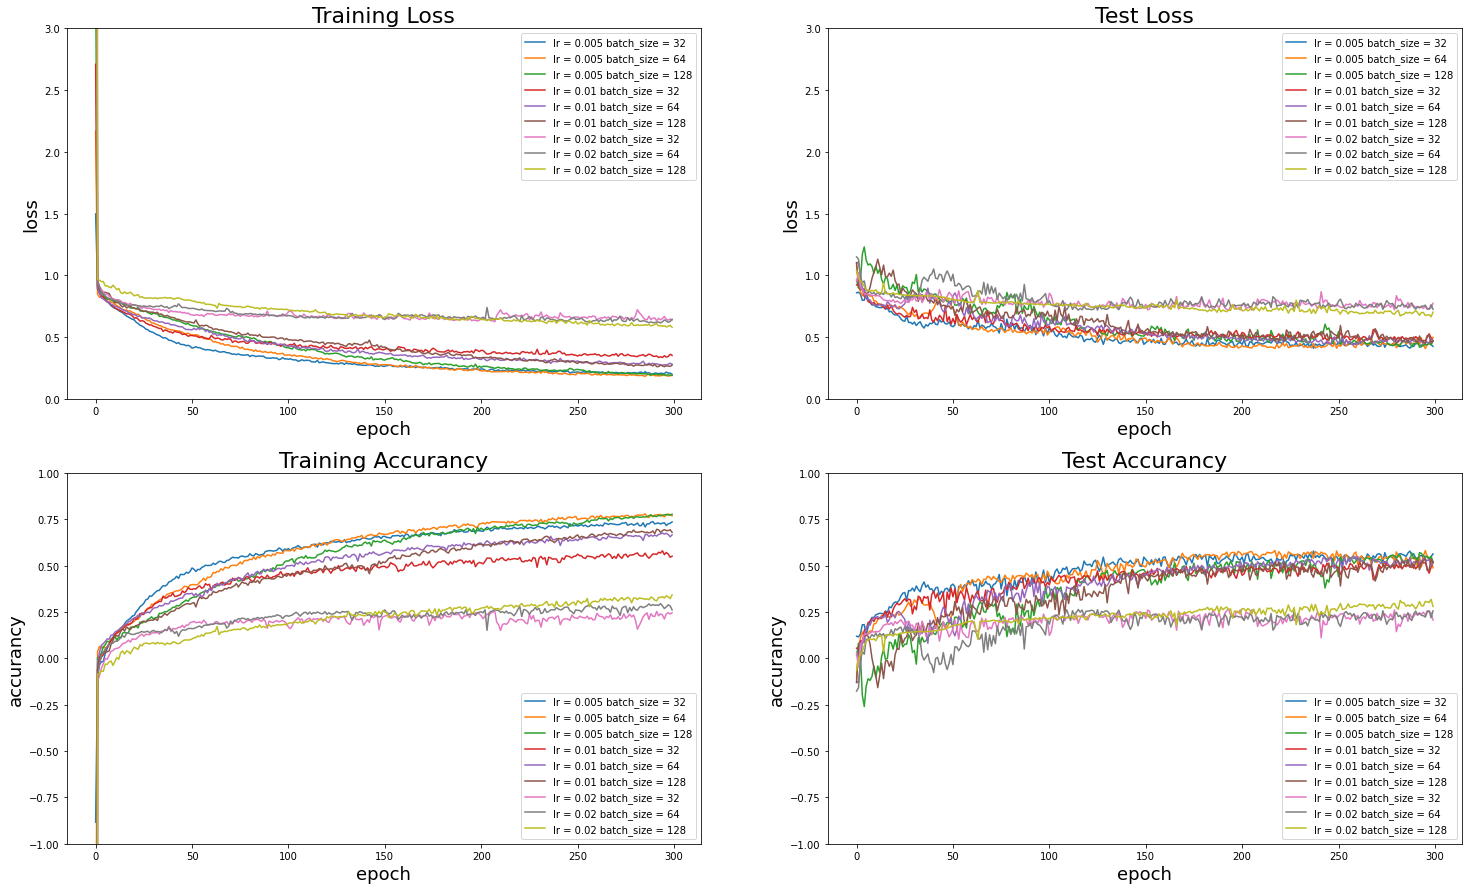

<Figure size 1800x1080 with 0 Axes>

In [20]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.005 batch_size = 128")

    ax.plot(data_list[3],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[4],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[5],label="lr = 0.01 batch_size = 128")
    
    ax.plot(data_list[6],label="lr = 0.02 batch_size = 32")
    ax.plot(data_list[7],label="lr = 0.02 batch_size = 64")
    ax.plot(data_list[8],label="lr = 0.02 batch_size = 128")
    

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Training Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 3])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 3])

ax3.set_title("Training Accurancy", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])

plt.show()

### 3 best models

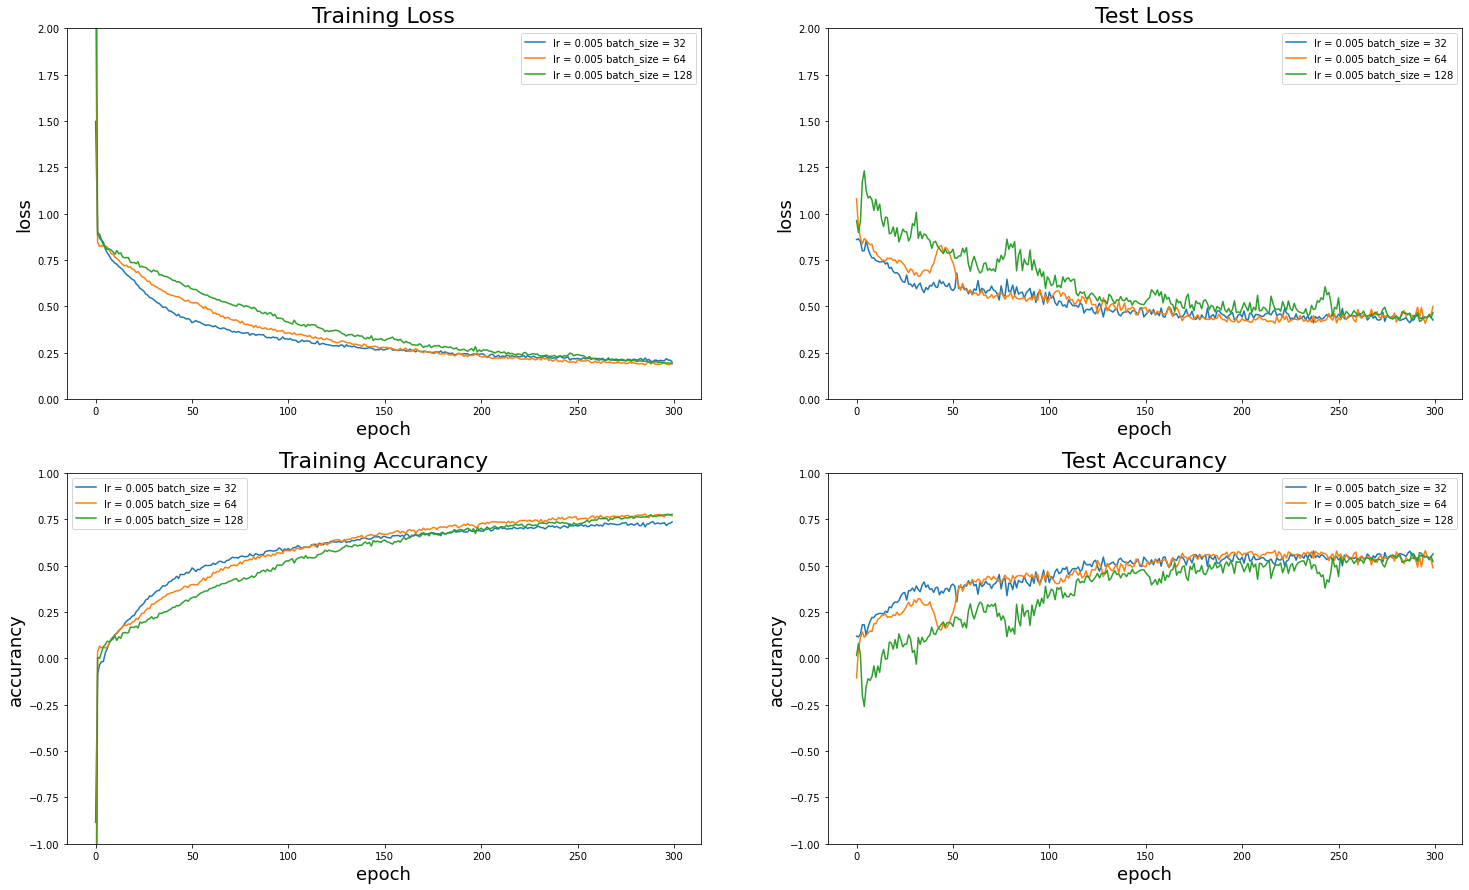

<Figure size 432x288 with 0 Axes>

In [25]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.005 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.005 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 2])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.005 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.005 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

## Training

In [15]:
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []
best_params_all = []
writer = SummaryWriter()

for batch_size in [32, 64, 128]:
    
    model = GraphNeuralNetwork()

    train_loader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = GraphDataLoader(test_dataset, batch_size=2127, shuffle=False)

    epochs = 500
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), 0.005)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_params = {'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
    best_value = 1

    print('Model: batch_size {}'.format(batch_size))

    for epoch in range(1, epochs + 1):

        print('################## EPOCH {} ##################'.format(epoch))

        model.train()
        train_correct = 0
        train_loss = 0

        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            optimizer.zero_grad()
            output = model(x, edge_index, batch)
            loss = criterion(output, torch.Tensor(y))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct/len(train_loader)
        train_accs.append(train_acc)
        writer.add_scalar("Model_{}/Loss/train".format(batch_size), train_loss, epoch)
        writer.add_scalar("Model_{}/R2/train".format(batch_size), train_acc, epoch)
        print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

        model.eval()

        test_loss = 0
        test_correct = 0    

        with torch.no_grad():
            for data in tqdm(test_loader):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                output = model(x, edge_index, batch)
                test_loss += criterion(output, torch.Tensor(y)).item()
                test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_acc =test_correct/len(test_loader)
        test_accs.append(test_acc)

        if test_loss<best_value:
            best_value = test_loss
            torch.save(model.state_dict(), 'models/graph_model_{}.pt'.format(batch_size))
            best_params['batch_size'] = batch_size
            best_params['epoch'] = epoch
            best_params['train_loss'] = train_loss
            best_params['test_loss'] = test_loss
            best_params['train_acc'] = train_acc
            best_params['test_acc'] = test_acc 
        writer.add_scalar("Model_{}/Loss/test".format(batch_size), test_loss, epoch)
        writer.add_scalar("Model_{}/R2/test".format(batch_size), test_acc, epoch)
        print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    train_accs_all.append(train_accs)
    test_accs_all.append(test_accs)
    best_params_all.append(best_params)

writer.flush()
writer.close()
print(best_params_all)

  1%|          | 2/266 [00:00<00:20, 13.01it/s]

Model: batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 1.4341045940729011, Accuracy: -0.7819677632836154


  1%|          | 2/266 [00:00<00:21, 12.21it/s]

Test Avg. loss: 0.8024445176124573, Accuracy: 0.10410731021162989
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.9062749057784116, Accuracy: -0.06974687530362075


  1%|          | 2/266 [00:00<00:18, 14.25it/s]

Test Avg. loss: 0.7722038626670837, Accuracy: 0.13786961424298239
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8612752457086305, Accuracy: -0.01210550857224428


  1%|          | 2/266 [00:00<00:19, 13.81it/s]

Test Avg. loss: 0.7950801253318787, Accuracy: 0.11232934101901115
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.84837068045946, Accuracy: -0.0032478803523827747


  1%|          | 2/266 [00:00<00:18, 14.34it/s]

Test Avg. loss: 0.731980562210083, Accuracy: 0.18277709433174494
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8379297927582174, Accuracy: 0.005370402095269271


  1%|          | 2/266 [00:00<00:17, 15.18it/s]

Test Avg. loss: 0.8323410749435425, Accuracy: 0.0707290787450573
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8007653604324599, Accuracy: 0.055784344101470845


  1%|          | 2/266 [00:00<00:17, 15.15it/s]

Test Avg. loss: 0.8241708278656006, Accuracy: 0.07985083853994035
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7827817629602619, Accuracy: 0.0784435126029105


  1%|          | 2/266 [00:00<00:19, 13.85it/s]

Test Avg. loss: 0.7427362203598022, Accuracy: 0.1707688764461105
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.758038613917236, Accuracy: 0.1095005569449729


  1%|          | 2/266 [00:00<00:19, 13.31it/s]

Test Avg. loss: 0.7215567827224731, Accuracy: 0.19441480101465558
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7403172158209005, Accuracy: 0.12907158378842157


  1%|          | 2/266 [00:00<00:18, 14.06it/s]

Test Avg. loss: 0.7155075073242188, Accuracy: 0.2011684258969203
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7277520470937392, Accuracy: 0.1418258081704685


  1%|          | 2/266 [00:00<00:19, 13.35it/s]

Test Avg. loss: 0.6993883848190308, Accuracy: 0.21916467113056415
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.726433510675018, Accuracy: 0.14633531382200252


  1%|          | 2/266 [00:00<00:21, 12.48it/s]

Test Avg. loss: 0.6879568099975586, Accuracy: 0.23192759490199066
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7132416080711479, Accuracy: 0.16091172088796415


  1%|          | 2/266 [00:00<00:18, 14.38it/s]

Test Avg. loss: 0.6858521699905396, Accuracy: 0.2342773159459276
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7030540915360128, Accuracy: 0.1709593592434681


  1%|          | 2/266 [00:00<00:22, 11.96it/s]

Test Avg. loss: 0.6731821298599243, Accuracy: 0.24842288360095943
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.69333634665586, Accuracy: 0.18425181338344365


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.6701254844665527, Accuracy: 0.251835448453106
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6844999717366427, Accuracy: 0.1938504833233181


  1%|          | 2/266 [00:00<00:19, 13.43it/s]

Test Avg. loss: 0.6609954833984375, Accuracy: 0.2620286543190762
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6725587923835991, Accuracy: 0.20767746253927152


  1%|          | 2/266 [00:00<00:17, 14.76it/s]

Test Avg. loss: 0.6502814888954163, Accuracy: 0.2739904060536943
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6619187025423336, Accuracy: 0.22020100550065821


  1%|          | 2/266 [00:00<00:17, 15.29it/s]

Test Avg. loss: 0.6523187756538391, Accuracy: 0.27171577968533844
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6443993204966524, Accuracy: 0.23517322665993987


  1%|          | 2/266 [00:00<00:19, 13.39it/s]

Test Avg. loss: 0.6277108788490295, Accuracy: 0.29918951160067586
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6384349534834238, Accuracy: 0.24318810785187583


  1%|          | 2/266 [00:00<00:18, 14.27it/s]

Test Avg. loss: 0.6301636099815369, Accuracy: 0.2964510727327181
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6243878082561314, Accuracy: 0.25942728295336903


  1%|          | 2/266 [00:00<00:18, 14.49it/s]

Test Avg. loss: 0.6495192050933838, Accuracy: 0.27484142044967774
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6172669255419782, Accuracy: 0.26505769215013025


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.6182386875152588, Accuracy: 0.30976474576114765
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6127382972578805, Accuracy: 0.2715548659797783


  1%|          | 2/266 [00:00<00:21, 12.28it/s]

Test Avg. loss: 0.5968233942985535, Accuracy: 0.3336738992250913
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5982865320896744, Accuracy: 0.28475695895913194


  1%|          | 2/266 [00:00<00:18, 14.57it/s]

Test Avg. loss: 0.5998274683952332, Accuracy: 0.3303200206690007
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5860289273629511, Accuracy: 0.2981569312784421


  1%|          | 2/266 [00:00<00:20, 13.17it/s]

Test Avg. loss: 0.5811077952384949, Accuracy: 0.35121966482079936
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5800985748270401, Accuracy: 0.30217368602949707


  1%|          | 2/266 [00:00<00:18, 13.90it/s]

Test Avg. loss: 0.6074063777923584, Accuracy: 0.32185846886123304
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5796335570346144, Accuracy: 0.3085654316841497


  1%|          | 2/266 [00:00<00:18, 14.31it/s]

Test Avg. loss: 0.6205204725265503, Accuracy: 0.30721725304193936
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5711053796392634, Accuracy: 0.3136083984236663


  1%|          | 2/266 [00:00<00:20, 12.88it/s]

Test Avg. loss: 0.6061707139015198, Accuracy: 0.323238056250859
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5568485801157198, Accuracy: 0.3323236176959449


  1%|          | 2/266 [00:00<00:19, 13.80it/s]

Test Avg. loss: 0.5697625875473022, Accuracy: 0.36388604299471483
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5555498296941134, Accuracy: 0.33421706966330045


  1%|          | 2/266 [00:00<00:17, 14.98it/s]

Test Avg. loss: 0.5937901735305786, Accuracy: 0.3370603612493731
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.550835035853368, Accuracy: 0.33520045338160614


  1%|          | 2/266 [00:00<00:19, 13.81it/s]

Test Avg. loss: 0.6041398048400879, Accuracy: 0.3255054837241891
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5434772017642968, Accuracy: 0.34232509007212747


  1%|          | 2/266 [00:00<00:19, 13.81it/s]

Test Avg. loss: 0.6625034809112549, Accuracy: 0.26034511991597753
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5387265773532086, Accuracy: 0.3525222768673205


  1%|          | 2/266 [00:00<00:18, 14.37it/s]

Test Avg. loss: 0.6193608641624451, Accuracy: 0.3085118224465859
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.537321725958272, Accuracy: 0.3530722716597107


  1%|          | 2/266 [00:00<00:19, 13.81it/s]

Test Avg. loss: 0.6036410927772522, Accuracy: 0.3260622346596329
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.520956675416993, Accuracy: 0.3744988586291737


  1%|          | 2/266 [00:00<00:18, 14.22it/s]

Test Avg. loss: 0.5702252984046936, Accuracy: 0.3633694674008402
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5138059096564924, Accuracy: 0.3829578877165366


  1%|          | 2/266 [00:00<00:17, 14.84it/s]

Test Avg. loss: 0.5619955062866211, Accuracy: 0.3725577463125811
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5059402555899513, Accuracy: 0.3907516036867967


  1%|          | 2/266 [00:00<00:18, 14.61it/s]

Test Avg. loss: 0.5869728326797485, Accuracy: 0.3446716144140073
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.500357008238036, Accuracy: 0.3971371402486829


  1%|          | 2/266 [00:00<00:18, 14.01it/s]

Test Avg. loss: 0.5531383752822876, Accuracy: 0.38244625406299115
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5067110170883343, Accuracy: 0.3880389532509128


  1%|          | 2/266 [00:00<00:19, 13.44it/s]

Test Avg. loss: 0.5146690607070923, Accuracy: 0.42539548059818544
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5053268981383259, Accuracy: 0.39031986405106606


  1%|          | 2/266 [00:00<00:18, 14.14it/s]

Test Avg. loss: 0.5262325406074524, Accuracy: 0.4124854015483811
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4930497877355805, Accuracy: 0.4046623972814486


  1%|          | 2/266 [00:00<00:18, 14.60it/s]

Test Avg. loss: 0.5003747344017029, Accuracy: 0.44135449085062395
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4813334343016596, Accuracy: 0.4174445201943156


  1%|          | 2/266 [00:00<00:18, 14.67it/s]

Test Avg. loss: 0.530779242515564, Accuracy: 0.4074092088679627
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4772264232536904, Accuracy: 0.4199278487551833


  1%|          | 2/266 [00:00<00:18, 14.45it/s]

Test Avg. loss: 0.5126234292984009, Accuracy: 0.42767939002317945
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.473388412337106, Accuracy: 0.42468107245990466


  1%|          | 2/266 [00:00<00:18, 14.55it/s]

Test Avg. loss: 0.5142379999160767, Accuracy: 0.4258767642956469
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.47347527350250046, Accuracy: 0.42403998854250935


  1%|          | 2/266 [00:00<00:18, 14.51it/s]

Test Avg. loss: 0.501750648021698, Accuracy: 0.43981829189389343
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4673112124148616, Accuracy: 0.4306816352675972


  1%|          | 2/266 [00:00<00:18, 14.31it/s]

Test Avg. loss: 0.5349234938621521, Accuracy: 0.4027823585080951
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4663342982530594, Accuracy: 0.4339512908045442


  1%|          | 2/266 [00:00<00:18, 14.00it/s]

Test Avg. loss: 0.5142481923103333, Accuracy: 0.4258653060899562
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.45636976980849314, Accuracy: 0.43922669574759754


  1%|          | 2/266 [00:00<00:17, 14.71it/s]

Test Avg. loss: 0.5042826533317566, Accuracy: 0.4369914337719729
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46032397056880753, Accuracy: 0.43964287269173064


  1%|          | 2/266 [00:00<00:19, 13.56it/s]

Test Avg. loss: 0.4993731677532196, Accuracy: 0.44247261707260943
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.44841090007159945, Accuracy: 0.44979395005680567


  1%|          | 2/266 [00:00<00:18, 14.45it/s]

Test Avg. loss: 0.485981822013855, Accuracy: 0.4574234831751204
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4406887533185177, Accuracy: 0.4613415947346931


  1%|          | 2/266 [00:00<00:20, 12.60it/s]

Test Avg. loss: 0.49935296177864075, Accuracy: 0.442495224751578
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4446357540730247, Accuracy: 0.4556551842444218


  1%|          | 2/266 [00:00<00:18, 14.40it/s]

Test Avg. loss: 0.5047259330749512, Accuracy: 0.436496567557207
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4401928134038484, Accuracy: 0.46131561364630547


  1%|          | 2/266 [00:00<00:17, 14.79it/s]

Test Avg. loss: 0.4905741214752197, Accuracy: 0.45229639606267835
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4390011446592503, Accuracy: 0.46239581010444913


  1%|          | 2/266 [00:00<00:21, 12.56it/s]

Test Avg. loss: 0.4781714677810669, Accuracy: 0.4661433681067785
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4277946513174172, Accuracy: 0.47688760930244517


  1%|          | 2/266 [00:00<00:18, 13.94it/s]

Test Avg. loss: 0.48020482063293457, Accuracy: 0.46387324292831533
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4328448198231539, Accuracy: 0.46771479990132425


  1%|          | 2/266 [00:00<00:17, 14.97it/s]

Test Avg. loss: 0.5009214878082275, Accuracy: 0.4407440137753871
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42575624058569284, Accuracy: 0.47578108377377754


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.47429364919662476, Accuracy: 0.47047279428213684
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4235331810506663, Accuracy: 0.47779796558399606


  1%|          | 2/266 [00:00<00:19, 13.34it/s]

Test Avg. loss: 0.48987776041030884, Accuracy: 0.45307384812204754
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41944905997891174, Accuracy: 0.4804239727552163


  1%|          | 2/266 [00:00<00:19, 13.71it/s]

Test Avg. loss: 0.48352205753326416, Accuracy: 0.4601696724805394
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41537497825640485, Accuracy: 0.4878944662082442


  1%|          | 2/266 [00:00<00:17, 15.30it/s]

Test Avg. loss: 0.49840497970581055, Accuracy: 0.44355357422792896
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.41861359567794587, Accuracy: 0.4827528442332316


  1%|          | 2/266 [00:00<00:18, 14.56it/s]

Test Avg. loss: 0.47900310158729553, Accuracy: 0.4652148826834559
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4210731842576113, Accuracy: 0.47967534040875276


  1%|          | 2/266 [00:00<00:20, 13.11it/s]

Test Avg. loss: 0.47811180353164673, Accuracy: 0.4662100038036705
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4064351590000149, Accuracy: 0.49693721257139956


  1%|          | 2/266 [00:00<00:17, 14.91it/s]

Test Avg. loss: 0.47688525915145874, Accuracy: 0.4675793645976777
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.414697873189037, Accuracy: 0.48717648854536616


  1%|          | 2/266 [00:00<00:19, 13.62it/s]

Test Avg. loss: 0.4614858627319336, Accuracy: 0.48477206297447706
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40524591275847943, Accuracy: 0.49971564080440317


  1%|          | 2/266 [00:00<00:18, 13.93it/s]

Test Avg. loss: 0.46469858288764954, Accuracy: 0.48118521617864574
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40065622391333255, Accuracy: 0.5032202284963607


  1%|          | 2/266 [00:00<00:19, 13.89it/s]

Test Avg. loss: 0.4556434154510498, Accuracy: 0.49129496697781894
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39941730064557013, Accuracy: 0.5093113526031239


  1%|          | 2/266 [00:00<00:18, 14.44it/s]

Test Avg. loss: 0.47147682309150696, Accuracy: 0.4736176438646691
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40035837939135116, Accuracy: 0.506247386974039


  1%|          | 2/266 [00:00<00:18, 14.28it/s]

Test Avg. loss: 0.5060721039772034, Accuracy: 0.4349935675844475
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.40344977586117003, Accuracy: 0.49886995563035963


  1%|          | 2/266 [00:00<00:17, 14.90it/s]

Test Avg. loss: 0.4658377468585968, Accuracy: 0.47991337918466526
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3894869372584766, Accuracy: 0.5155447711093021


  1%|          | 2/266 [00:00<00:19, 13.36it/s]

Test Avg. loss: 0.47491487860679626, Accuracy: 0.4697791728176979
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38319042882412896, Accuracy: 0.5236070036453404


  1%|          | 2/266 [00:00<00:18, 14.28it/s]

Test Avg. loss: 0.4517539441585541, Accuracy: 0.495637418021432
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.38481178823718454, Accuracy: 0.5235607134685245


  1%|          | 2/266 [00:00<00:19, 13.81it/s]

Test Avg. loss: 0.4654593765735626, Accuracy: 0.4803358363019745
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37720872585038495, Accuracy: 0.529003244268638


  1%|          | 2/266 [00:00<00:18, 14.32it/s]

Test Avg. loss: 0.4633779227733612, Accuracy: 0.48265965362216967
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3776061295118547, Accuracy: 0.5294790134513776


  1%|          | 2/266 [00:00<00:17, 15.31it/s]

Test Avg. loss: 0.4744877517223358, Accuracy: 0.47025607794662794
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3768312426606067, Accuracy: 0.5299937495086481


  1%|          | 2/266 [00:00<00:16, 15.72it/s]

Test Avg. loss: 0.4685005843639374, Accuracy: 0.47694051183915576
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3705699034035206, Accuracy: 0.5361653049843617


  1%|          | 2/266 [00:00<00:18, 13.90it/s]

Test Avg. loss: 0.48736459016799927, Accuracy: 0.45587962788774683
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3757553766376542, Accuracy: 0.53226467580144


  1%|          | 2/266 [00:00<00:18, 14.56it/s]

Test Avg. loss: 0.459613561630249, Accuracy: 0.4868624468862375
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3776059403903502, Accuracy: 0.5322054598711922


  1%|          | 2/266 [00:00<00:16, 15.64it/s]

Test Avg. loss: 0.4547770619392395, Accuracy: 0.4922621776594287
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3637731123743649, Accuracy: 0.5458437558485945


  1%|          | 2/266 [00:00<00:18, 14.64it/s]

Test Avg. loss: 0.45529264211654663, Accuracy: 0.49168649833152245
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36801424967055035, Accuracy: 0.5404230202336542


  1%|          | 2/266 [00:00<00:20, 12.58it/s]

Test Avg. loss: 0.4394359290599823, Accuracy: 0.509389791240842
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36680109034243386, Accuracy: 0.5445553659277544


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.441413015127182, Accuracy: 0.5071825016280169
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3663484523058834, Accuracy: 0.5421218655878166


  1%|          | 2/266 [00:00<00:17, 14.78it/s]

Test Avg. loss: 0.452806293964386, Accuracy: 0.49446243114695754
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36426197720649545, Accuracy: 0.5491474955653955


  1%|          | 2/266 [00:00<00:18, 14.52it/s]

Test Avg. loss: 0.45868197083473206, Accuracy: 0.4879024799843694
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36656211921595094, Accuracy: 0.5434401453368419


  1%|          | 2/266 [00:00<00:18, 14.40it/s]

Test Avg. loss: 0.4494996666908264, Accuracy: 0.4981541324840759
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3676812066171402, Accuracy: 0.5467821370884078


  1%|          | 2/266 [00:00<00:18, 14.08it/s]

Test Avg. loss: 0.44762399792671204, Accuracy: 0.500248203396672
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3468810209542289, Accuracy: 0.5655617969455095


  1%|          | 2/266 [00:00<00:18, 13.98it/s]

Test Avg. loss: 0.44408899545669556, Accuracy: 0.5041948392094805
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3515332407297048, Accuracy: 0.5578170582333811


  1%|          | 2/266 [00:00<00:17, 14.71it/s]

Test Avg. loss: 0.44630104303359985, Accuracy: 0.5017252495128909
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35076543957667244, Accuracy: 0.5613078047606483


  1%|          | 2/266 [00:00<00:18, 14.21it/s]

Test Avg. loss: 0.45119166374206543, Accuracy: 0.49626508508544465
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34985199416602464, Accuracy: 0.5620790727799544


  1%|          | 2/266 [00:00<00:20, 12.66it/s]

Test Avg. loss: 0.44384974241256714, Accuracy: 0.5044620268154647
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3539884780022435, Accuracy: 0.5560751501157166


  1%|          | 2/266 [00:00<00:18, 14.11it/s]

Test Avg. loss: 0.44241994619369507, Accuracy: 0.5060582855287661
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3496621358103322, Accuracy: 0.5639292624790873


  1%|          | 2/266 [00:00<00:17, 14.77it/s]

Test Avg. loss: 0.45757007598876953, Accuracy: 0.48914388683602983
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3487505341382851, Accuracy: 0.5626320137889664


  1%|          | 2/266 [00:00<00:19, 13.70it/s]

Test Avg. loss: 0.4496253728866577, Accuracy: 0.4980137663084888
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3534751633616318, Accuracy: 0.560663405628262


  1%|          | 2/266 [00:00<00:18, 14.58it/s]

Test Avg. loss: 0.43908482789993286, Accuracy: 0.5097818332177073
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3420899075112845, Accuracy: 0.5718616855963092


  1%|          | 2/266 [00:00<00:18, 14.04it/s]

Test Avg. loss: 0.4567549228668213, Accuracy: 0.4900539628059728
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34120939733614597, Accuracy: 0.5724101339648019


  1%|          | 2/266 [00:00<00:16, 15.54it/s]

Test Avg. loss: 0.44103261828422546, Accuracy: 0.5076072326598771
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34074125094409274, Accuracy: 0.5733179829716919


  1%|          | 2/266 [00:00<00:18, 14.57it/s]

Test Avg. loss: 0.42360007762908936, Accuracy: 0.527069871861966
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33814778383401106, Accuracy: 0.5768317099252054


  1%|          | 2/266 [00:00<00:18, 14.56it/s]

Test Avg. loss: 0.432012677192688, Accuracy: 0.5176775109584938
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33333805410709594, Accuracy: 0.5823154927957732


  1%|          | 2/266 [00:00<00:18, 14.50it/s]

Test Avg. loss: 0.45648476481437683, Accuracy: 0.4903556034879638
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3327504462541494, Accuracy: 0.5829216607660481


  1%|          | 2/266 [00:00<00:18, 14.64it/s]

Test Avg. loss: 0.42862215638160706, Accuracy: 0.5214629220596314
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32824728685550225, Accuracy: 0.5870698706651167


  1%|          | 2/266 [00:00<00:18, 14.55it/s]

Test Avg. loss: 0.4214620292186737, Accuracy: 0.5294568835028755
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.326726992971691, Accuracy: 0.5890459626280745


  1%|          | 2/266 [00:00<00:20, 13.14it/s]

Test Avg. loss: 0.43056967854499817, Accuracy: 0.5192885635058648
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33464150436054496, Accuracy: 0.5787071078546371


  1%|          | 2/266 [00:00<00:18, 14.05it/s]

Test Avg. loss: 0.4172409176826477, Accuracy: 0.5341696046509377
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33206982560511816, Accuracy: 0.5832587656215992


  1%|          | 2/266 [00:00<00:21, 12.43it/s]

Test Avg. loss: 0.43981030583381653, Accuracy: 0.508971889841996
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3234218022036821, Accuracy: 0.592540208720844


  1%|          | 2/266 [00:00<00:19, 13.73it/s]

Test Avg. loss: 0.4437352418899536, Accuracy: 0.5045898167288637
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34156638899243863, Accuracy: 0.5723467274568788


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.41217896342277527, Accuracy: 0.5398210299877468
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3282749703280011, Accuracy: 0.5872771269490831


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.4175208806991577, Accuracy: 0.5338570152685708
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3232195103975167, Accuracy: 0.5914978435995145


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.4076317250728607, Accuracy: 0.5448977848953983
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3301651702731624, Accuracy: 0.5861891552486189


  1%|          | 2/266 [00:00<00:18, 14.33it/s]

Test Avg. loss: 0.41482046246528625, Accuracy: 0.5368718843774516
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32493361665454124, Accuracy: 0.5898862719723023


  1%|          | 2/266 [00:00<00:18, 14.00it/s]

Test Avg. loss: 0.41741427779197693, Accuracy: 0.5339760176783273
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31943614836922263, Accuracy: 0.5977670592519201


  1%|          | 2/266 [00:00<00:17, 14.70it/s]

Test Avg. loss: 0.43456336855888367, Accuracy: 0.5148298334895882
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3149399943649769, Accuracy: 0.6014158414582479


  1%|          | 2/266 [00:00<00:17, 15.10it/s]

Test Avg. loss: 0.42908552289009094, Accuracy: 0.5209455814605632
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32186694644895714, Accuracy: 0.5926073427620412


  1%|          | 2/266 [00:00<00:17, 15.09it/s]

Test Avg. loss: 0.41849496960639954, Accuracy: 0.5327694346151761
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3217844782131059, Accuracy: 0.5923322937435448


  1%|          | 2/266 [00:00<00:18, 14.40it/s]

Test Avg. loss: 0.40699875354766846, Accuracy: 0.5456044576864767
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3128300043369146, Accuracy: 0.6065147635390594


  1%|          | 2/266 [00:00<00:18, 14.51it/s]

Test Avg. loss: 0.4068075120449066, Accuracy: 0.5458179519767493
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31092770386459234, Accuracy: 0.6097941786273342


  1%|          | 2/266 [00:00<00:18, 14.23it/s]

Test Avg. loss: 0.4037005305290222, Accuracy: 0.5492868115211693
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31324084478437453, Accuracy: 0.604654452077844


  1%|          | 2/266 [00:00<00:19, 13.75it/s]

Test Avg. loss: 0.4158060848712921, Accuracy: 0.5357714758347418
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31390074819774555, Accuracy: 0.606507351302342


  1%|          | 2/266 [00:00<00:18, 14.56it/s]

Test Avg. loss: 0.4158540666103363, Accuracy: 0.5357179002366936
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3088159659191182, Accuracy: 0.6098508866519766


  1%|          | 2/266 [00:00<00:18, 13.95it/s]

Test Avg. loss: 0.41540026664733887, Accuracy: 0.536224536315143
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.305267092456719, Accuracy: 0.6133570382478478


  1%|          | 2/266 [00:00<00:17, 14.72it/s]

Test Avg. loss: 0.45500317215919495, Accuracy: 0.49200972113099783
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3112309685158998, Accuracy: 0.6068688949003074


  1%|          | 2/266 [00:00<00:17, 14.75it/s]

Test Avg. loss: 0.3978715240955353, Accuracy: 0.5557946242547027
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3031676830653858, Accuracy: 0.6155435923852238


  1%|          | 2/266 [00:00<00:17, 15.39it/s]

Test Avg. loss: 0.4057924747467041, Accuracy: 0.546951207819454
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.307701557650602, Accuracy: 0.6097193235127135


  1%|          | 2/266 [00:00<00:18, 14.42it/s]

Test Avg. loss: 0.414993554353714, Accuracy: 0.5366786248569531
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30744031505813274, Accuracy: 0.611533989022815


  1%|          | 2/266 [00:00<00:18, 13.93it/s]

Test Avg. loss: 0.3881540894508362, Accuracy: 0.5666436917110909
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3048732237316164, Accuracy: 0.6119672899154251


  1%|          | 2/266 [00:00<00:17, 14.76it/s]

Test Avg. loss: 0.39467084407806396, Accuracy: 0.5593679872479677
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2976052665004605, Accuracy: 0.6231224264054706


  1%|          | 2/266 [00:00<00:16, 15.62it/s]

Test Avg. loss: 0.3896470367908478, Accuracy: 0.564976897894418
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2968731304924739, Accuracy: 0.6238010174445469


  1%|          | 2/266 [00:00<00:17, 15.07it/s]

Test Avg. loss: 0.4137873649597168, Accuracy: 0.5380252810308876
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30359208233710516, Accuracy: 0.6164066915910427


  1%|          | 2/266 [00:00<00:18, 14.39it/s]

Test Avg. loss: 0.39790821075439453, Accuracy: 0.5557536433684105
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30012837038340423, Accuracy: 0.6199066599346051


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.39483609795570374, Accuracy: 0.5591835229952042
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2977961069323066, Accuracy: 0.6245712250161428


  1%|          | 2/266 [00:00<00:16, 15.56it/s]

Test Avg. loss: 0.4002412259578705, Accuracy: 0.5531489232027373
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2947996545835097, Accuracy: 0.6249941385212271


  1%|          | 2/266 [00:00<00:19, 13.54it/s]

Test Avg. loss: 0.38735947012901306, Accuracy: 0.5675308009553153
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2932345144226587, Accuracy: 0.6282297075085617


  1%|          | 2/266 [00:00<00:17, 15.30it/s]

Test Avg. loss: 0.39748841524124146, Accuracy: 0.5562222504586565
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2943998942137661, Accuracy: 0.6275468754588385


  1%|          | 2/266 [00:00<00:17, 15.15it/s]

Test Avg. loss: 0.3897491693496704, Accuracy: 0.5648628185619395
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29601449110454187, Accuracy: 0.6232121817701409


  1%|          | 2/266 [00:00<00:20, 12.88it/s]

Test Avg. loss: 0.4073580503463745, Accuracy: 0.545203292139609
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29344982774297995, Accuracy: 0.629999036819827


  1%|          | 2/266 [00:00<00:18, 14.07it/s]

Test Avg. loss: 0.40078625082969666, Accuracy: 0.5525404030306729
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29554259726651627, Accuracy: 0.6240566584608429


  1%|          | 2/266 [00:00<00:19, 13.41it/s]

Test Avg. loss: 0.39902108907699585, Accuracy: 0.5545111752877445
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29108166114840295, Accuracy: 0.6345968418707015


  1%|          | 2/266 [00:00<00:18, 14.25it/s]

Test Avg. loss: 0.4114029109477997, Accuracy: 0.5406874274013371
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29442273937445834, Accuracy: 0.6283117083423287


  1%|          | 2/266 [00:00<00:19, 13.67it/s]

Test Avg. loss: 0.386760950088501, Accuracy: 0.5681989981052895
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.290027290666686, Accuracy: 0.6331166587374844


  1%|          | 2/266 [00:00<00:17, 15.15it/s]

Test Avg. loss: 0.38514286279678345, Accuracy: 0.5700055739137446
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28260520274253714, Accuracy: 0.6431796848711141


  1%|          | 2/266 [00:00<00:18, 14.37it/s]

Test Avg. loss: 0.3971004784107208, Accuracy: 0.556655436093298
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2869143270348248, Accuracy: 0.6383154484105223


  1%|          | 2/266 [00:00<00:21, 12.40it/s]

Test Avg. loss: 0.38736972212791443, Accuracy: 0.5675193638599914
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2820311769899121, Accuracy: 0.6428219462750757


  1%|          | 2/266 [00:00<00:18, 14.55it/s]

Test Avg. loss: 0.4184468388557434, Accuracy: 0.5328232127907847
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28507942535487335, Accuracy: 0.6403979269333704


  1%|          | 2/266 [00:00<00:18, 14.59it/s]

Test Avg. loss: 0.4097624123096466, Accuracy: 0.5425189737102136
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28248531175287145, Accuracy: 0.6426015102714459


  1%|          | 2/266 [00:00<00:17, 15.35it/s]

Test Avg. loss: 0.4105861186981201, Accuracy: 0.5415993429247465
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2875603946079885, Accuracy: 0.63613279155024


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.390357106924057, Accuracy: 0.5641840944859771
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2858510882894796, Accuracy: 0.633442222789038


  1%|          | 2/266 [00:00<00:20, 13.16it/s]

Test Avg. loss: 0.3783472776412964, Accuracy: 0.5775925098826737
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28001293845306663, Accuracy: 0.6441860730630209


  1%|          | 2/266 [00:00<00:16, 16.37it/s]

Test Avg. loss: 0.3935604691505432, Accuracy: 0.5606076462772946
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2821850789836923, Accuracy: 0.6425250037789273


  1%|          | 2/266 [00:00<00:18, 14.66it/s]

Test Avg. loss: 0.4040525257587433, Accuracy: 0.5488938096228586
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2843520656452143, Accuracy: 0.6385452246854233


  1%|          | 2/266 [00:00<00:18, 14.57it/s]

Test Avg. loss: 0.38510051369667053, Accuracy: 0.5700528674329203
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2815168871635333, Accuracy: 0.6423159983556341


  1%|          | 2/266 [00:00<00:20, 13.20it/s]

Test Avg. loss: 0.3815033435821533, Accuracy: 0.574068941632973
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2799514425372271, Accuracy: 0.6454364534404708


  1%|          | 2/266 [00:00<00:16, 15.68it/s]

Test Avg. loss: 0.3941793441772461, Accuracy: 0.5599167433381487
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2785261941975669, Accuracy: 0.6471950170395298


  1%|          | 2/266 [00:00<00:18, 14.60it/s]

Test Avg. loss: 0.4125155210494995, Accuracy: 0.5394452301222379
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28094657785014104, Accuracy: 0.642769908586138


  1%|          | 2/266 [00:00<00:19, 13.47it/s]

Test Avg. loss: 0.38533830642700195, Accuracy: 0.5697873675569932
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.285180115610137, Accuracy: 0.6389946657131219


  1%|          | 2/266 [00:00<00:19, 13.38it/s]

Test Avg. loss: 0.4149179458618164, Accuracy: 0.5367630514186701
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27239032801156654, Accuracy: 0.6528781204385953


  1%|          | 2/266 [00:00<00:17, 14.76it/s]

Test Avg. loss: 0.3878585696220398, Accuracy: 0.5669736454081178
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2708552189003256, Accuracy: 0.6537932986540348


  1%|          | 2/266 [00:00<00:21, 12.50it/s]

Test Avg. loss: 0.3861277401447296, Accuracy: 0.5689060155773078
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26767604974539655, Accuracy: 0.661502092812702


  1%|          | 2/266 [00:00<00:18, 14.25it/s]

Test Avg. loss: 0.388905793428421, Accuracy: 0.5658044204804602
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26818929990767537, Accuracy: 0.6619655790136947


  1%|          | 2/266 [00:00<00:19, 13.84it/s]

Test Avg. loss: 0.3849252164363861, Accuracy: 0.5702485280641151
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27379012992955687, Accuracy: 0.6525243081878912


  1%|          | 2/266 [00:00<00:19, 13.27it/s]

Test Avg. loss: 0.38471242785453796, Accuracy: 0.5704861393374554
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26932521528543385, Accuracy: 0.6576669247796484


  1%|          | 2/266 [00:00<00:19, 13.85it/s]

Test Avg. loss: 0.3906196057796478, Accuracy: 0.5638910615245047
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27091061253856896, Accuracy: 0.6536383619155399


  1%|          | 2/266 [00:00<00:18, 14.06it/s]

Test Avg. loss: 0.3804267942905426, Accuracy: 0.575270859997913
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2731538974869072, Accuracy: 0.6531698119653997


  1%|          | 2/266 [00:00<00:19, 13.72it/s]

Test Avg. loss: 0.3914078176021576, Accuracy: 0.5630110332596316
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2666819053316923, Accuracy: 0.6639643790528937


  1%|          | 2/266 [00:00<00:17, 15.12it/s]

Test Avg. loss: 0.39150384068489075, Accuracy: 0.5629037784375925
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26581255346536636, Accuracy: 0.662768989586992


  1%|          | 2/266 [00:00<00:18, 14.22it/s]

Test Avg. loss: 0.4139441251754761, Accuracy: 0.5378502355093859
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.269367139870511, Accuracy: 0.660935455076135


  1%|          | 2/266 [00:00<00:18, 14.63it/s]

Test Avg. loss: 0.3930499255657196, Accuracy: 0.5611776327294851
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26425814440936074, Accuracy: 0.6643874155122134


  1%|          | 2/266 [00:00<00:18, 14.60it/s]

Test Avg. loss: 0.38574743270874023, Accuracy: 0.5693305759737295
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27386806964089994, Accuracy: 0.6543825778896166


  1%|          | 2/266 [00:00<00:17, 15.20it/s]

Test Avg. loss: 0.40531760454177856, Accuracy: 0.5474813736847848
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2656229432476194, Accuracy: 0.661587972385683


  1%|          | 2/266 [00:00<00:17, 15.30it/s]

Test Avg. loss: 0.3981056809425354, Accuracy: 0.555533162047655
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27243454552682717, Accuracy: 0.6550557720596416


  1%|          | 2/266 [00:00<00:20, 13.06it/s]

Test Avg. loss: 0.39266902208328247, Accuracy: 0.5616029489981951
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2680741871490066, Accuracy: 0.6583811118855348


  1%|          | 2/266 [00:00<00:19, 13.44it/s]

Test Avg. loss: 0.4028921127319336, Accuracy: 0.5501893225968376
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.257616133478127, Accuracy: 0.6750081435757306


  1%|          | 2/266 [00:00<00:18, 14.14it/s]

Test Avg. loss: 0.3955499827861786, Accuracy: 0.5583865206209615
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2675910643056819, Accuracy: 0.6621132017969054


  1%|          | 2/266 [00:00<00:18, 14.13it/s]

Test Avg. loss: 0.39433950185775757, Accuracy: 0.5597378895469354
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2615455042822917, Accuracy: 0.666880775129421


  1%|          | 2/266 [00:00<00:19, 13.63it/s]

Test Avg. loss: 0.37206578254699707, Accuracy: 0.584605501458876
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25609775761464487, Accuracy: 0.6783593807601422


  1%|          | 2/266 [00:00<00:16, 15.87it/s]

Test Avg. loss: 0.3834160566329956, Accuracy: 0.5719334964783314
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25445905288583354, Accuracy: 0.6776159727779623


  1%|          | 2/266 [00:00<00:20, 13.08it/s]

Test Avg. loss: 0.4018379747867584, Accuracy: 0.5513662329487696
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26121118250197933, Accuracy: 0.6679386462759548


  1%|          | 2/266 [00:00<00:19, 13.27it/s]

Test Avg. loss: 0.41038915514945984, Accuracy: 0.5418192054355433
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2591216755764825, Accuracy: 0.669450633567179


  1%|          | 2/266 [00:00<00:21, 12.17it/s]

Test Avg. loss: 0.39849212765693665, Accuracy: 0.555101687905859
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2596213975010958, Accuracy: 0.6655855756735543


  1%|          | 2/266 [00:00<00:18, 14.05it/s]

Test Avg. loss: 0.3971441984176636, Accuracy: 0.5566066032258447
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26287766686059477, Accuracy: 0.664332144532593


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.4049738645553589, Accuracy: 0.5478651357269075
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2611356518490422, Accuracy: 0.6688385158635018


  1%|          | 2/266 [00:00<00:19, 13.75it/s]

Test Avg. loss: 0.4170455038547516, Accuracy: 0.5343877265300482
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25927884221301045, Accuracy: 0.6686301563049145


  1%|          | 2/266 [00:00<00:18, 14.60it/s]

Test Avg. loss: 0.4187626540660858, Accuracy: 0.5324705700810544
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2559603548475674, Accuracy: 0.6792569570368215


  1%|          | 2/266 [00:00<00:17, 14.84it/s]

Test Avg. loss: 0.40461838245391846, Accuracy: 0.5482620389055711
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25501386966920436, Accuracy: 0.6760498653010528


  1%|          | 2/266 [00:00<00:19, 13.69it/s]

Test Avg. loss: 0.38829267024993896, Accuracy: 0.5664889706716293
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2503800410917379, Accuracy: 0.6843823085314775


  1%|          | 2/266 [00:00<00:22, 11.93it/s]

Test Avg. loss: 0.3879477381706238, Accuracy: 0.5668740498103243
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2562432095016304, Accuracy: 0.6739539090552401


  1%|          | 2/266 [00:00<00:19, 13.68it/s]

Test Avg. loss: 0.4237281084060669, Accuracy: 0.5269268798454879
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24799612730293347, Accuracy: 0.687232123039205


  1%|          | 2/266 [00:00<00:17, 15.36it/s]

Test Avg. loss: 0.41332197189331055, Accuracy: 0.5385448641746506
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2526041343528077, Accuracy: 0.6805688797387315


  1%|          | 2/266 [00:00<00:17, 14.82it/s]

Test Avg. loss: 0.43043410778045654, Accuracy: 0.5194399618011077
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2667772541929008, Accuracy: 0.6604686904370276


  1%|          | 2/266 [00:00<00:19, 13.42it/s]

Test Avg. loss: 0.38711389899253845, Accuracy: 0.5678050155568211
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2584908646216294, Accuracy: 0.676826014978594


  1%|          | 2/266 [00:00<00:17, 14.77it/s]

Test Avg. loss: 0.39403021335601807, Accuracy: 0.5600832265231155
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2525505860777278, Accuracy: 0.6785489014183334


  1%|          | 2/266 [00:00<00:20, 12.92it/s]

Test Avg. loss: 0.3977743983268738, Accuracy: 0.55590306632195
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24802094199379585, Accuracy: 0.6834668130472349


  1%|          | 2/266 [00:00<00:19, 13.78it/s]

Test Avg. loss: 0.3932235538959503, Accuracy: 0.5609838671250689
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24464313114496103, Accuracy: 0.6898208054885797


  1%|          | 2/266 [00:00<00:19, 13.64it/s]

Test Avg. loss: 0.39790934324264526, Accuracy: 0.5557523727424627
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.251812069767848, Accuracy: 0.6812127627259288


  1%|          | 2/266 [00:00<00:18, 14.04it/s]

Test Avg. loss: 0.39051347970962524, Accuracy: 0.5640095094857052
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2502550693382894, Accuracy: 0.6817935149055032


  1%|          | 2/266 [00:00<00:17, 15.13it/s]

Test Avg. loss: 0.3984677195549011, Accuracy: 0.555128993860933
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24481280851072834, Accuracy: 0.6867725232077878


  1%|          | 2/266 [00:00<00:18, 14.13it/s]

Test Avg. loss: 0.4144950211048126, Accuracy: 0.5372352182240192
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2544192047719669, Accuracy: 0.6768279474015971


  1%|          | 2/266 [00:00<00:20, 12.77it/s]

Test Avg. loss: 0.3795669972896576, Accuracy: 0.5762307694761517
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2650889250680916, Accuracy: 0.6616617336896163


  1%|          | 2/266 [00:00<00:17, 15.06it/s]

Test Avg. loss: 0.4182753264904022, Accuracy: 0.5330146767746118
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25226015754436193, Accuracy: 0.684210337238793


  1%|          | 2/266 [00:00<00:17, 14.84it/s]

Test Avg. loss: 0.3769925534725189, Accuracy: 0.5791050116262175
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24498543675456727, Accuracy: 0.6863369284241148


  1%|          | 2/266 [00:00<00:19, 13.54it/s]

Test Avg. loss: 0.42302757501602173, Accuracy: 0.527709080764375
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24313181582698248, Accuracy: 0.6895686261857497


  1%|          | 2/266 [00:00<00:18, 14.16it/s]

Test Avg. loss: 0.3982570171356201, Accuracy: 0.5553641981532327
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23985787895613148, Accuracy: 0.6956428108080202


  1%|          | 2/266 [00:00<00:18, 14.12it/s]

Test Avg. loss: 0.40776127576828003, Accuracy: 0.5447531556442272
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2502637972453035, Accuracy: 0.681091635260026


  1%|          | 2/266 [00:00<00:19, 13.60it/s]

Test Avg. loss: 0.4067363440990448, Accuracy: 0.5458974572872703
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24693719112783447, Accuracy: 0.6866254669311185


  1%|          | 2/266 [00:00<00:19, 13.80it/s]

Test Avg. loss: 0.38552749156951904, Accuracy: 0.5695761250538235
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2528153689564171, Accuracy: 0.6798716433787396


  1%|          | 2/266 [00:00<00:17, 15.19it/s]

Test Avg. loss: 0.3841695785522461, Accuracy: 0.5710922080237343
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24041703169731268, Accuracy: 0.6935891714930232


  1%|          | 2/266 [00:00<00:17, 14.72it/s]

Test Avg. loss: 0.40134531259536743, Accuracy: 0.551916311403543
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24238066506901182, Accuracy: 0.6905371738661776


  1%|          | 2/266 [00:00<00:18, 14.44it/s]

Test Avg. loss: 0.3878955841064453, Accuracy: 0.5669322616937017
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24931656025854268, Accuracy: 0.6851297667697636


  1%|          | 2/266 [00:00<00:20, 13.17it/s]

Test Avg. loss: 0.37569817900657654, Accuracy: 0.5805500893530755
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2502689372776146, Accuracy: 0.6810001579106513


  1%|          | 2/266 [00:00<00:19, 13.60it/s]

Test Avg. loss: 0.41363415122032166, Accuracy: 0.5381963181712415
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24021458611788607, Accuracy: 0.6940778433124586


  1%|          | 2/266 [00:00<00:20, 13.05it/s]

Test Avg. loss: 0.3890919089317322, Accuracy: 0.5655966333433223
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2496575926871676, Accuracy: 0.6862800578417281


  1%|          | 2/266 [00:00<00:21, 12.11it/s]

Test Avg. loss: 0.40766963362693787, Accuracy: 0.5448554302901116
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24174351135927036, Accuracy: 0.6979159063364273


  1%|          | 2/266 [00:00<00:19, 13.23it/s]

Test Avg. loss: 0.3796530067920685, Accuracy: 0.5761347359351768
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23390839789482884, Accuracy: 0.7032882407130618


  1%|          | 2/266 [00:00<00:17, 14.95it/s]

Test Avg. loss: 0.3816300630569458, Accuracy: 0.5739274320148556
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24014026520395637, Accuracy: 0.6954048857253101


  1%|          | 2/266 [00:00<00:18, 14.66it/s]

Test Avg. loss: 0.36790022253990173, Accuracy: 0.5892561308097928
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24543190349761704, Accuracy: 0.6869712788361769


  1%|          | 2/266 [00:00<00:18, 14.25it/s]

Test Avg. loss: 0.40303289890289307, Accuracy: 0.5500321769184262
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24690888452350646, Accuracy: 0.6879020730849407


  1%|          | 2/266 [00:00<00:16, 15.67it/s]

Test Avg. loss: 0.41248515248298645, Accuracy: 0.5394791384265634
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24288023207196616, Accuracy: 0.6899658548736084


  1%|          | 2/266 [00:00<00:19, 13.83it/s]

Test Avg. loss: 0.3848496973514557, Accuracy: 0.570332909451962
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23872009734798194, Accuracy: 0.6964859965368491


  1%|          | 2/266 [00:00<00:17, 14.78it/s]

Test Avg. loss: 0.40266290307044983, Accuracy: 0.550445263244222
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23738704142825945, Accuracy: 0.6992105310493217


  1%|          | 2/266 [00:00<00:17, 14.88it/s]

Test Avg. loss: 0.39075687527656555, Accuracy: 0.5637377609891261
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24255869719654993, Accuracy: 0.6958869145547326


  1%|          | 2/266 [00:00<00:17, 14.77it/s]

Test Avg. loss: 0.3817698061466217, Accuracy: 0.5737714290343672
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2358367165508575, Accuracy: 0.6983140773406175


  1%|          | 2/266 [00:00<00:16, 15.84it/s]

Test Avg. loss: 0.38863614201545715, Accuracy: 0.5661054736229673
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2480830519103018, Accuracy: 0.685738372536168


  1%|          | 2/266 [00:00<00:18, 14.61it/s]

Test Avg. loss: 0.40316057205200195, Accuracy: 0.5498896461153053
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2406208867249184, Accuracy: 0.6961194151325782


  1%|          | 2/266 [00:00<00:17, 14.82it/s]

Test Avg. loss: 0.40356284379959106, Accuracy: 0.5494404960965913
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24062120827629155, Accuracy: 0.6964096751047454


  1%|          | 2/266 [00:00<00:20, 13.08it/s]

Test Avg. loss: 0.41982632875442505, Accuracy: 0.531283076258432
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24554031395486423, Accuracy: 0.6886999648504047


  1%|          | 2/266 [00:00<00:18, 14.44it/s]

Test Avg. loss: 0.39883357286453247, Accuracy: 0.5547205169868297
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23802082349819348, Accuracy: 0.6967572437154496


  1%|          | 2/266 [00:00<00:19, 13.42it/s]

Test Avg. loss: 0.40753883123397827, Accuracy: 0.545001509714008
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23737517475409614, Accuracy: 0.6981666685888527


  1%|          | 2/266 [00:00<00:17, 14.75it/s]

Test Avg. loss: 0.40958213806152344, Accuracy: 0.5427202404115963
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23284096189571502, Accuracy: 0.7042232814172815


  1%|          | 2/266 [00:00<00:18, 14.25it/s]

Test Avg. loss: 0.39541247487068176, Accuracy: 0.5585400207074507
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23216233366078004, Accuracy: 0.7042221754458708


  1%|          | 2/266 [00:00<00:19, 13.55it/s]

Test Avg. loss: 0.39751529693603516, Accuracy: 0.5561923316040915
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22985510374034257, Accuracy: 0.7068567068099372


  1%|          | 2/266 [00:00<00:18, 14.20it/s]

Test Avg. loss: 0.3941763937473297, Accuracy: 0.5599200092560941
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22981390866794085, Accuracy: 0.7075867910503809


  1%|          | 2/266 [00:00<00:18, 14.07it/s]

Test Avg. loss: 0.40346986055374146, Accuracy: 0.5495442747950794
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23807745642567935, Accuracy: 0.6969210144482816


  1%|          | 2/266 [00:00<00:17, 15.21it/s]

Test Avg. loss: 0.3875475525856018, Accuracy: 0.5673208587270939
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23190668679045556, Accuracy: 0.7056295210131103


  1%|          | 2/266 [00:00<00:19, 13.20it/s]

Test Avg. loss: 0.3980768322944641, Accuracy: 0.5555653746612972
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22833011389002764, Accuracy: 0.7111804823514797


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.41346484422683716, Accuracy: 0.5383853633513616
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2422768824306646, Accuracy: 0.6922249873703866


  1%|          | 2/266 [00:00<00:17, 14.87it/s]

Test Avg. loss: 0.37907275557518005, Accuracy: 0.5767825801501381
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2366466659184237, Accuracy: 0.7035973697674803


  1%|          | 2/266 [00:00<00:17, 14.75it/s]

Test Avg. loss: 0.40666916966438293, Accuracy: 0.5459724463769337
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24104940824042587, Accuracy: 0.694923555166861


  1%|          | 2/266 [00:00<00:19, 13.62it/s]

Test Avg. loss: 0.373212993144989, Accuracy: 0.5833247309210211
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23105514338029956, Accuracy: 0.7068586823527161


  1%|          | 2/266 [00:00<00:17, 14.93it/s]

Test Avg. loss: 0.3775175213813782, Accuracy: 0.5785189447591064
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2353944068116353, Accuracy: 0.702622527131373


  1%|          | 2/266 [00:00<00:18, 14.09it/s]

Test Avg. loss: 0.3857472240924835, Accuracy: 0.5693308684025922
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23308602619664112, Accuracy: 0.7030708511612318


  1%|          | 2/266 [00:00<00:21, 12.51it/s]

Test Avg. loss: 0.4056764245033264, Accuracy: 0.547080754328773
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22836621761097944, Accuracy: 0.7123459004656021


  1%|          | 2/266 [00:00<00:19, 13.49it/s]

Test Avg. loss: 0.37379178404808044, Accuracy: 0.5826785664163519
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2282820673925536, Accuracy: 0.7101172377238569


  1%|          | 2/266 [00:00<00:16, 15.76it/s]

Test Avg. loss: 0.3801511228084564, Accuracy: 0.5755786396416459
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23510110627551725, Accuracy: 0.7009962422011468


  1%|          | 2/266 [00:00<00:19, 13.70it/s]

Test Avg. loss: 0.3857167363166809, Accuracy: 0.5693648437481948
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2247075967602712, Accuracy: 0.7166847699408581


  1%|          | 2/266 [00:00<00:17, 15.21it/s]

Test Avg. loss: 0.38209471106529236, Accuracy: 0.5734087122817604
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23398412708053015, Accuracy: 0.7054880715312999


  1%|          | 2/266 [00:00<00:21, 12.53it/s]

Test Avg. loss: 0.3857963979244232, Accuracy: 0.5692759644653036
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22265300339550004, Accuracy: 0.7160229581549282


  1%|          | 2/266 [00:00<00:20, 12.87it/s]

Test Avg. loss: 0.36215245723724365, Accuracy: 0.5956733415921563
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22664262228330276, Accuracy: 0.7156851953853764


  1%|          | 2/266 [00:00<00:19, 13.36it/s]

Test Avg. loss: 0.36780568957328796, Accuracy: 0.5893617067698227
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2238310900397767, Accuracy: 0.7145087296759558


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.39343708753585815, Accuracy: 0.5607454151726745
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2217326476833874, Accuracy: 0.7184503041288679


  1%|          | 2/266 [00:00<00:18, 14.41it/s]

Test Avg. loss: 0.37301892042160034, Accuracy: 0.583541375953346
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22704891860485077, Accuracy: 0.7122676964413798


  1%|          | 2/266 [00:00<00:18, 14.14it/s]

Test Avg. loss: 0.4107351005077362, Accuracy: 0.5414330139598963
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23046157088942995, Accuracy: 0.7114246587461751


  1%|          | 2/266 [00:00<00:18, 14.26it/s]

Test Avg. loss: 0.39388492703437805, Accuracy: 0.560245484386469
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22371200962286247, Accuracy: 0.7161254736202524


  1%|          | 2/266 [00:00<00:19, 13.65it/s]

Test Avg. loss: 0.3826315104961395, Accuracy: 0.572809355254941
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22646374471093478, Accuracy: 0.7132483176873559


  1%|          | 2/266 [00:00<00:21, 12.22it/s]

Test Avg. loss: 0.3920474946498871, Accuracy: 0.5622968752981055
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22452880614402151, Accuracy: 0.7146165128886955


  1%|          | 2/266 [00:00<00:17, 14.72it/s]

Test Avg. loss: 0.3726719617843628, Accuracy: 0.5839287240635224
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23777067921775624, Accuracy: 0.7028274276915492


  1%|          | 2/266 [00:00<00:19, 13.47it/s]

Test Avg. loss: 0.3641408681869507, Accuracy: 0.5934532970349933
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22457106421260456, Accuracy: 0.7143278467571127


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.3806072771549225, Accuracy: 0.5750693618141912
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2280547375461661, Accuracy: 0.7115350378180281


  1%|          | 2/266 [00:00<00:19, 13.87it/s]

Test Avg. loss: 0.36193498969078064, Accuracy: 0.5959161134831775
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22716605363595754, Accuracy: 0.7103380229344642


  1%|          | 2/266 [00:00<00:18, 14.46it/s]

Test Avg. loss: 0.39601144194602966, Accuracy: 0.5578712877675289
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21842916839216886, Accuracy: 0.7239012886259657


  1%|          | 2/266 [00:00<00:19, 13.68it/s]

Test Avg. loss: 0.37488311529159546, Accuracy: 0.5814600972005459
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22119256557154476, Accuracy: 0.7199812010852961


  1%|          | 2/266 [00:00<00:18, 14.42it/s]

Test Avg. loss: 0.3817407786846161, Accuracy: 0.5738038175167046
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2241162056929635, Accuracy: 0.7170644660479422


  1%|          | 2/266 [00:00<00:19, 13.32it/s]

Test Avg. loss: 0.3909309506416321, Accuracy: 0.5635434140847768
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22835998786123177, Accuracy: 0.7080950294553888


  1%|          | 2/266 [00:00<00:18, 14.01it/s]

Test Avg. loss: 0.3684280514717102, Accuracy: 0.5886669122590855
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2246723566904552, Accuracy: 0.7168878079571093


  1%|          | 2/266 [00:00<00:19, 13.55it/s]

Test Avg. loss: 0.39782801270484924, Accuracy: 0.5558431668091088
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22833779626490927, Accuracy: 0.7102943020242379


  1%|          | 2/266 [00:00<00:19, 13.48it/s]

Test Avg. loss: 0.40825024247169495, Accuracy: 0.5442072199955117
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22426693662440866, Accuracy: 0.7132730214442364


  1%|          | 2/266 [00:00<00:18, 13.92it/s]

Test Avg. loss: 0.3652687072753906, Accuracy: 0.592194174498489
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22629476585110328, Accuracy: 0.7136492507422687


  1%|          | 2/266 [00:00<00:20, 13.18it/s]

Test Avg. loss: 0.4087042212486267, Accuracy: 0.5437003488710199
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2199183849799902, Accuracy: 0.7203192207640116


  1%|          | 2/266 [00:00<00:20, 13.19it/s]

Test Avg. loss: 0.40801817178726196, Accuracy: 0.5444662756220884
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21695269613449736, Accuracy: 0.7246492913758915


  1%|          | 2/266 [00:00<00:18, 13.94it/s]

Test Avg. loss: 0.39551854133605957, Accuracy: 0.5584216105014228
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21973413761172975, Accuracy: 0.7206954021570496


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.40119680762290955, Accuracy: 0.5520820856985422
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21952260022324727, Accuracy: 0.7210543662975692


  1%|          | 2/266 [00:00<00:18, 14.22it/s]

Test Avg. loss: 0.3777211606502533, Accuracy: 0.5782915610096602
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22631619985502466, Accuracy: 0.7113532447954005


  1%|          | 2/266 [00:00<00:20, 13.15it/s]

Test Avg. loss: 0.3856465220451355, Accuracy: 0.5694432520333619
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2154830630336489, Accuracy: 0.7268471803679916


  1%|          | 2/266 [00:00<00:18, 14.31it/s]

Test Avg. loss: 0.39091724157333374, Accuracy: 0.5635587158424795
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21747578487248348, Accuracy: 0.7257066514983864


  1%|          | 2/266 [00:00<00:19, 13.66it/s]

Test Avg. loss: 0.3693063259124756, Accuracy: 0.5876863422643741
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21780014514250862, Accuracy: 0.7225338596625734


  1%|          | 2/266 [00:00<00:18, 14.45it/s]

Test Avg. loss: 0.3961524963378906, Accuracy: 0.5577138085633221
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2195469835226921, Accuracy: 0.7234563157344446


  1%|          | 2/266 [00:00<00:19, 13.32it/s]

Test Avg. loss: 0.40830445289611816, Accuracy: 0.5441467349700084
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2173713726600758, Accuracy: 0.724491607819235


  1%|          | 2/266 [00:00<00:21, 12.12it/s]

Test Avg. loss: 0.3591640591621399, Accuracy: 0.5990097189728281
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2155779624231776, Accuracy: 0.7257018980225804


  1%|          | 2/266 [00:00<00:18, 13.99it/s]

Test Avg. loss: 0.4022480249404907, Accuracy: 0.5509084280395384
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21257247658152328, Accuracy: 0.7297889582393976


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.37286385893821716, Accuracy: 0.5837145344043103
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21723382463468646, Accuracy: 0.7239408504510074


  1%|          | 2/266 [00:00<00:20, 12.94it/s]

Test Avg. loss: 0.38944631814956665, Accuracy: 0.5652009732940089
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21866691028489207, Accuracy: 0.7206823766435654


  1%|          | 2/266 [00:00<00:20, 12.59it/s]

Test Avg. loss: 0.38278815150260925, Accuracy: 0.5726344950866347
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22502940980003291, Accuracy: 0.7153051205371564


  1%|          | 2/266 [00:00<00:18, 14.32it/s]

Test Avg. loss: 0.3819068372249603, Accuracy: 0.5736184048159101
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21333912824441617, Accuracy: 0.7287517333901871


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.38045570254325867, Accuracy: 0.575238586590225
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21720262924979503, Accuracy: 0.7259739211350693


  1%|          | 2/266 [00:00<00:19, 13.61it/s]

Test Avg. loss: 0.3896389901638031, Accuracy: 0.5649858196369172
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22026132500933526, Accuracy: 0.7196257648068801


  1%|          | 2/266 [00:00<00:20, 12.78it/s]

Test Avg. loss: 0.3807300329208374, Accuracy: 0.5749322628355205
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21806837549727215, Accuracy: 0.7226462968530479


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.38018181920051575, Accuracy: 0.5755443716448939
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2227594910427592, Accuracy: 0.7140433476180632


  1%|          | 2/266 [00:00<00:18, 14.12it/s]

Test Avg. loss: 0.37830522656440735, Accuracy: 0.5776394430905332
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.219936991208478, Accuracy: 0.7203955678412386


  1%|          | 2/266 [00:00<00:19, 13.25it/s]

Test Avg. loss: 0.40561094880104065, Accuracy: 0.5471538895951191
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21387556775059915, Accuracy: 0.726947190167577


  1%|          | 2/266 [00:00<00:21, 12.47it/s]

Test Avg. loss: 0.36822646856307983, Accuracy: 0.5888919508529102
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.212529923710832, Accuracy: 0.726718056032485


  1%|          | 2/266 [00:00<00:22, 11.64it/s]

Test Avg. loss: 0.38004669547080994, Accuracy: 0.5756951838871035
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2091337099559325, Accuracy: 0.7341105776133637


  1%|          | 2/266 [00:00<00:18, 13.91it/s]

Test Avg. loss: 0.3721115291118622, Accuracy: 0.5845544253284509
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2165116992660035, Accuracy: 0.7243823650200099


  1%|          | 2/266 [00:00<00:20, 12.68it/s]

Test Avg. loss: 0.4069629907608032, Accuracy: 0.5456444000155859
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22180268807070597, Accuracy: 0.7155614151736439


  1%|          | 2/266 [00:00<00:19, 13.50it/s]

Test Avg. loss: 0.40174704790115356, Accuracy: 0.5514677282892082
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22058701403158948, Accuracy: 0.7180770972536185


  1%|          | 2/266 [00:00<00:17, 15.24it/s]

Test Avg. loss: 0.38267114758491516, Accuracy: 0.5727651195085826
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2123123430331847, Accuracy: 0.7281291081786252


  1%|          | 2/266 [00:00<00:19, 13.45it/s]

Test Avg. loss: 0.38020384311676025, Accuracy: 0.5755197416203467
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2087826861866883, Accuracy: 0.7367736148479159


  1%|          | 2/266 [00:00<00:19, 13.69it/s]

Test Avg. loss: 0.3745012879371643, Accuracy: 0.5818863454198672
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21027481571344056, Accuracy: 0.7314938442452436


  1%|          | 2/266 [00:00<00:21, 12.29it/s]

Test Avg. loss: 0.3667045533657074, Accuracy: 0.5905910906194964
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21205723773043855, Accuracy: 0.7301208736326987


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.4104176163673401, Accuracy: 0.5417874663216308
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2175836833964165, Accuracy: 0.7214332392834858


  1%|          | 2/266 [00:00<00:18, 13.94it/s]

Test Avg. loss: 0.38726189732551575, Accuracy: 0.5676397670778662
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21581023811061578, Accuracy: 0.7263716401736688


  1%|          | 2/266 [00:00<00:17, 14.72it/s]

Test Avg. loss: 0.4098215401172638, Accuracy: 0.5424530055054638
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20960175946242826, Accuracy: 0.7332585059792146


  1%|          | 2/266 [00:00<00:22, 11.92it/s]

Test Avg. loss: 0.3822535574436188, Accuracy: 0.5732313021906357
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20554669187369204, Accuracy: 0.7377930527851092


  1%|          | 2/266 [00:00<00:19, 13.60it/s]

Test Avg. loss: 0.41257384419441223, Accuracy: 0.5393801161417957
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2139845716914064, Accuracy: 0.7270825415577831


  1%|          | 2/266 [00:00<00:18, 14.21it/s]

Test Avg. loss: 0.39107391238212585, Accuracy: 0.5633837757155258
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2116056036456187, Accuracy: 0.7288195538070497


  1%|          | 2/266 [00:00<00:18, 14.13it/s]

Test Avg. loss: 0.39292553067207336, Accuracy: 0.5613165381049452
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21474595258670642, Accuracy: 0.7268567306521745


  1%|          | 2/266 [00:00<00:20, 13.05it/s]

Test Avg. loss: 0.3814781904220581, Accuracy: 0.5740970216806834
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21643463922734546, Accuracy: 0.7246031017617408


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.39475196599960327, Accuracy: 0.5592773911484281
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2124798431208259, Accuracy: 0.7277522823689391


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.39729025959968567, Accuracy: 0.5564435325722703
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20911898189469388, Accuracy: 0.7345660996360917


  1%|          | 2/266 [00:00<00:19, 13.42it/s]

Test Avg. loss: 0.39292505383491516, Accuracy: 0.5613171298136523
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21296972960681843, Accuracy: 0.7281463577702416


  1%|          | 2/266 [00:00<00:18, 14.49it/s]

Test Avg. loss: 0.4039888083934784, Accuracy: 0.5489649309748418
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21541465412741317, Accuracy: 0.7257666644869059


  1%|          | 2/266 [00:00<00:18, 14.15it/s]

Test Avg. loss: 0.36554548144340515, Accuracy: 0.591885107416195
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20703224000289924, Accuracy: 0.7356710648055461


  1%|          | 2/266 [00:00<00:18, 13.98it/s]

Test Avg. loss: 0.3840842843055725, Accuracy: 0.5711874122149136
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20362514139790283, Accuracy: 0.7417405550229824


  1%|          | 2/266 [00:00<00:20, 12.90it/s]

Test Avg. loss: 0.36395013332366943, Accuracy: 0.5936662956419225
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20652146001619504, Accuracy: 0.7368906285444169


  1%|          | 2/266 [00:00<00:19, 13.28it/s]

Test Avg. loss: 0.3584991693496704, Accuracy: 0.5997520540501386
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2151002437996685, Accuracy: 0.7267603410617185


  1%|          | 2/266 [00:00<00:19, 13.65it/s]

Test Avg. loss: 0.39289602637290955, Accuracy: 0.5613495161288165
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21206396658505713, Accuracy: 0.7312356039026772


  1%|          | 2/266 [00:00<00:18, 14.36it/s]

Test Avg. loss: 0.3672845959663391, Accuracy: 0.5899434942415926
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20681933071324252, Accuracy: 0.7347597894665013


  1%|          | 2/266 [00:00<00:18, 13.90it/s]

Test Avg. loss: 0.36666372418403625, Accuracy: 0.5906367017435843
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2073081911618548, Accuracy: 0.737742243811737


  1%|          | 2/266 [00:00<00:22, 11.97it/s]

Test Avg. loss: 0.3448825180530548, Accuracy: 0.6149543997751112
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20659066070067256, Accuracy: 0.7368467664201536


  1%|          | 2/266 [00:00<00:18, 13.90it/s]

Test Avg. loss: 0.3821549117565155, Accuracy: 0.5733414408452399
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2052383808545152, Accuracy: 0.7394271214898697


  1%|          | 2/266 [00:00<00:18, 14.16it/s]

Test Avg. loss: 0.36713317036628723, Accuracy: 0.5901125974101812
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21608285729150126, Accuracy: 0.7249717890778986


  1%|          | 2/266 [00:00<00:19, 13.68it/s]

Test Avg. loss: 0.3518655598163605, Accuracy: 0.6071581763666487
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20987705779927118, Accuracy: 0.7345061550479022


  1%|          | 2/266 [00:00<00:18, 14.08it/s]

Test Avg. loss: 0.36422595381736755, Accuracy: 0.5933583289632516
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20220667342270227, Accuracy: 0.7437857911754648


  1%|          | 2/266 [00:00<00:20, 13.05it/s]

Test Avg. loss: 0.36294305324554443, Accuracy: 0.594790648780438
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20971372101764033, Accuracy: 0.7333223149298405


  1%|          | 2/266 [00:00<00:20, 13.01it/s]

Test Avg. loss: 0.37547948956489563, Accuracy: 0.5807942739099952
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20933043295727635, Accuracy: 0.7319501157561489


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.4142702519893646, Accuracy: 0.5374861296061583
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21012563171579426, Accuracy: 0.7331280038806227


  1%|          | 2/266 [00:00<00:18, 13.91it/s]

Test Avg. loss: 0.4008391201496124, Accuracy: 0.5524814016481425
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20690175801291502, Accuracy: 0.7364927914121046


  1%|          | 2/266 [00:00<00:18, 14.10it/s]

Test Avg. loss: 0.3591793477535248, Accuracy: 0.5989926216122863
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21379892623290084, Accuracy: 0.7263549268307801


  1%|          | 2/266 [00:00<00:20, 12.99it/s]

Test Avg. loss: 0.3683036267757416, Accuracy: 0.5888057929628134
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21093092704737992, Accuracy: 0.7332648336400924


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.38803163170814514, Accuracy: 0.5667803891684778
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20803310977000938, Accuracy: 0.7338256454972104


  1%|          | 2/266 [00:00<00:20, 13.10it/s]

Test Avg. loss: 0.38163816928863525, Accuracy: 0.5739183674570563
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20694864084734058, Accuracy: 0.7374397149694747


  1%|          | 2/266 [00:00<00:21, 12.07it/s]

Test Avg. loss: 0.3467555642127991, Accuracy: 0.6128632280471151
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2056405507588297, Accuracy: 0.7380924578932291


  1%|          | 2/266 [00:00<00:19, 13.40it/s]

Test Avg. loss: 0.36877551674842834, Accuracy: 0.5882789772740216
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20309096787657058, Accuracy: 0.7413239542398984


  1%|          | 2/266 [00:00<00:19, 13.74it/s]

Test Avg. loss: 0.3800903856754303, Accuracy: 0.5756464217760606
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2020847933520948, Accuracy: 0.7424941044701777


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.3790927827358246, Accuracy: 0.5767602021447212
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20158286186817445, Accuracy: 0.7432003751961344


  1%|          | 2/266 [00:00<00:18, 13.93it/s]

Test Avg. loss: 0.3992904722690582, Accuracy: 0.5542103963915083
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20046612586742057, Accuracy: 0.7467794582404464


  1%|          | 2/266 [00:00<00:19, 13.71it/s]

Test Avg. loss: 0.3800346255302429, Accuracy: 0.5757086634581892
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20668102946496547, Accuracy: 0.7385187975968874


  1%|          | 2/266 [00:00<00:20, 13.03it/s]

Test Avg. loss: 0.387188196182251, Accuracy: 0.5677220216864309
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2056972612731887, Accuracy: 0.7376691099741746


  1%|          | 2/266 [00:00<00:18, 13.96it/s]

Test Avg. loss: 0.36819133162498474, Accuracy: 0.5889311890864019
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2027100320989476, Accuracy: 0.7407711287044498


  1%|          | 2/266 [00:00<00:18, 14.12it/s]

Test Avg. loss: 0.3763781189918518, Accuracy: 0.579790983356399
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21027197215454022, Accuracy: 0.7349435960052391


  1%|          | 2/266 [00:00<00:20, 12.60it/s]

Test Avg. loss: 0.3639970123767853, Accuracy: 0.5936139479771072
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20034778154546157, Accuracy: 0.746045492172366


  1%|          | 2/266 [00:00<00:19, 13.65it/s]

Test Avg. loss: 0.3855491280555725, Accuracy: 0.5695519781162534
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20753184428676627, Accuracy: 0.7360055364637975


  1%|          | 2/266 [00:00<00:18, 14.02it/s]

Test Avg. loss: 0.386093407869339, Accuracy: 0.5689443412399986
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19576116578471392, Accuracy: 0.7526127370386082


  1%|          | 2/266 [00:00<00:21, 12.01it/s]

Test Avg. loss: 0.37197768688201904, Accuracy: 0.584703865609062
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20391875267364926, Accuracy: 0.7409593450237859


  1%|          | 2/266 [00:00<00:19, 13.88it/s]

Test Avg. loss: 0.3667828440666199, Accuracy: 0.5905036777903634
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.205323932370297, Accuracy: 0.739027608968834


  1%|          | 2/266 [00:00<00:22, 11.63it/s]

Test Avg. loss: 0.4139362871646881, Accuracy: 0.5378590027383463
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20651672948571972, Accuracy: 0.7379552626062112


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.3915843963623047, Accuracy: 0.5628138605892029
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20276662712930738, Accuracy: 0.7423186964652564


  1%|          | 2/266 [00:00<00:21, 12.32it/s]

Test Avg. loss: 0.37315070629119873, Accuracy: 0.5833942715845477
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20000165908184267, Accuracy: 0.7460620098923592


  1%|          | 2/266 [00:00<00:20, 13.08it/s]

Test Avg. loss: 0.4000656306743622, Accuracy: 0.5533449412762887
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21360294596481144, Accuracy: 0.7308287212804165


  1%|          | 2/266 [00:00<00:18, 14.40it/s]

Test Avg. loss: 0.36534056067466736, Accuracy: 0.592113957129762
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2133665475574203, Accuracy: 0.730267834005144


  1%|          | 2/266 [00:00<00:19, 13.53it/s]

Test Avg. loss: 0.38474372029304504, Accuracy: 0.570451169788337
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20213991120681726, Accuracy: 0.745571736956769


  1%|          | 2/266 [00:00<00:18, 14.09it/s]

Test Avg. loss: 0.39182931184768677, Accuracy: 0.5625404437247095
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20341047888299577, Accuracy: 0.7433709848962711


  1%|          | 2/266 [00:00<00:19, 13.88it/s]

Test Avg. loss: 0.407856822013855, Accuracy: 0.5446464893760994
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20017188582989506, Accuracy: 0.7471661556628741


  1%|          | 2/266 [00:00<00:18, 14.31it/s]

Test Avg. loss: 0.3804911971092224, Accuracy: 0.5751989626308106
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20014084038093574, Accuracy: 0.7442987671229858


  1%|          | 2/266 [00:00<00:19, 13.74it/s]

Test Avg. loss: 0.3749396502971649, Accuracy: 0.5813969858409804
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19496336929444083, Accuracy: 0.7501000059900278


  1%|          | 2/266 [00:00<00:19, 13.36it/s]

Test Avg. loss: 0.4005949795246124, Accuracy: 0.5527539910365074
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20427008097837293, Accuracy: 0.7425966063668561


  1%|          | 2/266 [00:00<00:21, 12.49it/s]

Test Avg. loss: 0.36854150891304016, Accuracy: 0.5885402013973036
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20461028459993072, Accuracy: 0.7386680064114877


  1%|          | 2/266 [00:00<00:19, 13.39it/s]

Test Avg. loss: 0.38957732915878296, Accuracy: 0.5650547046347574
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20455398577216424, Accuracy: 0.7421506426323127


  1%|          | 2/266 [00:00<00:22, 11.97it/s]

Test Avg. loss: 0.3959532380104065, Accuracy: 0.5579362528560041
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21730159867302815, Accuracy: 0.7263809259213423


  1%|          | 2/266 [00:00<00:21, 12.36it/s]

Test Avg. loss: 0.37732720375061035, Accuracy: 0.5787313899589739
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20277262281598454, Accuracy: 0.7410773106018286


  1%|          | 2/266 [00:00<00:20, 12.72it/s]

Test Avg. loss: 0.39802268147468567, Accuracy: 0.5556258564784573
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19600035282398076, Accuracy: 0.7528009304748765


  1%|          | 2/266 [00:00<00:20, 12.61it/s]

Test Avg. loss: 0.3791734576225281, Accuracy: 0.5766701562497927
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19770446268463493, Accuracy: 0.7482867782587379


  1%|          | 2/266 [00:00<00:19, 13.59it/s]

Test Avg. loss: 0.3695625066757202, Accuracy: 0.5874003309978659
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1977101793806804, Accuracy: 0.7470945285023552


  1%|          | 2/266 [00:00<00:20, 13.13it/s]

Test Avg. loss: 0.3961154818534851, Accuracy: 0.5577551131204224
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19589679915093838, Accuracy: 0.751190377805327


  1%|          | 2/266 [00:00<00:18, 14.11it/s]

Test Avg. loss: 0.39795243740081787, Accuracy: 0.555704310647291
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20300577104763878, Accuracy: 0.7416232392424582


  1%|          | 2/266 [00:00<00:20, 13.11it/s]

Test Avg. loss: 0.39182475209236145, Accuracy: 0.5625455822791787
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2058343465783094, Accuracy: 0.7379408394301177


  1%|          | 2/266 [00:00<00:19, 13.51it/s]

Test Avg. loss: 0.37798425555229187, Accuracy: 0.5779977864705013
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20852283055060788, Accuracy: 0.7375508239730083


  1%|          | 2/266 [00:00<00:18, 14.03it/s]

Test Avg. loss: 0.3683089315891266, Accuracy: 0.5887999046934195
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19575107223669388, Accuracy: 0.7501972673375401


  1%|          | 2/266 [00:00<00:19, 13.66it/s]

Test Avg. loss: 0.3714594542980194, Accuracy: 0.5852824826062921
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20070363651204826, Accuracy: 0.7470761248150437


  1%|          | 2/266 [00:00<00:19, 13.62it/s]

Test Avg. loss: 0.37975266575813293, Accuracy: 0.5760234698051234
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20334483730725775, Accuracy: 0.7426696091591994


  1%|          | 2/266 [00:00<00:19, 13.56it/s]

Test Avg. loss: 0.3610490560531616, Accuracy: 0.5969052123355971
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19506484712649108, Accuracy: 0.7534119074643056


  1%|          | 2/266 [00:00<00:19, 13.80it/s]

Test Avg. loss: 0.36818134784698486, Accuracy: 0.588942353069386
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21231361937926227, Accuracy: 0.7315266605331786


  1%|          | 2/266 [00:00<00:20, 13.14it/s]

Test Avg. loss: 0.3945012092590332, Accuracy: 0.5595573838015975
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2056066338112928, Accuracy: 0.7394644918605556


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.4021596908569336, Accuracy: 0.55100704933522
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19722069970759235, Accuracy: 0.7493579484453331


  1%|          | 2/266 [00:00<00:19, 13.23it/s]

Test Avg. loss: 0.39257851243019104, Accuracy: 0.5617040446974344
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2049776446494393, Accuracy: 0.7396756335882212


  1%|          | 2/266 [00:00<00:18, 14.35it/s]

Test Avg. loss: 0.4025014042854309, Accuracy: 0.55062558272149
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19854580619393436, Accuracy: 0.7465559108858204


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.37340250611305237, Accuracy: 0.5831131597996587
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19614351848910624, Accuracy: 0.7524199909596508


  1%|          | 2/266 [00:00<00:18, 14.62it/s]

Test Avg. loss: 0.3719911277294159, Accuracy: 0.5846888868811424
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19922051671192162, Accuracy: 0.7475087846765305


  1%|          | 2/266 [00:00<00:20, 13.07it/s]

Test Avg. loss: 0.3966995179653168, Accuracy: 0.5571030987101526
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20444030492545517, Accuracy: 0.7417576611630639


  0%|          | 1/266 [00:00<00:26,  9.85it/s]

Test Avg. loss: 0.39469513297080994, Accuracy: 0.5593409008412085
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1956981929733341, Accuracy: 0.7535810977453781


  1%|          | 2/266 [00:00<00:18, 14.26it/s]

Test Avg. loss: 0.3918994963169098, Accuracy: 0.5624620481490896
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1977312479980458, Accuracy: 0.7493833431598834


  1%|          | 2/266 [00:00<00:19, 13.36it/s]

Test Avg. loss: 0.3831527531147003, Accuracy: 0.5722274770293154
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18863570807795776, Accuracy: 0.761284956580587


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.37340638041496277, Accuracy: 0.5831087787109055
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19272302892199136, Accuracy: 0.7570403970502283


  1%|          | 2/266 [00:00<00:21, 12.01it/s]

Test Avg. loss: 0.38252440094947815, Accuracy: 0.5729289661943696
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19409545270123876, Accuracy: 0.7519628501045444


  1%|          | 2/266 [00:00<00:19, 13.84it/s]

Test Avg. loss: 0.35982710123062134, Accuracy: 0.598269525747527
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19433221571091422, Accuracy: 0.7535596591741583


  1%|          | 2/266 [00:00<00:19, 13.35it/s]

Test Avg. loss: 0.3956356644630432, Accuracy: 0.5582908417169934
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20448028182792932, Accuracy: 0.7424976374164698


  1%|          | 2/266 [00:00<00:19, 13.80it/s]

Test Avg. loss: 0.4093042314052582, Accuracy: 0.5430305167816851
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2027943443815063, Accuracy: 0.747774592510179


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.40224161744117737, Accuracy: 0.550915569386691
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20232436108521948, Accuracy: 0.7433052383487765


  1%|          | 2/266 [00:00<00:18, 14.21it/s]

Test Avg. loss: 0.37615078687667847, Accuracy: 0.5800447956768616
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19636526768256848, Accuracy: 0.7492769314761988


  1%|          | 2/266 [00:00<00:19, 13.87it/s]

Test Avg. loss: 0.37787699699401855, Accuracy: 0.5781175880476666
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19735162834027656, Accuracy: 0.7498066277432024


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.39121177792549133, Accuracy: 0.5632298728435954
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19794549099764877, Accuracy: 0.7491620526612187


  1%|          | 2/266 [00:00<00:18, 14.13it/s]

Test Avg. loss: 0.41471031308174133, Accuracy: 0.5369948169067276
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19660376003922375, Accuracy: 0.751331683061563


  1%|          | 2/266 [00:00<00:20, 12.95it/s]

Test Avg. loss: 0.4120222330093384, Accuracy: 0.5399960010904485
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20147129338710829, Accuracy: 0.7454910517483168


  1%|          | 2/266 [00:00<00:18, 14.02it/s]

Test Avg. loss: 0.384674996137619, Accuracy: 0.5705279075993216
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19465350452110283, Accuracy: 0.7531291528941129


  1%|          | 2/266 [00:00<00:18, 14.60it/s]

Test Avg. loss: 0.3907433748245239, Accuracy: 0.5637528150069311
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19932038362200996, Accuracy: 0.74623812111867


  1%|          | 2/266 [00:00<00:19, 13.64it/s]

Test Avg. loss: 0.3776372969150543, Accuracy: 0.5783851430488365
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20386527606139057, Accuracy: 0.7415970622017037


  1%|          | 2/266 [00:00<00:20, 12.91it/s]

Test Avg. loss: 0.3745878338813782, Accuracy: 0.5817897809444916
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2011380275445325, Accuracy: 0.7456527247489962


  1%|          | 2/266 [00:00<00:20, 12.78it/s]

Test Avg. loss: 0.36818036437034607, Accuracy: 0.5889434188766967
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1938586652390939, Accuracy: 0.7531956356968282


  1%|          | 2/266 [00:00<00:21, 12.23it/s]

Test Avg. loss: 0.3764922618865967, Accuracy: 0.5796635487167039
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19633708095976285, Accuracy: 0.750849110322869


  1%|          | 2/266 [00:00<00:18, 13.90it/s]

Test Avg. loss: 0.3827342987060547, Accuracy: 0.5726946016200055
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1927783007740526, Accuracy: 0.753828993274785


  1%|          | 2/266 [00:00<00:19, 13.48it/s]

Test Avg. loss: 0.38420403003692627, Accuracy: 0.571053737760749
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1991948031477238, Accuracy: 0.7480043815740042


  1%|          | 2/266 [00:00<00:20, 13.01it/s]

Test Avg. loss: 0.3862364888191223, Accuracy: 0.5687845829281428
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19668930340418242, Accuracy: 0.7537875151794747


  1%|          | 2/266 [00:00<00:19, 13.82it/s]

Test Avg. loss: 0.39373478293418884, Accuracy: 0.5604131068325325
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19362815980680456, Accuracy: 0.7549835735725658


  1%|          | 2/266 [00:00<00:19, 13.46it/s]

Test Avg. loss: 0.37580960988998413, Accuracy: 0.5804257283742416
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19315917515440992, Accuracy: 0.7526554332355523


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.3773233890533447, Accuracy: 0.5787356447248451
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19680709657924517, Accuracy: 0.7500460977819822


  1%|          | 2/266 [00:00<00:19, 13.48it/s]

Test Avg. loss: 0.3798538148403168, Accuracy: 0.5759105665312625
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20119902718448102, Accuracy: 0.7467451378916186


  1%|          | 2/266 [00:00<00:19, 13.39it/s]

Test Avg. loss: 0.36716803908348083, Accuracy: 0.5900736632764348
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19124127613534606, Accuracy: 0.7589075910965847


  1%|          | 2/266 [00:00<00:19, 13.54it/s]

Test Avg. loss: 0.38366785645484924, Accuracy: 0.571652351843237
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1962681706798704, Accuracy: 0.7485656432859528


  1%|          | 2/266 [00:00<00:20, 13.02it/s]

Test Avg. loss: 0.3708466589450836, Accuracy: 0.5859666317442358
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19437875831149576, Accuracy: 0.7557500866865395


  1%|          | 2/266 [00:00<00:17, 14.89it/s]

Test Avg. loss: 0.40243270993232727, Accuracy: 0.5507022374373743
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19929833585550463, Accuracy: 0.7479892154654164


  1%|          | 2/266 [00:00<00:17, 15.07it/s]

Test Avg. loss: 0.4109034240245819, Accuracy: 0.5412450904445267
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1893705502992734, Accuracy: 0.7603813559810166


  1%|          | 2/266 [00:00<00:19, 13.47it/s]

Test Avg. loss: 0.3815183639526367, Accuracy: 0.574052160143637
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19202621463210062, Accuracy: 0.757405517658149


  1%|          | 2/266 [00:00<00:19, 13.26it/s]

Test Avg. loss: 0.375603586435318, Accuracy: 0.5806557368351124
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19705741023434734, Accuracy: 0.7452425224681916


  1%|          | 2/266 [00:00<00:19, 13.82it/s]

Test Avg. loss: 0.3695220947265625, Accuracy: 0.5874454501838418
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19904230591049768, Accuracy: 0.7514313851825782


  1%|          | 2/266 [00:00<00:18, 13.97it/s]

Test Avg. loss: 0.36064568161964417, Accuracy: 0.5973555131106857
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19872751759183138, Accuracy: 0.7505211668074071


  1%|          | 2/266 [00:00<00:18, 13.92it/s]

Test Avg. loss: 0.3893180787563324, Accuracy: 0.5653441133421963
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19087083185357706, Accuracy: 0.7580625122345361


  1%|          | 2/266 [00:00<00:18, 14.19it/s]

Test Avg. loss: 0.3658246099948883, Accuracy: 0.5915735110121281
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19875850528478622, Accuracy: 0.7467373320247996


  1%|          | 2/266 [00:00<00:18, 14.04it/s]

Test Avg. loss: 0.36721691489219666, Accuracy: 0.5900190671053178
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1859224208987745, Accuracy: 0.7632376333826347


  1%|          | 2/266 [00:00<00:20, 12.99it/s]

Test Avg. loss: 0.40498217940330505, Accuracy: 0.5478558893350092
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19217430842214062, Accuracy: 0.7586731166928005


  1%|          | 2/266 [00:00<00:18, 14.15it/s]

Test Avg. loss: 0.37912115454673767, Accuracy: 0.5767285452194421
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19132484800945548, Accuracy: 0.7549069201777534


  1%|          | 2/266 [00:00<00:19, 13.69it/s]

Test Avg. loss: 0.39626702666282654, Accuracy: 0.5575859436025049
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19622553232357018, Accuracy: 0.7522597052077917


  1%|          | 2/266 [00:00<00:19, 13.78it/s]

Test Avg. loss: 0.38624802231788635, Accuracy: 0.5687717061456261
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19424429778149702, Accuracy: 0.7541297695588955


  1%|          | 2/266 [00:00<00:21, 12.39it/s]

Test Avg. loss: 0.37560099363327026, Accuracy: 0.5806586250821015
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1892800339518633, Accuracy: 0.7596642742767257


  1%|          | 2/266 [00:00<00:18, 14.46it/s]

Test Avg. loss: 0.38515767455101013, Accuracy: 0.5699890569073518
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19102855385246134, Accuracy: 0.7560061997185428


  1%|          | 2/266 [00:00<00:18, 14.36it/s]

Test Avg. loss: 0.3817463219165802, Accuracy: 0.5737976546860958
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1926820431660889, Accuracy: 0.7564219534989751


  1%|          | 2/266 [00:00<00:21, 12.45it/s]

Test Avg. loss: 0.37861528992652893, Accuracy: 0.5772933288845927
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18932542062007396, Accuracy: 0.7571986081985316


  1%|          | 2/266 [00:00<00:19, 13.34it/s]

Test Avg. loss: 0.37668851017951965, Accuracy: 0.5794444770225127
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18998170989964688, Accuracy: 0.760511686901899


  1%|          | 2/266 [00:00<00:21, 12.51it/s]

Test Avg. loss: 0.3723754286766052, Accuracy: 0.5842597908572882
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19107733409207567, Accuracy: 0.7560652009378604


  1%|          | 2/266 [00:00<00:19, 13.71it/s]

Test Avg. loss: 0.40114519000053406, Accuracy: 0.5521397009746072
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19313677980151392, Accuracy: 0.7547445211347165


  1%|          | 2/266 [00:00<00:19, 13.54it/s]

Test Avg. loss: 0.38342931866645813, Accuracy: 0.5719186765831857
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19560494279502927, Accuracy: 0.7532111870371607


  1%|          | 2/266 [00:00<00:17, 14.78it/s]

Test Avg. loss: 0.3980536162853241, Accuracy: 0.5555913014242779
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19513726003355997, Accuracy: 0.7521056483693812


  1%|          | 2/266 [00:00<00:19, 13.43it/s]

Test Avg. loss: 0.3920544981956482, Accuracy: 0.5622890631325905
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19365064889416658, Accuracy: 0.7552114065262167


  1%|          | 2/266 [00:00<00:20, 12.97it/s]

Test Avg. loss: 0.38113197684288025, Accuracy: 0.5744835378353672
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19011027301500613, Accuracy: 0.7604703066148164


  1%|          | 2/266 [00:00<00:20, 12.69it/s]

Test Avg. loss: 0.38087016344070435, Accuracy: 0.5747758440713969
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19215337087617332, Accuracy: 0.7566865046651197


  1%|          | 2/266 [00:00<00:20, 12.59it/s]

Test Avg. loss: 0.40224695205688477, Accuracy: 0.5509096021911324
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1850901853041093, Accuracy: 0.7643767032640839


  1%|          | 2/266 [00:00<00:19, 13.87it/s]

Test Avg. loss: 0.36891239881515503, Accuracy: 0.5881261507834479
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18907222829591064, Accuracy: 0.7609995203927428


  1%|          | 2/266 [00:00<00:21, 12.31it/s]

Test Avg. loss: 0.3863716423511505, Accuracy: 0.5686336976314446
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19345207893310634, Accuracy: 0.7560534933183372


  1%|          | 2/266 [00:00<00:19, 13.84it/s]

Test Avg. loss: 0.40438470244407654, Accuracy: 0.5485229708095279
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1816748398447171, Accuracy: 0.7701332515970603


  1%|          | 2/266 [00:00<00:18, 14.49it/s]

Test Avg. loss: 0.39246228337287903, Accuracy: 0.561833725124681
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1863108083633776, Accuracy: 0.7642064020616075


  1%|          | 2/266 [00:00<00:21, 12.23it/s]

Test Avg. loss: 0.4088529944419861, Accuracy: 0.5435342504208296
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18995943984815053, Accuracy: 0.7593069238935545


  1%|          | 2/266 [00:00<00:20, 12.89it/s]

Test Avg. loss: 0.40272459387779236, Accuracy: 0.5503763734576557
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1872627392019096, Accuracy: 0.7609941943180774


  1%|          | 2/266 [00:00<00:21, 12.44it/s]

Test Avg. loss: 0.4052354097366333, Accuracy: 0.5475731199537878
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1915214816878613, Accuracy: 0.758017116447549


  1%|          | 2/266 [00:00<00:19, 13.41it/s]

Test Avg. loss: 0.39674198627471924, Accuracy: 0.5570556811291045
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19833207403526718, Accuracy: 0.7465958182032572


  1%|          | 2/266 [00:00<00:20, 12.60it/s]

Test Avg. loss: 0.3954760730266571, Accuracy: 0.5584689948609367
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19716445919602438, Accuracy: 0.7487148058789165


  1%|          | 2/266 [00:00<00:18, 14.44it/s]

Test Avg. loss: 0.3758847117424011, Accuracy: 0.5803418501719835
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1874145823005671, Accuracy: 0.7609440440840886


  1%|          | 2/266 [00:00<00:17, 14.73it/s]

Test Avg. loss: 0.38607919216156006, Accuracy: 0.568960221465597
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19018378114341794, Accuracy: 0.7591169128045279


  1%|          | 2/266 [00:00<00:19, 13.64it/s]

Test Avg. loss: 0.38191482424736023, Accuracy: 0.5736095460011632
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18815615533718041, Accuracy: 0.7618251424922148


  1%|          | 2/266 [00:00<00:19, 13.80it/s]

Test Avg. loss: 0.37729138135910034, Accuracy: 0.5787713881898315
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.186136405060726, Accuracy: 0.7635858207016628


  1%|          | 2/266 [00:00<00:18, 13.93it/s]

Test Avg. loss: 0.4231094717979431, Accuracy: 0.5276175973416566
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19207440110805787, Accuracy: 0.7567083971373266


  1%|          | 2/266 [00:00<00:20, 13.09it/s]

Test Avg. loss: 0.383539617061615, Accuracy: 0.5717955228483029
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19040966249610247, Accuracy: 0.7580486047123857


  1%|          | 2/266 [00:00<00:18, 14.19it/s]

Test Avg. loss: 0.3881847560405731, Accuracy: 0.5666094274476828
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1887147076203859, Accuracy: 0.7597730373616608


  1%|          | 2/266 [00:00<00:21, 12.39it/s]

Test Avg. loss: 0.3944283425807953, Accuracy: 0.559638763209034
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18570138081292012, Accuracy: 0.762170167015933


  1%|          | 2/266 [00:00<00:19, 13.77it/s]

Test Avg. loss: 0.38404762744903564, Accuracy: 0.571228325655207
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18734169902658104, Accuracy: 0.7601447943838309


  1%|          | 2/266 [00:00<00:20, 13.15it/s]

Test Avg. loss: 0.3812601864337921, Accuracy: 0.5743403875422769
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.194912257275187, Accuracy: 0.7522342928360445


  1%|          | 2/266 [00:00<00:20, 12.95it/s]

Test Avg. loss: 0.380069375038147, Accuracy: 0.5756699154116545
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18764919888480266, Accuracy: 0.7635254596974861


  1%|          | 2/266 [00:00<00:20, 12.76it/s]

Test Avg. loss: 0.42302384972572327, Accuracy: 0.5277131307613528
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18997753547378501, Accuracy: 0.7626300091909272


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.39339667558670044, Accuracy: 0.5607906098272673
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18887291089596606, Accuracy: 0.7613747071664584


  1%|          | 2/266 [00:00<00:21, 12.45it/s]

Test Avg. loss: 0.43599238991737366, Accuracy: 0.5132343887665588
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19408239110520012, Accuracy: 0.7552048550918612


  1%|          | 2/266 [00:00<00:20, 12.88it/s]

Test Avg. loss: 0.4088456630706787, Accuracy: 0.5435424632495343
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19277682183380412, Accuracy: 0.7561918794127883


  1%|          | 2/266 [00:00<00:17, 15.40it/s]

Test Avg. loss: 0.40355128049850464, Accuracy: 0.5494533881139427
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1900713822867413, Accuracy: 0.7581369818985688


  1%|          | 2/266 [00:00<00:21, 12.54it/s]

Test Avg. loss: 0.41714686155319214, Accuracy: 0.5342745793285519
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18879676747478938, Accuracy: 0.7571027100977172


  1%|          | 2/266 [00:00<00:17, 14.83it/s]

Test Avg. loss: 0.3880770206451416, Accuracy: 0.5667296782069601
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19052210527199104, Accuracy: 0.75673490644263


  1%|          | 2/266 [00:00<00:20, 13.01it/s]

Test Avg. loss: 0.4086814224720001, Accuracy: 0.5437258318295644
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18796404770442418, Accuracy: 0.761355680362113


  1%|          | 2/266 [00:00<00:20, 12.67it/s]

Test Avg. loss: 0.3977378010749817, Accuracy: 0.5559439096797703
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17978487816408165, Accuracy: 0.7712164356529848


  1%|          | 2/266 [00:00<00:20, 12.78it/s]

Test Avg. loss: 0.3774394094944, Accuracy: 0.5786060832375054
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18893736197536154, Accuracy: 0.7617551994995563


  1%|          | 2/266 [00:00<00:19, 13.49it/s]

Test Avg. loss: 0.3997437357902527, Accuracy: 0.5537043598202682
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19131985637254284, Accuracy: 0.757813136170174


  1%|          | 2/266 [00:00<00:20, 12.80it/s]

Test Avg. loss: 0.37635189294815063, Accuracy: 0.5798202916536885
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1850263238989545, Accuracy: 0.7647781052171877


  1%|          | 2/266 [00:00<00:17, 14.95it/s]

Test Avg. loss: 0.3732014298439026, Accuracy: 0.5833376411764509
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18892402507196693, Accuracy: 0.7580193681479804


  1%|          | 2/266 [00:00<00:20, 12.92it/s]

Test Avg. loss: 0.38686251640319824, Accuracy: 0.5680856147295853
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18403483126172446, Accuracy: 0.7663476868937436


  1%|          | 2/266 [00:00<00:20, 12.88it/s]

Test Avg. loss: 0.392048180103302, Accuracy: 0.5622960576106131
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1867741702082462, Accuracy: 0.7624724560525651


  1%|          | 2/266 [00:00<00:20, 13.12it/s]

Test Avg. loss: 0.38979417085647583, Accuracy: 0.5648125754916837
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17860511294040912, Accuracy: 0.7706479835471998


  1%|          | 2/266 [00:00<00:18, 13.94it/s]

Test Avg. loss: 0.38479548692703247, Accuracy: 0.5703933870291016
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18283334253986078, Accuracy: 0.7681182021845819


  1%|          | 2/266 [00:00<00:19, 13.29it/s]

Test Avg. loss: 0.36956366896629333, Accuracy: 0.5873989984583023
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18594485319646678, Accuracy: 0.7621349346477663


  1%|          | 2/266 [00:00<00:20, 12.96it/s]

Test Avg. loss: 0.3876013159751892, Accuracy: 0.5672608329323126
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1816747261113242, Accuracy: 0.7674068583208566


  1%|          | 2/266 [00:00<00:20, 12.58it/s]

Test Avg. loss: 0.3822522461414337, Accuracy: 0.573232806829302
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1836121227676259, Accuracy: 0.7662504351262203


  1%|          | 2/266 [00:00<00:19, 13.56it/s]

Test Avg. loss: 0.3928258717060089, Accuracy: 0.5614278446569994
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19427288511305824, Accuracy: 0.7543734792144633


  1%|          | 2/266 [00:00<00:19, 13.26it/s]

Test Avg. loss: 0.3764466941356659, Accuracy: 0.5797144152621903
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1963965404582651, Accuracy: 0.7507488328556386


  1%|          | 2/266 [00:00<00:19, 13.37it/s]

Test Avg. loss: 0.4192711412906647, Accuracy: 0.5319029056609512
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18728683877708321, Accuracy: 0.7600849270041851


  1%|          | 2/266 [00:00<00:22, 11.61it/s]

Test Avg. loss: 0.3666207194328308, Accuracy: 0.5906847069892402
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18785692693987735, Accuracy: 0.7609631574870134


  1%|          | 2/266 [00:00<00:18, 14.11it/s]

Test Avg. loss: 0.3917247951030731, Accuracy: 0.5626571831013003
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18864485489806734, Accuracy: 0.760808723506727


  1%|          | 2/266 [00:00<00:21, 12.31it/s]

Test Avg. loss: 0.3714127242565155, Accuracy: 0.5853346229292352
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1879360766703249, Accuracy: 0.7604125262938471


  1%|          | 2/266 [00:00<00:19, 13.60it/s]

Test Avg. loss: 0.36417385935783386, Accuracy: 0.5934164811306724
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17841623415400212, Accuracy: 0.7724025392308433


  1%|          | 2/266 [00:00<00:20, 12.93it/s]

Test Avg. loss: 0.3702549934387207, Accuracy: 0.586627185799629
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18177403330354763, Accuracy: 0.7666311770310428


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.3632897436618805, Accuracy: 0.5944036154517154
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18284581927932742, Accuracy: 0.7677291834086238


  1%|          | 2/266 [00:00<00:17, 14.84it/s]

Test Avg. loss: 0.3935566842556, Accuracy: 0.5606119237821896
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1829400169277998, Accuracy: 0.7654063551043002


  1%|          | 2/266 [00:00<00:19, 13.23it/s]

Test Avg. loss: 0.37438127398490906, Accuracy: 0.5820203837308354
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18400218969393045, Accuracy: 0.7671482043398712


  1%|          | 2/266 [00:00<00:20, 12.86it/s]

Test Avg. loss: 0.3860568404197693, Accuracy: 0.5689851780451216
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18232357703653493, Accuracy: 0.768246968871703


  1%|          | 2/266 [00:00<00:18, 14.08it/s]

Test Avg. loss: 0.3851504325866699, Accuracy: 0.5699971077057058
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19242350170318795, Accuracy: 0.7567972559403583


  1%|          | 2/266 [00:00<00:19, 13.38it/s]

Test Avg. loss: 0.3775259554386139, Accuracy: 0.5785094964867161
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17813672245781226, Accuracy: 0.7735933582148264


  1%|          | 2/266 [00:00<00:19, 13.47it/s]

Test Avg. loss: 0.37733587622642517, Accuracy: 0.5787217097729863
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17656445318370834, Accuracy: 0.7750473204079443


  1%|          | 2/266 [00:00<00:20, 13.04it/s]

Test Avg. loss: 0.39300400018692017, Accuracy: 0.5612289610294152
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18157638339115714, Accuracy: 0.7683795132850189


  1%|          | 2/266 [00:00<00:21, 12.13it/s]

Test Avg. loss: 0.3834143877029419, Accuracy: 0.5719353226733183
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18419385142624378, Accuracy: 0.765114521243077


  1%|          | 2/266 [00:00<00:19, 13.48it/s]

Test Avg. loss: 0.36591967940330505, Accuracy: 0.5914673533142949
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18065095232113412, Accuracy: 0.7676136653678939


  1%|          | 2/266 [00:00<00:20, 13.09it/s]

Test Avg. loss: 0.3872913420200348, Accuracy: 0.5676068659226601
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18579831206820963, Accuracy: 0.7597725232832417


  1%|          | 2/266 [00:00<00:21, 12.31it/s]

Test Avg. loss: 0.36851808428764343, Accuracy: 0.588566373354291
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18297601087873144, Accuracy: 0.7673050711013218


  1%|          | 2/266 [00:00<00:19, 13.30it/s]

Test Avg. loss: 0.3812543451786041, Accuracy: 0.5743468944129277
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18963066922654784, Accuracy: 0.7589175878255714


  1%|          | 2/266 [00:00<00:19, 13.32it/s]

Test Avg. loss: 0.3908384144306183, Accuracy: 0.5636467220259558
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19307030734599084, Accuracy: 0.7562337374598892


  1%|          | 2/266 [00:00<00:17, 14.75it/s]

Test Avg. loss: 0.3880792558193207, Accuracy: 0.5667272329758382
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17761081171439105, Accuracy: 0.7730909142457718


  1%|          | 2/266 [00:00<00:18, 13.91it/s]

Test Avg. loss: 0.3517170548439026, Accuracy: 0.6073239648295141
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1871241538652352, Accuracy: 0.7595992147088121


  1%|          | 2/266 [00:00<00:20, 13.08it/s]

Test Avg. loss: 0.39963504672050476, Accuracy: 0.5538257156202604
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1851890324649954, Accuracy: 0.764625815081658


  1%|          | 2/266 [00:00<00:20, 12.80it/s]

Test Avg. loss: 0.3857841491699219, Accuracy: 0.569289614037027
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18086277536655726, Accuracy: 0.7686890859849151


  1%|          | 2/266 [00:00<00:20, 12.61it/s]

Test Avg. loss: 0.3950500190258026, Accuracy: 0.5589446866306413
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17357490630470274, Accuracy: 0.7786146537941611


  1%|          | 2/266 [00:00<00:19, 13.79it/s]

Test Avg. loss: 0.357811838388443, Accuracy: 0.600519428467138
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18963314410775228, Accuracy: 0.7593379061111698


  1%|          | 2/266 [00:00<00:21, 12.56it/s]

Test Avg. loss: 0.35426095128059387, Accuracy: 0.6044838062655724
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1827842381719808, Accuracy: 0.7674697958273872


  1%|          | 2/266 [00:00<00:19, 13.21it/s]

Test Avg. loss: 0.3799879550933838, Accuracy: 0.5757607916767347
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17663603934242314, Accuracy: 0.7753726292174924


  0%|          | 0/133 [00:00<?, ?it/s]

Test Avg. loss: 0.3938404321670532, Accuracy: 0.5602951506311371
Model: batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 2.0353695499269584, Accuracy: -1.5417604769404951


  1%|          | 1/133 [00:00<00:20,  6.32it/s]

Test Avg. loss: 0.9481067061424255, Accuracy: -0.058517889951064994
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8602973977874097, Accuracy: 0.035963456646824016


  1%|          | 1/133 [00:00<00:19,  6.80it/s]

Test Avg. loss: 0.9618265628814697, Accuracy: -0.07383538047360294
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.859866495195188, Accuracy: 0.031153100616635985


  1%|          | 1/133 [00:00<00:20,  6.34it/s]

Test Avg. loss: 1.0430023670196533, Accuracy: -0.1644645683912096
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8339128451687949, Accuracy: 0.05964283932413304


  1%|          | 1/133 [00:00<00:16,  7.87it/s]

Test Avg. loss: 0.8963858485221863, Accuracy: -0.0007738602594886679
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8209199224199567, Accuracy: 0.07270829109349328


  1%|          | 1/133 [00:00<00:22,  5.84it/s]

Test Avg. loss: 0.7571192979812622, Accuracy: 0.154710881208442
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.826954217109465, Accuracy: 0.06228213515838676


  1%|          | 1/133 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.8123303055763245, Accuracy: 0.09307018299813663
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.8005640780119071, Accuracy: 0.09200446211314285


  1%|          | 1/133 [00:00<00:17,  7.41it/s]

Test Avg. loss: 0.7951450943946838, Accuracy: 0.11225679931609966
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.807485479385333, Accuracy: 0.08239633548965421


  1%|          | 1/133 [00:00<00:19,  6.79it/s]

Test Avg. loss: 0.8323134183883667, Accuracy: 0.07075997869340234
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.783822362584279, Accuracy: 0.10994235718953044


  1%|          | 1/133 [00:00<00:18,  6.99it/s]

Test Avg. loss: 0.8467678427696228, Accuracy: 0.054622342083819664
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.760616735184103, Accuracy: 0.13687929686321806


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.79612135887146, Accuracy: 0.11116681266587825
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7614041132138187, Accuracy: 0.13517621005609362


  1%|          | 1/133 [00:00<00:19,  6.78it/s]

Test Avg. loss: 0.8857532739639282, Accuracy: 0.011096871376731321
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7599508979714903, Accuracy: 0.13822939998702582


  1%|          | 1/133 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.9435202479362488, Accuracy: -0.05339732048296297
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7416727686286869, Accuracy: 0.1596421031487183


  1%|          | 1/133 [00:00<00:18,  7.12it/s]

Test Avg. loss: 0.8155405521392822, Accuracy: 0.08948614175825098
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7448974834348923, Accuracy: 0.15814296304658412


  1%|          | 1/133 [00:00<00:18,  7.25it/s]

Test Avg. loss: 0.8859882354736328, Accuracy: 0.01083454714604748
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7479041223239181, Accuracy: 0.1529750422916924


  1%|          | 1/133 [00:00<00:19,  6.75it/s]

Test Avg. loss: 0.7348433136940002, Accuracy: 0.17958097587731714
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7408796463693891, Accuracy: 0.15938925411967833


  1%|          | 1/133 [00:00<00:20,  6.50it/s]

Test Avg. loss: 0.681853175163269, Accuracy: 0.23874187493119392
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7240218401403355, Accuracy: 0.17966787051880398


  1%|          | 1/133 [00:00<00:18,  7.30it/s]

Test Avg. loss: 0.6986653208732605, Accuracy: 0.21997199786678112
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7170677064056683, Accuracy: 0.185790494225315


  1%|          | 1/133 [00:00<00:20,  6.44it/s]

Test Avg. loss: 0.7638920545578003, Accuracy: 0.1471493476682506
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7157516315915531, Accuracy: 0.18879795904877567


  1%|          | 1/133 [00:00<00:18,  7.18it/s]

Test Avg. loss: 0.8181880712509155, Accuracy: 0.0865303794911827
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.7074148625807655, Accuracy: 0.1973343312791734


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.8178737759590149, Accuracy: 0.08688125546092373
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.69819116144252, Accuracy: 0.20655450755698593


  1%|          | 1/133 [00:00<00:17,  7.73it/s]

Test Avg. loss: 0.8058229088783264, Accuracy: 0.10033542276205054
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6917424432765272, Accuracy: 0.2133727045270761


  1%|          | 1/133 [00:00<00:17,  7.73it/s]

Test Avg. loss: 0.8046635985374451, Accuracy: 0.10162971357706696
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6836786960300646, Accuracy: 0.22186633724116672


  1%|          | 1/133 [00:00<00:16,  7.79it/s]

Test Avg. loss: 0.7157052755355835, Accuracy: 0.20094765473207732
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6721411687987191, Accuracy: 0.23370713896325215


  1%|          | 1/133 [00:00<00:17,  7.35it/s]

Test Avg. loss: 0.7040405869483948, Accuracy: 0.21397082293011205
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6639765299352488, Accuracy: 0.2434910234378322


  1%|          | 1/133 [00:00<00:19,  6.64it/s]

Test Avg. loss: 0.6588466763496399, Accuracy: 0.2644277079413414
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6580128183490351, Accuracy: 0.24892829449900475


  1%|          | 1/133 [00:00<00:18,  7.01it/s]

Test Avg. loss: 0.6342770457267761, Accuracy: 0.2918585486869518
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6411709653255635, Accuracy: 0.2678224591068151


  1%|          | 1/133 [00:00<00:22,  5.88it/s]

Test Avg. loss: 0.6242392063140869, Accuracy: 0.3030653787041363
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6402968027089772, Accuracy: 0.2688580332269459


  1%|          | 1/133 [00:00<00:20,  6.36it/s]

Test Avg. loss: 0.6117105484008789, Accuracy: 0.3170530295201628
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6327969223484957, Accuracy: 0.2757897581876657


  1%|          | 1/133 [00:00<00:19,  6.69it/s]

Test Avg. loss: 0.6395086646080017, Accuracy: 0.28601767707102177
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6256283771498758, Accuracy: 0.2836415779386486


  1%|          | 1/133 [00:00<00:20,  6.34it/s]

Test Avg. loss: 0.6026250720024109, Accuracy: 0.32719655195082575
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6107463563295236, Accuracy: 0.3008431144573612


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.5835316181182861, Accuracy: 0.34851360852316104
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.6053569668665865, Accuracy: 0.3069109515612603


  1%|          | 1/133 [00:00<00:21,  6.27it/s]

Test Avg. loss: 0.582400918006897, Accuracy: 0.3497759647401867
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5950859213682046, Accuracy: 0.31990747765789534


  1%|          | 1/133 [00:00<00:20,  6.34it/s]

Test Avg. loss: 0.5758626461029053, Accuracy: 0.35707557747537766
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5829965248143762, Accuracy: 0.3315164009639472


  1%|          | 1/133 [00:00<00:20,  6.44it/s]

Test Avg. loss: 0.5865453481674194, Accuracy: 0.3451488295577556
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5828050339132324, Accuracy: 0.32996030266003246


  1%|          | 1/133 [00:00<00:20,  6.47it/s]

Test Avg. loss: 0.5654193758964539, Accuracy: 0.36873509894190026
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5756753936297911, Accuracy: 0.3393662050717712


  1%|          | 1/133 [00:00<00:18,  7.00it/s]

Test Avg. loss: 0.5891419649124146, Accuracy: 0.3422498420950699
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5670061436362732, Accuracy: 0.3491116501674418


  1%|          | 1/133 [00:00<00:21,  6.25it/s]

Test Avg. loss: 0.5482512712478638, Accuracy: 0.3879024178749457
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5680399132626397, Accuracy: 0.34679882894315567


  1%|          | 1/133 [00:00<00:18,  7.14it/s]

Test Avg. loss: 0.5744369029998779, Accuracy: 0.3586674050583665
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5626710937883621, Accuracy: 0.3538683829271299


  1%|          | 1/133 [00:00<00:17,  7.39it/s]

Test Avg. loss: 0.5397676229476929, Accuracy: 0.3973741438313316
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5509912290967497, Accuracy: 0.36669471605722415


  1%|          | 1/133 [00:00<00:20,  6.34it/s]

Test Avg. loss: 0.5408999919891357, Accuracy: 0.396109875144006
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5446006897696876, Accuracy: 0.3740591068379828


  1%|          | 1/133 [00:00<00:16,  8.01it/s]

Test Avg. loss: 0.5448378920555115, Accuracy: 0.3917133127606096
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5326065507374311, Accuracy: 0.38724294545788895


  1%|          | 1/133 [00:00<00:20,  6.36it/s]

Test Avg. loss: 0.5252470970153809, Accuracy: 0.4135855769118757
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5293224314997967, Accuracy: 0.39169131258196854


  1%|          | 1/133 [00:00<00:21,  6.25it/s]

Test Avg. loss: 0.5147697329521179, Accuracy: 0.42528305480678397
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.530719254810111, Accuracy: 0.3896606751381194


  1%|          | 1/133 [00:00<00:19,  6.75it/s]

Test Avg. loss: 0.5321476459503174, Accuracy: 0.40588142208553013
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5185954690651786, Accuracy: 0.402627731570378


  1%|          | 1/133 [00:00<00:18,  7.18it/s]

Test Avg. loss: 0.5110095143318176, Accuracy: 0.4294812086927803
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5141410955360958, Accuracy: 0.4072042570410344


  1%|          | 1/133 [00:00<00:16,  8.04it/s]

Test Avg. loss: 0.5171302556991577, Accuracy: 0.42264765340021315
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5094124721853357, Accuracy: 0.41386216151466676


  1%|          | 1/133 [00:00<00:20,  6.41it/s]

Test Avg. loss: 0.5217945575714111, Accuracy: 0.4174401865479459
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.5035871169844964, Accuracy: 0.42055077126724777


  1%|          | 1/133 [00:00<00:20,  6.59it/s]

Test Avg. loss: 0.5110948085784912, Accuracy: 0.42938598171412945
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.49829913888658794, Accuracy: 0.42557701750223803


  1%|          | 1/133 [00:00<00:20,  6.45it/s]

Test Avg. loss: 0.4966137707233429, Accuracy: 0.44555335532106966
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4895058140942925, Accuracy: 0.4354273207418185


  1%|          | 1/133 [00:00<00:19,  6.93it/s]

Test Avg. loss: 0.5196042060852051, Accuracy: 0.4198855886874906
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4965486436858213, Accuracy: 0.42678735941343765


  1%|          | 1/133 [00:00<00:18,  7.15it/s]

Test Avg. loss: 0.5139020085334778, Accuracy: 0.4262518329056654
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4879303894993058, Accuracy: 0.43698228779682663


  1%|          | 1/133 [00:00<00:22,  5.97it/s]

Test Avg. loss: 0.4986479878425598, Accuracy: 0.44328227200284764
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.48193051996535824, Accuracy: 0.4425254815131015


  1%|          | 1/133 [00:00<00:18,  7.11it/s]

Test Avg. loss: 0.4972990155220032, Accuracy: 0.44478832163343685
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.47908507410744977, Accuracy: 0.4480666258342712


  1%|          | 1/133 [00:00<00:21,  6.00it/s]

Test Avg. loss: 0.4863022565841675, Accuracy: 0.45706567436071366
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.47321173985649767, Accuracy: 0.4542244052578221


  1%|          | 1/133 [00:00<00:18,  7.11it/s]

Test Avg. loss: 0.48248952627182007, Accuracy: 0.46132245144584483
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46299861797264646, Accuracy: 0.46514578678391066


  1%|          | 1/133 [00:00<00:19,  6.71it/s]

Test Avg. loss: 0.47731372714042664, Accuracy: 0.46710095792350137
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4574744624078722, Accuracy: 0.47150584542732077


  1%|          | 1/133 [00:00<00:21,  6.06it/s]

Test Avg. loss: 0.46862277388572693, Accuracy: 0.47680409266386636
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4571317141889629, Accuracy: 0.4710460219165969


  1%|          | 1/133 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.46265608072280884, Accuracy: 0.4834655849096895
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.46372133067675997, Accuracy: 0.46471157624274156


  1%|          | 1/133 [00:00<00:19,  6.81it/s]

Test Avg. loss: 0.46365365386009216, Accuracy: 0.4823518447452374
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4545487526216005, Accuracy: 0.47228626206167584


  1%|          | 1/133 [00:00<00:20,  6.37it/s]

Test Avg. loss: 0.47778528928756714, Accuracy: 0.4665744957315301
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.450617846241571, Accuracy: 0.4785890016359344


  1%|          | 1/133 [00:00<00:22,  5.76it/s]

Test Avg. loss: 0.4564552307128906, Accuracy: 0.4903885547428257
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.43398965088496533, Accuracy: 0.4982207000678656


  1%|          | 1/133 [00:00<00:18,  7.09it/s]

Test Avg. loss: 0.46350783109664917, Accuracy: 0.482514645513726
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4342357362795593, Accuracy: 0.4965733810033685


  1%|          | 1/133 [00:00<00:21,  6.05it/s]

Test Avg. loss: 0.4652756154537201, Accuracy: 0.48054096708589
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42811082482786106, Accuracy: 0.504139263337925


  1%|          | 1/133 [00:00<00:17,  7.64it/s]

Test Avg. loss: 0.46467772126197815, Accuracy: 0.4812085062759759
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42867091331714974, Accuracy: 0.5041100032791908


  1%|          | 1/133 [00:00<00:21,  6.22it/s]

Test Avg. loss: 0.4493936598300934, Accuracy: 0.49827250495488495
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.42641110001201915, Accuracy: 0.504351275071627


  1%|          | 1/133 [00:00<00:20,  6.54it/s]

Test Avg. loss: 0.4930947422981262, Accuracy: 0.44948224360207023
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4116063338697405, Accuracy: 0.5198623796485904


  1%|          | 1/133 [00:00<00:21,  6.06it/s]

Test Avg. loss: 0.45331019163131714, Accuracy: 0.49389979768064185
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4212287421289243, Accuracy: 0.5103946317040579


  1%|          | 1/133 [00:00<00:18,  7.18it/s]

Test Avg. loss: 0.44355109333992004, Accuracy: 0.5047954469622096
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4095011805009125, Accuracy: 0.5248997556854199


  1%|          | 1/133 [00:00<00:18,  7.08it/s]

Test Avg. loss: 0.45563626289367676, Accuracy: 0.49130289481133615
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.405229618898908, Accuracy: 0.5292956668642863


  1%|          | 1/133 [00:00<00:21,  6.13it/s]

Test Avg. loss: 0.488189697265625, Accuracy: 0.45495844237556515
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4112806303384609, Accuracy: 0.5205779608191463


  1%|          | 1/133 [00:00<00:19,  6.66it/s]

Test Avg. loss: 0.4581034481525421, Accuracy: 0.4885483872701304
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.4031767725272286, Accuracy: 0.5295660219690108


  1%|          | 1/133 [00:00<00:19,  6.79it/s]

Test Avg. loss: 0.4599839746952057, Accuracy: 0.48644881883450575
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3975090697071606, Accuracy: 0.536331324671808


  1%|          | 1/133 [00:00<00:17,  7.41it/s]

Test Avg. loss: 0.45129403471946716, Accuracy: 0.4961508175722047
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.39604193857289793, Accuracy: 0.5378938220729977


  1%|          | 1/133 [00:00<00:20,  6.41it/s]

Test Avg. loss: 0.4971976578235626, Accuracy: 0.4449014577827033
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3864716527829493, Accuracy: 0.5486704885534577


  1%|          | 1/133 [00:00<00:21,  6.12it/s]

Test Avg. loss: 0.4293089210987091, Accuracy: 0.5206961298918181
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3959740754356958, Accuracy: 0.5399566947293506


  1%|          | 1/133 [00:00<00:18,  7.13it/s]

Test Avg. loss: 0.4784238040447235, Accuracy: 0.4658616672753967
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3928586979557697, Accuracy: 0.5404886420715004


  1%|          | 1/133 [00:00<00:17,  7.42it/s]

Test Avg. loss: 0.5102501511573792, Accuracy: 0.4303289684258448
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3853381353437452, Accuracy: 0.5515936333301267


  1%|          | 1/133 [00:00<00:21,  6.00it/s]

Test Avg. loss: 0.474540650844574, Accuracy: 0.4701970127383879
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3830026614486723, Accuracy: 0.55230224379682


  1%|          | 1/133 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.5077536106109619, Accuracy: 0.4331162789603362
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3858552193059061, Accuracy: 0.549367387128131


  1%|          | 1/133 [00:00<00:21,  6.20it/s]

Test Avg. loss: 0.44428396224975586, Accuracy: 0.5039771970692922
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3721457074459334, Accuracy: 0.5660275377784848


  1%|          | 1/133 [00:00<00:18,  7.26it/s]

Test Avg. loss: 0.44580572843551636, Accuracy: 0.5022782348647075
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3744277206802727, Accuracy: 0.5636532955829338


  1%|          | 1/133 [00:00<00:17,  7.47it/s]

Test Avg. loss: 0.4964372217655182, Accuracy: 0.44575050590297793
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.37632811259954496, Accuracy: 0.562487390304301


  1%|          | 1/133 [00:00<00:17,  7.45it/s]

Test Avg. loss: 0.4778212606906891, Accuracy: 0.4665343835739574
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.373399709288339, Accuracy: 0.5672163414574505


  1%|          | 1/133 [00:00<00:17,  7.39it/s]

Test Avg. loss: 0.45496925711631775, Accuracy: 0.4920476069673896
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3746331577238284, Accuracy: 0.5646513823668183


  1%|          | 1/133 [00:00<00:19,  6.70it/s]

Test Avg. loss: 0.46821901202201843, Accuracy: 0.47725483193542995
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3746060941900526, Accuracy: 0.5629816448138414


  1%|          | 1/133 [00:00<00:17,  7.39it/s]

Test Avg. loss: 0.46714773774147034, Accuracy: 0.4784508495369989
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3714009160385992, Accuracy: 0.5669785944164577


  1%|          | 1/133 [00:00<00:17,  7.71it/s]

Test Avg. loss: 0.4383406937122345, Accuracy: 0.5106126051358114
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36256280373361777, Accuracy: 0.5784228509836159


  1%|          | 1/133 [00:00<00:20,  6.40it/s]

Test Avg. loss: 0.42300841212272644, Accuracy: 0.527730434541287
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3672040863368744, Accuracy: 0.5704978395980674


  1%|          | 1/133 [00:00<00:19,  6.84it/s]

Test Avg. loss: 0.42215338349342346, Accuracy: 0.5286850420028764
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36582504784254205, Accuracy: 0.5744307354447088


  1%|          | 1/133 [00:00<00:19,  6.67it/s]

Test Avg. loss: 0.4139253497123718, Accuracy: 0.5378712143243514
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36053428367564555, Accuracy: 0.5785933708095117


  1%|          | 1/133 [00:00<00:19,  6.71it/s]

Test Avg. loss: 0.4292733073234558, Accuracy: 0.5207359191845786
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3599846152434672, Accuracy: 0.5804367020633712


  1%|          | 1/133 [00:00<00:19,  6.91it/s]

Test Avg. loss: 0.4228735566139221, Accuracy: 0.5278809837871298
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.36100033553023086, Accuracy: 0.5773131840116191


  1%|          | 1/133 [00:00<00:22,  5.85it/s]

Test Avg. loss: 0.47153207659721375, Accuracy: 0.47355595007297147
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.35531544640548246, Accuracy: 0.5828977560513201


  1%|          | 1/133 [00:00<00:18,  6.95it/s]

Test Avg. loss: 0.4292741119861603, Accuracy: 0.5207350880899954
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34816322750166845, Accuracy: 0.5944983270249845


  1%|          | 1/133 [00:00<00:17,  7.48it/s]

Test Avg. loss: 0.4332137107849121, Accuracy: 0.5163366573103079
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3447050458954689, Accuracy: 0.5949893781250157


  1%|          | 1/133 [00:00<00:19,  6.72it/s]

Test Avg. loss: 0.4442764222621918, Accuracy: 0.5039856454830483
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34467491944481554, Accuracy: 0.5966651434415


  1%|          | 1/133 [00:00<00:20,  6.30it/s]

Test Avg. loss: 0.4313344657421112, Accuracy: 0.5184347578602545
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3488312587702185, Accuracy: 0.594168403416476


  1%|          | 1/133 [00:00<00:17,  7.37it/s]

Test Avg. loss: 0.439944326877594, Accuracy: 0.5088221756953674
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3474868636830409, Accuracy: 0.59485528786452


  1%|          | 1/133 [00:00<00:20,  6.49it/s]

Test Avg. loss: 0.4277991056442261, Accuracy: 0.5223817947904439
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.344087071660766, Accuracy: 0.5993068039727157


  1%|          | 1/133 [00:00<00:21,  6.08it/s]

Test Avg. loss: 0.42621225118637085, Accuracy: 0.5241534476997947
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3427915042056177, Accuracy: 0.5996630298135985


  1%|          | 1/133 [00:00<00:20,  6.57it/s]

Test Avg. loss: 0.4053451418876648, Accuracy: 0.5474506487291195
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.33630560786652386, Accuracy: 0.6088776738697905


  1%|          | 1/133 [00:00<00:18,  7.20it/s]

Test Avg. loss: 0.42698991298675537, Accuracy: 0.5232852356443388
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3360221928223631, Accuracy: 0.6104143278879649


  1%|          | 1/133 [00:00<00:20,  6.58it/s]

Test Avg. loss: 0.3951705992221832, Accuracy: 0.5588100264597727
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32628018123314795, Accuracy: 0.619017571170364


  1%|          | 1/133 [00:00<00:20,  6.42it/s]

Test Avg. loss: 0.3979737460613251, Accuracy: 0.5556804627440595
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.34148492120710533, Accuracy: 0.6023628933581164


  1%|          | 1/133 [00:00<00:20,  6.56it/s]

Test Avg. loss: 0.3900274634361267, Accuracy: 0.5645521103515581
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3304415517731717, Accuracy: 0.6146145403111883


  1%|          | 1/133 [00:00<00:19,  6.64it/s]

Test Avg. loss: 0.38607722520828247, Accuracy: 0.5689624069940162
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3320354961587074, Accuracy: 0.6129120021381993


  1%|          | 1/133 [00:00<00:23,  5.62it/s]

Test Avg. loss: 0.38186806440353394, Accuracy: 0.5736617125778121
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32515044118228714, Accuracy: 0.6203284756313222


  1%|          | 1/133 [00:00<00:19,  6.65it/s]

Test Avg. loss: 0.39312997460365295, Accuracy: 0.5610883156061253
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.32320064519132885, Accuracy: 0.6229844102322393


  1%|          | 1/133 [00:00<00:18,  7.02it/s]

Test Avg. loss: 0.42480748891830444, Accuracy: 0.525721795886376
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3293666036281371, Accuracy: 0.6168454636278469


  1%|          | 1/133 [00:00<00:19,  6.86it/s]

Test Avg. loss: 0.3860481381416321, Accuracy: 0.5689948881124548
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31964800938179616, Accuracy: 0.6283822804804144


  1%|          | 1/133 [00:00<00:18,  7.08it/s]

Test Avg. loss: 0.3923925757408142, Accuracy: 0.5619115923910305
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.311808340419504, Accuracy: 0.6357108551725149


  1%|          | 1/133 [00:00<00:20,  6.40it/s]

Test Avg. loss: 0.39631158113479614, Accuracy: 0.5575361914304428
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31267774329149634, Accuracy: 0.6349089325826521


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.3862237334251404, Accuracy: 0.5687988665659753
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3151025058407533, Accuracy: 0.6317982822569135


  1%|          | 1/133 [00:00<00:19,  6.91it/s]

Test Avg. loss: 0.37907281517982483, Accuracy: 0.576782500050921
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3094525954553059, Accuracy: 0.6377755923326113


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.3880644142627716, Accuracy: 0.5667437886120024
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31914819653769183, Accuracy: 0.62554343887823


  1%|          | 1/133 [00:00<00:17,  7.34it/s]

Test Avg. loss: 0.38001251220703125, Accuracy: 0.5757333510915057
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.31292237968821274, Accuracy: 0.634784112141058


  1%|          | 1/133 [00:00<00:18,  7.24it/s]

Test Avg. loss: 0.3809632956981659, Accuracy: 0.5746718263707522
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30810363052931045, Accuracy: 0.6415712995821778


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.3783738315105438, Accuracy: 0.5775628665713544
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3081464639731816, Accuracy: 0.6399496775670849


  1%|          | 1/133 [00:00<00:20,  6.37it/s]

Test Avg. loss: 0.3990001678466797, Accuracy: 0.5545345403870827
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.3072396374510643, Accuracy: 0.6412640947432456


  1%|          | 1/133 [00:00<00:17,  7.58it/s]

Test Avg. loss: 0.41284415125846863, Accuracy: 0.5390783589971522
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29780619966804533, Accuracy: 0.6511465628021932


  1%|          | 1/133 [00:00<00:20,  6.45it/s]

Test Avg. loss: 0.39025962352752686, Accuracy: 0.5642929293649379
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2945657064367954, Accuracy: 0.655915929180766


  1%|          | 1/133 [00:00<00:20,  6.33it/s]

Test Avg. loss: 0.3992701470851898, Accuracy: 0.5542330764710743
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29672222197952125, Accuracy: 0.653201583420974


  1%|          | 1/133 [00:00<00:18,  6.97it/s]

Test Avg. loss: 0.39325854182243347, Accuracy: 0.560944788164182
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30068405017368777, Accuracy: 0.6493518397941983


  1%|          | 1/133 [00:00<00:19,  6.88it/s]

Test Avg. loss: 0.41519153118133545, Accuracy: 0.5364576320538738
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30040633790475085, Accuracy: 0.6482323341430037


  1%|          | 1/133 [00:00<00:19,  6.67it/s]

Test Avg. loss: 0.391286164522171, Accuracy: 0.5631468595807816
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30146366301783944, Accuracy: 0.6486112130673423


  1%|          | 1/133 [00:00<00:19,  6.89it/s]

Test Avg. loss: 0.3827374577522278, Accuracy: 0.5726910885692684
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2990092104090784, Accuracy: 0.6486001436321939


  1%|          | 1/133 [00:00<00:19,  6.72it/s]

Test Avg. loss: 0.399002343416214, Accuracy: 0.5545320654330443
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29545537242315767, Accuracy: 0.652968357190795


  1%|          | 1/133 [00:00<00:20,  6.52it/s]

Test Avg. loss: 0.4097256362438202, Accuracy: 0.5425600207832656
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.30463262989108725, Accuracy: 0.6426408436723406


  1%|          | 1/133 [00:00<00:20,  6.39it/s]

Test Avg. loss: 0.3763304352760315, Accuracy: 0.579844196077107
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2939706238588892, Accuracy: 0.6560226899493384


  1%|          | 1/133 [00:00<00:19,  6.91it/s]

Test Avg. loss: 0.3716336190700531, Accuracy: 0.5850879983144079
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.29227008877840255, Accuracy: 0.657862962369693


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.37845441699028015, Accuracy: 0.5774729192821326
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2862984159387144, Accuracy: 0.6644254531517229


  1%|          | 1/133 [00:00<00:20,  6.55it/s]

Test Avg. loss: 0.37806129455566406, Accuracy: 0.5779118555936129
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2834344683285046, Accuracy: 0.6674557748536586


  1%|          | 1/133 [00:00<00:17,  7.40it/s]

Test Avg. loss: 0.3916207253932953, Accuracy: 0.5627733379691102
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28937017010118726, Accuracy: 0.6613718659803995


  1%|          | 1/133 [00:00<00:18,  7.04it/s]

Test Avg. loss: 0.378492534160614, Accuracy: 0.577430367997579
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28926756888403926, Accuracy: 0.6611280237278668


  1%|          | 1/133 [00:00<00:20,  6.47it/s]

Test Avg. loss: 0.3893262445926666, Accuracy: 0.56533499269215
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28138790094762817, Accuracy: 0.6694504142996338


  1%|          | 1/133 [00:00<00:19,  6.88it/s]

Test Avg. loss: 0.37178924679756165, Accuracy: 0.5849142743421709
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2837285910333906, Accuracy: 0.6675560836253691


  1%|          | 1/133 [00:00<00:18,  7.10it/s]

Test Avg. loss: 0.39328691363334656, Accuracy: 0.560913127030705
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2830711475440434, Accuracy: 0.669071972450287


  1%|          | 1/133 [00:00<00:18,  7.09it/s]

Test Avg. loss: 0.39244505763053894, Accuracy: 0.5618529863027917
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2804937852280481, Accuracy: 0.6713000609744859


  1%|          | 1/133 [00:00<00:21,  6.01it/s]

Test Avg. loss: 0.38512763381004333, Accuracy: 0.5700225585938594
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2903256588860562, Accuracy: 0.6601807809992637


  1%|          | 1/133 [00:00<00:19,  6.88it/s]

Test Avg. loss: 0.38890135288238525, Accuracy: 0.5658094047982654
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2768244796005407, Accuracy: 0.6748303006381111


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.3806658089160919, Accuracy: 0.575004001683701
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27152543733442636, Accuracy: 0.6803635445983175


  1%|          | 1/133 [00:00<00:18,  7.21it/s]

Test Avg. loss: 0.36526066064834595, Accuracy: 0.5922031516525318
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27671211196067635, Accuracy: 0.6762096342729841


  1%|          | 1/133 [00:00<00:17,  7.68it/s]

Test Avg. loss: 0.3728882074356079, Accuracy: 0.5836873078336543
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2772386204031177, Accuracy: 0.6748341715497556


  1%|          | 1/133 [00:00<00:19,  6.91it/s]

Test Avg. loss: 0.38363170623779297, Accuracy: 0.5716926996500887
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2741500619882928, Accuracy: 0.6792283420741835


  1%|          | 1/133 [00:00<00:19,  6.85it/s]

Test Avg. loss: 0.38163283467292786, Accuracy: 0.5739243439012136
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.28587179759839426, Accuracy: 0.6655340565756053


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.36550840735435486, Accuracy: 0.5919265541125371
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27557890330042156, Accuracy: 0.6754295695075736


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.38603463768959045, Accuracy: 0.5690099068989332
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.27152882269898754, Accuracy: 0.682548197459695


  1%|          | 1/133 [00:00<00:22,  5.90it/s]

Test Avg. loss: 0.3761792778968811, Accuracy: 0.580013014443597
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2695038652509675, Accuracy: 0.6835492033702733


  1%|          | 1/133 [00:00<00:18,  7.16it/s]

Test Avg. loss: 0.39378249645233154, Accuracy: 0.5603598243778161
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2769842831263865, Accuracy: 0.6741875979138491


  1%|          | 1/133 [00:00<00:20,  6.38it/s]

Test Avg. loss: 0.37249746918678284, Accuracy: 0.5841235899127426
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2683851026502767, Accuracy: 0.6827698793446376


  1%|          | 1/133 [00:00<00:19,  6.63it/s]

Test Avg. loss: 0.3806205689907074, Accuracy: 0.575054502523862
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26481548164572033, Accuracy: 0.6886380113511864


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.38141995668411255, Accuracy: 0.5741620257006715
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2619852263452415, Accuracy: 0.6913514867971713


  1%|          | 1/133 [00:00<00:20,  6.39it/s]

Test Avg. loss: 0.37417706847190857, Accuracy: 0.5822483488711434
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26601490042263404, Accuracy: 0.6871556434649775


  1%|          | 1/133 [00:00<00:14,  8.93it/s]

Test Avg. loss: 0.3731265664100647, Accuracy: 0.5834211818985788
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2629607560715281, Accuracy: 0.6925062765795211


  1%|          | 1/133 [00:00<00:18,  6.95it/s]

Test Avg. loss: 0.36427536606788635, Accuracy: 0.593303129641096
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2589490479768667, Accuracy: 0.6974994396232028


  1%|          | 1/133 [00:00<00:22,  5.92it/s]

Test Avg. loss: 0.36310875415802, Accuracy: 0.5946056455709238
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26009931017581683, Accuracy: 0.6927961062965352


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.37628689408302307, Accuracy: 0.5798928140615527
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2635452145696583, Accuracy: 0.6888427521603849


  1%|          | 1/133 [00:00<00:17,  7.46it/s]

Test Avg. loss: 0.3880316913127899, Accuracy: 0.5667803119868796
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2568933721771814, Accuracy: 0.6967002734117177


  1%|          | 1/133 [00:00<00:17,  7.69it/s]

Test Avg. loss: 0.380765438079834, Accuracy: 0.5748927445262734
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26197327807881776, Accuracy: 0.6923959759744742


  1%|          | 1/133 [00:00<00:21,  6.02it/s]

Test Avg. loss: 0.3911120891571045, Accuracy: 0.563341195711818
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2594926683302212, Accuracy: 0.6956401803542452


  1%|          | 1/133 [00:00<00:20,  6.53it/s]

Test Avg. loss: 0.3705601394176483, Accuracy: 0.5862865158698769
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2581316853376259, Accuracy: 0.697265808795751


  1%|          | 1/133 [00:00<00:17,  7.58it/s]

Test Avg. loss: 0.38971850275993347, Accuracy: 0.5648970583029813
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26234944243180125, Accuracy: 0.6927824609513621


  1%|          | 1/133 [00:00<00:18,  7.25it/s]

Test Avg. loss: 0.3856900632381439, Accuracy: 0.5693945725131233
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2618922205795919, Accuracy: 0.6912699834305857


  1%|          | 1/133 [00:00<00:18,  7.08it/s]

Test Avg. loss: 0.36083757877349854, Accuracy: 0.5971413023379926
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2550622025378665, Accuracy: 0.6998246159568372


  1%|          | 1/133 [00:00<00:23,  5.65it/s]

Test Avg. loss: 0.3577648401260376, Accuracy: 0.6005718809510964
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2581121605589874, Accuracy: 0.696431770568867


  1%|          | 1/133 [00:00<00:22,  5.77it/s]

Test Avg. loss: 0.3785245418548584, Accuracy: 0.5773946020551655
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2599889339136898, Accuracy: 0.6961832563998875


  1%|          | 1/133 [00:00<00:19,  6.87it/s]

Test Avg. loss: 0.3671616315841675, Accuracy: 0.5900807890824866
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2556870063220648, Accuracy: 0.698015311954481


  1%|          | 1/133 [00:00<00:16,  8.07it/s]

Test Avg. loss: 0.36575210094451904, Accuracy: 0.5916544538679989
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24584165383550458, Accuracy: 0.7097970605563314


  1%|          | 1/133 [00:00<00:18,  7.04it/s]

Test Avg. loss: 0.3817048966884613, Accuracy: 0.5738439093941963
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.26267036521121073, Accuracy: 0.692330835930871


  1%|          | 1/133 [00:00<00:19,  6.69it/s]

Test Avg. loss: 0.37973079085350037, Accuracy: 0.576047928994234
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2565602730763586, Accuracy: 0.6978696368950447


  1%|          | 1/133 [00:00<00:18,  7.08it/s]

Test Avg. loss: 0.37513694167137146, Accuracy: 0.5811767186169977
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24975896363419697, Accuracy: 0.7056394512175147


  1%|          | 1/133 [00:00<00:19,  6.90it/s]

Test Avg. loss: 0.3698846697807312, Accuracy: 0.587040621571409
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2469126955234915, Accuracy: 0.71018066628227


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.39308470487594604, Accuracy: 0.5611388792434253
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24961119626921818, Accuracy: 0.7065714441185821


  1%|          | 1/133 [00:00<00:19,  6.69it/s]

Test Avg. loss: 0.36138916015625, Accuracy: 0.5965254890932737
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.25016967761785464, Accuracy: 0.7045687384182452


  1%|          | 1/133 [00:00<00:17,  7.60it/s]

Test Avg. loss: 0.3597196340560913, Accuracy: 0.5983894159193115
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24417746672056673, Accuracy: 0.7132978437310876


  1%|          | 1/133 [00:00<00:17,  7.36it/s]

Test Avg. loss: 0.37903302907943726, Accuracy: 0.5768269365628739
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24433067620248722, Accuracy: 0.710965699409173


  1%|          | 1/133 [00:00<00:16,  8.23it/s]

Test Avg. loss: 0.3761811852455139, Accuracy: 0.5800108069491645
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2432359868198409, Accuracy: 0.7145997888068181


  1%|          | 1/133 [00:00<00:19,  6.79it/s]

Test Avg. loss: 0.3741188645362854, Accuracy: 0.5823133278836529
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2460739205318286, Accuracy: 0.7119585261533304


  1%|          | 1/133 [00:00<00:16,  8.08it/s]

Test Avg. loss: 0.36660057306289673, Accuracy: 0.590707153427274
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24240372554027945, Accuracy: 0.7143938590068464


  1%|          | 1/133 [00:00<00:20,  6.31it/s]

Test Avg. loss: 0.35959261655807495, Accuracy: 0.5985312095032036
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23820151887217858, Accuracy: 0.7187309018154681


  1%|          | 1/133 [00:00<00:18,  7.10it/s]

Test Avg. loss: 0.3631927967071533, Accuracy: 0.594511843516433
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2450583838766679, Accuracy: 0.7128842858750272


  1%|          | 1/133 [00:00<00:20,  6.56it/s]

Test Avg. loss: 0.3654250204563141, Accuracy: 0.5920195891620827
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23902155823053273, Accuracy: 0.7189254810934822


  1%|          | 1/133 [00:00<00:18,  7.15it/s]

Test Avg. loss: 0.3678831458091736, Accuracy: 0.5892752488139912
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24016392494278743, Accuracy: 0.7163759437394056


  1%|          | 1/133 [00:00<00:21,  6.13it/s]

Test Avg. loss: 0.3631294071674347, Accuracy: 0.5945826089961335
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24018471615206927, Accuracy: 0.71690816870114


  1%|          | 1/133 [00:00<00:18,  7.25it/s]

Test Avg. loss: 0.3710094094276428, Accuracy: 0.5857849230449046
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2373220014168804, Accuracy: 0.7200830418138676


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.37276431918144226, Accuracy: 0.583825620254365
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23522898812491194, Accuracy: 0.7226846824144437


  1%|          | 1/133 [00:00<00:19,  6.76it/s]

Test Avg. loss: 0.3602573275566101, Accuracy: 0.5977891116287397
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23421714393267953, Accuracy: 0.7226692756992376


  1%|          | 1/133 [00:00<00:19,  6.64it/s]

Test Avg. loss: 0.3443802297115326, Accuracy: 0.615515166109342
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24088509179147563, Accuracy: 0.7159072358018134


  1%|          | 1/133 [00:00<00:18,  6.99it/s]

Test Avg. loss: 0.36341580748558044, Accuracy: 0.594262816244608
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23203726902716143, Accuracy: 0.7258046732399877


  1%|          | 1/133 [00:00<00:16,  7.84it/s]

Test Avg. loss: 0.3786161243915558, Accuracy: 0.5772923919779281
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23384147776024683, Accuracy: 0.7248179715142633


  1%|          | 1/133 [00:00<00:21,  6.27it/s]

Test Avg. loss: 0.36072197556495667, Accuracy: 0.597270341791041
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23552774481083216, Accuracy: 0.7209217213926389


  1%|          | 1/133 [00:00<00:18,  6.97it/s]

Test Avg. loss: 0.3495864272117615, Accuracy: 0.6097026792932028
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23949074341838522, Accuracy: 0.7171693452163584


  1%|          | 1/133 [00:00<00:20,  6.49it/s]

Test Avg. loss: 0.3578283190727234, Accuracy: 0.6005009783841961
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2328547089171589, Accuracy: 0.7239851867542705


  1%|          | 1/133 [00:00<00:19,  6.73it/s]

Test Avg. loss: 0.36695608496665955, Accuracy: 0.590310303017197
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22749649626868113, Accuracy: 0.7315396096330653


  1%|          | 1/133 [00:00<00:18,  7.08it/s]

Test Avg. loss: 0.3546707332134247, Accuracy: 0.6040263035384368
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23756805202342512, Accuracy: 0.720201260186548


  1%|          | 1/133 [00:00<00:18,  6.99it/s]

Test Avg. loss: 0.3634759783744812, Accuracy: 0.5941956622281956
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22713171825149006, Accuracy: 0.7325564562103891


  1%|          | 1/133 [00:00<00:16,  7.89it/s]

Test Avg. loss: 0.36505162715911865, Accuracy: 0.5924365123892256
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23367390428718768, Accuracy: 0.7239881823473557


  1%|          | 1/133 [00:00<00:21,  6.06it/s]

Test Avg. loss: 0.3847971260547638, Accuracy: 0.5703915263764471
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23323443767271543, Accuracy: 0.7254214121858522


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.3567093312740326, Accuracy: 0.6017503024270783
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24676763938557833, Accuracy: 0.7110667402490449


  1%|          | 1/133 [00:00<00:19,  6.73it/s]

Test Avg. loss: 0.4115030765533447, Accuracy: 0.5405755847019776
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.24091916284839013, Accuracy: 0.7177319951099826


  1%|          | 1/133 [00:00<00:20,  6.57it/s]

Test Avg. loss: 0.35536208748817444, Accuracy: 0.6032544119941387
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23161466386085167, Accuracy: 0.7270117574734918


  1%|          | 1/133 [00:00<00:17,  7.41it/s]

Test Avg. loss: 0.3565688133239746, Accuracy: 0.6019071489075823
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2304640743965493, Accuracy: 0.729068418834722


  1%|          | 1/133 [00:00<00:19,  6.91it/s]

Test Avg. loss: 0.35599756240844727, Accuracy: 0.6025450050835603
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2305233790574217, Accuracy: 0.7281672751650112


  1%|          | 1/133 [00:00<00:21,  6.10it/s]

Test Avg. loss: 0.360209584236145, Accuracy: 0.5978424223358424
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22960343968151206, Accuracy: 0.7298088259688656


  1%|          | 1/133 [00:00<00:19,  6.71it/s]

Test Avg. loss: 0.3476419448852539, Accuracy: 0.6118735922870199
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22787155407039741, Accuracy: 0.7319403980755247


  1%|          | 1/133 [00:00<00:17,  7.57it/s]

Test Avg. loss: 0.364658385515213, Accuracy: 0.5928755663796668
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22178710509735838, Accuracy: 0.7381608343474929


  1%|          | 1/133 [00:00<00:17,  7.54it/s]

Test Avg. loss: 0.3601825535297394, Accuracy: 0.59787259820109
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22481773379153774, Accuracy: 0.7338805697451704


  1%|          | 1/133 [00:00<00:19,  6.73it/s]

Test Avg. loss: 0.3623495101928711, Accuracy: 0.5954532861621276
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22509898021257013, Accuracy: 0.735692293910118


  1%|          | 1/133 [00:00<00:17,  7.62it/s]

Test Avg. loss: 0.3725379407405853, Accuracy: 0.5840783555884386
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2296090186538553, Accuracy: 0.730633301934095


  1%|          | 1/133 [00:00<00:18,  7.01it/s]

Test Avg. loss: 0.36916685104370117, Accuracy: 0.5878420367642039
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22487052356390128, Accuracy: 0.7346331359138356


  1%|          | 1/133 [00:00<00:17,  7.45it/s]

Test Avg. loss: 0.3591401278972626, Accuracy: 0.5990364243548645
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.23036939331463405, Accuracy: 0.7288852261076303


  1%|          | 1/133 [00:00<00:19,  6.67it/s]

Test Avg. loss: 0.34877756237983704, Accuracy: 0.6106057510235328
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2203157067410928, Accuracy: 0.7408910394254133


  1%|          | 1/133 [00:00<00:17,  7.35it/s]

Test Avg. loss: 0.3559845983982086, Accuracy: 0.6025594516705555
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21991453045292905, Accuracy: 0.741795837024284


  1%|          | 1/133 [00:00<00:18,  7.12it/s]

Test Avg. loss: 0.35841503739356995, Accuracy: 0.5998459783650307
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22803292193807156, Accuracy: 0.7312489387525959


  1%|          | 1/133 [00:00<00:19,  6.76it/s]

Test Avg. loss: 0.3598887622356415, Accuracy: 0.5982006306529646
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22699079797007984, Accuracy: 0.7327454765749372


  1%|          | 1/133 [00:00<00:22,  5.99it/s]

Test Avg. loss: 0.3451305627822876, Accuracy: 0.6146774597390392
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.217557010177831, Accuracy: 0.7438747446725535


  1%|          | 1/133 [00:00<00:21,  6.23it/s]

Test Avg. loss: 0.35521113872528076, Accuracy: 0.6034229474847632
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21916362346339047, Accuracy: 0.7420723640821867


  1%|          | 1/133 [00:00<00:19,  6.81it/s]

Test Avg. loss: 0.35915759205818176, Accuracy: 0.5990169013253835
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2229458667281875, Accuracy: 0.7352816932232696


  1%|          | 1/133 [00:00<00:20,  6.55it/s]

Test Avg. loss: 0.36723458766937256, Accuracy: 0.5899993316053302
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21622373051661298, Accuracy: 0.7441486813734166


  1%|          | 1/133 [00:00<00:19,  6.84it/s]

Test Avg. loss: 0.351304292678833, Accuracy: 0.6077847467117816
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22829831845330117, Accuracy: 0.7307669366778149


  1%|          | 1/133 [00:00<00:17,  7.51it/s]

Test Avg. loss: 0.3641548454761505, Accuracy: 0.5934377120401528
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21836778179819422, Accuracy: 0.7420139178804127


  1%|          | 1/133 [00:00<00:17,  7.73it/s]

Test Avg. loss: 0.3407823145389557, Accuracy: 0.6195320938747193
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2170833307773547, Accuracy: 0.7460172801623276


  1%|          | 1/133 [00:00<00:18,  7.07it/s]

Test Avg. loss: 0.33481597900390625, Accuracy: 0.6261932611560643
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21132213045331769, Accuracy: 0.7511537959871969


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.34761640429496765, Accuracy: 0.6119021616972007
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.214574471956357, Accuracy: 0.7477703092807464


  1%|          | 1/133 [00:00<00:16,  8.13it/s]

Test Avg. loss: 0.3692871928215027, Accuracy: 0.587707684442234
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21213185086958392, Accuracy: 0.7498513012547959


  1%|          | 1/133 [00:00<00:17,  7.69it/s]

Test Avg. loss: 0.34300345182418823, Accuracy: 0.6170522677202146
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.217355163753929, Accuracy: 0.7443512980612628


  1%|          | 1/133 [00:00<00:14,  8.83it/s]

Test Avg. loss: 0.35335445404052734, Accuracy: 0.6054958731806055
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21529249684479004, Accuracy: 0.7456410671884799


  1%|          | 1/133 [00:00<00:17,  7.71it/s]

Test Avg. loss: 0.3587576448917389, Accuracy: 0.599463439743843
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2082254540987481, Accuracy: 0.7542390610594427


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.3560987412929535, Accuracy: 0.6024320040642637
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21807578536576794, Accuracy: 0.7422729813482125


  1%|          | 1/133 [00:00<00:16,  8.09it/s]

Test Avg. loss: 0.35665521025657654, Accuracy: 0.6018106893407975
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21184228948856654, Accuracy: 0.7502851394545607


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.3711439371109009, Accuracy: 0.5856347301616792
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2058772244175574, Accuracy: 0.7572685944750928


  1%|          | 1/133 [00:00<00:15,  8.53it/s]

Test Avg. loss: 0.3556915521621704, Accuracy: 0.6028866284955655
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.205971258867504, Accuracy: 0.757294193087041


  1%|          | 1/133 [00:00<00:17,  7.71it/s]

Test Avg. loss: 0.370178759098053, Accuracy: 0.5867123049404215
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22076258970830673, Accuracy: 0.7400746137175404


  1%|          | 1/133 [00:00<00:17,  7.70it/s]

Test Avg. loss: 0.34961041808128357, Accuracy: 0.6096759449125753
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22687036835385443, Accuracy: 0.7320926508096794


  1%|          | 1/133 [00:00<00:16,  8.18it/s]

Test Avg. loss: 0.36231163144111633, Accuracy: 0.5954956193279081
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22062767689165316, Accuracy: 0.7398812250557838


  1%|          | 1/133 [00:00<00:17,  7.57it/s]

Test Avg. loss: 0.36873960494995117, Accuracy: 0.5883190235682837
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21852326241875053, Accuracy: 0.7429732613420058


  1%|          | 1/133 [00:00<00:14,  9.06it/s]

Test Avg. loss: 0.36394202709198, Accuracy: 0.593675371940956
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21746710811118433, Accuracy: 0.7435298110855653


  1%|          | 1/133 [00:00<00:15,  8.32it/s]

Test Avg. loss: 0.3482171297073364, Accuracy: 0.6112314689888558
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21302198372165063, Accuracy: 0.7479565561513213


  1%|          | 1/133 [00:00<00:19,  6.95it/s]

Test Avg. loss: 0.3732692301273346, Accuracy: 0.5832619151145425
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.209815347441157, Accuracy: 0.7522595293217478


  1%|          | 1/133 [00:00<00:16,  8.02it/s]

Test Avg. loss: 0.3643326461315155, Accuracy: 0.5932392046737087
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2112489919129171, Accuracy: 0.7507854055810966


  1%|          | 1/133 [00:00<00:14,  8.88it/s]

Test Avg. loss: 0.34044983983039856, Accuracy: 0.6199032510002793
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21534785286600427, Accuracy: 0.7465592218138


  1%|          | 1/133 [00:00<00:13,  9.49it/s]

Test Avg. loss: 0.36590608954429626, Accuracy: 0.5914825721495525
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20794943075879177, Accuracy: 0.7541613540420042


  1%|          | 1/133 [00:00<00:18,  7.05it/s]

Test Avg. loss: 0.3997240364551544, Accuracy: 0.5537263036533034
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20585875717320837, Accuracy: 0.7569332443103586


  1%|          | 1/133 [00:00<00:15,  8.26it/s]

Test Avg. loss: 0.3503984212875366, Accuracy: 0.6087961374467024
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21177020176012712, Accuracy: 0.7508599119666562


  1%|          | 1/133 [00:00<00:18,  7.15it/s]

Test Avg. loss: 0.3601340651512146, Accuracy: 0.5979267644743151
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20318127927699484, Accuracy: 0.7602255524346176


  1%|          | 1/133 [00:00<00:15,  8.56it/s]

Test Avg. loss: 0.349258154630661, Accuracy: 0.6100692081625437
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20699681067153028, Accuracy: 0.7552698190968115


  1%|          | 1/133 [00:00<00:14,  8.89it/s]

Test Avg. loss: 0.35639894008636475, Accuracy: 0.6020968633362496
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20412325842264004, Accuracy: 0.7583618745466031


  1%|          | 1/133 [00:00<00:16,  8.14it/s]

Test Avg. loss: 0.37836697697639465, Accuracy: 0.5775705377986273
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.22372315174206756, Accuracy: 0.7363015844751578


  1%|          | 1/133 [00:00<00:17,  7.67it/s]

Test Avg. loss: 0.36665523052215576, Accuracy: 0.5906461486823635
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2083792357628507, Accuracy: 0.7533966850147762


  1%|          | 1/133 [00:00<00:17,  7.37it/s]

Test Avg. loss: 0.3580423891544342, Accuracy: 0.6002620050766949
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21073624441274127, Accuracy: 0.7504786512810531


  1%|          | 1/133 [00:00<00:22,  5.89it/s]

Test Avg. loss: 0.3563823401927948, Accuracy: 0.6021154034737559
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20452306766931275, Accuracy: 0.7599281698773213


  1%|          | 1/133 [00:00<00:15,  8.25it/s]

Test Avg. loss: 0.366543173789978, Accuracy: 0.590771295075571
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20761435097993763, Accuracy: 0.7554144188638435


  1%|          | 1/133 [00:00<00:14,  8.91it/s]

Test Avg. loss: 0.3559350371360779, Accuracy: 0.6026147625238079
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2104632481372446, Accuracy: 0.7517090423185504


  1%|          | 1/133 [00:00<00:16,  8.22it/s]

Test Avg. loss: 0.34704267978668213, Accuracy: 0.612542696776279
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2101396748558023, Accuracy: 0.752365645633406


  1%|          | 1/133 [00:00<00:16,  7.97it/s]

Test Avg. loss: 0.3719097077846527, Accuracy: 0.5847797690609677
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2081661520147682, Accuracy: 0.7543080237006131


  1%|          | 1/133 [00:00<00:15,  8.42it/s]

Test Avg. loss: 0.3479471802711487, Accuracy: 0.6115328565331937
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21297590154454224, Accuracy: 0.7482585327442993


  1%|          | 1/133 [00:00<00:15,  8.44it/s]

Test Avg. loss: 0.36714863777160645, Accuracy: 0.5900952978275308
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20717840143164298, Accuracy: 0.7552929458065692


  1%|          | 1/133 [00:00<00:18,  7.09it/s]

Test Avg. loss: 0.3600887358188629, Accuracy: 0.5979773807653996
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20631647149198934, Accuracy: 0.7572022175289083


  1%|          | 1/133 [00:00<00:18,  7.18it/s]

Test Avg. loss: 0.3553701341152191, Accuracy: 0.6032454634208693
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19821420496791825, Accuracy: 0.7660542264129373


  1%|          | 1/133 [00:00<00:16,  7.79it/s]

Test Avg. loss: 0.3810158371925354, Accuracy: 0.5746132412087528
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21203918738248653, Accuracy: 0.7500618428910861


  1%|          | 1/133 [00:00<00:17,  7.55it/s]

Test Avg. loss: 0.4086343050003052, Accuracy: 0.5437784581508273
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.21062107597078597, Accuracy: 0.7528018727689599


  1%|          | 1/133 [00:00<00:18,  7.26it/s]

Test Avg. loss: 0.35716012120246887, Accuracy: 0.6012470133900285
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20400617366894744, Accuracy: 0.7597820860906712


  1%|          | 1/133 [00:00<00:20,  6.49it/s]

Test Avg. loss: 0.36634373664855957, Accuracy: 0.5909939129431674
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20181093208099665, Accuracy: 0.7622079285911781


  1%|          | 1/133 [00:00<00:16,  8.10it/s]

Test Avg. loss: 0.3623455762863159, Accuracy: 0.595457682820387
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2065137371532899, Accuracy: 0.7562386252321402


  1%|          | 1/133 [00:00<00:18,  6.99it/s]

Test Avg. loss: 0.3644047975540161, Accuracy: 0.5931586626313524
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19703259403096104, Accuracy: 0.767599522893012


  1%|          | 1/133 [00:00<00:17,  7.74it/s]

Test Avg. loss: 0.39325767755508423, Accuracy: 0.5609456925630074
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20136807231526627, Accuracy: 0.7619438656000646


  1%|          | 1/133 [00:00<00:17,  7.44it/s]

Test Avg. loss: 0.3838156759738922, Accuracy: 0.5714873352897263
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19735496631242277, Accuracy: 0.7668691802855437


  1%|          | 1/133 [00:00<00:14,  8.89it/s]

Test Avg. loss: 0.3779063820838928, Accuracy: 0.5780847425148306
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20188900906788676, Accuracy: 0.7616940214187821


  1%|          | 1/133 [00:00<00:16,  8.12it/s]

Test Avg. loss: 0.35722488164901733, Accuracy: 0.6011747331253419
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20576423092892296, Accuracy: 0.7567979151346507


  1%|          | 1/133 [00:00<00:19,  6.95it/s]

Test Avg. loss: 0.3671532869338989, Accuracy: 0.5900900783873595
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2043983475270128, Accuracy: 0.7592470681076791


  1%|          | 1/133 [00:00<00:21,  6.02it/s]

Test Avg. loss: 0.3656637370586395, Accuracy: 0.5917531010316478
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2043144743805541, Accuracy: 0.7596878063481372


  1%|          | 1/133 [00:00<00:19,  6.81it/s]

Test Avg. loss: 0.37497174739837646, Accuracy: 0.5813611481203966
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20032241604381934, Accuracy: 0.7629002062108062


  1%|          | 1/133 [00:00<00:20,  6.40it/s]

Test Avg. loss: 0.36686214804649353, Accuracy: 0.5904151386650383
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19626594004326298, Accuracy: 0.7679408761428886


  1%|          | 1/133 [00:00<00:20,  6.33it/s]

Test Avg. loss: 0.3774944245815277, Accuracy: 0.5785446534170497
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20129432882133283, Accuracy: 0.7615438474983797


  1%|          | 1/133 [00:00<00:20,  6.37it/s]

Test Avg. loss: 0.38728147745132446, Accuracy: 0.5676179293439777
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19804006865374127, Accuracy: 0.766953060727876


  1%|          | 1/133 [00:00<00:19,  6.67it/s]

Test Avg. loss: 0.3822699189186096, Accuracy: 0.5732130878739395
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20114614624053911, Accuracy: 0.7614678332787798


  1%|          | 1/133 [00:00<00:17,  7.74it/s]

Test Avg. loss: 0.3946419060230255, Accuracy: 0.5594003236199216
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.2033919038293057, Accuracy: 0.7605223870500426


  1%|          | 1/133 [00:00<00:17,  7.63it/s]

Test Avg. loss: 0.3806844651699066, Accuracy: 0.5749831453073512
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20297650712773316, Accuracy: 0.7618786049618975


  1%|          | 1/133 [00:00<00:17,  7.57it/s]

Test Avg. loss: 0.4046435058116913, Accuracy: 0.5482339597758953
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1991391187547741, Accuracy: 0.7662269265718616


  1%|          | 1/133 [00:00<00:19,  6.79it/s]

Test Avg. loss: 0.3842950761318207, Accuracy: 0.5709520872914347
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19893595581888257, Accuracy: 0.7661380390271516


  1%|          | 1/133 [00:00<00:16,  7.91it/s]

Test Avg. loss: 0.3803541362285614, Accuracy: 0.575351966259809
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1992777862719127, Accuracy: 0.7665540161801777


  1%|          | 1/133 [00:00<00:20,  6.48it/s]

Test Avg. loss: 0.3852420449256897, Accuracy: 0.569894788185456
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20076703616326913, Accuracy: 0.7624507458691584


  1%|          | 1/133 [00:00<00:19,  6.80it/s]

Test Avg. loss: 0.39218053221702576, Accuracy: 0.5621483607071338
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19751590092603424, Accuracy: 0.7671294217329062


  1%|          | 1/133 [00:00<00:13,  9.45it/s]

Test Avg. loss: 0.3900352120399475, Accuracy: 0.5645434635146678
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1939593181574255, Accuracy: 0.7711760312283669


  1%|          | 1/133 [00:00<00:17,  7.59it/s]

Test Avg. loss: 0.3611370921134949, Accuracy: 0.5968068741600401
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19304847425984262, Accuracy: 0.7720741022947722


  1%|          | 1/133 [00:00<00:16,  7.95it/s]

Test Avg. loss: 0.39114347100257874, Accuracy: 0.5633061256109211
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1950004669396501, Accuracy: 0.7693190847005437


  1%|          | 1/133 [00:00<00:21,  6.15it/s]

Test Avg. loss: 0.3734405040740967, Accuracy: 0.5830707315495955
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19565842563944652, Accuracy: 0.7685760894501414


  1%|          | 1/133 [00:00<00:17,  7.43it/s]

Test Avg. loss: 0.39152979850769043, Accuracy: 0.5628748092267954
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19357541847721974, Accuracy: 0.7718588947033894


  1%|          | 1/133 [00:00<00:16,  8.08it/s]

Test Avg. loss: 0.3790827989578247, Accuracy: 0.576771312681684
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19689426235014335, Accuracy: 0.7678687887312062


  1%|          | 1/133 [00:00<00:18,  7.11it/s]

Test Avg. loss: 0.3977731764316559, Accuracy: 0.5559043869618909
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.20277482820184609, Accuracy: 0.7623401200977385


  1%|          | 1/133 [00:00<00:14,  9.13it/s]

Test Avg. loss: 0.39919421076774597, Accuracy: 0.5543178406713407
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19275471909825964, Accuracy: 0.7708269674614192


  1%|          | 1/133 [00:00<00:15,  8.71it/s]

Test Avg. loss: 0.3982996940612793, Accuracy: 0.5553165773528939
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19503758797296009, Accuracy: 0.7706450895715882


  1%|          | 1/133 [00:00<00:19,  6.69it/s]

Test Avg. loss: 0.38832712173461914, Accuracy: 0.5664504380915569
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19279109406516068, Accuracy: 0.7721676690403938


  1%|          | 1/133 [00:00<00:14,  9.08it/s]

Test Avg. loss: 0.38323095440864563, Accuracy: 0.5721400842939077
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18800309815801175, Accuracy: 0.7770919981871954


  1%|          | 1/133 [00:00<00:19,  6.61it/s]

Test Avg. loss: 0.39405617117881775, Accuracy: 0.5600542692091461
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19623575381990663, Accuracy: 0.7696170135689737


  1%|          | 1/133 [00:00<00:17,  7.39it/s]

Test Avg. loss: 0.3787861764431, Accuracy: 0.5771025259617242
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19693970338518457, Accuracy: 0.7660629034123103


  1%|          | 1/133 [00:00<00:16,  7.98it/s]

Test Avg. loss: 0.382272332906723, Accuracy: 0.5732103735692922
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19125986373738238, Accuracy: 0.7748892711157652


  1%|          | 1/133 [00:00<00:14,  9.21it/s]

Test Avg. loss: 0.41529014706611633, Accuracy: 0.5363474754781447
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19558924486986676, Accuracy: 0.7679343857877887


  1%|          | 1/133 [00:00<00:15,  8.67it/s]

Test Avg. loss: 0.42507803440093994, Accuracy: 0.5254197567364478
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19596000116570553, Accuracy: 0.7671952248681778


  1%|          | 1/133 [00:00<00:17,  7.61it/s]

Test Avg. loss: 0.3883211314678192, Accuracy: 0.566457184565416
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1972167909257394, Accuracy: 0.7676259629886665


  1%|          | 1/133 [00:00<00:18,  7.18it/s]

Test Avg. loss: 0.3916114568710327, Accuracy: 0.5627836618749995
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19748749875260474, Accuracy: 0.7670223656939726


  1%|          | 1/133 [00:00<00:19,  6.92it/s]

Test Avg. loss: 0.38569602370262146, Accuracy: 0.5693879601440779
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18928150810245284, Accuracy: 0.777148985767858


  1%|          | 1/133 [00:00<00:19,  6.65it/s]

Test Avg. loss: 0.3862666189670563, Accuracy: 0.5687509421947496
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19517745217658522, Accuracy: 0.7689967421138664


  1%|          | 1/133 [00:00<00:15,  8.35it/s]

Test Avg. loss: 0.38149985671043396, Accuracy: 0.5740727947846682
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19307995542771833, Accuracy: 0.7717294759232419


  1%|          | 1/133 [00:00<00:17,  7.51it/s]

Test Avg. loss: 0.370796799659729, Accuracy: 0.5860222595725378
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19015166113027057, Accuracy: 0.7757082422444906


  1%|          | 1/133 [00:00<00:20,  6.43it/s]

Test Avg. loss: 0.37828880548477173, Accuracy: 0.5776578075841918
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19049701430743798, Accuracy: 0.7747003039843594


  1%|          | 1/133 [00:00<00:19,  6.61it/s]

Test Avg. loss: 0.4057255983352661, Accuracy: 0.5470259330537781
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19196776704008417, Accuracy: 0.7732183602669568


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.3790697753429413, Accuracy: 0.5767859079382566
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1998596018866489, Accuracy: 0.7655664504901001


  1%|          | 1/133 [00:00<00:15,  8.37it/s]

Test Avg. loss: 0.39043548703193665, Accuracy: 0.5640965737311878
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1927649993869595, Accuracy: 0.7731211747974538


  1%|          | 1/133 [00:00<00:17,  7.37it/s]

Test Avg. loss: 0.37903526425361633, Accuracy: 0.5768244294304257
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19159211565677384, Accuracy: 0.7740721710758619


  1%|          | 1/133 [00:00<00:14,  8.99it/s]

Test Avg. loss: 0.386671245098114, Accuracy: 0.5682991689847845
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19578050345854653, Accuracy: 0.7707225119160444


  1%|          | 1/133 [00:00<00:16,  7.85it/s]

Test Avg. loss: 0.377717524766922, Accuracy: 0.5782956249318316
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1888488834737835, Accuracy: 0.7754342538424377


  1%|          | 1/133 [00:00<00:16,  7.84it/s]

Test Avg. loss: 0.38426128029823303, Accuracy: 0.5709898454415916
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18825218283144154, Accuracy: 0.7765258409664985


  1%|          | 1/133 [00:00<00:18,  7.28it/s]

Test Avg. loss: 0.392888605594635, Accuracy: 0.5613577917197219
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18815299767748753, Accuracy: 0.7782748454084358


  1%|          | 1/133 [00:00<00:17,  7.35it/s]

Test Avg. loss: 0.3880634605884552, Accuracy: 0.5667448281351153
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1841898755471509, Accuracy: 0.781327081057269


  1%|          | 1/133 [00:00<00:17,  7.51it/s]

Test Avg. loss: 0.36758095026016235, Accuracy: 0.5896126527730309
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18398267125948928, Accuracy: 0.7836166430312439


  1%|          | 1/133 [00:00<00:17,  7.62it/s]

Test Avg. loss: 0.3784882426261902, Accuracy: 0.5774351394860109
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1832625450272309, Accuracy: 0.7829760875207428


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.39821526408195496, Accuracy: 0.555410830562515
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18381280866556599, Accuracy: 0.783186616862408


  1%|          | 1/133 [00:00<00:18,  7.13it/s]

Test Avg. loss: 0.40696480870246887, Accuracy: 0.5456423424380836
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18237341839568058, Accuracy: 0.7837036338704142


  1%|          | 1/133 [00:00<00:14,  9.07it/s]

Test Avg. loss: 0.37301355600357056, Accuracy: 0.5835473688983215
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18709183108985872, Accuracy: 0.7799949677003246


  1%|          | 1/133 [00:00<00:16,  7.93it/s]

Test Avg. loss: 0.3694998621940613, Accuracy: 0.5874702837635506
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18886375505673259, Accuracy: 0.776738369428857


  1%|          | 1/133 [00:00<00:17,  7.61it/s]

Test Avg. loss: 0.3764972686767578, Accuracy: 0.5796580045683846
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18484732144533245, Accuracy: 0.7820902641903525


  1%|          | 1/133 [00:00<00:17,  7.38it/s]

Test Avg. loss: 0.39264264702796936, Accuracy: 0.5616323552547023
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.19366370869758434, Accuracy: 0.7717386910409577


  1%|          | 1/133 [00:00<00:19,  6.79it/s]

Test Avg. loss: 0.39317193627357483, Accuracy: 0.5610414790873681
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18818719993184382, Accuracy: 0.7760626285062456


  1%|          | 1/133 [00:00<00:16,  8.05it/s]

Test Avg. loss: 0.39817115664482117, Accuracy: 0.5554600710083606
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1818827568252284, Accuracy: 0.7857063161232407


  1%|          | 1/133 [00:00<00:15,  8.38it/s]

Test Avg. loss: 0.4039236009120941, Accuracy: 0.5490377447073155
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18908255132741497, Accuracy: 0.7766051784899418


  1%|          | 1/133 [00:00<00:19,  6.69it/s]

Test Avg. loss: 0.35933658480644226, Accuracy: 0.5988171059380022
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18317435048800662, Accuracy: 0.7823246343312529


  1%|          | 1/133 [00:00<00:17,  7.68it/s]

Test Avg. loss: 0.3868694603443146, Accuracy: 0.5680779140234932
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1813727431279376, Accuracy: 0.7856910646412334


  1%|          | 1/133 [00:00<00:18,  7.14it/s]

Test Avg. loss: 0.3822788596153259, Accuracy: 0.5732030625773312
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18321924875105233, Accuracy: 0.7841670673610784


  1%|          | 1/133 [00:00<00:15,  8.28it/s]

Test Avg. loss: 0.40044906735420227, Accuracy: 0.5529168911843849
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18574776634910053, Accuracy: 0.7790735185214287


  1%|          | 1/133 [00:00<00:16,  7.85it/s]

Test Avg. loss: 0.3766196072101593, Accuracy: 0.5795213967020832
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1897856762310616, Accuracy: 0.7762514406900605


  1%|          | 1/133 [00:00<00:16,  7.79it/s]

Test Avg. loss: 0.39876604080200195, Accuracy: 0.5547958969960325
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18593752613865344, Accuracy: 0.780687826559721


  1%|          | 1/133 [00:00<00:14,  8.87it/s]

Test Avg. loss: 0.3800548017024994, Accuracy: 0.5756861303691108
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18735893003474502, Accuracy: 0.7771182388487289


  1%|          | 1/133 [00:00<00:16,  7.98it/s]

Test Avg. loss: 0.4084946811199188, Accuracy: 0.5439343459287235
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18000576740368865, Accuracy: 0.7876323517781367


  1%|          | 1/133 [00:00<00:16,  7.84it/s]

Test Avg. loss: 0.38752859830856323, Accuracy: 0.5673420001657221
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18019861178962807, Accuracy: 0.7865211865127196


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.38677915930747986, Accuracy: 0.5681787137274406
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18760386585517036, Accuracy: 0.7762096195899737


  1%|          | 1/133 [00:00<00:16,  7.82it/s]

Test Avg. loss: 0.35333219170570374, Accuracy: 0.6055207442678071
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18532574445681466, Accuracy: 0.7809406767916174


  1%|          | 1/133 [00:00<00:16,  8.19it/s]

Test Avg. loss: 0.37116876244544983, Accuracy: 0.5856070380889784
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18298274441097015, Accuracy: 0.7848400937222093


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.4485606253147125, Accuracy: 0.49920248438390447
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18146681225389466, Accuracy: 0.7853335472862383


  1%|          | 1/133 [00:00<00:14,  8.83it/s]

Test Avg. loss: 0.385965496301651, Accuracy: 0.5690871469672614
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18541323673680313, Accuracy: 0.7797311816647545


  1%|          | 1/133 [00:00<00:15,  8.54it/s]

Test Avg. loss: 0.4010801613330841, Accuracy: 0.5522122516509405
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18287384913379984, Accuracy: 0.7831590403436292


  1%|          | 1/133 [00:00<00:14,  8.86it/s]

Test Avg. loss: 0.3931620419025421, Accuracy: 0.5610525019174158
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18271483200833313, Accuracy: 0.7851604678544878


  1%|          | 1/133 [00:00<00:18,  7.02it/s]

Test Avg. loss: 0.36904847621917725, Accuracy: 0.5879742058777093
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1790227807666126, Accuracy: 0.7887227850184487


  1%|          | 1/133 [00:00<00:19,  6.68it/s]

Test Avg. loss: 0.35669800639152527, Accuracy: 0.6017629851163382
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17820189058556593, Accuracy: 0.7900791891417205


  1%|          | 1/133 [00:00<00:18,  7.01it/s]

Test Avg. loss: 0.3820028603076935, Accuracy: 0.5735112536263642
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17318387570461832, Accuracy: 0.7958486105605272


  1%|          | 1/133 [00:00<00:18,  7.22it/s]

Test Avg. loss: 0.3643234670162201, Accuracy: 0.593249467304864
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18245123046681397, Accuracy: 0.783680807835065


  1%|          | 1/133 [00:00<00:13,  9.79it/s]

Test Avg. loss: 0.39164865016937256, Accuracy: 0.5627421654806195
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18098574775950352, Accuracy: 0.7869397139761096


  1%|          | 1/133 [00:00<00:15,  8.65it/s]

Test Avg. loss: 0.3557179868221283, Accuracy: 0.6028570917492504
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1774860596970508, Accuracy: 0.7911947244214566


  1%|          | 1/133 [00:00<00:21,  6.27it/s]

Test Avg. loss: 0.3829502463340759, Accuracy: 0.5724535420566846
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17765612704189201, Accuracy: 0.7903080378526229


  1%|          | 1/133 [00:00<00:16,  8.23it/s]

Test Avg. loss: 0.37649229168891907, Accuracy: 0.5796635244732978
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18065251830152998, Accuracy: 0.7864578146597333


  1%|          | 1/133 [00:00<00:19,  6.89it/s]

Test Avg. loss: 0.37797048687934875, Accuracy: 0.5780131827224968
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18075828405475258, Accuracy: 0.7861437765760637


  1%|          | 1/133 [00:00<00:17,  7.49it/s]

Test Avg. loss: 0.3765357732772827, Accuracy: 0.5796149775016636
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1795373764589317, Accuracy: 0.788085991523609


  1%|          | 1/133 [00:00<00:16,  8.15it/s]

Test Avg. loss: 0.37964144349098206, Accuracy: 0.5761476315405414
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18154271204668776, Accuracy: 0.7852041937258364


  1%|          | 1/133 [00:00<00:16,  8.07it/s]

Test Avg. loss: 0.3856232166290283, Accuracy: 0.569469269255239
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1789785344013594, Accuracy: 0.7866145978597119


  1%|          | 1/133 [00:00<00:16,  7.96it/s]

Test Avg. loss: 0.38066211342811584, Accuracy: 0.5750081040564472
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17851913826806204, Accuracy: 0.7898120107630067


  1%|          | 1/133 [00:00<00:15,  8.45it/s]

Test Avg. loss: 0.3812064826488495, Accuracy: 0.5744003832979705
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17948386812568606, Accuracy: 0.7875815960502697


  1%|          | 1/133 [00:00<00:19,  6.81it/s]

Test Avg. loss: 0.3678334951400757, Accuracy: 0.5893306867362325
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.18079459734429093, Accuracy: 0.7866771858272503


  1%|          | 1/133 [00:00<00:16,  8.19it/s]

Test Avg. loss: 0.3583082854747772, Accuracy: 0.5999651109285302
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1799626724612444, Accuracy: 0.7870781658218609


  1%|          | 1/133 [00:00<00:17,  7.69it/s]

Test Avg. loss: 0.3819582462310791, Accuracy: 0.5735610430176288
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1785947631176253, Accuracy: 0.7884766119476689


  1%|          | 1/133 [00:00<00:14,  8.91it/s]

Test Avg. loss: 0.38889554142951965, Accuracy: 0.5658158787447218
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1745781314216162, Accuracy: 0.7936825460899449


  1%|          | 1/133 [00:00<00:18,  7.11it/s]

Test Avg. loss: 0.3645212948322296, Accuracy: 0.5930286188260936
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1745111066707991, Accuracy: 0.7930394076403543


  1%|          | 1/133 [00:00<00:17,  7.41it/s]

Test Avg. loss: 0.38061395287513733, Accuracy: 0.575061855524047
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1769372125653396, Accuracy: 0.7919198234238131


  1%|          | 1/133 [00:00<00:15,  8.49it/s]

Test Avg. loss: 0.3572315573692322, Accuracy: 0.6011672387128353
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1801595874971017, Accuracy: 0.7858895780692635


  1%|          | 1/133 [00:00<00:17,  7.49it/s]

Test Avg. loss: 0.381464421749115, Accuracy: 0.5741123762738558
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1740407948767332, Accuracy: 0.7940250857315319


  1%|          | 1/133 [00:00<00:19,  6.71it/s]

Test Avg. loss: 0.36615949869155884, Accuracy: 0.5911996165701541
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17152929922243706, Accuracy: 0.7978811801696204


  1%|          | 1/133 [00:00<00:21,  6.27it/s]

Test Avg. loss: 0.381549209356308, Accuracy: 0.5740176807216932
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1796104440227487, Accuracy: 0.7868299036137181


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.3962860405445099, Accuracy: 0.5575647440906799
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17529170433605523, Accuracy: 0.7916324213818343


  1%|          | 1/133 [00:00<00:15,  8.31it/s]

Test Avg. loss: 0.3812754452228546, Accuracy: 0.5743233226105806
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1798087838000821, Accuracy: 0.7880490975477398


  1%|          | 1/133 [00:00<00:16,  7.78it/s]

Test Avg. loss: 0.38663843274116516, Accuracy: 0.5683358175589351
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17252983225691587, Accuracy: 0.7965081278371424


  1%|          | 1/133 [00:00<00:19,  6.80it/s]

Test Avg. loss: 0.3818422555923462, Accuracy: 0.5736904992867283
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1767919791820354, Accuracy: 0.790967962290168


  1%|          | 1/133 [00:00<00:19,  6.62it/s]

Test Avg. loss: 0.38408559560775757, Accuracy: 0.5711859404305177
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17479224553457776, Accuracy: 0.7926165452756726


  1%|          | 1/133 [00:00<00:16,  7.85it/s]

Test Avg. loss: 0.3562595844268799, Accuracy: 0.6022524093593182
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17037236785754226, Accuracy: 0.7987682058777205


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.36864173412323, Accuracy: 0.5884283210740275
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.171950582274817, Accuracy: 0.7963626821864662


  1%|          | 1/133 [00:00<00:15,  8.63it/s]

Test Avg. loss: 0.37455448508262634, Accuracy: 0.5818270296861567
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17193644023255297, Accuracy: 0.7966635747969383


  1%|          | 1/133 [00:00<00:15,  8.51it/s]

Test Avg. loss: 0.36794334650039673, Accuracy: 0.589208037544231
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17464124506577514, Accuracy: 0.7950680264741081


  1%|          | 1/133 [00:00<00:15,  8.65it/s]

Test Avg. loss: 0.3926040232181549, Accuracy: 0.5616754976123157
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17993415460774773, Accuracy: 0.7879012146501119


  1%|          | 1/133 [00:00<00:15,  8.63it/s]

Test Avg. loss: 0.37060725688934326, Accuracy: 0.5862339204533336
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17740513266701446, Accuracy: 0.7901117732274807


  1%|          | 1/133 [00:00<00:15,  8.42it/s]

Test Avg. loss: 0.3828469514846802, Accuracy: 0.5725688181766534
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17553638991780748, Accuracy: 0.7925119137426099


  1%|          | 1/133 [00:00<00:15,  8.46it/s]

Test Avg. loss: 0.3625463545322418, Accuracy: 0.5952335256456368
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17776372171658322, Accuracy: 0.7891410688120201


  1%|          | 1/133 [00:00<00:16,  7.78it/s]

Test Avg. loss: 0.3600497245788574, Accuracy: 0.598020957020064
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17270406419621373, Accuracy: 0.7967809789743764


  1%|          | 1/133 [00:00<00:18,  7.01it/s]

Test Avg. loss: 0.37267154455184937, Accuracy: 0.5839292307792647
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16975026163167523, Accuracy: 0.8004186009418013


  1%|          | 1/133 [00:00<00:16,  8.23it/s]

Test Avg. loss: 0.3603568375110626, Accuracy: 0.5976780286501417
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17175767643559248, Accuracy: 0.7965325989052701


  1%|          | 1/133 [00:00<00:16,  8.13it/s]

Test Avg. loss: 0.3546333909034729, Accuracy: 0.6040680323098302
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17262311767142519, Accuracy: 0.7967459374084048


  1%|          | 1/133 [00:00<00:17,  7.63it/s]

Test Avg. loss: 0.3757691979408264, Accuracy: 0.5804708345640445
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17167285941821292, Accuracy: 0.7982220524292419


  1%|          | 1/133 [00:00<00:16,  7.85it/s]

Test Avg. loss: 0.3751648962497711, Accuracy: 0.5811455310677665
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1744585121820744, Accuracy: 0.7940992456339205


  1%|          | 1/133 [00:00<00:18,  7.24it/s]

Test Avg. loss: 0.3670443594455719, Accuracy: 0.5902117149854412
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17712515833458506, Accuracy: 0.7896807850233963


  1%|          | 1/133 [00:00<00:14,  8.83it/s]

Test Avg. loss: 0.3581935465335846, Accuracy: 0.6000932650983893
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17313518397566072, Accuracy: 0.7942964679021879


  1%|          | 1/133 [00:00<00:15,  8.37it/s]

Test Avg. loss: 0.3658822178840637, Accuracy: 0.5915091794439464
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17071852524925893, Accuracy: 0.7973056048502007


  1%|          | 1/133 [00:00<00:17,  7.63it/s]

Test Avg. loss: 0.36215344071388245, Accuracy: 0.595672204852846
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16665759929140708, Accuracy: 0.803073654166901


  1%|          | 1/133 [00:00<00:21,  6.04it/s]

Test Avg. loss: 0.3499138653278351, Accuracy: 0.6093371071009905
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17533736944870842, Accuracy: 0.792949150812876


  1%|          | 1/133 [00:00<00:17,  7.52it/s]

Test Avg. loss: 0.36187711358070374, Accuracy: 0.5959807353816335
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16940555889579587, Accuracy: 0.8002578402448493


  1%|          | 1/133 [00:00<00:15,  8.46it/s]

Test Avg. loss: 0.3684139847755432, Accuracy: 0.5886825530591914
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.171684998038568, Accuracy: 0.7985162127679923


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.3569638729095459, Accuracy: 0.6014661279130888
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16825203373468012, Accuracy: 0.8012360003077107


  1%|          | 1/133 [00:00<00:16,  8.22it/s]

Test Avg. loss: 0.35828012228012085, Accuracy: 0.5999965699324089
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17038762799107043, Accuracy: 0.7988380103117122


  1%|          | 1/133 [00:00<00:20,  6.54it/s]

Test Avg. loss: 0.3539780378341675, Accuracy: 0.6047996797404109
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16873826613103537, Accuracy: 0.8015102317315514


  1%|          | 1/133 [00:00<00:16,  7.82it/s]

Test Avg. loss: 0.37770020961761475, Accuracy: 0.5783149417314198
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1685412557501542, Accuracy: 0.8001933176195118


  1%|          | 1/133 [00:00<00:18,  7.04it/s]

Test Avg. loss: 0.38750728964805603, Accuracy: 0.5673657712915401
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17267443514183947, Accuracy: 0.7954578607914197


  1%|          | 1/133 [00:00<00:15,  8.29it/s]

Test Avg. loss: 0.36219167709350586, Accuracy: 0.5956295043860171
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17349774989866673, Accuracy: 0.7955866230348269


  1%|          | 1/133 [00:00<00:16,  8.03it/s]

Test Avg. loss: 0.37671157717704773, Accuracy: 0.5794186834573487
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16821152022234478, Accuracy: 0.8020512651052636


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.37373286485671997, Accuracy: 0.5827442932507207
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17172659367771076, Accuracy: 0.797224458637622


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.3579931855201721, Accuracy: 0.6003169409635623
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17297189156139703, Accuracy: 0.7957715916723239


  1%|          | 1/133 [00:00<00:18,  7.21it/s]

Test Avg. loss: 0.3560764491558075, Accuracy: 0.6024568536540049
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16371702402830124, Accuracy: 0.8074029483553389


  1%|          | 1/133 [00:00<00:16,  7.86it/s]

Test Avg. loss: 0.34930989146232605, Accuracy: 0.6100114693770352
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17190358081930562, Accuracy: 0.7982325933551342


  1%|          | 1/133 [00:00<00:16,  8.06it/s]

Test Avg. loss: 0.35909727215766907, Accuracy: 0.5990842917440752
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17284286347098818, Accuracy: 0.7966080000088138


  1%|          | 1/133 [00:00<00:19,  6.74it/s]

Test Avg. loss: 0.3723798394203186, Accuracy: 0.5842548688057194
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16835136963684755, Accuracy: 0.8006451443628455


  1%|          | 1/133 [00:00<00:15,  8.55it/s]

Test Avg. loss: 0.36835092306137085, Accuracy: 0.5887529897764947
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17539529995362563, Accuracy: 0.7924284351126333


  1%|          | 1/133 [00:00<00:17,  7.61it/s]

Test Avg. loss: 0.3626091778278351, Accuracy: 0.5951633908101559
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17009755380843816, Accuracy: 0.7984626781438291


  1%|          | 1/133 [00:00<00:18,  7.13it/s]

Test Avg. loss: 0.3581188917160034, Accuracy: 0.6001766036984975
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1743015882216002, Accuracy: 0.7945930639689914


  1%|          | 1/133 [00:00<00:16,  7.85it/s]

Test Avg. loss: 0.3623100817203522, Accuracy: 0.5954973208538905
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17022352816915154, Accuracy: 0.7995686597934524


  1%|          | 1/133 [00:00<00:16,  7.80it/s]

Test Avg. loss: 0.3567783534526825, Accuracy: 0.6016732248342301
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16795597023757777, Accuracy: 0.801287215610961


  1%|          | 1/133 [00:00<00:22,  5.98it/s]

Test Avg. loss: 0.3467639982700348, Accuracy: 0.612853819823781
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16558044151704115, Accuracy: 0.8047542859429928


  1%|          | 1/133 [00:00<00:17,  7.53it/s]

Test Avg. loss: 0.3604511618614197, Accuracy: 0.5975727241996456
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1642529691072335, Accuracy: 0.8058363782216182


  1%|          | 1/133 [00:00<00:18,  7.23it/s]

Test Avg. loss: 0.3640590012073517, Accuracy: 0.5935447394885738
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1685949197613207, Accuracy: 0.8005031096311608


  1%|          | 1/133 [00:00<00:16,  8.15it/s]

Test Avg. loss: 0.33805206418037415, Accuracy: 0.6225802970094279
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16834192706229992, Accuracy: 0.8012528183640377


  1%|          | 1/133 [00:00<00:15,  8.57it/s]

Test Avg. loss: 0.37141701579093933, Accuracy: 0.5853298357425645
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16639277663894167, Accuracy: 0.8032908855816566


  1%|          | 1/133 [00:00<00:17,  7.57it/s]

Test Avg. loss: 0.37727588415145874, Accuracy: 0.5787886556100659
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.17241222338568896, Accuracy: 0.7966428062520364


  1%|          | 1/133 [00:00<00:16,  8.05it/s]

Test Avg. loss: 0.35328856110572815, Accuracy: 0.6055694402467052
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1618919842561385, Accuracy: 0.8077146374428145


  1%|          | 1/133 [00:00<00:14,  9.05it/s]

Test Avg. loss: 0.3415646255016327, Accuracy: 0.6186586709723148
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1686053337123161, Accuracy: 0.8007208892702524


  1%|          | 1/133 [00:00<00:17,  7.68it/s]

Test Avg. loss: 0.3566094636917114, Accuracy: 0.6018617968898796
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1649759685186515, Accuracy: 0.8053596455007643


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.34717029333114624, Accuracy: 0.6124002116987022
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16854067729379898, Accuracy: 0.8007276449880906


  1%|          | 1/133 [00:00<00:15,  8.74it/s]

Test Avg. loss: 0.3483024537563324, Accuracy: 0.6111361930450611
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1684607025936134, Accuracy: 0.8011940658232829


  1%|          | 1/133 [00:00<00:17,  7.68it/s]

Test Avg. loss: 0.3423033654689789, Accuracy: 0.6178339279589796
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1645804184271877, Accuracy: 0.8064118461447848


  1%|          | 1/133 [00:00<00:18,  7.15it/s]

Test Avg. loss: 0.34522005915641785, Accuracy: 0.6145775658374412
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16450426240164534, Accuracy: 0.8052245154547577


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.35083189606666565, Accuracy: 0.6083121927889032
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16343761319504643, Accuracy: 0.8075101169735549


  1%|          | 1/133 [00:00<00:15,  8.45it/s]

Test Avg. loss: 0.3716019093990326, Accuracy: 0.5851234265074673
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15731275126450045, Accuracy: 0.8143369430197633


  1%|          | 1/133 [00:00<00:17,  7.49it/s]

Test Avg. loss: 0.34260445833206177, Accuracy: 0.6174977380641661
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16431049078254772, Accuracy: 0.8070134685338719


  1%|          | 1/133 [00:00<00:15,  8.60it/s]

Test Avg. loss: 0.3487212359905243, Accuracy: 0.610668614400194
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1627243558939238, Accuracy: 0.8087389696362342


  1%|          | 1/133 [00:00<00:22,  5.94it/s]

Test Avg. loss: 0.3627226948738098, Accuracy: 0.5950366133616494
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16321563883159393, Accuracy: 0.8079384634722352


  1%|          | 1/133 [00:00<00:14,  8.82it/s]

Test Avg. loss: 0.3520050346851349, Accuracy: 0.6070024074137637
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16743319901756773, Accuracy: 0.8025064844267883


  1%|          | 1/133 [00:00<00:14,  8.91it/s]

Test Avg. loss: 0.3610900640487671, Accuracy: 0.5968594555301221
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.164314505469082, Accuracy: 0.8060110507295376


  1%|          | 1/133 [00:00<00:15,  8.29it/s]

Test Avg. loss: 0.34439191222190857, Accuracy: 0.6155021130837868
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16634647055227952, Accuracy: 0.8039260326067212


  1%|          | 1/133 [00:00<00:17,  7.52it/s]

Test Avg. loss: 0.34625044465065, Accuracy: 0.6134271986796633
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1675778925979048, Accuracy: 0.8030690758721708


  1%|          | 1/133 [00:00<00:22,  5.96it/s]

Test Avg. loss: 0.35600778460502625, Accuracy: 0.6025335410999814
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16690226913170708, Accuracy: 0.8043810711990147


  1%|          | 1/133 [00:00<00:17,  7.42it/s]

Test Avg. loss: 0.35843756794929504, Accuracy: 0.5998208255784361
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1632854844954677, Accuracy: 0.8073014387648247


  1%|          | 1/133 [00:00<00:15,  8.55it/s]

Test Avg. loss: 0.35239177942276, Accuracy: 0.6065706560690027
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16503163752027025, Accuracy: 0.8064172486959217


  1%|          | 1/133 [00:00<00:15,  8.54it/s]

Test Avg. loss: 0.34992215037345886, Accuracy: 0.6093278882639791
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16545625607994266, Accuracy: 0.8036337233506503


  1%|          | 1/133 [00:00<00:18,  7.06it/s]

Test Avg. loss: 0.37170010805130005, Accuracy: 0.5850138070581543
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16017518136510275, Accuracy: 0.811607825447979


  1%|          | 1/133 [00:00<00:15,  8.59it/s]

Test Avg. loss: 0.35601168870925903, Accuracy: 0.602529182302416
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15782789947619116, Accuracy: 0.8139921706437316


  1%|          | 1/133 [00:00<00:15,  8.33it/s]

Test Avg. loss: 0.3594149053096771, Accuracy: 0.598729653646994
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16523575396242, Accuracy: 0.8054079278514822


  1%|          | 1/133 [00:00<00:16,  7.93it/s]

Test Avg. loss: 0.3583284318447113, Accuracy: 0.599942650728885
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15897793474053978, Accuracy: 0.8130577242545733


  1%|          | 1/133 [00:00<00:15,  8.67it/s]

Test Avg. loss: 0.3514595329761505, Accuracy: 0.6076114521358034
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.162711464148715, Accuracy: 0.8086650122683112


  1%|          | 1/133 [00:00<00:15,  8.35it/s]

Test Avg. loss: 0.3498266339302063, Accuracy: 0.6094345240757261
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1658081980352115, Accuracy: 0.8054687175247075


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.35826557874679565, Accuracy: 0.6000128434034682
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16222299753051056, Accuracy: 0.8090739974755908


  1%|          | 1/133 [00:00<00:17,  7.53it/s]

Test Avg. loss: 0.3546569049358368, Accuracy: 0.6040417676108842
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16611660938513906, Accuracy: 0.8037858622284986


  1%|          | 1/133 [00:00<00:14,  9.06it/s]

Test Avg. loss: 0.35589277744293213, Accuracy: 0.6026619954654331
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15775247136677117, Accuracy: 0.8135764530594601


  1%|          | 1/133 [00:00<00:17,  7.39it/s]

Test Avg. loss: 0.36369788646698, Accuracy: 0.5939479052934594
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1632374067391668, Accuracy: 0.8086631760316412


  1%|          | 1/133 [00:00<00:16,  7.99it/s]

Test Avg. loss: 0.3481918275356293, Accuracy: 0.6112597206563329
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16148800727792254, Accuracy: 0.8094236531654144


  1%|          | 1/133 [00:00<00:17,  7.64it/s]

Test Avg. loss: 0.35470718145370483, Accuracy: 0.6039856198001115
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16017082126292967, Accuracy: 0.8109398835549972


  1%|          | 1/133 [00:00<00:20,  6.57it/s]

Test Avg. loss: 0.3615662753582001, Accuracy: 0.5963277704322709
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1621651695411008, Accuracy: 0.8089717570449739


  1%|          | 1/133 [00:00<00:16,  8.18it/s]

Test Avg. loss: 0.3572389781475067, Accuracy: 0.6011589964220514
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16070899322516935, Accuracy: 0.8112169077893662


  1%|          | 1/133 [00:00<00:17,  7.57it/s]

Test Avg. loss: 0.3579300045967102, Accuracy: 0.600387496901073
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1656154562768183, Accuracy: 0.8046315675586204


  1%|          | 1/133 [00:00<00:17,  7.34it/s]

Test Avg. loss: 0.3511495590209961, Accuracy: 0.6079575193550397
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16624848326121955, Accuracy: 0.8034965245059129


  1%|          | 1/133 [00:00<00:17,  7.45it/s]

Test Avg. loss: 0.363086074590683, Accuracy: 0.5946309784998367
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.157608037716464, Accuracy: 0.8132272078484803


  1%|          | 1/133 [00:00<00:21,  6.07it/s]

Test Avg. loss: 0.3564586043357849, Accuracy: 0.6020302633099651
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16026345287498675, Accuracy: 0.8105701439441824


  1%|          | 1/133 [00:00<00:20,  6.33it/s]

Test Avg. loss: 0.34651702642440796, Accuracy: 0.613129552208075
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15985915619403795, Accuracy: 0.811214081613318


  1%|          | 1/133 [00:00<00:15,  8.74it/s]

Test Avg. loss: 0.35445597767829895, Accuracy: 0.6042660677772871
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15734629921222987, Accuracy: 0.8139733118114307


  1%|          | 1/133 [00:00<00:14,  9.00it/s]

Test Avg. loss: 0.3529195487499237, Accuracy: 0.6059814361711995
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1599954030007348, Accuracy: 0.8123368023722396


  1%|          | 1/133 [00:00<00:16,  8.04it/s]

Test Avg. loss: 0.3552066683769226, Accuracy: 0.60342795768873
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.161121921935924, Accuracy: 0.8085504990465219


  1%|          | 1/133 [00:00<00:21,  6.06it/s]

Test Avg. loss: 0.3515159785747528, Accuracy: 0.6075484493850322
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15820713548507906, Accuracy: 0.8131431117692078


  1%|          | 1/133 [00:00<00:18,  7.23it/s]

Test Avg. loss: 0.36433982849121094, Accuracy: 0.5932312235410078
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15594795217415444, Accuracy: 0.8165567991285413


  1%|          | 1/133 [00:00<00:15,  8.65it/s]

Test Avg. loss: 0.36270421743392944, Accuracy: 0.5950573261399834
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1553744245740704, Accuracy: 0.8161769768911628


  1%|          | 1/133 [00:00<00:19,  6.92it/s]

Test Avg. loss: 0.3609936535358429, Accuracy: 0.596967072769752
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1595293073949957, Accuracy: 0.8114712054275954


  1%|          | 1/133 [00:00<00:18,  7.04it/s]

Test Avg. loss: 0.3502170443534851, Accuracy: 0.6089986371015236
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15885906957818152, Accuracy: 0.8131812203846902


  1%|          | 1/133 [00:00<00:16,  7.82it/s]

Test Avg. loss: 0.354628324508667, Accuracy: 0.6040736794292161
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16093929644141877, Accuracy: 0.8111174940139995


  1%|          | 1/133 [00:00<00:18,  7.11it/s]

Test Avg. loss: 0.3505079448223114, Accuracy: 0.6086738803413139
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15453493432667023, Accuracy: 0.8175971821227939


  1%|          | 1/133 [00:00<00:16,  7.92it/s]

Test Avg. loss: 0.3566594123840332, Accuracy: 0.6018060537368872
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15643013162272318, Accuracy: 0.8144833146392447


  1%|          | 1/133 [00:00<00:18,  7.22it/s]

Test Avg. loss: 0.3528675436973572, Accuracy: 0.6060394973976666
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1572652340383458, Accuracy: 0.813990772000012


  1%|          | 1/133 [00:00<00:18,  7.19it/s]

Test Avg. loss: 0.3550770878791809, Accuracy: 0.6035726584796388
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1562165352971034, Accuracy: 0.8152160548824853


  1%|          | 1/133 [00:00<00:17,  7.61it/s]

Test Avg. loss: 0.35003337264060974, Accuracy: 0.6092037034381429
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1533852464946589, Accuracy: 0.8191997497211703


  1%|          | 1/133 [00:00<00:15,  8.45it/s]

Test Avg. loss: 0.3422411382198334, Accuracy: 0.6179033340915232
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1558347200988827, Accuracy: 0.8166269395355575


  1%|          | 1/133 [00:00<00:15,  8.59it/s]

Test Avg. loss: 0.3423345685005188, Accuracy: 0.6177990591138519
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15259253771457457, Accuracy: 0.8211237602458081


  1%|          | 1/133 [00:00<00:15,  8.47it/s]

Test Avg. loss: 0.3396776020526886, Accuracy: 0.6207654191265508
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15583563327117073, Accuracy: 0.8165391977860826


  1%|          | 1/133 [00:00<00:19,  6.62it/s]

Test Avg. loss: 0.3483423590660095, Accuracy: 0.6110916395646814
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1602599623059868, Accuracy: 0.8115990567071074


  1%|          | 1/133 [00:00<00:18,  6.96it/s]

Test Avg. loss: 0.35330140590667725, Accuracy: 0.6055550575894645
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15318022718779126, Accuracy: 0.8188759115993222


  1%|          | 1/133 [00:00<00:15,  8.33it/s]

Test Avg. loss: 0.35269176959991455, Accuracy: 0.6062356782237168
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15824010060693985, Accuracy: 0.8145380618082168


  1%|          | 1/133 [00:00<00:21,  6.19it/s]

Test Avg. loss: 0.3485562205314636, Accuracy: 0.6108528783702992
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15806037960644054, Accuracy: 0.8129145851207199


  1%|          | 1/133 [00:00<00:15,  8.49it/s]

Test Avg. loss: 0.35463613271713257, Accuracy: 0.6040649365626852
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16557707441480538, Accuracy: 0.8031956229502758


  1%|          | 1/133 [00:00<00:15,  8.53it/s]

Test Avg. loss: 0.34398725628852844, Accuracy: 0.615953924023189
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16057444722356654, Accuracy: 0.8104473036759071


  1%|          | 1/133 [00:00<00:15,  8.37it/s]

Test Avg. loss: 0.3455100655555725, Accuracy: 0.6142537534000685
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15778147860577232, Accuracy: 0.8138066233515511


  1%|          | 1/133 [00:00<00:19,  6.80it/s]

Test Avg. loss: 0.35144734382629395, Accuracy: 0.6076250680650465
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15993239747402363, Accuracy: 0.8125435536988561


  1%|          | 1/133 [00:00<00:17,  7.76it/s]

Test Avg. loss: 0.35299718379974365, Accuracy: 0.6058947266044122
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15694001748373634, Accuracy: 0.814876048197945


  1%|          | 1/133 [00:00<00:16,  7.99it/s]

Test Avg. loss: 0.35393354296684265, Accuracy: 0.6048493184765703
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15505589427132355, Accuracy: 0.8176160705102095


  1%|          | 1/133 [00:00<00:14,  8.88it/s]

Test Avg. loss: 0.37085673213005066, Accuracy: 0.5859554199077212
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.16116323137193694, Accuracy: 0.8093843254577232


  1%|          | 1/133 [00:00<00:19,  6.85it/s]

Test Avg. loss: 0.34432917833328247, Accuracy: 0.61557220099223
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15816158470802738, Accuracy: 0.8141360552178347


  1%|          | 1/133 [00:00<00:17,  7.70it/s]

Test Avg. loss: 0.3675207197666168, Accuracy: 0.5896799226489923
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15711674262258343, Accuracy: 0.8153561262359136


  1%|          | 1/133 [00:00<00:19,  6.77it/s]

Test Avg. loss: 0.3584854304790497, Accuracy: 0.5997673206861942
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15897391742109357, Accuracy: 0.8134930984469665


  1%|          | 1/133 [00:00<00:17,  7.50it/s]

Test Avg. loss: 0.3478695750236511, Accuracy: 0.6116195079890346
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15565865436442813, Accuracy: 0.8164486922855085


  1%|          | 1/133 [00:00<00:18,  7.29it/s]

Test Avg. loss: 0.3559230864048004, Accuracy: 0.6026280885974953
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15416280112992553, Accuracy: 0.8195075686274995


  1%|          | 1/133 [00:00<00:18,  7.33it/s]

Test Avg. loss: 0.3561069071292877, Accuracy: 0.602422897848533
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15382398076747594, Accuracy: 0.8184695268609259


  1%|          | 1/133 [00:00<00:22,  6.00it/s]

Test Avg. loss: 0.34543928503990173, Accuracy: 0.6143327847883151
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15289541742855445, Accuracy: 0.8195633788834822


  1%|          | 1/133 [00:00<00:18,  7.00it/s]

Test Avg. loss: 0.35802555084228516, Accuracy: 0.6002808418266479
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15084150618404374, Accuracy: 0.8226745514367186


  1%|          | 1/133 [00:00<00:16,  7.90it/s]

Test Avg. loss: 0.34093791246414185, Accuracy: 0.6193583769573251
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1527449251117563, Accuracy: 0.8199183644339978


  1%|          | 1/133 [00:00<00:14,  9.07it/s]

Test Avg. loss: 0.353715181350708, Accuracy: 0.6050931474806734
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15497459269555888, Accuracy: 0.8162770752396403


  1%|          | 1/133 [00:00<00:16,  7.99it/s]

Test Avg. loss: 0.348810613155365, Accuracy: 0.610568871075148
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.1530693413731747, Accuracy: 0.8187217310593577


  1%|          | 1/133 [00:00<00:17,  7.60it/s]

Test Avg. loss: 0.34208744764328003, Accuracy: 0.6180749469562479
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15541517084702514, Accuracy: 0.8170474224577552


  1%|          | 1/133 [00:00<00:19,  6.72it/s]

Test Avg. loss: 0.34908735752105713, Accuracy: 0.6102599312844772
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15660599871237474, Accuracy: 0.8149117278135126


  1%|          | 1/133 [00:00<00:19,  6.61it/s]

Test Avg. loss: 0.3411785960197449, Accuracy: 0.6190896567721879
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15560389360538998, Accuracy: 0.8167433570573622


  1%|          | 1/133 [00:00<00:18,  7.30it/s]

Test Avg. loss: 0.33978790044784546, Accuracy: 0.6206423285273925
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.15049294746459874, Accuracy: 0.8220151455113944


  1%|          | 1/133 [00:00<00:16,  8.10it/s]

Test Avg. loss: 0.34505897760391235, Accuracy: 0.6147574138702923
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]            

Train Avg. loss: 0.14978920315441333, Accuracy: 0.8240941655842792


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34272995591163635, Accuracy: 0.6173576543245196
Model: batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 3.1588854140310145, Accuracy: -2.7788406433952755


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.8551583886146545, Accuracy: 0.04525466082177898
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8778990951936636, Accuracy: 0.02056091859120296


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.8294762969017029, Accuracy: 0.07392750387812708
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8792744296700207, Accuracy: 0.020057860070975972


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.9169660210609436, Accuracy: -0.02375066402996362
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8367901786939421, Accuracy: 0.06805446460233179


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.871734082698822, Accuracy: 0.02674867606819653
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8268117210758266, Accuracy: 0.07996121232578851


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7803161144256592, Accuracy: 0.1288126311114819
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8017931971977006, Accuracy: 0.10518273238712142


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7604098320007324, Accuracy: 0.15103710420280325
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7826690295738961, Accuracy: 0.1258569237397363


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7463685274124146, Accuracy: 0.16671353630266927
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7905873398282635, Accuracy: 0.1166597404406703


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7427452802658081, Accuracy: 0.17075875556368647
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7796350352799715, Accuracy: 0.12933595202025958


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7404060959815979, Accuracy: 0.17337040391103553
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7797451646470311, Accuracy: 0.12903850616441315


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7282072305679321, Accuracy: 0.18698985267141666
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7827811605894743, Accuracy: 0.1265022319749487


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7238909602165222, Accuracy: 0.19180872217064782
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7702493285065266, Accuracy: 0.13970823936885035


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7173201441764832, Accuracy: 0.1991447641914761
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7702494281441418, Accuracy: 0.13726000495826723


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7257699966430664, Accuracy: 0.18971097640839052
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.765646050225443, Accuracy: 0.1443130954281753


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7113581895828247, Accuracy: 0.2058009859228387
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7633485055681485, Accuracy: 0.14636581508943855


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7041640877723694, Accuracy: 0.21383289992152665
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7455609102747334, Accuracy: 0.1663417120693282


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7135761976242065, Accuracy: 0.20332471117779038
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7505128125646221, Accuracy: 0.16004624278136262


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7032701969146729, Accuracy: 0.21483093921067897
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.742082376088669, Accuracy: 0.16802831788655567


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.7018802165985107, Accuracy: 0.21638271847779744
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7422629959547697, Accuracy: 0.16841514511922717


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6899236440658569, Accuracy: 0.2297318063344378
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7262592840550551, Accuracy: 0.18637266700859245


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6829719543457031, Accuracy: 0.23749291587428045
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7230024733650151, Accuracy: 0.18927954132428587


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6785375475883484, Accuracy: 0.2424437476103396
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7216540939772307, Accuracy: 0.19142022103582604


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6740285158157349, Accuracy: 0.24747799072135013
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7139568195414188, Accuracy: 0.19873927684044973


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6700155735015869, Accuracy: 0.2519581495885237
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7050948240863744, Accuracy: 0.2101065987980063


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.66997230052948, Accuracy: 0.25200646144085403
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7018542334214964, Accuracy: 0.2129774943318971


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6722472310066223, Accuracy: 0.24946664834965493
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7073849404036109, Accuracy: 0.20725340917205112


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6717265248298645, Accuracy: 0.25004796048881817
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7001198628055516, Accuracy: 0.21454806244507277


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6651424169540405, Accuracy: 0.257398894610247
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.69194941111465, Accuracy: 0.22417421503056162


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6584320664405823, Accuracy: 0.26489065555851843
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6917824131339344, Accuracy: 0.22297711248022128


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6611433625221252, Accuracy: 0.2618636618677831
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.699496163805919, Accuracy: 0.2147746736481009


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6507818698883057, Accuracy: 0.2734317565494975
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6780791763049453, Accuracy: 0.23767239244018645


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6486942768096924, Accuracy: 0.27576246914180036
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6738259520993304, Accuracy: 0.24315187909910924


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6429306864738464, Accuracy: 0.28219723868695956
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6704765567139014, Accuracy: 0.24597984810632756


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6462145447731018, Accuracy: 0.278530913308206
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6658452833766368, Accuracy: 0.25154690047340383


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6383386850357056, Accuracy: 0.2873239805641411
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6597044659194662, Accuracy: 0.25865290373946376


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6317589282989502, Accuracy: 0.29466997815848384
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6548787938125098, Accuracy: 0.26372145442110373


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6325144171714783, Accuracy: 0.29382648090336483
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6555524050299801, Accuracy: 0.26357146060969294


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6261270642280579, Accuracy: 0.30095769556512497
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.652507330944289, Accuracy: 0.26665594896316575


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6262907981872559, Accuracy: 0.3007748588424378
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6523234466118599, Accuracy: 0.2668428556778244


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6256360411643982, Accuracy: 0.30150586595396445
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6419699592376823, Accuracy: 0.27755267236538084


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6200193762779236, Accuracy: 0.30777656678089527
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6370225762253376, Accuracy: 0.2838094711014151


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6186153888702393, Accuracy: 0.30934414861385917
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6313962780717594, Accuracy: 0.2900010128399154


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.623124897480011, Accuracy: 0.30430952045092907
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6302300593746242, Accuracy: 0.2919765339501161


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6305238008499146, Accuracy: 0.29604892428000207
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6370300526049599, Accuracy: 0.2832040154951088


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6453476548194885, Accuracy: 0.2794987227744681
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.626005114014469, Accuracy: 0.29540426622022753


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6306548118591309, Accuracy: 0.2959027095627522
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6174904766367443, Accuracy: 0.30488169423295336


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6306692361831665, Accuracy: 0.29588657282206354
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.620468405645285, Accuracy: 0.3010457673617102


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6209409832954407, Accuracy: 0.306747689583577
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6083565541167757, Accuracy: 0.31541478093068376


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6044939160346985, Accuracy: 0.325110124525375
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6041023922500326, Accuracy: 0.3190953777157043


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.6009520292282104, Accuracy: 0.3290644805621259
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6065800532476225, Accuracy: 0.3170325609381248


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5909794569015503, Accuracy: 0.34019838033162586
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6092810755345359, Accuracy: 0.3144563183539029


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5920374393463135, Accuracy: 0.33901721172667043
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5959382693269359, Accuracy: 0.3293984535937972


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5869467854499817, Accuracy: 0.3447007223345888
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5967083066257078, Accuracy: 0.32851196116186676


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.583281934261322, Accuracy: 0.3487922885999454
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5935049132624669, Accuracy: 0.33305469841494195


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5810116529464722, Accuracy: 0.3513269962311292
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5808828628774899, Accuracy: 0.34616605237606884


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5726354718208313, Accuracy: 0.36067866280246064
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5742790974787811, Accuracy: 0.353746040424873


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5695177316665649, Accuracy: 0.36415941455473544
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5723148192932357, Accuracy: 0.35671830492245904


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5770019292831421, Accuracy: 0.35580370908870207
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5658089869947576, Accuracy: 0.3628009083535277


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5580447912216187, Accuracy: 0.3769684060506364
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5672920364052502, Accuracy: 0.3614895349691841


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5690163373947144, Accuracy: 0.36471920847856876
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5589034170357149, Accuracy: 0.3705472574089379


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5634878873825073, Accuracy: 0.37089146131628026
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5569346071179233, Accuracy: 0.37282617177955335


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.55083167552948, Accuracy: 0.3850214786088253
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5441317095685361, Accuracy: 0.38839900359372465


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.554255485534668, Accuracy: 0.3811990274276815
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5441257575554634, Accuracy: 0.3862187347532782


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5423719882965088, Accuracy: 0.39446641054768716
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5326598451208713, Accuracy: 0.4004492188039327


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5489103198051453, Accuracy: 0.38716662992545614
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.531730626946065, Accuracy: 0.40172220590907093


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5520855784416199, Accuracy: 0.38362163538329785
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5307287556021961, Accuracy: 0.4023987300719728


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5369834303855896, Accuracy: 0.40048246285858125
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.52961444098558, Accuracy: 0.40366695694577776


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5344085097312927, Accuracy: 0.40335725729562233
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.517777632421522, Accuracy: 0.4153858198738861


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5286397337913513, Accuracy: 0.4097978666523545
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5180082881628577, Accuracy: 0.41658218444625983


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5391944050788879, Accuracy: 0.39801402832643384
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5133503266234896, Accuracy: 0.42191472062840324


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5342290997505188, Accuracy: 0.4035575712119388
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5151329618781361, Accuracy: 0.41978828352920516


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5224125981330872, Accuracy: 0.41675013823309104
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5055347641012562, Accuracy: 0.42987762956117226


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5209814310073853, Accuracy: 0.41834801359949414
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5039491008466749, Accuracy: 0.43172302929932344


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5194075107574463, Accuracy: 0.42010520678213303
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4979684459629343, Accuracy: 0.4391988311654705


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.518788754940033, Accuracy: 0.4207961033545068
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49123503734816365, Accuracy: 0.4451204799109933


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5033281445503235, Accuracy: 0.43805709024553496
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4907174186030431, Accuracy: 0.4462717735479836


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5066803693771362, Accuracy: 0.4343144754525379
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48711913690638187, Accuracy: 0.4501732501743621


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4937906563282013, Accuracy: 0.44870528273680577
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4831000135016085, Accuracy: 0.454294356271394


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5153579115867615, Accuracy: 0.4246264016150283
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48010175174741604, Accuracy: 0.4576217715381484


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.49514955282211304, Accuracy: 0.4471880631050337
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4740347871139868, Accuracy: 0.46501301739188206


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5092915296554565, Accuracy: 0.4313992130619104
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47180386399155233, Accuracy: 0.4668192656739618


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.48824623227119446, Accuracy: 0.45489527338221436
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47221866872773244, Accuracy: 0.4667352599888885


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.49265483021736145, Accuracy: 0.4499733097846468
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4710446814102913, Accuracy: 0.4679548509578776


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4825235605239868, Accuracy: 0.4612844492889602
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45817882445321156, Accuracy: 0.4828861580940002


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4862372875213623, Accuracy: 0.45713824099462463
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46112718733388985, Accuracy: 0.4783080957853093


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.49007970094680786, Accuracy: 0.4528483486876609
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4559056447513068, Accuracy: 0.4836368113378256


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4735017418861389, Accuracy: 0.4713569395011482
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4513217241906408, Accuracy: 0.48989698187251396


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4699001610279083, Accuracy: 0.47537789085625215
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4384335613072808, Accuracy: 0.5040897146246229


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.48145270347595215, Accuracy: 0.46247996631239174
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44995711943996486, Accuracy: 0.49052862372797723


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4676858186721802, Accuracy: 0.47785012485228373
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.441961923641945, Accuracy: 0.4994799770695753


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4702448844909668, Accuracy: 0.47499299500154923
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43995364521866415, Accuracy: 0.502502235148671


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.465415358543396, Accuracy: 0.4803849758871678
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.438172502304191, Accuracy: 0.5034708925005767


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4619925618171692, Accuracy: 0.484206362768962
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4317030886660761, Accuracy: 0.5119103747107293


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4738258719444275, Accuracy: 0.47099503710461577
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4238124116143184, Accuracy: 0.5199951924409001


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4597682058811188, Accuracy: 0.48668977738387975
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4308355450630188, Accuracy: 0.513286097313768


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4542929232120514, Accuracy: 0.492802643727966
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43355940615952904, Accuracy: 0.5099436261751173


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4586455821990967, Accuracy: 0.48794309002856706
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42801049262730045, Accuracy: 0.5166411162091451


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44387567043304443, Accuracy: 0.5044330744159568
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41647779185380507, Accuracy: 0.5289130362355625


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.43721988797187805, Accuracy: 0.5118639376579435
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42168464900842356, Accuracy: 0.5226202246555589


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4693901240825653, Accuracy: 0.47594732648580473
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42654756111885184, Accuracy: 0.5166080104652917


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4786407947540283, Accuracy: 0.46561939962754595
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4286288007426618, Accuracy: 0.5133914798929926


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5463285446166992, Accuracy: 0.3900491492372288
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4356445078529529, Accuracy: 0.5034147952254387


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.511745274066925, Accuracy: 0.42865975043567484
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4161870310555643, Accuracy: 0.5266213594316747


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5114971995353699, Accuracy: 0.42893677217723736
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4128682900275757, Accuracy: 0.5291670561441386


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.47525832056999207, Accuracy: 0.46939572652568107
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4073431901077726, Accuracy: 0.5352383001794577


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4757746458053589, Accuracy: 0.4688193387395091
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3980745395172888, Accuracy: 0.5469114781674778


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.48614704608917236, Accuracy: 0.45723893454951037
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4005248375348191, Accuracy: 0.5436634640473689


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.5020001530647278, Accuracy: 0.4395397343771468
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39396167802276894, Accuracy: 0.5494572748979121


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4452640116214752, Accuracy: 0.502883088283137
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38584766258944325, Accuracy: 0.5584487921312377


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4488373398780823, Accuracy: 0.49889360687757256
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37642340072944985, Accuracy: 0.5711996949953102


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4557895362377167, Accuracy: 0.4911317511807958
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3836484042121403, Accuracy: 0.5630245488753605


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44251158833503723, Accuracy: 0.5059560057703191
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3831613063812256, Accuracy: 0.56239502840155


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.45278868079185486, Accuracy: 0.49448206124924976
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.377923483279214, Accuracy: 0.5693398767865443


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4617895185947418, Accuracy: 0.4844330490889821
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3687600940465927, Accuracy: 0.5792283536659207


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4612647593021393, Accuracy: 0.4850189313730645
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3715913971858238, Accuracy: 0.5745022038959745


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4528614282608032, Accuracy: 0.4944008605160659
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3782487851915075, Accuracy: 0.5676494501741077


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.45297718048095703, Accuracy: 0.4942716253796605
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36476378676606647, Accuracy: 0.5827899455421578


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4412827789783478, Accuracy: 0.507327916480702
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3682784945217531, Accuracy: 0.5796701685865375


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4484592378139496, Accuracy: 0.4993156818358132
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36380383060939275, Accuracy: 0.5848877310196904


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44085878133773804, Accuracy: 0.507801288916824
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36418352776498936, Accuracy: 0.584713704914632


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4411458671092987, Accuracy: 0.5074807776686957
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35711064067349507, Accuracy: 0.5918575300458299


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.42019397020339966, Accuracy: 0.5308725773218742
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34595878622425136, Accuracy: 0.6053920629777051


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4413316547870636, Accuracy: 0.5072733530819464
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35874181429841623, Accuracy: 0.5914578137125931


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4564833641052246, Accuracy: 0.49035715239108146
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3523696022692011, Accuracy: 0.5985505911265068


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.46993669867515564, Accuracy: 0.4753371246295097
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35033255437416816, Accuracy: 0.5993069666851571


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4996040165424347, Accuracy: 0.4422149516422963
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3490751303398787, Accuracy: 0.6004485281632547


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4468064606189728, Accuracy: 0.5011610082120188
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3440898461128349, Accuracy: 0.6060252869704903


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4496918320655823, Accuracy: 0.49793958989958853
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34185479714799283, Accuracy: 0.6082251633343989


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4337708652019501, Accuracy: 0.51571461593204
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3433873637843488, Accuracy: 0.6081571092244827


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4705950617790222, Accuracy: 0.47460211808138053
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33412679674020457, Accuracy: 0.6180270824898452


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4292081892490387, Accuracy: 0.5208086064802322
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32995306933993723, Accuracy: 0.6231764178174698


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4023361802101135, Accuracy: 0.5508100471072406
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3292745422961107, Accuracy: 0.6228372045415076


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4496210813522339, Accuracy: 0.4980185556883465
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33666402857695055, Accuracy: 0.6164382109381915


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38974788784980774, Accuracy: 0.5648642479708623
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.332304777271712, Accuracy: 0.6211029176796873


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.407174289226532, Accuracy: 0.5454084686225897
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3277245023802145, Accuracy: 0.6244953249347163


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.39899924397468567, Accuracy: 0.5545355240184482
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33132181261012805, Accuracy: 0.6227448297313072


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.43833646178245544, Accuracy: 0.5106173481300754
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32108453894729044, Accuracy: 0.6331970607971389


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4206713140010834, Accuracy: 0.530339621065147
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3224848112953243, Accuracy: 0.6331762168979045


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.39937302470207214, Accuracy: 0.5541182665028277
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3172933126785862, Accuracy: 0.6372599597263122


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.43353578448295593, Accuracy: 0.5159770605207976
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31822579898940984, Accuracy: 0.6354743164338972


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4324856996536255, Accuracy: 0.5171494619771284
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31565189094685797, Accuracy: 0.6391909096369643


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.419304221868515, Accuracy: 0.5318659559754805
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3229628773545151, Accuracy: 0.6306224271201832


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4162060618400574, Accuracy: 0.5353249777815825
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3124038647137471, Accuracy: 0.642771401139394


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4154759347438812, Accuracy: 0.5361400575036742
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3146041500479428, Accuracy: 0.641319360008175


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.41408729553222656, Accuracy: 0.5376904312665021
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31362331981089575, Accuracy: 0.640562408957279


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.42668086290359497, Accuracy: 0.5236302729808755
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3085988115018873, Accuracy: 0.6486976259028032


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3898923099040985, Accuracy: 0.5647029916521478
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3166767977066894, Accuracy: 0.638166507932998


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4505114257335663, Accuracy: 0.49702453375671685
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31236059563373453, Accuracy: 0.6437162981406797


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4150870442390442, Accuracy: 0.5365742209362911
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.301621124815585, Accuracy: 0.6555007575221603


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44151684641838074, Accuracy: 0.5070665726801209
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31556700548129296, Accuracy: 0.6398346469029204


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4136674404144287, Accuracy: 0.5381591784130462
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3050999923873304, Accuracy: 0.6509349715113257


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4201186001300812, Accuracy: 0.5309567244996153
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30699042775737706, Accuracy: 0.6490849752771403


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4302594065666199, Accuracy: 0.5196350390113814
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3104029871634583, Accuracy: 0.643873408888501


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4168981611728668, Accuracy: 0.534552237503575
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2991053724466865, Accuracy: 0.6573054913517284


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4180428981781006, Accuracy: 0.5332741618438006
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2995398407106969, Accuracy: 0.6581000745404129


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44119343161582947, Accuracy: 0.5074276468707275
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.300663294409638, Accuracy: 0.6560067250745057


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4094763994216919, Accuracy: 0.5428382827823186
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2968582413089809, Accuracy: 0.6597252006610015


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4085950255393982, Accuracy: 0.543822318646402
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2942897254851327, Accuracy: 0.6625285876149808


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3990655839443207, Accuracy: 0.5544614549310324
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2954806658759046, Accuracy: 0.6608048780368156


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4434222877025604, Accuracy: 0.504939230630622
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29242628056611586, Accuracy: 0.6645769914518331


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4183792173862457, Accuracy: 0.5328986898090603
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2949689277517262, Accuracy: 0.6623643209123825


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4266791343688965, Accuracy: 0.5236321629359258
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2939319864137849, Accuracy: 0.6635096775809035


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3795112073421478, Accuracy: 0.5762930446482069
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2827606150018635, Accuracy: 0.6762051868106567


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.41858962178230286, Accuracy: 0.5326637396659334
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28649095445871353, Accuracy: 0.6722021774889173


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.39753657579421997, Accuracy: 0.556168553770455
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2878984973501803, Accuracy: 0.6713448208041252


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4009968340396881, Accuracy: 0.5523053066756249
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2900403244281883, Accuracy: 0.6681098089892593


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40259480476379395, Accuracy: 0.5505212408640525
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28324023267226434, Accuracy: 0.6753132802356961


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40698981285095215, Accuracy: 0.5456144155881024
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28823579291799173, Accuracy: 0.6698779333596301


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4156895577907562, Accuracy: 0.5359015523256265
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2810886713551052, Accuracy: 0.6777199080244191


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40127626061439514, Accuracy: 0.5519933632830252
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2869842814198181, Accuracy: 0.6708497737943082


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4146374464035034, Accuracy: 0.5370762055919142
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27744702994823456, Accuracy: 0.6808618761892161


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4466472864151001, Accuracy: 0.5013386655901375
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2809719514490953, Accuracy: 0.6779272790975143


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.43375393748283386, Accuracy: 0.5157335103039378
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28543181650674165, Accuracy: 0.671938671646248


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3990230858325958, Accuracy: 0.5545089403765016
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2786601398195793, Accuracy: 0.6794224519875252


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4088208079338074, Accuracy: 0.5435702059638741
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27485822819506944, Accuracy: 0.6850232106193406


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.402712345123291, Accuracy: 0.5503900788386022
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2772497915065111, Accuracy: 0.6811341409471039


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4070793390274048, Accuracy: 0.5455144894974022
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2747192387260608, Accuracy: 0.6840977233258185


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4105812907218933, Accuracy: 0.5416047154277892
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2743907137148416, Accuracy: 0.6845978851219326


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37278643250465393, Accuracy: 0.5838009449232597
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27147639909786964, Accuracy: 0.6887803036983295


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40320560336112976, Accuracy: 0.5498393003350464
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26930306484894967, Accuracy: 0.6909464379834946


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40779533982276917, Accuracy: 0.5447151258761118
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26973554803364314, Accuracy: 0.6911604263954882


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3870822489261627, Accuracy: 0.5678403501485842
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27437226518766206, Accuracy: 0.6850932596769459


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.428661584854126, Accuracy: 0.5214189032298714
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2751062640280866, Accuracy: 0.6835941812561002


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3982921838760376, Accuracy: 0.555324887694219
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27216994540015266, Accuracy: 0.687966930208549


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4279557466506958, Accuracy: 0.5222068799451305
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2687644166732902, Accuracy: 0.6913883476858309


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4181423783302307, Accuracy: 0.5331630909039651
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26180510890128006, Accuracy: 0.6985421136570206


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37627464532852173, Accuracy: 0.5799065180382903
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25824426626091573, Accuracy: 0.7034037759525502


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.40975624322891235, Accuracy: 0.5425258148542157
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2647715792504709, Accuracy: 0.6957420211413156


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3797317147254944, Accuracy: 0.5760468559898638
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2597794581705065, Accuracy: 0.7022081156902165


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.42600560188293457, Accuracy: 0.5243841920597397
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26405756475765313, Accuracy: 0.6967061867463685


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4156399369239807, Accuracy: 0.5359569839322005
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25719205245598037, Accuracy: 0.7044686790784398


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4166073501110077, Accuracy: 0.5348768758515581
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2534592604236816, Accuracy: 0.7092595654257774


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4111347496509552, Accuracy: 0.5409868516502359
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2534784131975316, Accuracy: 0.7092132754066042


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.42275410890579224, Accuracy: 0.5280142972139339
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25510618346395775, Accuracy: 0.7071487284762381


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.42207878828048706, Accuracy: 0.5287682348485322
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25253012965419397, Accuracy: 0.7095558644251722


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3900670111179352, Accuracy: 0.5645079242589366
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25252446198641365, Accuracy: 0.7109805293625656


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38591206073760986, Accuracy: 0.5691467801111985
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2506694134269188, Accuracy: 0.7129292976880112


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.44991615414619446, Accuracy: 0.49768915264470526
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2581876983393484, Accuracy: 0.7033441807235645


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4299654960632324, Accuracy: 0.5199630990875603
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25408169471505865, Accuracy: 0.707911427028726


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3839675784111023, Accuracy: 0.5713177265917965
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2514668323878032, Accuracy: 0.7122128265337848


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38154542446136475, Accuracy: 0.5740219335464565
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25286821342671095, Accuracy: 0.7092602249622024


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3888038694858551, Accuracy: 0.5659182315913001
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25307349805066837, Accuracy: 0.7104041973422267


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4249407947063446, Accuracy: 0.5255729979319219
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25518012513865285, Accuracy: 0.7078867021957798


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4062563478946686, Accuracy: 0.5464333362891628
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2603917605618932, Accuracy: 0.7024341964306619


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4282367527484894, Accuracy: 0.5218931866670884
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2571363827185844, Accuracy: 0.7061396757548789


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38423383235931396, Accuracy: 0.5710204995851114
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24619904316183347, Accuracy: 0.7177698575563667


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3942071795463562, Accuracy: 0.5598856599190513
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24578230527799522, Accuracy: 0.7182553204791079


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3752349615097046, Accuracy: 0.5810672900155454
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2442324387271013, Accuracy: 0.719055020396881


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36709222197532654, Accuracy: 0.5901582667041825
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2517209014118607, Accuracy: 0.7114143594105161


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37027493119239807, Accuracy: 0.5866049336838666
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24340614231664742, Accuracy: 0.720155068025827


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.41008901596069336, Accuracy: 0.5421543144105123
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24158010442755115, Accuracy: 0.7236854542732284


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3868911862373352, Accuracy: 0.5680536287176311
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24617477072708643, Accuracy: 0.7173257924093347


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37953314185142517, Accuracy: 0.5762685592417776
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2417953272364033, Accuracy: 0.7228873590292422


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36997318267822266, Accuracy: 0.5869417731855682
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.243831613837783, Accuracy: 0.7208837489388731


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36965519189834595, Accuracy: 0.5872968358323478
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24702321971530344, Accuracy: 0.7179083867844709


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3826501667499542, Accuracy: 0.5727885488903927
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2383442243088537, Accuracy: 0.7263225602418647


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3699289858341217, Accuracy: 0.5869911823264587
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23563905193734525, Accuracy: 0.7301876455774747


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3617806136608124, Accuracy: 0.5960884081010914
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23791216647447044, Accuracy: 0.728389938263483


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.387829065322876, Accuracy: 0.5670065956291741
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23526365443396924, Accuracy: 0.7302051638323985


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3843715190887451, Accuracy: 0.5708667045438927
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24102278587533466, Accuracy: 0.7238552576420874


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3774038851261139, Accuracy: 0.5786457858854627
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23699631019314724, Accuracy: 0.727535481358318


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37682977318763733, Accuracy: 0.5792867657169065
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23273064896686754, Accuracy: 0.7314137601337561


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37660595774650574, Accuracy: 0.5795365914961503
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22837606472755545, Accuracy: 0.737962604338733


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35713881254196167, Accuracy: 0.6012707900732837
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23354800757187516, Accuracy: 0.7322971808104547


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37775155901908875, Accuracy: 0.5782575801890557
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24248142740619716, Accuracy: 0.7212524454507201


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3729013502597809, Accuracy: 0.5836726073920449
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23088797348648754, Accuracy: 0.7358267121616967


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37520426511764526, Accuracy: 0.5811015742717657
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2304579945864962, Accuracy: 0.7358083940215684


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3695147931575775, Accuracy: 0.5874536093170212
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23099923734344655, Accuracy: 0.7337560798153201


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3641946017742157, Accuracy: 0.5933933291079811
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23125779840038785, Accuracy: 0.7342632726836829


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3683754503726959, Accuracy: 0.5887255956814974
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22392966598272324, Accuracy: 0.7430812009580858


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36018040776252747, Accuracy: 0.5978750264317534
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2318183178109909, Accuracy: 0.7343636681827569


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38948264718055725, Accuracy: 0.5651604436057491
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2220221116249241, Accuracy: 0.7447323264708139


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38195493817329407, Accuracy: 0.573564740366014
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2234403009512531, Accuracy: 0.7437700273549138


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36834922432899475, Accuracy: 0.5887548575218546
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22532014782304194, Accuracy: 0.7410569842547228


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38899627327919006, Accuracy: 0.5657033844566092
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23225520940414116, Accuracy: 0.7333549224140421


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36630022525787354, Accuracy: 0.5910424584493147
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22543072277930246, Accuracy: 0.7406906776124813


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3600357472896576, Accuracy: 0.5980365338312492
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22729080259355147, Accuracy: 0.7390157118891152


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3778490722179413, Accuracy: 0.5781487755317718
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22570036095914556, Accuracy: 0.7410865187318252


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3549424111843109, Accuracy: 0.603722982331736
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22770995913601633, Accuracy: 0.7389240156162132


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3716340959072113, Accuracy: 0.5850874811995619
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23306312801232978, Accuracy: 0.7331320510128803


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3635914623737335, Accuracy: 0.5940667549585452
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22341199942044357, Accuracy: 0.7443484743908598


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3504050374031067, Accuracy: 0.6087887487858636
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23057315665394512, Accuracy: 0.7350516440599927


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3866561949253082, Accuracy: 0.5683160216957154
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22603649801727552, Accuracy: 0.7396259521305486


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38314464688301086, Accuracy: 0.5722364665742374
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2325567136059946, Accuracy: 0.7335051015310508


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36102575063705444, Accuracy: 0.5969312332036785
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23737362649903368, Accuracy: 0.7256734160150647


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3420965373516083, Accuracy: 0.6180648298821514
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22388582698889634, Accuracy: 0.7433472130873764


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34926313161849976, Accuracy: 0.6100636411328524
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2156579999336556, Accuracy: 0.7526457678786795


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35085079073905945, Accuracy: 0.6082911214279743
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2140638581407604, Accuracy: 0.7544027632953311


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35540443658828735, Accuracy: 0.6032071070628819
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21868868294491697, Accuracy: 0.7479503528721679


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36530667543411255, Accuracy: 0.5921517424103384
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21812176704406738, Accuracy: 0.7495989664209988


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3665074408054352, Accuracy: 0.5908111295017162
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21346437664174323, Accuracy: 0.7553961897010794


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3536117374897003, Accuracy: 0.6052086088570188
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.220047004187285, Accuracy: 0.7478659924003837


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3424477279186249, Accuracy: 0.6176727661347469
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21539831639670615, Accuracy: 0.7524705861003748


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35184186697006226, Accuracy: 0.6071845956370976
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21070696669283198, Accuracy: 0.7570307445367993


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35308900475502014, Accuracy: 0.6057922199175003
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21661621209845613, Accuracy: 0.7499957652471886


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35326212644577026, Accuracy: 0.605598984699637
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20829369961770614, Accuracy: 0.761772324225264


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36033347249031067, Accuracy: 0.5977040737891339
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20949755242066598, Accuracy: 0.7590180279544282


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3627628982067108, Accuracy: 0.5949917259875499
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21670584914399615, Accuracy: 0.7506282487119984


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3692232370376587, Accuracy: 0.5877790957743905
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21487417817115784, Accuracy: 0.7537635026796861


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3696286082267761, Accuracy: 0.5873265274136412
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21033340225468822, Accuracy: 0.7585122628037505


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3679860234260559, Accuracy: 0.5891603273693244
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.209496907889843, Accuracy: 0.7598414747037854


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36820530891418457, Accuracy: 0.5889155835815736
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20981732021961638, Accuracy: 0.759233393810846


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37407076358795166, Accuracy: 0.5823670573934148
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2104170220111733, Accuracy: 0.7587202506500687


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3750271797180176, Accuracy: 0.5812992747919465
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21344706471731414, Accuracy: 0.7555287207854352


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3616650104522705, Accuracy: 0.5962175042787478
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21344561363334086, Accuracy: 0.7542540078167482


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3761809170246124, Accuracy: 0.5800111480616766
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2134127401149095, Accuracy: 0.7544932594996056


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35102608799934387, Accuracy: 0.6080953659165982
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21351746480856368, Accuracy: 0.7552003813781395


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3865426778793335, Accuracy: 0.5684427229678379
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21223639140822995, Accuracy: 0.7558852251504184


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3657171428203583, Accuracy: 0.5916934333941035
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2093865707961481, Accuracy: 0.7598383106051578


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3433079123497009, Accuracy: 0.6167123650268833
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21133026691959866, Accuracy: 0.7571131731669335


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3676563799381256, Accuracy: 0.5895284253985305
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.204511096784428, Accuracy: 0.76566037101255


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35106566548347473, Accuracy: 0.6080512161080991
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21123630798129894, Accuracy: 0.7572898409872684


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36823874711990356, Accuracy: 0.58887820255958
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20925529590293543, Accuracy: 0.759901255435988


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38602179288864136, Accuracy: 0.569024242135546
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2171603546880964, Accuracy: 0.7524104223737574


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3690335154533386, Accuracy: 0.5879909211817205
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21343061005446448, Accuracy: 0.7553298850472817


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3595157265663147, Accuracy: 0.5986170451617108
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20711039451520835, Accuracy: 0.7625183829610688


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3611446022987366, Accuracy: 0.5967985424783455
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2135506913955532, Accuracy: 0.7550465828177899


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3454894721508026, Accuracy: 0.614276767433671
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2044865772572916, Accuracy: 0.7646587880858065


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3627203106880188, Accuracy: 0.5950392853871034
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20413230025946205, Accuracy: 0.765330863031486


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38500311970710754, Accuracy: 0.570161623878281
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20874073723358894, Accuracy: 0.7608184729222849


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3732571005821228, Accuracy: 0.5832754600233008
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21309541388234096, Accuracy: 0.755818521002258


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3493648171424866, Accuracy: 0.6099501272623726
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20467531102806774, Accuracy: 0.7653529457733643


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3651464879512787, Accuracy: 0.5923305898657366
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20724368851576278, Accuracy: 0.7619870102242696


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3601185381412506, Accuracy: 0.5979441199422365
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19864933492977227, Accuracy: 0.7723422346497362


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34983161091804504, Accuracy: 0.6094289026922298
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20016362529192397, Accuracy: 0.7703792223057229


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35597503185272217, Accuracy: 0.6025701254988786
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1995882010504381, Accuracy: 0.7702869329420042


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34804093837738037, Accuracy: 0.6114281547991434
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20305736507497615, Accuracy: 0.7670063187230641


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3632589876651764, Accuracy: 0.5944379351409443
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.199690272892589, Accuracy: 0.770174573967188


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3655736744403839, Accuracy: 0.5918536371371113
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20722952140356177, Accuracy: 0.7625986366163203


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34929636120796204, Accuracy: 0.6100265383018767
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20909877666341725, Accuracy: 0.7588136723948836


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3631087839603424, Accuracy: 0.5946055880522776
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20330020062514206, Accuracy: 0.7665327345964741


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.38192567229270935, Accuracy: 0.5735973755536959
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20754391132895625, Accuracy: 0.7626912396377188


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.374099999666214, Accuracy: 0.5823344369456676
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2043688408474424, Accuracy: 0.7655198128534241


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37333181500434875, Accuracy: 0.5831920164652762
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19548517921522482, Accuracy: 0.7750778471551357


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3626072108745575, Accuracy: 0.5951655640884451
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19922265955316487, Accuracy: 0.7713274919662769


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37090662121772766, Accuracy: 0.5858996719596654
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19929325324830724, Accuracy: 0.7716018031046504


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3660825490951538, Accuracy: 0.5912855114302195
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19830970677422055, Accuracy: 0.7721635841262694


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3526521325111389, Accuracy: 0.6062799989091004
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19644833022533958, Accuracy: 0.7752489798512976


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36846283078193665, Accuracy: 0.5886280397986433
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19689307039353385, Accuracy: 0.773170163547829


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3628690838813782, Accuracy: 0.5948732105053745
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19693022821821385, Accuracy: 0.7740275681669536


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3477605879306793, Accuracy: 0.6117411740155714
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19490075734124254, Accuracy: 0.7760219404477767


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3513190746307373, Accuracy: 0.6077682646670011
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2032336725005463, Accuracy: 0.76764456161989


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3633224368095398, Accuracy: 0.5943670593509637
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20068807933312743, Accuracy: 0.7685510688485365


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3526463210582733, Accuracy: 0.6062864387556228
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19699363566156644, Accuracy: 0.7741236840563306


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35938307642936707, Accuracy: 0.5987651830601946
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1930282686406107, Accuracy: 0.7778994311058376


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3763703405857086, Accuracy: 0.5797996836044781
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1920727322350687, Accuracy: 0.7799174100103157


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35687845945358276, Accuracy: 0.6015614588568212
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19291928288207125, Accuracy: 0.7781789035607946


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3926539123058319, Accuracy: 0.5616198069426016
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20293995237617352, Accuracy: 0.7678050825185049


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36967480182647705, Accuracy: 0.5872749581676856
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19095318008269838, Accuracy: 0.7817969492221931


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3520625829696655, Accuracy: 0.6069382013519659
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19381568436302357, Accuracy: 0.7784605202759822


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35088950395584106, Accuracy: 0.6082478343724063
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19524791903460204, Accuracy: 0.7758585152533198


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3722360134124756, Accuracy: 0.584415486042272
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19437114382857706, Accuracy: 0.7771285322367273


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3790179193019867, Accuracy: 0.5768437416370338
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20010444410701297, Accuracy: 0.769419275879945


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37176844477653503, Accuracy: 0.5849375247167738
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1945473505045051, Accuracy: 0.7756387320375251


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3645554482936859, Accuracy: 0.5929904469245073
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1898286358189227, Accuracy: 0.7815876076387718


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35913851857185364, Accuracy: 0.5990382182511518
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18728090422366983, Accuracy: 0.7840443819879734


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3656228482723236, Accuracy: 0.5917987737126101
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1959419551847586, Accuracy: 0.7752187085817887


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.4010520577430725, Accuracy: 0.5522436933627949
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1936484196070415, Accuracy: 0.7780940389246791


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37165573239326477, Accuracy: 0.5850633473942328
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18699898515174637, Accuracy: 0.7856117373855914


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37903085350990295, Accuracy: 0.576829361112457
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1909662993318999, Accuracy: 0.7800157114588663


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3492799699306488, Accuracy: 0.6100447829180947
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18585939282801614, Accuracy: 0.7862278975964067


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3733392357826233, Accuracy: 0.5831837575007888
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18887488443904848, Accuracy: 0.783054590775056


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35284653306007385, Accuracy: 0.6060629322873687
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18911107318170034, Accuracy: 0.7834154888186364


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3580767512321472, Accuracy: 0.6002236085746978
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18165808993933805, Accuracy: 0.7920164372172298


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3469042479991913, Accuracy: 0.612697267140091
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18513599427333519, Accuracy: 0.7866591683192224


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3670111298561096, Accuracy: 0.5902488066771379
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1919488697799284, Accuracy: 0.7804394989323241


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35778987407684326, Accuracy: 0.600543936623694
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1876357338988959, Accuracy: 0.7842204559378383


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35311633348464966, Accuracy: 0.6057617256020676
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1805369183421135, Accuracy: 0.7935493249540968


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3534342050552368, Accuracy: 0.6054068254915834
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18651046236949181, Accuracy: 0.7857350959272139


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35380852222442627, Accuracy: 0.6049889550808925
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1900638334119498, Accuracy: 0.7812723523494197


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3588045835494995, Accuracy: 0.5994110336565509
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18523889813405364, Accuracy: 0.787547635243789


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3683970272541046, Accuracy: 0.5887015072690573
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18346687751029855, Accuracy: 0.7888714818980972


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3771388530731201, Accuracy: 0.5789416368882174
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18216916195937058, Accuracy: 0.7898147599184284


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3576093316078186, Accuracy: 0.60074548344861
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1831447552166768, Accuracy: 0.7882949291156558


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3629433214664459, Accuracy: 0.5947902840139576
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17585486518358118, Accuracy: 0.7983157161881016


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.353202223777771, Accuracy: 0.605665843976307
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17677178111538958, Accuracy: 0.7971143964181192


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3505808711051941, Accuracy: 0.6085924653683152
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1806656648196391, Accuracy: 0.7916768485003604


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.37005284428596497, Accuracy: 0.5868528698798481
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17620999855336858, Accuracy: 0.7975051587254764


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3526560962200165, Accuracy: 0.6062755567385649
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18439926373869625, Accuracy: 0.7887880848946295


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3521345257759094, Accuracy: 0.606857847723071
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17890504569704854, Accuracy: 0.7941910511530513


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35005098581314087, Accuracy: 0.6091840565713798
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1794937894637905, Accuracy: 0.79367542047592


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3479267358779907, Accuracy: 0.6115556401410733
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17671878847168454, Accuracy: 0.7963850520155691


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.358987957239151, Accuracy: 0.5992063126067089
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18092523048173137, Accuracy: 0.7924325578027939


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35623690485954285, Accuracy: 0.6022777487027031
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1766558047106017, Accuracy: 0.7970341327039946


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3586406707763672, Accuracy: 0.5995940513334663
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1713401310479463, Accuracy: 0.803419167862311


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35624006390571594, Accuracy: 0.6022742272220256
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17762661280471886, Accuracy: 0.7963507826410208


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3642391860485077, Accuracy: 0.5933435607885813
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1758938880998697, Accuracy: 0.7976049934236559


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3622104227542877, Accuracy: 0.595608542373806
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18003707612628367, Accuracy: 0.7923741338517291


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3577529191970825, Accuracy: 0.6005852169888424
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17521860617310253, Accuracy: 0.7983902738634611


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36455801129341125, Accuracy: 0.5929875888604117
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17551787564558768, Accuracy: 0.798241877193849


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3662280738353729, Accuracy: 0.5911230602275725
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17460957914590836, Accuracy: 0.7985777247691873


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3602231442928314, Accuracy: 0.597827234027374
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1802252158522606, Accuracy: 0.7933547346373268


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3560517132282257, Accuracy: 0.6024844789435033
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17555634766372283, Accuracy: 0.7987856118363227


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33206409215927124, Accuracy: 0.6292655695578742
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17845827774770223, Accuracy: 0.7962842132514136


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35462525486946106, Accuracy: 0.6040770569778027
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1782546539360018, Accuracy: 0.795200563581663


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3636689782142639, Accuracy: 0.593980115675961
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17222601842524402, Accuracy: 0.8028645716216367


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3376120328903198, Accuracy: 0.6230715567616989
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1736112914201039, Accuracy: 0.8012610643928476


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33296820521354675, Accuracy: 0.6282562139352311
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1756247783552355, Accuracy: 0.7982291518149599


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34604886174201965, Accuracy: 0.6136522115212224
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.172844794815156, Accuracy: 0.8020720560646887


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34803926944732666, Accuracy: 0.6114300226165845
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16975971789502386, Accuracy: 0.8051247265015884


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3410625159740448, Accuracy: 0.6192192505647829
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17045544666140827, Accuracy: 0.804450855497321


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34462103247642517, Accuracy: 0.6152463175042221
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17629336410049182, Accuracy: 0.79697647307922


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.349508672952652, Accuracy: 0.6097895295978675
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1720251618926205, Accuracy: 0.8020452912040325


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3526732921600342, Accuracy: 0.6062563257949991
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.174519195819079, Accuracy: 0.7982224595721846


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3533877730369568, Accuracy: 0.6054586588541535
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16948306593877166, Accuracy: 0.8045235130319459


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35466739535331726, Accuracy: 0.6040300240740415
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17408816260633184, Accuracy: 0.8008110313266679


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3461545407772064, Accuracy: 0.6135342643344228
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1770452957099943, Accuracy: 0.7972509168671059


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35623183846473694, Accuracy: 0.6022834080942668
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.171924608634479, Accuracy: 0.8013078211951753


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34764957427978516, Accuracy: 0.6118651085583
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17602030944023558, Accuracy: 0.7977041492629063


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3506194055080414, Accuracy: 0.6085494580516788
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17388280147491997, Accuracy: 0.8001622632475215


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35040223598480225, Accuracy: 0.60879187888482
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.171986054239878, Accuracy: 0.8019645030045539


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33924615383148193, Accuracy: 0.6212471744199102
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1718780828723267, Accuracy: 0.8022187921903958


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34519192576408386, Accuracy: 0.6146089875947538
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17223079925152793, Accuracy: 0.8019056452973485


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34165599942207336, Accuracy: 0.6185566312975843
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16465720300798986, Accuracy: 0.8103400385124491


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35062384605407715, Accuracy: 0.6085444748492495
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16281322501043774, Accuracy: 0.8129447601575416


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33402732014656067, Accuracy: 0.6270737280057589
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1707208070959618, Accuracy: 0.8039271619261916


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33621451258659363, Accuracy: 0.6246317908434869
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17744338501300386, Accuracy: 0.796129732108139


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3376270830631256, Accuracy: 0.6230547661830099
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16924314189757875, Accuracy: 0.8053900544280087


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33553245663642883, Accuracy: 0.6253933213566594
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16590234014525343, Accuracy: 0.8089995856405308


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33028483390808105, Accuracy: 0.6312520503539505
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17063582855374065, Accuracy: 0.8040632710332324


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34770169854164124, Accuracy: 0.61180688051458
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16913538937693212, Accuracy: 0.8056832874150791


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3398503363132477, Accuracy: 0.6205726006017502
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16387984545818016, Accuracy: 0.811618064275069


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3486609160900116, Accuracy: 0.6107360407263431
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1675743814279784, Accuracy: 0.8073970713594851


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34241628646850586, Accuracy: 0.6177078170159154
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16752630561145385, Accuracy: 0.80753510347956


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33649376034736633, Accuracy: 0.6243201032391538
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16470583083469476, Accuracy: 0.810672036144966


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3413524031639099, Accuracy: 0.6188956161793421
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16405766991092197, Accuracy: 0.8116306180904841


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3383809030056, Accuracy: 0.6222131182425612
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16274325805368708, Accuracy: 0.8130598426422713


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3343547582626343, Accuracy: 0.6267081788455737
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16446181119822745, Accuracy: 0.8110424576904438


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3511670231819153, Accuracy: 0.6079380345651868
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16539246755749432, Accuracy: 0.8098744721728934


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3372129201889038, Accuracy: 0.6235171882622437
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16936198677589645, Accuracy: 0.8052140312849008


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3386039733886719, Accuracy: 0.6219641072942226
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1624688648465854, Accuracy: 0.8142017806075257


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3397863507270813, Accuracy: 0.6206439957790193
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16057492803726622, Accuracy: 0.8157884774910432


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3352490961551666, Accuracy: 0.6257096507809763
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16348802365029036, Accuracy: 0.8131819535131102


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3491448760032654, Accuracy: 0.610195659395123
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1607020389455468, Accuracy: 0.8150141581898739


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3549221158027649, Accuracy: 0.6037456571030239
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1614413240285062, Accuracy: 0.8143991609233852


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3489885926246643, Accuracy: 0.6103701451003068
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16660099343132617, Accuracy: 0.809113697008738


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33483681082725525, Accuracy: 0.626169981908147
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1610718657498929, Accuracy: 0.8142933555573523


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3352157175540924, Accuracy: 0.6257469562891291
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1686030182598242, Accuracy: 0.8062218008801308


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33209964632987976, Accuracy: 0.6292258794374539
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16096688907093076, Accuracy: 0.815105131892236


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3539864718914032, Accuracy: 0.6047902613302698
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1679859551698414, Accuracy: 0.8064017956954861


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3536645174026489, Accuracy: 0.6051496529865594
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.160365275927444, Accuracy: 0.8160644595751073


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34978020191192627, Accuracy: 0.6094863859369948
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15985913085403727, Accuracy: 0.816562205198922


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34037259221076965, Accuracy: 0.6199895009880763
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16131617251171995, Accuracy: 0.8141632041505038


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33283695578575134, Accuracy: 0.6284027532605747
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16132964616391196, Accuracy: 0.813561752843727


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3487083911895752, Accuracy: 0.6106829938250661
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1644865604701327, Accuracy: 0.8101474876435393


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36071816086769104, Accuracy: 0.5972745785695115
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1632350169455827, Accuracy: 0.8111653398959663


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3271917998790741, Accuracy: 0.6347053186310057
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16387939386403383, Accuracy: 0.8107785079705065


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3496786057949066, Accuracy: 0.6095997721836749
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15488598017550226, Accuracy: 0.8220313705406931


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34110021591186523, Accuracy: 0.6191771706345044
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16490553564100124, Accuracy: 0.8105505287658545


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3270474374294281, Accuracy: 0.6348664850075141
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1589313752170819, Accuracy: 0.816925346145369


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34323033690452576, Accuracy: 0.616798991533379
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16205549640442007, Accuracy: 0.8136599086199978


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34356629848480225, Accuracy: 0.6164239058120922
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1658140182939928, Accuracy: 0.8092506048069656


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35060739517211914, Accuracy: 0.6085628255713549
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16412965730944676, Accuracy: 0.8115416223845073


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36194685101509094, Accuracy: 0.595902826201664
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1620892784488735, Accuracy: 0.8137544105658499


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3341047167778015, Accuracy: 0.6269873142795976
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15990666277817825, Accuracy: 0.815587074553384


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3427460193634033, Accuracy: 0.6173397061371294
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15805789861661285, Accuracy: 0.8188768229897936


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3347858190536499, Accuracy: 0.6262268877180837
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15746619530133346, Accuracy: 0.8180056329087764


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.337175577878952, Accuracy: 0.6235588419810953
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15985748516534692, Accuracy: 0.8160821332332333


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35087862610816956, Accuracy: 0.6082600024982756
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15946580647532618, Accuracy: 0.8166339407652177


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35652685165405273, Accuracy: 0.6019540110741399
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1599282924808673, Accuracy: 0.8164256761088617


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3344554305076599, Accuracy: 0.6265957605259556
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1649006937644375, Accuracy: 0.8102929461982991


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3438268005847931, Accuracy: 0.6161330635206785
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16237473265448613, Accuracy: 0.8137780704582277


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3373069167137146, Accuracy: 0.6234121968042434
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15940640688832128, Accuracy: 0.8176002474603271


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3455530107021332, Accuracy: 0.6142058309434774
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15963480966304666, Accuracy: 0.8167289139001843


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3489282429218292, Accuracy: 0.6104375451876919
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16226769983768463, Accuracy: 0.8130928786592426


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3323341906070709, Accuracy: 0.6289640379062077
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1637989234790873, Accuracy: 0.8117671641862749


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34001266956329346, Accuracy: 0.6203913208707545
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16433354856362983, Accuracy: 0.8114679693651591


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3426739573478699, Accuracy: 0.6174201666059891
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16343207824141232, Accuracy: 0.8129113279945742


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33514562249183655, Accuracy: 0.625825195591204
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15843191920821345, Accuracy: 0.818441558321949


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3448314368724823, Accuracy: 0.615011427496984
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15773158020048, Accuracy: 0.8188587454975237


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33240193128585815, Accuracy: 0.6288883774496932
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15931716183228278, Accuracy: 0.8175383516331556


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3434385657310486, Accuracy: 0.6165664960134324
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15846636268629957, Accuracy: 0.81728883172079


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34691330790519714, Accuracy: 0.6126871226756581
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15485367657088522, Accuracy: 0.8217500489797842


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34586021304130554, Accuracy: 0.6138628261782084
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15847057637883655, Accuracy: 0.8184405807798506


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3443478047847748, Accuracy: 0.6155513887470839
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15820927929077575, Accuracy: 0.81886527301833


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33299747109413147, Accuracy: 0.6282234928090717
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1530773828167524, Accuracy: 0.8239116887391181


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3392786681652069, Accuracy: 0.6212108118987019
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15620921051769115, Accuracy: 0.8206361622991724


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3482784628868103, Accuracy: 0.6111629835651019
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15061588685459165, Accuracy: 0.8272939033571215


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3270295262336731, Accuracy: 0.6348864667456463
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15784976242193535, Accuracy: 0.8187701955145258


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3525615930557251, Accuracy: 0.6063810331949032
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15509017779311138, Accuracy: 0.8218885550212468


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35297954082489014, Accuracy: 0.6059144802903083
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15482418050072086, Accuracy: 0.8222913348919475


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34931954741477966, Accuracy: 0.6100006517513012
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16116329182439776, Accuracy: 0.8154011863804645


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3432908058166504, Accuracy: 0.6167314728483743
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1576791757078313, Accuracy: 0.8197117355507301


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34582823514938354, Accuracy: 0.6138985506271839
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15268375746794602, Accuracy: 0.8238952757108594


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35623279213905334, Accuracy: 0.6022823052552817
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15425939991402982, Accuracy: 0.8230849829460963


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3462847173213959, Accuracy: 0.6133889078442933
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15361724493663703, Accuracy: 0.8232183447983594


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3472435176372528, Accuracy: 0.6123184336627472
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1613387165229712, Accuracy: 0.8149130279232524


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3398756682872772, Accuracy: 0.6205443201788601
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.155970269953137, Accuracy: 0.8211566058623776


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33394360542297363, Accuracy: 0.6271672076021303
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15721900916811246, Accuracy: 0.8190839163575276


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34130463004112244, Accuracy: 0.6189489603685583
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15449191418601504, Accuracy: 0.8229550312627815


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.32858169078826904, Accuracy: 0.6331535280253804
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1551655717750094, Accuracy: 0.8215778633982695


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3266296982765198, Accuracy: 0.6353328312419033
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15899054294646675, Accuracy: 0.8180979065018418


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33489498496055603, Accuracy: 0.6261049820080695
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1545411114817235, Accuracy: 0.8230359930742426


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34670165181159973, Accuracy: 0.6129234433984847
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15682490114400635, Accuracy: 0.8198493036631529


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3410007953643799, Accuracy: 0.6192881314248614
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1617345201657779, Accuracy: 0.8144772037851725


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.32323095202445984, Accuracy: 0.6391273879452901
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15527330127669803, Accuracy: 0.8218901812591106


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3374979794025421, Accuracy: 0.6231989032689789
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15260005063975035, Accuracy: 0.8248889921824264


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3383438289165497, Accuracy: 0.622254528321111
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15266248694996334, Accuracy: 0.8257193959700655


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34074530005455017, Accuracy: 0.6195733798981697
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1546410245459471, Accuracy: 0.822074399349917


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34115755558013916, Accuracy: 0.6191131414448904
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15489156255081518, Accuracy: 0.8224048396491507


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3349156081676483, Accuracy: 0.6260820189962653
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15424442802792165, Accuracy: 0.8219556119580976


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3571242094039917, Accuracy: 0.6012871204026262
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15988168009181522, Accuracy: 0.815627265187365


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3498326241970062, Accuracy: 0.6094278395066038
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15401502309450463, Accuracy: 0.8226093331725722


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3527151048183441, Accuracy: 0.606209633233759
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15429075495965444, Accuracy: 0.8227411926153351


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3335329294204712, Accuracy: 0.6276257176699389
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1559758926950284, Accuracy: 0.8206541882517894


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3389231562614441, Accuracy: 0.6216077781830159
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15447635581689095, Accuracy: 0.8224460409893961


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3413185775279999, Accuracy: 0.61893338311902
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15550109821913846, Accuracy: 0.8214849048205288


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.36285924911499023, Accuracy: 0.594884169209736
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15738660297287044, Accuracy: 0.8191874484791437


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3327811062335968, Accuracy: 0.6284650347700842
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15283342350774737, Accuracy: 0.824776021527305


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3503742218017578, Accuracy: 0.6088231530159447
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15250436828207614, Accuracy: 0.8244707143840838


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3620317280292511, Accuracy: 0.5958080601357117
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15236581461643106, Accuracy: 0.8244971378767462


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35085248947143555, Accuracy: 0.60828920293669
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14799048262300776, Accuracy: 0.8291863589337708


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34310203790664673, Accuracy: 0.6169422365835211
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15030107502617054, Accuracy: 0.8272795411103316


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3557760715484619, Accuracy: 0.6027922074132537
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15049951556903213, Accuracy: 0.8272662410318103


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33863773941993713, Accuracy: 0.6219264199348544
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15164091059965873, Accuracy: 0.8261526469693885


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.35841599106788635, Accuracy: 0.599844864690938
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15260722176797353, Accuracy: 0.8248316411949869


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3419618010520935, Accuracy: 0.6182152514954227
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1529765333702315, Accuracy: 0.8239322028207623


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34031036496162415, Accuracy: 0.6200589731980537
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14925690595783406, Accuracy: 0.8281468050619302


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34689947962760925, Accuracy: 0.6127025445753074
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1506791802039787, Accuracy: 0.8268474983962928


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33978337049484253, Accuracy: 0.6206473748281427
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14901212430489597, Accuracy: 0.8287854949984662


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3385336399078369, Accuracy: 0.6220426205756501
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14381014122002161, Accuracy: 0.8336513655235963


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34100213646888733, Accuracy: 0.6192866497347881
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14689593117183714, Accuracy: 0.8311149411225547


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.326691597700119, Accuracy: 0.6352637148535163
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15072724434422025, Accuracy: 0.8260911334527081


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3368811309337616, Accuracy: 0.6238875924907011
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14238176650520581, Accuracy: 0.8367844031582206


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3380982279777527, Accuracy: 0.6225287363544083
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14852974975287025, Accuracy: 0.8285794256931894


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3400871753692627, Accuracy: 0.6203081935687851
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14645167584739513, Accuracy: 0.8317826382707986


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3452705442905426, Accuracy: 0.6145211735814162
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14967180132421096, Accuracy: 0.8279192993366813


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34453660249710083, Accuracy: 0.6153405930904923
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14698346437358145, Accuracy: 0.8315364594791793


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3276432454586029, Accuracy: 0.6342012856060842
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14599411300758816, Accuracy: 0.8319078614007426


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.34873706102371216, Accuracy: 0.6106509990622228
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1431823826547879, Accuracy: 0.8360036309063132


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33796626329421997, Accuracy: 0.6226760432190325
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15003730167648685, Accuracy: 0.8273763910966622


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33678218722343445, Accuracy: 0.6239980858559604
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14551885793013358, Accuracy: 0.8336353910771507


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33928120136260986, Accuracy: 0.6212080219477124
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.145998242408482, Accuracy: 0.8326550274145004


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3383161723613739, Accuracy: 0.6222854631416213
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1478802628481566, Accuracy: 0.8300595030401575


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.32950761914253235, Accuracy: 0.6321197354825884
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14974281881282578, Accuracy: 0.8278224375287424


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3334129750728607, Accuracy: 0.6277596412756044
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14810422185196806, Accuracy: 0.8297039339531849


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3507676422595978, Accuracy: 0.6083839014323561
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14959369633179992, Accuracy: 0.8265817092591276


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3305606245994568, Accuracy: 0.630944161993056
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1528183163991615, Accuracy: 0.8249856118427965


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.33871158957481384, Accuracy: 0.6218439139871728
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14757393834306232, Accuracy: 0.8298861535292505


  0%|          | 0/67 [00:00<?, ?it/s]

Test Avg. loss: 0.3342316448688507, Accuracy: 0.6268456134100863
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14429310770399534, Accuracy: 0.8342039787243337


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]

Test Avg. loss: 0.334608256816864, Accuracy: 0.6264251587327219
[{'batch_size': 32, 'epoch': 313, 'train_loss': 0.2073081911618548, 'test_loss': 0.3448825180530548, 'train_acc': 0.737742243811737, 'test_acc': 0.6149543997751112}, {'batch_size': 64, 'epoch': 223, 'train_loss': 0.2170833307773547, 'test_loss': 0.33481597900390625, 'train_acc': 0.7460172801623276, 'test_acc': 0.6261932611560643}, {'batch_size': 128, 'epoch': 455, 'train_loss': 0.1617345201657779, 'test_loss': 0.32323095202445984, 'train_acc': 0.8144772037851725, 'test_acc': 0.6391273879452901}]


### All models

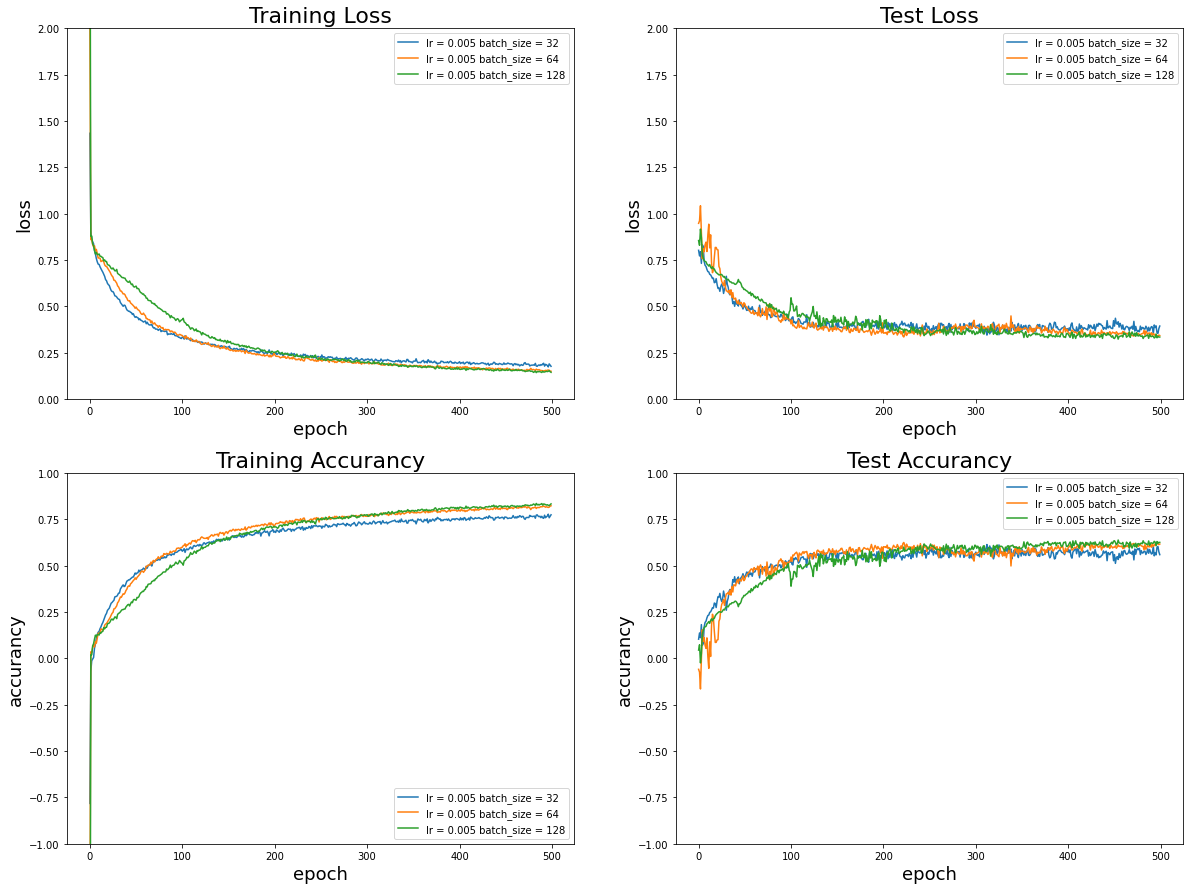

<Figure size 432x288 with 0 Axes>

In [20]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,15))
plt.figure()
ax1.set_title("Training Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 32")
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[2],label="lr = 0.005 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 32")
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[2],label="lr = 0.005 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 2])

ax3.set_title("Training Accurancy", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 32")
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[2],label="lr = 0.005 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("accurancy", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test Accurancy", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 32")
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[2],label="lr = 0.005 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("accurancy", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

### Model 1

{'batch_size': 32, 'epoch': 313, 'train_loss': 0.2073081911618548, 'test_loss': 0.3448825180530548, 'train_acc': 0.737742243811737, 'test_acc': 0.6149543997751112}


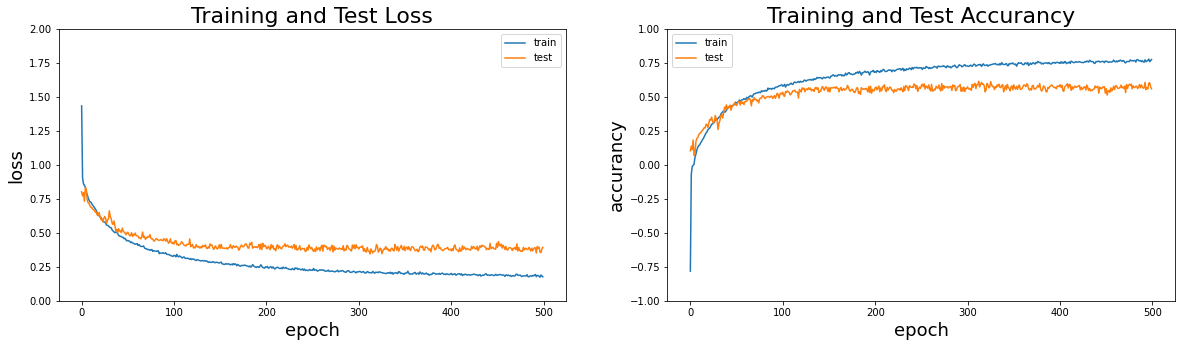

<Figure size 1440x360 with 0 Axes>

In [18]:
print(best_params_all[0])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="train")
ax1.plot(test_losses_all[0],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Training and Test Accurancy", fontsize=22)
ax2.plot(train_accs_all[0],label="train")
ax2.plot(test_accs_all[0],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("accurancy", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 2

{'batch_size': 64, 'epoch': 223, 'train_loss': 0.2170833307773547, 'test_loss': 0.33481597900390625, 'train_acc': 0.7460172801623276, 'test_acc': 0.6261932611560643}


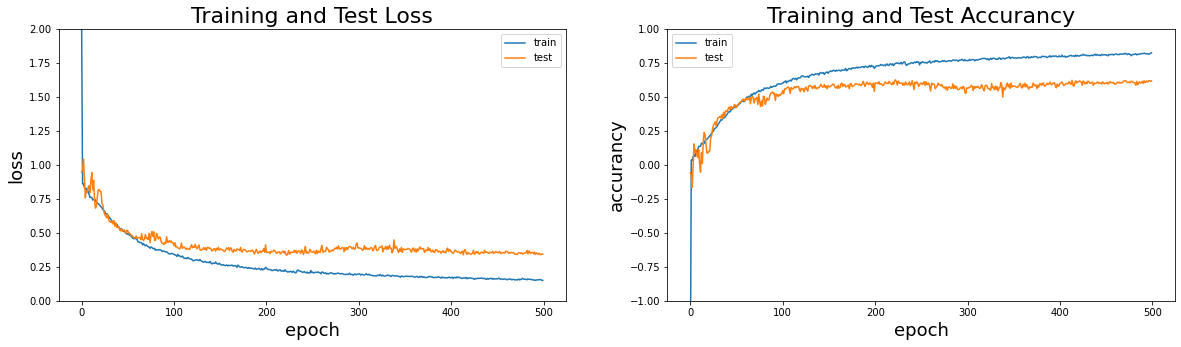

<Figure size 1440x360 with 0 Axes>

In [22]:
print(best_params_all[1])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="train")
ax1.plot(test_losses_all[1],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Training and Test Accurancy", fontsize=22)
ax2.plot(train_accs_all[1],label="train")
ax2.plot(test_accs_all[1],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("accurancy", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 3

{'batch_size': 128, 'epoch': 455, 'train_loss': 0.1617345201657779, 'test_loss': 0.32323095202445984, 'train_acc': 0.8144772037851725, 'test_acc': 0.6391273879452901}


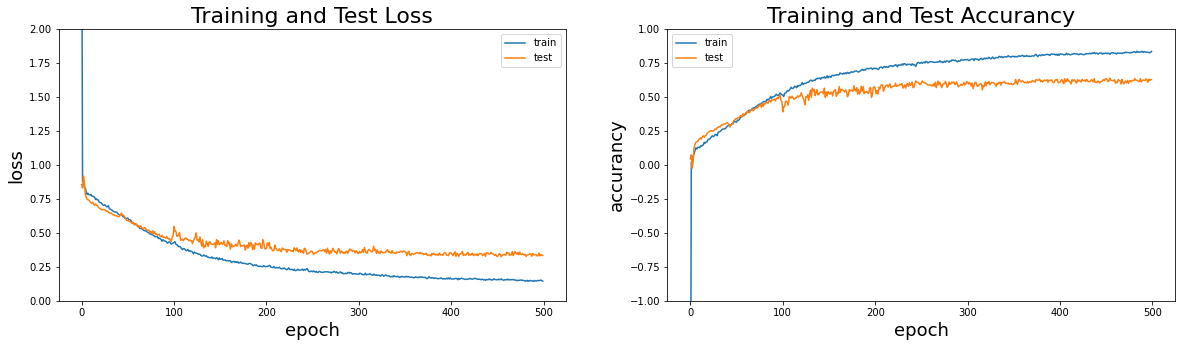

<Figure size 1440x360 with 0 Axes>

In [24]:
print(best_params_all[2])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Training and Test Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="train")
ax1.plot(test_losses_all[2],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Training and Test Accurancy", fontsize=22)
ax2.plot(train_accs_all[2],label="train")
ax2.plot(test_accs_all[2],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("accurancy", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()